In [1]:
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
from PIL import Image

In [5]:
def euclidean_distance(a, b):
    x1 = a[0]
    y1 = a[1]
    x2 = b[0]
    y2 = b[1]
    
    return math.sqrt((x2 - x1) * (x2 - x1) + (y2 - y1)* (y2 - y1))

In [6]:
def image_preprocessing(path):
    image = cv2.imread(path)
    
    if(type(image) == type(None)):
        print("Cannot preprocess. image is None.")
        return
    
    # resize (48, 48) -> (224, 224)
    resized_image = resize(image)
    # normalize
    normalized_image = normalize(resized_image)
    # face rotation with extracting roi 
    roi_image = rotation_roi(normalized_image)
    # resize roi.shape -> -> (224, 224)
    resized_roi = resize(roi_image) 
    # apply face mesh
    result = reduced_face_mesh(resized_roi)
    
    return result

In [7]:
def resize(image):
    if(type(image) == type(None)):
        print("Cannot preprocess. image is None.")
        return
    
    image = image.astype(np.uint8)
    resized_image = cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_LINEAR)
    return resized_image

In [8]:
def normalize(image):
    if(type(image) == type(None)):
        print("Cannot normalize. image is None.")
        return
    
    result = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    # print(type(result))
    return result

In [9]:
def rotation_roi(image):
    if(type(image) == type(None)):
        print("Cannot rotation. image is None.")
        return None, None
    
    # the position number of silhoueets
    silhouette = [
        10,  338, 297, 332, 284, 251, 389, 356, 454, 323, 361, 288,
        397, 365, 379, 378, 400, 377, 152, 148, 176, 149, 150, 136,
        172, 58,  132, 93,  234, 127, 162, 21,  54,  103, 67,  109]
    
    # for ROI
    x, y = 0, 0
    minX, minY = 1000, 1000 
    maxX, maxY = 0, 0
    roi_t = 10
    
    # for face mesh style
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_face_mesh = mp.solutions.face_mesh
    
    # For static images:
    drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
    
    with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5) as face_mesh:
        
        width = image.shape[1]
        height = image.shape[0]
        new_image = image.copy()
        
        # Convert the BGR image to RGB before processing.
        results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
        # Print and draw face mesh landmarks on the image.
        if not results.multi_face_landmarks:
              return None
            
        annotated_image = image.copy()

        for face_landmarks in results.multi_face_landmarks:
            ### rotation
            irises = list(mp_face_mesh.FACEMESH_IRISES)
                
            # left eye 눈동자 상하 위치 인덱스: 0, 1 
            l_pt1_x = int(face_landmarks.landmark[irises[0][0]].x * width)
            l_pt1_y = int(face_landmarks.landmark[irises[0][0]].y * height)
            l_pt2_x = int(face_landmarks.landmark[irises[1][0]].x * width)
            l_pt2_y = int(face_landmarks.landmark[irises[1][0]].y * height)
            # right eye 눈동자 상하 위치 인덱스: 3, 6
            r_pt1_x = int(face_landmarks.landmark[irises[7][0]].x * width)
            r_pt1_y = int(face_landmarks.landmark[irises[7][0]].y * height)
            r_pt2_x = int(face_landmarks.landmark[irises[3][0]].x * width)
            r_pt2_y = int(face_landmarks.landmark[irises[3][0]].y * height)

            # left eye
            if l_pt1_x > l_pt2_x:
                left_eye_x = l_pt2_x + (l_pt1_x - l_pt2_x) // 2
            else:
                left_eye_x = l_pt1_x + (l_pt2_x - l_pt1_x) // 2

            left_eye_y = l_pt1_y + (l_pt2_y - l_pt1_y) // 2

            # right eye
            if r_pt1_x > r_pt2_x:
                right_eye_x = r_pt2_x + (r_pt1_x - r_pt2_x) // 2
            else:
                right_eye_x = r_pt1_x + (r_pt2_x - r_pt1_x) // 2

            right_eye_y = r_pt1_y + (r_pt2_y - r_pt1_y) // 2

            left_eye_center = (left_eye_x, left_eye_y)
            right_eye_center = (right_eye_x, right_eye_y)
            
            if left_eye_y < right_eye_y :
                point_3rd = (right_eye_x, left_eye_y)
                direction = 1 # 반시계방향
                # print("반시계방향 회전")
            else:
                point_3rd = (left_eye_x, right_eye_y)
                direction = -1 # 시계방향
                # print("시계방향 회전")

            a = euclidean_distance(left_eye_center, point_3rd)
            b = euclidean_distance(right_eye_center, left_eye_center)
            c = euclidean_distance(right_eye_center, point_3rd)

            cos_a = (b * b + c * c - a * a) / (2 * b * c)
            # print("cos(a) = ", cos_a)

            angle = np.arccos(cos_a)
            # print("angle : " , angle, " in radian")

            angle = (angle * 180) / math.pi
            # print("angle : ", angle, " in degree")

            if direction == 1:
                angle = 90 - angle

        rotated_image = Image.fromarray(annotated_image)
        rotated_image = np.array(rotated_image.rotate(direction * (-1) * angle))
    
    roi_image = roi(face_landmarks, rotated_image)
    
    return roi_image

In [10]:
def roi(face_landmarks, image):
    if(type(image) == type(None)):
        print("Cannot extract roi. ")
        return _, None
    
     # the position number of silhoueets
    silhouette = [
        10,  338, 297, 332, 284, 251, 389, 356, 454, 323, 361, 288,
        397, 365, 379, 378, 400, 377, 152, 148, 176, 149, 150, 136,
        172, 58,  132, 93,  234, 127, 162, 21,  54,  103, 67,  109]
    
    # for ROI
    x, y = 0, 0
    minX, minY = 1000, 1000 
    maxX, maxY = 0, 0
    roi_t = 10
    
    height = image.shape[0]
    width = image.shape[1]
    
    for i in silhouette:
        # find silhouette
        x = int(face_landmarks.landmark[i].x * image.shape[1])
        y = int(face_landmarks.landmark[i].y * image.shape[0])
        
        # find ROI coordinate
        if x < minX:
            minX = x
        if y < minY:
            minY = y
        if x > maxX:
            maxX = x
        if y > maxY:
            maxY = y

    # adjust the points (x1, y1), (x2, y2)
    x1 = minX - roi_t
    y1 = minY - roi_t
    x2 = maxX + roi_t + 1
    y2 = maxY + roi_t + 1

    if(x1 < 0):
        x1 = 0
    if(y1 < 0):
        y1 = 0
    if(x2 > width or x2 < 0):
        x2 = width
    if(y2 > height or y2 < 0):
        y2 = height

    # extract roi
    #print(x1, x2, y1, y2)
    roi_image = image[y1:y2, x1:x2]

    return roi_image

In [4]:
def reduced_face_mesh(image):
    if(type(image) == type(None)):
        print("Cannot face mesh. image is None.")
        return
    
    # for face mesh style
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_face_mesh = mp.solutions.face_mesh
    
    # For static images:
    drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
    
    height = image.shape[0]
    width = image.shape[1]
  
    landmarks = list(mp_face_mesh.FACEMESH_CONTOURS)
    
    with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5) as face_mesh:
        
        # Convert the BGR image to RGB before processing.
        results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        # Print and draw face mesh landmarks on the image.
        if not results.multi_face_landmarks:
            print("Cannot find landmark on the image.")
            return
            
        annotated_image = image.copy()
        
        for face_landmarks in results.multi_face_landmarks:
            for i in range(len(landmarks)):
                x = int(face_landmarks.landmark[landmarks[i][0]].x * width)
                y = int(face_landmarks.landmark[landmarks[i][0]].y * height)
                
                print(i)
                cv2.line(annotated_image, (x, y), (x, y), (255, 0, 0), 2)
            
    return annotated_image

In [3]:
path = '../data/fer2013/train/happy/Training_1155391.jpg'
image = cv2.imread(path)
image = resize(image)
image = normalize(image)
image = rotation_roi(image)
image = resize(image)
image = reduced_face_mesh(image)

if(type(image) != type(None)):
    plt.imshow(image)
    print(image.shape)

Cannot face mesh. image is None.


[ WARN:0@19.806] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('../data/fer2013/train/happy/Training_1155391.jpg'): can't open/read file: check file path/integrity


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
(48, 48, 3)


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


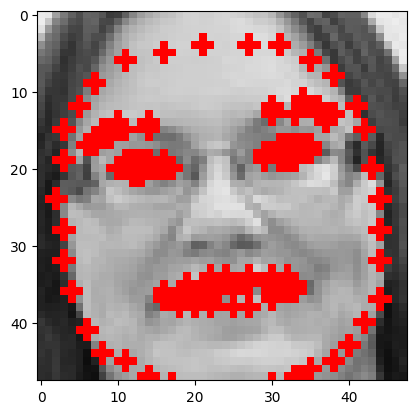

In [5]:
path = '../../data/fer2013/train/happy/Training_1206.jpg'
image = cv2.imread(path)
image = reduced_face_mesh(image)

if(type(image) != type(None)):
    plt.imshow(image)
    print(image.shape)

(224, 224, 3)


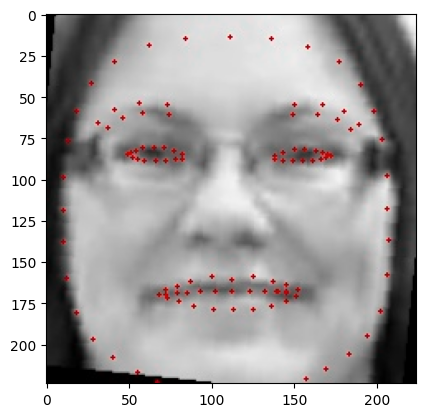

In [9]:
path = '../../data/refined_fer2013/train/happy/Training_1206.jpg'
image = cv2.imread(path)

if(type(image) != type(None)):
    plt.imshow(image)
    print(image.shape)


# Refine dataset

In [186]:
import os
from tqdm import tqdm

In [323]:
os.chdir("..")

In [324]:
os.getcwd()

'/Users/shimgahyeon/Capstone/Capstone/Facial Expression Recongnition/data/fer2013'

In [325]:
classes = ["neutral", "happy", "fear", "disgust", "angry", "sad", "surprise"]
no_landmark_dict = {}

for mode in ["train", "test"]:
    print("###", mode, "###")
    no_landmark = {}
    
    os.chdir("./"+mode)
    
    for label in classes:
        print("##", label, "##")
        os.chdir("./"+label)
        files = os.listdir(os.getcwd())
        
        file_list = []
        
        for file in tqdm(files):
            result = image_preprocessing(file)
            
            if(type(result) == type(None)):
                print(label,"-", file)
                file_list.append(file)
                print("####################")
            else:
                cv2.imwrite("../../../refined_fer2013/"+mode+"/"+label+"/"+file, result)
        
        no_landmark[label] = file_list
        
        os.chdir("..")
    
    no_landmark_dict[mode] = no_landmark
    
    os.chdir("..")

### train ###
## neutral ##


  0%|          | 14/4965 [00:01<06:44, 12.24it/s]

Cannot find landmark on the image.
neutral - Training_3954955.jpg
####################


  0%|          | 20/4965 [00:01<06:47, 12.12it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_55903517.jpg
####################


  1%|          | 34/4965 [00:02<06:13, 13.20it/s]

Cannot find landmark on the image.
neutral - Training_90049604.jpg
####################


  1%|          | 36/4965 [00:02<05:56, 13.83it/s]

Cannot find landmark on the image.
neutral - Training_46807852.jpg
####################
Cannot find landmark on the image.
neutral - Training_34932239.jpg
####################


  1%|          | 52/4965 [00:03<05:24, 15.16it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_75145014.jpg
####################


  2%|▏         | 76/4965 [00:05<05:26, 14.98it/s]

Cannot find landmark on the image.
neutral - Training_84174787.jpg
####################


  2%|▏         | 82/4965 [00:05<05:23, 15.08it/s]

Cannot find landmark on the image.
neutral - Training_42581618.jpg
####################
Cannot find landmark on the image.
neutral - Training_37474028.jpg
####################


  3%|▎         | 126/4965 [00:08<05:05, 15.83it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_24160184.jpg
####################


  3%|▎         | 131/4965 [00:09<04:59, 16.14it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_58456995.jpg
####################


  3%|▎         | 144/4965 [00:10<04:43, 17.00it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_48177875.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_46949485.jpg
####################


  3%|▎         | 156/4965 [00:10<05:16, 15.20it/s]

Cannot find landmark on the image.
neutral - Training_17042478.jpg
####################


  3%|▎         | 166/4965 [00:11<05:07, 15.63it/s]

Cannot find landmark on the image.
neutral - Training_76961689.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_47075825.jpg
####################


  4%|▍         | 188/4965 [00:13<05:25, 14.66it/s]

Cannot find landmark on the image.
neutral - Training_53284079.jpg
####################
Cannot find landmark on the image.
neutral - Training_81566998.jpg
####################


  4%|▍         | 196/4965 [00:13<05:23, 14.72it/s]

Cannot find landmark on the image.
neutral - Training_80875936.jpg
####################


  4%|▍         | 204/4965 [00:14<05:04, 15.64it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_69476793.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_74574504.jpg
####################


  4%|▍         | 217/4965 [00:15<05:18, 14.90it/s]

Cannot find landmark on the image.
neutral - Training_64964053.jpg
####################


  5%|▍         | 245/4965 [00:16<05:16, 14.90it/s]

Cannot find landmark on the image.
neutral - Training_79622672.jpg
####################


  5%|▌         | 251/4965 [00:17<05:07, 15.34it/s]

Cannot find landmark on the image.
neutral - Training_99088787.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_80497255.jpg
####################


  5%|▌         | 257/4965 [00:17<05:13, 15.03it/s]

Cannot find landmark on the image.
neutral - Training_38737103.jpg
####################


  6%|▌         | 279/4965 [00:19<04:51, 16.07it/s]

Cannot find landmark on the image.
neutral - Training_87356352.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_23772184.jpg
####################


  6%|▌         | 287/4965 [00:19<05:01, 15.53it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_63429804.jpg
####################


  6%|▌         | 294/4965 [00:20<04:50, 16.07it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_45719271.jpg
####################


  7%|▋         | 328/4965 [00:22<04:50, 15.99it/s]

Cannot find landmark on the image.
neutral - Training_20116337.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_62129714.jpg
####################


  7%|▋         | 338/4965 [00:23<05:11, 14.85it/s]

Cannot find landmark on the image.
neutral - Training_70809097.jpg
####################


  7%|▋         | 352/4965 [00:24<05:10, 14.85it/s]

Cannot find landmark on the image.
neutral - Training_71266356.jpg
####################


  7%|▋         | 366/4965 [00:24<04:51, 15.78it/s]

Cannot find landmark on the image.
neutral - Training_82677562.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_35406373.jpg
####################


  8%|▊         | 396/4965 [00:27<05:50, 13.05it/s]

Cannot find landmark on the image.
neutral - Training_66555915.jpg
####################


  8%|▊         | 416/4965 [00:28<05:08, 14.76it/s]

Cannot find landmark on the image.
neutral - Training_68423650.jpg
####################


 10%|█         | 508/4965 [00:36<05:53, 12.59it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_56484170.jpg
####################


 11%|█         | 536/4965 [00:38<05:28, 13.49it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_92732279.jpg
####################


 11%|█         | 542/4965 [00:38<05:43, 12.86it/s]

Cannot find landmark on the image.
neutral - Training_95299533.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_43562723.jpg
####################


 11%|█         | 548/4965 [00:39<05:32, 13.28it/s]

Cannot find landmark on the image.
neutral - Training_31328737.jpg
####################


 12%|█▏        | 580/4965 [00:42<06:20, 11.52it/s]

Cannot find landmark on the image.
neutral - Training_67647461.jpg
####################


 12%|█▏        | 592/4965 [00:43<05:46, 12.63it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_78009790.jpg
####################


 12%|█▏        | 602/4965 [00:43<05:31, 13.17it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_93661656.jpg
####################


 13%|█▎        | 663/4965 [00:48<05:12, 13.76it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_55637093.jpg
####################


 14%|█▍        | 685/4965 [00:50<05:46, 12.34it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_63550898.jpg
####################


 14%|█▍        | 689/4965 [00:50<05:39, 12.58it/s]

Cannot find landmark on the image.
neutral - Training_41033870.jpg
####################


 14%|█▍        | 699/4965 [00:51<06:06, 11.63it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_14881295.jpg
####################


 14%|█▍        | 707/4965 [00:52<05:44, 12.35it/s]

Cannot find landmark on the image.
neutral - Training_42590707.jpg
####################


 14%|█▍        | 717/4965 [00:53<05:03, 13.97it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_20118041.jpg
####################


 15%|█▍        | 733/4965 [00:54<05:35, 12.60it/s]

Cannot find landmark on the image.
neutral - Training_58367901.jpg
####################


 15%|█▍        | 737/4965 [00:54<05:41, 12.39it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_73413926.jpg
####################


 15%|█▌        | 749/4965 [00:55<05:32, 12.67it/s]

Cannot find landmark on the image.
neutral - Training_99862686.jpg
####################


 15%|█▌        | 755/4965 [00:55<04:52, 14.41it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_20613159.jpg
####################


 15%|█▌        | 761/4965 [00:56<06:19, 11.09it/s]

Cannot find landmark on the image.
neutral - Training_68765647.jpg
####################
Cannot find landmark on the image.
neutral - Training_35356450.jpg
####################


 15%|█▌        | 767/4965 [00:57<05:42, 12.27it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_45906834.jpg
####################


 16%|█▌        | 789/4965 [00:58<05:18, 13.11it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_7264356.jpg
####################
Cannot find landmark on the image.
neutral - Training_40011494.jpg
####################


 16%|█▌        | 795/4965 [00:59<05:15, 13.22it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_28953960.jpg
####################


 16%|█▌        | 801/4965 [00:59<05:03, 13.73it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_33897786.jpg
####################


 17%|█▋        | 825/4965 [01:01<04:48, 14.36it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_44680810.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_14356450.jpg
####################


 17%|█▋        | 838/4965 [01:02<04:41, 14.68it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_69365571.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_29052495.jpg
####################


 17%|█▋        | 844/4965 [01:03<04:48, 14.27it/s]

Cannot find landmark on the image.
neutral - Training_18884987.jpg
####################


 18%|█▊        | 874/4965 [01:05<04:56, 13.80it/s]

Cannot find landmark on the image.
neutral - Training_96851033.jpg
####################


 18%|█▊        | 900/4965 [01:07<04:33, 14.84it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_58198171.jpg
####################


 19%|█▊        | 920/4965 [01:09<05:33, 12.12it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_63336204.jpg
####################


 19%|█▉        | 944/4965 [01:11<05:13, 12.82it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_26095375.jpg
####################


 19%|█▉        | 966/4965 [01:12<05:15, 12.69it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_90665371.jpg
####################


 20%|█▉        | 980/4965 [01:13<04:55, 13.50it/s]

Cannot find landmark on the image.
neutral - Training_34831523.jpg
####################


 20%|█▉        | 986/4965 [01:14<04:54, 13.52it/s]

Cannot find landmark on the image.
neutral - Training_10602688.jpg
####################


 20%|█▉        | 992/4965 [01:14<04:58, 13.32it/s]

Cannot find landmark on the image.
neutral - Training_28817271.jpg
####################


 20%|██        | 996/4965 [01:15<05:26, 12.14it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_4455251.jpg
####################


 21%|██        | 1042/4965 [01:18<04:21, 15.01it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_15392275.jpg
####################


 22%|██▏       | 1074/4965 [01:20<04:28, 14.49it/s]

Cannot find landmark on the image.
neutral - Training_79380425.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_30114749.jpg
####################


 23%|██▎       | 1127/4965 [01:24<04:47, 13.35it/s]

Cannot find landmark on the image.
neutral - Training_21448769.jpg
####################


 23%|██▎       | 1132/4965 [01:24<04:14, 15.09it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_4956529.jpg
####################


 23%|██▎       | 1136/4965 [01:25<04:11, 15.25it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_42279539.jpg
####################
Cannot find landmark on the image.
neutral - Training_65520017.jpg
####################


 23%|██▎       | 1140/4965 [01:25<04:36, 13.85it/s]

Cannot find landmark on the image.
neutral - Training_8621864.jpg
####################


 23%|██▎       | 1160/4965 [01:26<04:41, 13.51it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_44366032.jpg
####################


 24%|██▍       | 1190/4965 [01:29<04:55, 12.79it/s]

Cannot find landmark on the image.
neutral - Training_46593466.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_27581546.jpg
####################


 24%|██▍       | 1195/4965 [01:29<04:11, 14.97it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_28095627.jpg
####################


 25%|██▍       | 1225/4965 [01:32<05:21, 11.63it/s]

Cannot find landmark on the image.
neutral - Training_42021570.jpg
####################


 25%|██▌       | 1259/4965 [01:35<04:32, 13.62it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_97526543.jpg
####################


 25%|██▌       | 1263/4965 [01:35<04:43, 13.06it/s]

Cannot find landmark on the image.
neutral - Training_25636833.jpg
####################


 26%|██▋       | 1305/4965 [01:38<05:04, 12.02it/s]

Cannot find landmark on the image.
neutral - Training_94660175.jpg
####################


 27%|██▋       | 1331/4965 [01:40<04:26, 13.62it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_47099145.jpg
####################


 27%|██▋       | 1349/4965 [01:42<05:13, 11.55it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_64525157.jpg
####################


 27%|██▋       | 1353/4965 [01:42<05:09, 11.68it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_54507663.jpg
####################


 27%|██▋       | 1362/4965 [01:43<04:55, 12.20it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_15579995.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_75798306.jpg
####################


 28%|██▊       | 1380/4965 [01:45<03:58, 15.01it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_48282359.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_1258778.jpg
####################


 28%|██▊       | 1410/4965 [01:47<04:57, 11.96it/s]

Cannot find landmark on the image.
neutral - Training_92010220.jpg
####################


 29%|██▊       | 1416/4965 [01:47<04:41, 12.60it/s]

Cannot find landmark on the image.
neutral - Training_29136162.jpg
####################


 29%|██▊       | 1426/4965 [01:48<04:34, 12.90it/s]

Cannot find landmark on the image.
neutral - Training_76933580.jpg
####################


 29%|██▉       | 1444/4965 [01:50<04:03, 14.47it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_74913015.jpg
####################


 30%|██▉       | 1476/4965 [01:52<04:17, 13.54it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_34564480.jpg
####################


 30%|██▉       | 1480/4965 [01:52<04:36, 12.61it/s]

Cannot find landmark on the image.
neutral - Training_20946323.jpg
####################


 30%|██▉       | 1486/4965 [01:53<04:56, 11.75it/s]

Cannot find landmark on the image.
neutral - Training_75742026.jpg
####################


 30%|███       | 1492/4965 [01:54<05:00, 11.55it/s]

Cannot find landmark on the image.
neutral - Training_85427897.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_72298787.jpg
####################


 30%|███       | 1498/4965 [01:54<04:15, 13.58it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_94337620.jpg
####################
Cannot find landmark on the image.
neutral - Training_92036608.jpg
####################


 31%|███       | 1540/4965 [01:57<04:14, 13.48it/s]

Cannot find landmark on the image.
neutral - Training_52442111.jpg
####################


 32%|███▏      | 1581/4965 [02:00<03:59, 14.15it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_86128030.jpg
####################


 32%|███▏      | 1599/4965 [02:02<04:19, 12.99it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_38142836.jpg
####################


 32%|███▏      | 1613/4965 [02:03<04:30, 12.40it/s]

Cannot find landmark on the image.
neutral - Training_14971699.jpg
####################


 33%|███▎      | 1619/4965 [02:04<04:22, 12.75it/s]

Cannot find landmark on the image.
neutral - Training_10175776.jpg
####################


 33%|███▎      | 1639/4965 [02:05<04:02, 13.72it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_23022416.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_14605930.jpg
####################


 33%|███▎      | 1645/4965 [02:06<04:09, 13.33it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_52809823.jpg
####################


 33%|███▎      | 1651/4965 [02:06<03:49, 14.44it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_72194926.jpg
####################


 33%|███▎      | 1661/4965 [02:07<03:35, 15.34it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_55180835.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_45637066.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_23049512.jpg
####################


 34%|███▎      | 1675/4965 [02:08<04:33, 12.04it/s]

Cannot find landmark on the image.
neutral - Training_5391729.jpg
####################


 34%|███▍      | 1697/4965 [02:09<03:48, 14.28it/s]

Cannot find landmark on the image.
neutral - Training_67347024.jpg
####################


 35%|███▍      | 1713/4965 [02:11<03:57, 13.68it/s]

Cannot find landmark on the image.
neutral - Training_32195107.jpg
####################


 35%|███▌      | 1746/4965 [02:13<03:21, 15.96it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_89335926.jpg
####################


 35%|███▌      | 1752/4965 [02:13<03:48, 14.06it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_98971826.jpg
####################


 36%|███▌      | 1776/4965 [02:15<03:28, 15.33it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_22384551.jpg
####################


 36%|███▌      | 1792/4965 [02:16<03:38, 14.51it/s]

Cannot find landmark on the image.
neutral - Training_67167589.jpg
####################


 36%|███▋      | 1810/4965 [02:17<03:28, 15.13it/s]

Cannot find landmark on the image.
neutral - Training_9192788.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_69374744.jpg
####################
Cannot find landmark on the image.
neutral - Training_21026632.jpg
####################


 37%|███▋      | 1835/4965 [02:19<03:31, 14.82it/s]

Cannot find landmark on the image.
neutral - Training_50614587.jpg
####################
Cannot find landmark on the image.
neutral - Training_24090366.jpg
####################


 38%|███▊      | 1867/4965 [02:21<03:21, 15.39it/s]

Cannot find landmark on the image.
neutral - Training_18421495.jpg
####################
Cannot find landmark on the image.
neutral - Training_57512499.jpg
####################


 38%|███▊      | 1891/4965 [02:23<03:29, 14.65it/s]

Cannot find landmark on the image.
neutral - Training_56064406.jpg
####################


 38%|███▊      | 1905/4965 [02:24<03:35, 14.19it/s]

Cannot find landmark on the image.
neutral - Training_14336503.jpg
####################
Cannot find landmark on the image.
neutral - Training_9220409.jpg
####################


 39%|███▉      | 1933/4965 [02:26<03:56, 12.81it/s]

Cannot find landmark on the image.
neutral - Training_97062053.jpg
####################


 39%|███▉      | 1957/4965 [02:28<03:41, 13.59it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_46121863.jpg
####################


 40%|███▉      | 1979/4965 [02:30<03:54, 12.75it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_70479969.jpg
####################


 40%|███▉      | 1981/4965 [02:30<03:48, 13.07it/s]

Cannot find landmark on the image.
neutral - Training_9146456.jpg
####################


 40%|████      | 2003/4965 [02:32<03:42, 13.34it/s]

Cannot find landmark on the image.
neutral - Training_80740671.jpg
####################


 41%|████      | 2045/4965 [02:35<04:11, 11.61it/s]

Cannot find landmark on the image.
neutral - Training_55718628.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_4026808.jpg
####################


 42%|████▏     | 2063/4965 [02:36<03:48, 12.71it/s]

Cannot find landmark on the image.
neutral - Training_42004536.jpg
####################


 42%|████▏     | 2065/4965 [02:37<03:58, 12.16it/s]

Cannot find landmark on the image.
neutral - Training_40055100.jpg
####################


 42%|████▏     | 2085/4965 [02:38<04:01, 11.91it/s]

Cannot find landmark on the image.
neutral - Training_78966942.jpg
####################


 42%|████▏     | 2097/4965 [02:39<03:57, 12.10it/s]

Cannot find landmark on the image.
neutral - Training_35896417.jpg
####################


 42%|████▏     | 2105/4965 [02:40<03:42, 12.87it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_73599260.jpg
####################


 43%|████▎     | 2116/4965 [02:41<03:12, 14.81it/s]

Cannot find landmark on the image.
neutral - Training_82152045.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_71465846.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_39990172.jpg
####################


 43%|████▎     | 2144/4965 [02:43<03:47, 12.41it/s]

Cannot find landmark on the image.
neutral - Training_99396766.jpg
####################


 43%|████▎     | 2150/4965 [02:44<03:25, 13.67it/s]

Cannot find landmark on the image.
neutral - Training_62360450.jpg
####################
Cannot find landmark on the image.
neutral - Training_4873495.jpg
####################


 43%|████▎     | 2154/4965 [02:44<03:06, 15.08it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_36179932.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_72686010.jpg
####################


 44%|████▎     | 2170/4965 [02:45<03:52, 12.00it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_66880865.jpg
####################
Cannot find landmark on the image.
neutral - Training_45866030.jpg
####################


 44%|████▍     | 2184/4965 [02:46<03:39, 12.68it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_954435.jpg
####################


 44%|████▍     | 2192/4965 [02:47<03:33, 12.96it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_84149919.jpg
####################


 44%|████▍     | 2198/4965 [02:48<03:34, 12.91it/s]

Cannot find landmark on the image.
neutral - Training_88588242.jpg
####################


 45%|████▍     | 2222/4965 [02:50<03:31, 12.94it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_29529460.jpg
####################


 46%|████▌     | 2270/4965 [02:53<03:20, 13.45it/s]

Cannot find landmark on the image.
neutral - Training_66799326.jpg
####################


 46%|████▌     | 2280/4965 [02:54<03:26, 13.02it/s]

Cannot find landmark on the image.
neutral - Training_91998342.jpg
####################


 46%|████▌     | 2288/4965 [02:55<03:34, 12.46it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_72106503.jpg
####################


 46%|████▋     | 2304/4965 [02:56<03:26, 12.90it/s]

Cannot find landmark on the image.
neutral - Training_60598118.jpg
####################


 47%|████▋     | 2310/4965 [02:57<03:49, 11.56it/s]

Cannot find landmark on the image.
neutral - Training_44026779.jpg
####################


 47%|████▋     | 2326/4965 [02:58<03:33, 12.36it/s]

Cannot find landmark on the image.
neutral - Training_57074106.jpg
####################


 47%|████▋     | 2330/4965 [02:58<03:21, 13.09it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_56776111.jpg
####################


 47%|████▋     | 2356/4965 [03:01<03:40, 11.83it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_99760416.jpg
####################
Cannot find landmark on the image.
neutral - Training_25147891.jpg
####################


 48%|████▊     | 2362/4965 [03:01<03:22, 12.84it/s]

Cannot find landmark on the image.
neutral - Training_17185800.jpg
####################
Cannot find landmark on the image.
neutral - Training_506670.jpg
####################


 48%|████▊     | 2376/4965 [03:02<03:12, 13.45it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_99569677.jpg
####################


 48%|████▊     | 2392/4965 [03:03<03:12, 13.38it/s]

Cannot find landmark on the image.
neutral - Training_84872510.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_86611228.jpg
####################


 48%|████▊     | 2404/4965 [03:04<03:07, 13.64it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_27871698.jpg
####################


 49%|████▉     | 2452/4965 [03:08<03:01, 13.86it/s]

Cannot find landmark on the image.
neutral - Training_39651334.jpg
####################


 50%|████▉     | 2460/4965 [03:09<03:00, 13.85it/s]

Cannot find landmark on the image.
neutral - Training_44802846.jpg
####################


 50%|█████     | 2499/4965 [03:11<02:36, 15.80it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_80335177.jpg
####################


 50%|█████     | 2507/4965 [03:12<02:47, 14.71it/s]

Cannot find landmark on the image.
neutral - Training_89992777.jpg
####################


 51%|█████▏    | 2548/4965 [03:15<02:26, 16.46it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_15450089.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_80894355.jpg
####################


 51%|█████▏    | 2550/4965 [03:15<02:32, 15.84it/s]

Cannot find landmark on the image.
neutral - Training_94677574.jpg
####################


 52%|█████▏    | 2563/4965 [03:16<02:33, 15.69it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_78134041.jpg
####################
Cannot find landmark on the image.
neutral - Training_41328472.jpg
####################


 52%|█████▏    | 2568/4965 [03:16<02:25, 16.44it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_42420731.jpg
####################


 53%|█████▎    | 2607/4965 [03:19<02:36, 15.07it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_91636057.jpg
####################


 53%|█████▎    | 2611/4965 [03:19<02:31, 15.52it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_36689712.jpg
####################


 53%|█████▎    | 2625/4965 [03:20<02:38, 14.75it/s]

Cannot find landmark on the image.
neutral - Training_71527299.jpg
####################


 53%|█████▎    | 2631/4965 [03:20<02:27, 15.83it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_64144757.jpg
####################


 53%|█████▎    | 2641/4965 [03:21<02:48, 13.82it/s]

Cannot find landmark on the image.
neutral - Training_93839688.jpg
####################


 53%|█████▎    | 2647/4965 [03:22<02:40, 14.43it/s]

Cannot find landmark on the image.
neutral - Training_23006554.jpg
####################
Cannot find landmark on the image.
neutral - Training_30167092.jpg
####################


 54%|█████▎    | 2665/4965 [03:23<02:39, 14.45it/s]

Cannot find landmark on the image.
neutral - Training_72379362.jpg
####################


 54%|█████▍    | 2671/4965 [03:23<02:28, 15.42it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_15489460.jpg
####################


 54%|█████▍    | 2682/4965 [03:24<02:20, 16.28it/s]

Cannot find landmark on the image.
neutral - Training_25902942.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_42408094.jpg
####################
Cannot find landmark on the image.
neutral - Training_56346759.jpg
####################


 54%|█████▍    | 2691/4965 [03:24<02:21, 16.06it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_61854917.jpg
####################


 55%|█████▍    | 2713/4965 [03:26<02:27, 15.29it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_29604209.jpg
####################


 55%|█████▍    | 2727/4965 [03:27<02:30, 14.86it/s]

Cannot find landmark on the image.
neutral - Training_65418242.jpg
####################


 56%|█████▌    | 2783/4965 [03:31<02:33, 14.19it/s]

Cannot find landmark on the image.
neutral - Training_62985571.jpg
####################
Cannot find landmark on the image.
neutral - Training_60982317.jpg
####################


 56%|█████▋    | 2805/4965 [03:32<02:24, 14.95it/s]

Cannot find landmark on the image.
neutral - Training_93229303.jpg
####################


 57%|█████▋    | 2811/4965 [03:33<02:27, 14.60it/s]

Cannot find landmark on the image.
neutral - Training_5179423.jpg
####################


 58%|█████▊    | 2860/4965 [03:36<02:11, 16.04it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_18739078.jpg
####################
Cannot find landmark on the image.
neutral - Training_67858331.jpg
####################


 58%|█████▊    | 2865/4965 [03:36<01:59, 17.61it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_96968179.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_88342086.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_24114446.jpg
####################


 58%|█████▊    | 2884/4965 [03:38<02:23, 14.48it/s]

Cannot find landmark on the image.
neutral - Training_41677382.jpg
####################


 59%|█████▊    | 2905/4965 [03:39<02:09, 15.89it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_44094885.jpg
####################


 59%|█████▉    | 2917/4965 [03:40<02:18, 14.78it/s]

Cannot find landmark on the image.
neutral - Training_40726019.jpg
####################


 60%|█████▉    | 2975/4965 [03:44<02:14, 14.75it/s]

Cannot find landmark on the image.
neutral - Training_29363112.jpg
####################


 60%|██████    | 2982/4965 [03:44<02:05, 15.83it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_70054817.jpg
####################


 60%|██████    | 2991/4965 [03:45<02:05, 15.76it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_62400250.jpg
####################


 60%|██████    | 3003/4965 [03:46<02:19, 14.08it/s]

Cannot find landmark on the image.
neutral - Training_42619687.jpg
####################


 61%|██████▏   | 3053/4965 [03:49<02:13, 14.28it/s]

Cannot find landmark on the image.
neutral - Training_71145560.jpg
####################


 62%|██████▏   | 3065/4965 [03:50<02:04, 15.31it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_75186221.jpg
####################


 62%|██████▏   | 3072/4965 [03:51<01:58, 15.97it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_99766691.jpg
####################


 62%|██████▏   | 3078/4965 [03:51<02:05, 15.04it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_82659353.jpg
####################


 62%|██████▏   | 3085/4965 [03:51<02:00, 15.62it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_97875980.jpg
####################


 62%|██████▏   | 3094/4965 [03:52<01:58, 15.84it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_13384870.jpg
####################


 63%|██████▎   | 3110/4965 [03:53<02:07, 14.53it/s]

Cannot find landmark on the image.
neutral - Training_14484322.jpg
####################


 63%|██████▎   | 3124/4965 [03:54<01:57, 15.64it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_47530729.jpg
####################


 63%|██████▎   | 3141/4965 [03:55<01:55, 15.72it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_476565.jpg
####################


 64%|██████▎   | 3161/4965 [03:57<01:58, 15.22it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_93068651.jpg
####################


 64%|██████▎   | 3165/4965 [03:57<02:00, 14.93it/s]

Cannot find landmark on the image.
neutral - Training_6666966.jpg
####################


 64%|██████▍   | 3191/4965 [03:59<02:01, 14.62it/s]

Cannot find landmark on the image.
neutral - Training_20730503.jpg
####################


 64%|██████▍   | 3193/4965 [03:59<02:04, 14.24it/s]

Cannot find landmark on the image.
neutral - Training_24782134.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_3542668.jpg
####################


 65%|██████▍   | 3209/4965 [04:00<02:02, 14.32it/s]

Cannot find landmark on the image.
neutral - Training_49944562.jpg
####################


 65%|██████▌   | 3231/4965 [04:02<02:03, 14.00it/s]

Cannot find landmark on the image.
neutral - Training_58039111.jpg
####################


 65%|██████▌   | 3247/4965 [04:03<01:52, 15.21it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_18711487.jpg
####################


 65%|██████▌   | 3251/4965 [04:03<01:54, 14.99it/s]

Cannot find landmark on the image.
neutral - Training_63239969.jpg
####################


 66%|██████▌   | 3278/4965 [04:05<01:46, 15.82it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_32822518.jpg
####################


 67%|██████▋   | 3314/4965 [04:07<01:51, 14.78it/s]

Cannot find landmark on the image.
neutral - Training_58346581.jpg
####################


 67%|██████▋   | 3348/4965 [04:10<01:48, 14.85it/s]

Cannot find landmark on the image.
neutral - Training_61255417.jpg
####################


 68%|██████▊   | 3356/4965 [04:10<01:47, 15.02it/s]

Cannot find landmark on the image.
neutral - Training_36159814.jpg
####################


 68%|██████▊   | 3368/4965 [04:11<01:47, 14.80it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_33654792.jpg
####################


 69%|██████▊   | 3410/4965 [04:14<01:29, 17.47it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_59870655.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_37250784.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_21583713.jpg
####################


 69%|██████▉   | 3433/4965 [04:15<01:38, 15.51it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_1725421.jpg
####################


 69%|██████▉   | 3443/4965 [04:16<01:43, 14.69it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_7360010.jpg
####################
Cannot find landmark on the image.
neutral - Training_9071384.jpg
####################


 70%|███████   | 3476/4965 [04:18<01:35, 15.61it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_12498684.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_41066171.jpg
####################


 70%|███████   | 3483/4965 [04:19<01:28, 16.73it/s]

Cannot find landmark on the image.
neutral - Training_29272187.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_58318560.jpg
####################


 70%|███████   | 3493/4965 [04:19<01:30, 16.21it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_63104919.jpg
####################


 71%|███████   | 3503/4965 [04:20<01:36, 15.17it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_70291316.jpg
####################


 71%|███████   | 3507/4965 [04:20<01:54, 12.72it/s]

Cannot find landmark on the image.
neutral - Training_84606125.jpg
####################


 71%|███████   | 3513/4965 [04:21<01:46, 13.63it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_72293595.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_31598407.jpg
####################


 71%|███████   | 3521/4965 [04:21<01:43, 13.95it/s]

Cannot find landmark on the image.
neutral - Training_57184766.jpg
####################


 71%|███████▏  | 3545/4965 [04:23<01:39, 14.31it/s]

Cannot find landmark on the image.
neutral - Training_35458868.jpg
####################


 72%|███████▏  | 3556/4965 [04:24<01:31, 15.35it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_86222151.jpg
####################


 72%|███████▏  | 3567/4965 [04:25<01:29, 15.69it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_78319350.jpg
####################


 72%|███████▏  | 3577/4965 [04:25<01:34, 14.76it/s]

Cannot find landmark on the image.
neutral - Training_49909892.jpg
####################


 72%|███████▏  | 3591/4965 [04:26<01:36, 14.24it/s]

Cannot find landmark on the image.
neutral - Training_91712654.jpg
####################


 72%|███████▏  | 3597/4965 [04:27<01:33, 14.63it/s]

Cannot find landmark on the image.
neutral - Training_3942793.jpg
####################


 73%|███████▎  | 3617/4965 [04:28<01:30, 14.86it/s]

Cannot find landmark on the image.
neutral - Training_6945391.jpg
####################
Cannot find landmark on the image.
neutral - Training_21011442.jpg
####################


 73%|███████▎  | 3640/4965 [04:30<01:25, 15.55it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_18886653.jpg
####################


 74%|███████▎  | 3650/4965 [04:30<01:29, 14.61it/s]

Cannot find landmark on the image.
neutral - Training_53590006.jpg
####################


 74%|███████▎  | 3660/4965 [04:31<01:39, 13.12it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_72114331.jpg
####################
Cannot find landmark on the image.
neutral - Training_86553914.jpg
####################


 74%|███████▍  | 3682/4965 [04:33<01:31, 13.96it/s]

Cannot find landmark on the image.
neutral - Training_85604546.jpg
####################


 74%|███████▍  | 3686/4965 [04:33<01:30, 14.11it/s]

Cannot find landmark on the image.
neutral - Training_2356619.jpg
####################


 75%|███████▍  | 3712/4965 [04:35<01:28, 14.10it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_89881733.jpg
####################


 75%|███████▌  | 3728/4965 [04:36<01:29, 13.82it/s]

Cannot find landmark on the image.
neutral - Training_63654650.jpg
####################


 75%|███████▌  | 3734/4965 [04:37<01:27, 14.06it/s]

Cannot find landmark on the image.
neutral - Training_52862147.jpg
####################


 75%|███████▌  | 3748/4965 [04:38<01:26, 14.11it/s]

Cannot find landmark on the image.
neutral - Training_22002519.jpg
####################


 76%|███████▋  | 3798/4965 [04:41<01:23, 14.06it/s]

Cannot find landmark on the image.
neutral - Training_26006908.jpg
####################


 77%|███████▋  | 3805/4965 [04:41<01:14, 15.58it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_29594818.jpg
####################


 77%|███████▋  | 3817/4965 [04:42<01:16, 14.99it/s]

Cannot find landmark on the image.
neutral - Training_4899433.jpg
####################


 77%|███████▋  | 3823/4965 [04:43<01:17, 14.80it/s]

Cannot find landmark on the image.
neutral - Training_58026256.jpg
####################


 77%|███████▋  | 3837/4965 [04:44<01:14, 15.15it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_99019653.jpg
####################


 78%|███████▊  | 3849/4965 [04:44<01:15, 14.79it/s]

Cannot find landmark on the image.
neutral - Training_37924248.jpg
####################


 78%|███████▊  | 3853/4965 [04:45<01:11, 15.48it/s]

Cannot find landmark on the image.
neutral - Training_62225003.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_26269032.jpg
####################


 78%|███████▊  | 3879/4965 [04:47<01:11, 15.24it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_95565686.jpg
####################


 78%|███████▊  | 3883/4965 [04:47<01:16, 14.22it/s]

Cannot find landmark on the image.
neutral - Training_14687754.jpg
####################


 78%|███████▊  | 3887/4965 [04:47<01:16, 14.18it/s]

Cannot find landmark on the image.
neutral - Training_99095324.jpg
####################


 78%|███████▊  | 3893/4965 [04:48<01:11, 14.93it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_93865180.jpg
####################


 79%|███████▊  | 3899/4965 [04:48<01:07, 15.69it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_98667765.jpg
####################


 79%|███████▊  | 3903/4965 [04:48<01:12, 14.62it/s]

Cannot find landmark on the image.
neutral - Training_9618913.jpg
####################


 79%|███████▊  | 3907/4965 [04:49<01:15, 13.95it/s]

Cannot find landmark on the image.
neutral - Training_17368585.jpg
####################


 79%|███████▉  | 3919/4965 [04:49<01:13, 14.23it/s]

Cannot find landmark on the image.
neutral - Training_40670941.jpg
####################


 79%|███████▉  | 3929/4965 [04:50<01:08, 15.13it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_19129224.jpg
####################


 79%|███████▉  | 3935/4965 [04:51<01:14, 13.74it/s]

Cannot find landmark on the image.
neutral - Training_73160933.jpg
####################


 80%|████████  | 3973/4965 [04:53<01:03, 15.58it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_7101196.jpg
####################


 80%|████████  | 3982/4965 [04:54<01:03, 15.60it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_78928314.jpg
####################


 81%|████████  | 4004/4965 [04:55<01:02, 15.47it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_71533113.jpg
####################


 81%|████████▏ | 4044/4965 [04:58<01:04, 14.36it/s]

Cannot find landmark on the image.
neutral - Training_35116613.jpg
####################


 82%|████████▏ | 4050/4965 [04:59<00:55, 16.53it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_47079804.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_96602519.jpg
####################


 82%|████████▏ | 4072/4965 [05:00<01:01, 14.44it/s]

Cannot find landmark on the image.
neutral - Training_90710534.jpg
####################


 82%|████████▏ | 4090/4965 [05:01<00:58, 15.02it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_88846121.jpg
####################


 83%|████████▎ | 4098/4965 [05:02<00:56, 15.33it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_36473538.jpg
####################


 83%|████████▎ | 4110/4965 [05:03<00:59, 14.43it/s]

Cannot find landmark on the image.
neutral - Training_52789098.jpg
####################


 83%|████████▎ | 4130/4965 [05:04<00:55, 15.13it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_25348154.jpg
####################


 84%|████████▎ | 4158/4965 [05:06<00:50, 15.98it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_28843015.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_7078245.jpg
####################


 84%|████████▍ | 4170/4965 [05:07<00:53, 14.89it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_25574596.jpg
####################


 84%|████████▍ | 4193/4965 [05:09<00:48, 15.93it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_88111968.jpg
####################
Cannot find landmark on the image.
neutral - Training_93848979.jpg
####################


 85%|████████▍ | 4198/4965 [05:09<00:43, 17.51it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_24248862.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_87085998.jpg
####################


 85%|████████▍ | 4210/4965 [05:10<00:44, 17.00it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_51053114.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_66812576.jpg
####################


 85%|████████▍ | 4220/4965 [05:10<00:50, 14.90it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_91176846.jpg
####################


 85%|████████▌ | 4228/4965 [05:11<00:51, 14.31it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_74082537.jpg
####################


 86%|████████▌ | 4264/4965 [05:13<00:48, 14.47it/s]

Cannot find landmark on the image.
neutral - Training_63448610.jpg
####################


 86%|████████▌ | 4280/4965 [05:15<00:46, 14.62it/s]

Cannot find landmark on the image.
neutral - Training_48234280.jpg
####################


 87%|████████▋ | 4310/4965 [05:17<00:43, 15.16it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_32839572.jpg
####################


 87%|████████▋ | 4323/4965 [05:17<00:40, 15.79it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_74852975.jpg
####################


 87%|████████▋ | 4328/4965 [05:18<00:39, 16.26it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_80532378.jpg
####################


 88%|████████▊ | 4345/4965 [05:19<00:39, 15.76it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_76166816.jpg
####################


 88%|████████▊ | 4357/4965 [05:20<00:41, 14.74it/s]

Cannot find landmark on the image.
neutral - Training_30715978.jpg
####################


 88%|████████▊ | 4367/4965 [05:20<00:42, 14.19it/s]

Cannot find landmark on the image.
neutral - Training_78375365.jpg
####################


 88%|████████▊ | 4381/4965 [05:22<00:41, 13.94it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_93514240.jpg
####################


 88%|████████▊ | 4387/4965 [05:22<00:40, 14.37it/s]

Cannot find landmark on the image.
neutral - Training_73478778.jpg
####################


 89%|████████▉ | 4413/4965 [05:24<00:37, 14.60it/s]

Cannot find landmark on the image.
neutral - Training_56080715.jpg
####################


 89%|████████▉ | 4423/4965 [05:25<00:37, 14.29it/s]

Cannot find landmark on the image.
neutral - Training_84022492.jpg
####################


 89%|████████▉ | 4435/4965 [05:25<00:39, 13.59it/s]

Cannot find landmark on the image.
neutral - Training_6832756.jpg
####################


 90%|█████████ | 4478/4965 [05:28<00:30, 15.79it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_37559823.jpg
####################


 91%|█████████ | 4512/4965 [05:31<00:32, 13.87it/s]

Cannot find landmark on the image.
neutral - Training_39714947.jpg
####################


 91%|█████████▏| 4531/4965 [05:32<00:27, 15.52it/s]

Cannot find landmark on the image.
neutral - Training_67597582.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_53361763.jpg
####################


 92%|█████████▏| 4556/4965 [05:34<00:25, 15.79it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_65496026.jpg
####################


 92%|█████████▏| 4563/4965 [05:34<00:25, 15.85it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_73914376.jpg
####################


 92%|█████████▏| 4585/4965 [05:36<00:26, 14.18it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_38092112.jpg
####################


 93%|█████████▎| 4624/4965 [05:39<00:21, 15.52it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_4556753.jpg
####################


 93%|█████████▎| 4632/4965 [05:39<00:22, 14.90it/s]

Cannot find landmark on the image.
neutral - Training_77904914.jpg
####################


 93%|█████████▎| 4636/4965 [05:39<00:22, 14.74it/s]

Cannot find landmark on the image.
neutral - Training_66513144.jpg
####################


 95%|█████████▌| 4728/4965 [05:46<00:17, 13.49it/s]

Cannot find landmark on the image.
neutral - Training_17356057.jpg
####################


 97%|█████████▋| 4796/4965 [05:51<00:11, 14.32it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_7927893.jpg
####################


 97%|█████████▋| 4808/4965 [05:52<00:11, 14.17it/s]

Cannot find landmark on the image.
neutral - Training_73762189.jpg
####################


 97%|█████████▋| 4813/4965 [05:52<00:09, 15.37it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_10083265.jpg
####################


 97%|█████████▋| 4831/4965 [05:53<00:08, 14.97it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_51912724.jpg
####################


 97%|█████████▋| 4835/4965 [05:53<00:08, 15.81it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_35168519.jpg
####################


 98%|█████████▊| 4859/4965 [05:55<00:07, 14.14it/s]

Cannot find landmark on the image.
neutral - Training_83035201.jpg
####################


 98%|█████████▊| 4879/4965 [05:57<00:06, 13.16it/s]

Cannot find landmark on the image.
neutral - Training_23537726.jpg
####################


 98%|█████████▊| 4885/4965 [05:57<00:05, 13.69it/s]

Cannot find landmark on the image.
neutral - Training_82684590.jpg
####################


 99%|█████████▊| 4895/4965 [05:58<00:04, 14.58it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_54876680.jpg
####################


 99%|█████████▉| 4914/4965 [05:59<00:03, 15.44it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_66155454.jpg
####################


 99%|█████████▉| 4920/4965 [06:00<00:02, 15.83it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_89962636.jpg
####################


100%|█████████▉| 4942/4965 [06:01<00:01, 13.80it/s]

Cannot find landmark on the image.
neutral - Training_91321142.jpg
####################


100%|█████████▉| 4946/4965 [06:02<00:01, 14.17it/s]

Cannot find landmark on the image.
neutral - Training_38562405.jpg
####################
Cannot find landmark on the image.
neutral - Training_39274301.jpg
####################


100%|█████████▉| 4958/4965 [06:02<00:00, 15.18it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - Training_68746678.jpg
####################


100%|█████████▉| 4962/4965 [06:03<00:00, 14.63it/s]

Cannot find landmark on the image.
neutral - Training_80690968.jpg
####################


100%|██████████| 4965/4965 [06:03<00:00, 13.66it/s]


## happy ##


  0%|          | 30/7215 [00:02<08:26, 14.18it/s]

Cannot find landmark on the image.
happy - Training_12213124.jpg
####################


  1%|          | 63/7215 [00:04<07:52, 15.14it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_27504789.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_44466245.jpg
####################


  1%|          | 71/7215 [00:05<07:59, 14.91it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_92031313.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_53870461.jpg
####################


  1%|          | 79/7215 [00:05<07:54, 15.03it/s]

Cannot find landmark on the image.
happy - Training_24881869.jpg
####################
Cannot find landmark on the image.
happy - Training_22404802.jpg
####################


  1%|          | 83/7215 [00:06<07:47, 15.27it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_89396183.jpg
####################


  1%|          | 89/7215 [00:06<08:14, 14.42it/s]

Cannot find landmark on the image.
happy - Training_31424340.jpg
####################


  1%|▏         | 97/7215 [00:07<08:17, 14.31it/s]

Cannot find landmark on the image.
happy - Training_68917590.jpg
####################


  1%|▏         | 103/7215 [00:07<07:14, 16.36it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_96629227.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_15602053.jpg
####################


  2%|▏         | 117/7215 [00:08<08:18, 14.25it/s]

Cannot find landmark on the image.
happy - Training_39830997.jpg
####################


  2%|▏         | 130/7215 [00:09<07:31, 15.68it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_63009467.jpg
####################


  2%|▏         | 152/7215 [00:10<07:49, 15.04it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_98302699.jpg
####################


  2%|▏         | 158/7215 [00:11<08:02, 14.64it/s]

Cannot find landmark on the image.
happy - Training_13362966.jpg
####################


  2%|▏         | 164/7215 [00:11<08:03, 14.59it/s]

Cannot find landmark on the image.
happy - Training_41615793.jpg
####################
Cannot find landmark on the image.
happy - Training_92135559.jpg
####################


  3%|▎         | 182/7215 [00:12<07:59, 14.67it/s]

Cannot find landmark on the image.
happy - Training_88380033.jpg
####################


  3%|▎         | 188/7215 [00:13<08:00, 14.61it/s]

Cannot find landmark on the image.
happy - Training_87314996.jpg
####################


  3%|▎         | 198/7215 [00:13<08:00, 14.60it/s]

Cannot find landmark on the image.
happy - Training_45848591.jpg
####################


  3%|▎         | 204/7215 [00:14<07:53, 14.79it/s]

Cannot find landmark on the image.
happy - Training_160942.jpg
####################


  3%|▎         | 210/7215 [00:14<07:55, 14.72it/s]

Cannot find landmark on the image.
happy - Training_60354707.jpg
####################


  3%|▎         | 222/7215 [00:15<07:49, 14.90it/s]

Cannot find landmark on the image.
happy - Training_87492758.jpg
####################


  3%|▎         | 244/7215 [00:17<08:23, 13.85it/s]

Cannot find landmark on the image.
happy - Training_51364045.jpg
####################


  4%|▎         | 262/7215 [00:18<07:48, 14.86it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_67714827.jpg
####################


  4%|▎         | 270/7215 [00:18<07:34, 15.27it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_53412254.jpg
####################


  4%|▍         | 282/7215 [00:19<07:20, 15.75it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_14805151.jpg
####################


  4%|▍         | 302/7215 [00:21<07:51, 14.67it/s]

Cannot find landmark on the image.
happy - Training_93406299.jpg
####################


  4%|▍         | 308/7215 [00:21<06:54, 16.66it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_92401152.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_19650210.jpg
####################


  4%|▍         | 318/7215 [00:22<07:53, 14.58it/s]

Cannot find landmark on the image.
happy - Training_88852598.jpg
####################


  5%|▍         | 330/7215 [00:23<07:22, 15.55it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_2491984.jpg
####################


  5%|▌         | 370/7215 [00:25<07:35, 15.02it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_38030345.jpg
####################


  6%|▌         | 400/7215 [00:27<07:36, 14.94it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_33313497.jpg
####################


  6%|▌         | 410/7215 [00:28<07:38, 14.85it/s]

Cannot find landmark on the image.
happy - Training_51140981.jpg
####################


  6%|▌         | 430/7215 [00:29<07:18, 15.48it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_42154199.jpg
####################


  6%|▌         | 437/7215 [00:30<07:04, 15.97it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_62468556.jpg
####################


  6%|▌         | 446/7215 [00:31<07:03, 15.98it/s]

Cannot find landmark on the image.
happy - Training_95908174.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_61016061.jpg
####################


  6%|▋         | 456/7215 [00:31<07:20, 15.35it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_86085514.jpg
####################


  6%|▋         | 466/7215 [00:32<07:48, 14.39it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_79854658.jpg
####################


  7%|▋         | 478/7215 [00:33<07:33, 14.87it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_87743582.jpg
####################


  7%|▋         | 492/7215 [00:34<07:49, 14.31it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_19344331.jpg
####################


  7%|▋         | 523/7215 [00:36<07:16, 15.32it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_69435045.jpg
####################


  8%|▊         | 561/7215 [00:39<07:15, 15.28it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_18183676.jpg
####################


  8%|▊         | 576/7215 [00:40<07:07, 15.52it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_52542210.jpg
####################


  8%|▊         | 580/7215 [00:40<06:58, 15.86it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_84837955.jpg
####################


  8%|▊         | 586/7215 [00:40<07:18, 15.10it/s]

Cannot find landmark on the image.
happy - Training_36315564.jpg
####################


  8%|▊         | 595/7215 [00:41<06:54, 15.98it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_76912467.jpg
####################


  8%|▊         | 605/7215 [00:41<07:19, 15.03it/s]

Cannot find landmark on the image.
happy - Training_16525701.jpg
####################


  8%|▊         | 611/7215 [00:42<07:06, 15.49it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_17717350.jpg
####################


  9%|▊         | 618/7215 [00:42<06:50, 16.09it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_68370053.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_56742561.jpg
####################


  9%|▉         | 647/7215 [00:44<06:31, 16.76it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_59270176.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_9435629.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_86500138.jpg
####################


 10%|▉         | 707/7215 [00:48<06:52, 15.79it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_45439091.jpg
####################


 10%|▉         | 713/7215 [00:49<07:17, 14.86it/s]

Cannot find landmark on the image.
happy - Training_14078248.jpg
####################


 10%|█         | 727/7215 [00:50<07:18, 14.79it/s]

Cannot find landmark on the image.
happy - Training_18229342.jpg
####################


 11%|█         | 761/7215 [00:52<07:54, 13.59it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_62089158.jpg
####################


 11%|█         | 765/7215 [00:52<07:50, 13.70it/s]

Cannot find landmark on the image.
happy - Training_59403881.jpg
####################


 11%|█         | 789/7215 [00:54<06:32, 16.36it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_46890090.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_59321714.jpg
####################


 11%|█         | 793/7215 [00:54<06:30, 16.47it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_1364426.jpg
####################


 11%|█         | 807/7215 [00:55<07:18, 14.62it/s]

Cannot find landmark on the image.
happy - Training_17222055.jpg
####################


 11%|█▏        | 817/7215 [00:56<07:18, 14.59it/s]

Cannot find landmark on the image.
happy - Training_75539869.jpg
####################


 11%|█▏        | 823/7215 [00:56<07:10, 14.86it/s]

Cannot find landmark on the image.
happy - Training_11277443.jpg
####################
Cannot find landmark on the image.
happy - Training_41821373.jpg
####################


 12%|█▏        | 830/7215 [00:57<06:46, 15.71it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_47009669.jpg
####################


 12%|█▏        | 846/7215 [00:58<07:12, 14.71it/s]

Cannot find landmark on the image.
happy - Training_72022572.jpg
####################


 12%|█▏        | 852/7215 [00:58<07:13, 14.66it/s]

Cannot find landmark on the image.
happy - Training_1278231.jpg
####################


 12%|█▏        | 884/7215 [01:01<06:51, 15.40it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_79433277.jpg
####################


 12%|█▏        | 898/7215 [01:01<06:49, 15.43it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_93849289.jpg
####################


 13%|█▎        | 920/7215 [01:03<07:06, 14.75it/s]

Cannot find landmark on the image.
happy - Training_59405827.jpg
####################


 13%|█▎        | 937/7215 [01:04<06:39, 15.73it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_41073930.jpg
####################


 13%|█▎        | 941/7215 [01:04<06:54, 15.13it/s]

Cannot find landmark on the image.
happy - Training_50270518.jpg
####################


 13%|█▎        | 968/7215 [01:06<06:38, 15.66it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_42444422.jpg
####################


 13%|█▎        | 972/7215 [01:06<06:51, 15.17it/s]

Cannot find landmark on the image.
happy - Training_55645439.jpg
####################


 14%|█▎        | 976/7215 [01:07<06:26, 16.13it/s]

Cannot find landmark on the image.
happy - Training_12564330.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_597242.jpg
####################


 14%|█▎        | 982/7215 [01:07<06:57, 14.94it/s]

Cannot find landmark on the image.
happy - Training_23419201.jpg
####################


 14%|█▍        | 998/7215 [01:08<06:57, 14.90it/s]

Cannot find landmark on the image.
happy - Training_56950814.jpg
####################


 14%|█▍        | 1019/7215 [01:10<06:24, 16.13it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_49506359.jpg
####################
Cannot find landmark on the image.
happy - Training_77979667.jpg
####################


 15%|█▍        | 1072/7215 [01:13<06:38, 15.43it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_58920903.jpg
####################


 15%|█▍        | 1081/7215 [01:14<06:30, 15.72it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_33878226.jpg
####################
Cannot preprocess. image is None.
happy - .DS_Store
####################


 15%|█▌        | 1098/7215 [01:15<07:00, 14.55it/s]

Cannot find landmark on the image.
happy - Training_70850078.jpg
####################


 15%|█▌        | 1100/7215 [01:15<07:02, 14.48it/s]

Cannot find landmark on the image.
happy - Training_89447424.jpg
####################


 15%|█▌        | 1106/7215 [01:16<07:08, 14.27it/s]

Cannot find landmark on the image.
happy - Training_55551796.jpg
####################


 16%|█▌        | 1149/7215 [01:19<06:26, 15.70it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_68624626.jpg
####################


 16%|█▌        | 1157/7215 [01:19<06:27, 15.62it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_91056556.jpg
####################
Cannot find landmark on the image.
happy - Training_34915093.jpg
####################


 16%|█▋        | 1187/7215 [01:21<06:50, 14.68it/s]

Cannot find landmark on the image.
happy - Training_28467902.jpg
####################


 17%|█▋        | 1223/7215 [01:24<06:47, 14.72it/s]

Cannot find landmark on the image.
happy - Training_34094873.jpg
####################


 17%|█▋        | 1239/7215 [01:25<06:43, 14.81it/s]

Cannot find landmark on the image.
happy - Training_98566631.jpg
####################
Cannot find landmark on the image.
happy - Training_2578107.jpg
####################


 18%|█▊        | 1283/7215 [01:28<06:28, 15.26it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_79585473.jpg
####################
Cannot find landmark on the image.
happy - Training_80648676.jpg
####################


 18%|█▊        | 1301/7215 [01:29<06:47, 14.53it/s]

Cannot find landmark on the image.
happy - Training_44673152.jpg
####################


 18%|█▊        | 1319/7215 [01:30<06:41, 14.69it/s]

Cannot find landmark on the image.
happy - Training_17849962.jpg
####################


 18%|█▊        | 1333/7215 [01:31<05:56, 16.48it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_74891098.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_4426524.jpg
####################


 19%|█▉        | 1373/7215 [01:34<06:47, 14.33it/s]

Cannot find landmark on the image.
happy - Training_84635829.jpg
####################


 19%|█▉        | 1390/7215 [01:35<05:48, 16.74it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_96272562.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_38559302.jpg
####################


 19%|█▉        | 1397/7215 [01:36<05:59, 16.20it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_60798060.jpg
####################


 20%|█▉        | 1420/7215 [01:37<06:06, 15.82it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_18419630.jpg
####################


 20%|██        | 1479/7215 [01:41<05:56, 16.10it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_15471955.jpg
####################


 21%|██        | 1502/7215 [01:43<06:06, 15.57it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_98357925.jpg
####################


 21%|██        | 1510/7215 [01:43<06:25, 14.80it/s]

Cannot find landmark on the image.
happy - Training_99956118.jpg
####################


 21%|██        | 1516/7215 [01:44<06:31, 14.57it/s]

Cannot find landmark on the image.
happy - Training_82421765.jpg
####################


 21%|██        | 1528/7215 [01:45<06:26, 14.71it/s]

Cannot find landmark on the image.
happy - Training_96822829.jpg
####################


 22%|██▏       | 1601/7215 [01:50<05:59, 15.61it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_52507212.jpg
####################


 22%|██▏       | 1605/7215 [01:50<06:14, 14.98it/s]

Cannot find landmark on the image.
happy - Training_96944986.jpg
####################


 22%|██▏       | 1623/7215 [01:51<06:36, 14.09it/s]

Cannot find landmark on the image.
happy - Training_21486788.jpg
####################


 23%|██▎       | 1631/7215 [01:52<05:58, 15.57it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_75117435.jpg
####################


 23%|██▎       | 1637/7215 [01:52<06:32, 14.22it/s]

Cannot find landmark on the image.
happy - Training_56432944.jpg
####################


 24%|██▎       | 1699/7215 [01:57<06:26, 14.27it/s]

Cannot find landmark on the image.
happy - Training_39657861.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_47584390.jpg
####################


 24%|██▍       | 1719/7215 [01:58<06:28, 14.13it/s]

Cannot find landmark on the image.
happy - Training_54929400.jpg
####################


 24%|██▍       | 1727/7215 [01:59<06:07, 14.92it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_13969968.jpg
####################


 24%|██▍       | 1739/7215 [02:00<06:22, 14.33it/s]

Cannot find landmark on the image.
happy - Training_26864861.jpg
####################


 24%|██▍       | 1757/7215 [02:01<06:16, 14.49it/s]

Cannot find landmark on the image.
happy - Training_62303426.jpg
####################


 24%|██▍       | 1763/7215 [02:01<06:17, 14.45it/s]

Cannot find landmark on the image.
happy - Training_99083614.jpg
####################


 25%|██▌       | 1805/7215 [02:04<06:09, 14.65it/s]

Cannot find landmark on the image.
happy - Training_34392659.jpg
####################
Cannot find landmark on the image.
happy - Training_70204366.jpg
####################


 25%|██▌       | 1830/7215 [02:06<05:36, 16.00it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_74761201.jpg
####################


 25%|██▌       | 1835/7215 [02:06<05:31, 16.21it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_27210789.jpg
####################


 26%|██▌       | 1847/7215 [02:07<05:59, 14.94it/s]

Cannot find landmark on the image.
happy - Training_87749725.jpg
####################


 26%|██▌       | 1858/7215 [02:08<05:40, 15.71it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_45948451.jpg
####################


 26%|██▌       | 1866/7215 [02:08<06:01, 14.81it/s]

Cannot find landmark on the image.
happy - Training_79164191.jpg
####################


 26%|██▌       | 1892/7215 [02:10<05:44, 15.47it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_24831449.jpg
####################


 26%|██▋       | 1900/7215 [02:11<06:03, 14.61it/s]

Cannot find landmark on the image.
happy - Training_73108979.jpg
####################


 27%|██▋       | 1953/7215 [02:14<05:48, 15.12it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_58534222.jpg
####################


 27%|██▋       | 1957/7215 [02:15<05:57, 14.70it/s]

Cannot find landmark on the image.
happy - Training_89205944.jpg
####################


 27%|██▋       | 1969/7215 [02:15<05:36, 15.59it/s]

Cannot find landmark on the image.
happy - Training_34544221.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_55840075.jpg
####################


 27%|██▋       | 1981/7215 [02:16<06:02, 14.43it/s]

Cannot find landmark on the image.
happy - Training_58161163.jpg
####################


 28%|██▊       | 1987/7215 [02:17<06:05, 14.31it/s]

Cannot find landmark on the image.
happy - Training_34453198.jpg
####################


 28%|██▊       | 2009/7215 [02:18<06:04, 14.26it/s]

Cannot find landmark on the image.
happy - Training_43394489.jpg
####################


 28%|██▊       | 2021/7215 [02:19<05:38, 15.36it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_7177484.jpg
####################


 28%|██▊       | 2031/7215 [02:20<05:28, 15.79it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_73990027.jpg
####################


 28%|██▊       | 2039/7215 [02:20<05:27, 15.79it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_88482385.jpg
####################
Cannot find landmark on the image.
happy - Training_46218047.jpg
####################


 28%|██▊       | 2043/7215 [02:20<05:21, 16.08it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_44820215.jpg
####################
Cannot find landmark on the image.
happy - Training_6060574.jpg
####################


 29%|██▉       | 2092/7215 [02:24<05:06, 16.72it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_46313107.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_93197270.jpg
####################
Cannot find landmark on the image.
happy - Training_21401680.jpg
####################


 29%|██▉       | 2106/7215 [02:25<06:15, 13.62it/s]

Cannot find landmark on the image.
happy - Training_85752320.jpg
####################


 29%|██▉       | 2114/7215 [02:25<06:10, 13.76it/s]

Cannot find landmark on the image.
happy - Training_34797349.jpg
####################


 29%|██▉       | 2118/7215 [02:26<05:47, 14.69it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_38749086.jpg
####################


 30%|██▉       | 2130/7215 [02:27<07:00, 12.10it/s]

Cannot find landmark on the image.
happy - Training_28656041.jpg
####################


 30%|██▉       | 2148/7215 [02:28<06:10, 13.69it/s]

Cannot find landmark on the image.
happy - Training_55462106.jpg
####################


 30%|███       | 2191/7215 [02:31<05:28, 15.29it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_23052520.jpg
####################


 30%|███       | 2195/7215 [02:31<05:45, 14.53it/s]

Cannot find landmark on the image.
happy - Training_10229138.jpg
####################


 31%|███       | 2209/7215 [02:32<05:25, 15.38it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_62842219.jpg
####################


 31%|███       | 2216/7215 [02:33<05:19, 15.66it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_79954361.jpg
####################


 31%|███       | 2222/7215 [02:33<05:48, 14.31it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_3855354.jpg
####################


 31%|███       | 2224/7215 [02:34<06:32, 12.72it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_92093263.jpg
####################


 31%|███       | 2248/7215 [02:36<07:08, 11.60it/s]

Cannot find landmark on the image.
happy - Training_87661971.jpg
####################


 31%|███▏      | 2256/7215 [02:37<06:08, 13.45it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_8501029.jpg
####################


 32%|███▏      | 2306/7215 [02:41<06:40, 12.26it/s]

Cannot find landmark on the image.
happy - Training_80931287.jpg
####################


 32%|███▏      | 2322/7215 [02:42<05:33, 14.65it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_17425729.jpg
####################


 32%|███▏      | 2328/7215 [02:42<05:48, 14.03it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_36781754.jpg
####################


 32%|███▏      | 2340/7215 [02:43<05:32, 14.64it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_35439889.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_5940600.jpg
####################


 33%|███▎      | 2346/7215 [02:44<05:34, 14.57it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_88827990.jpg
####################


 33%|███▎      | 2356/7215 [02:45<05:41, 14.22it/s]

Cannot find landmark on the image.
happy - Training_92636653.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_18019105.jpg
####################


 33%|███▎      | 2366/7215 [02:45<05:58, 13.54it/s]

Cannot find landmark on the image.
happy - Training_48989755.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_20065812.jpg
####################


 33%|███▎      | 2390/7215 [02:47<06:12, 12.94it/s]

Cannot find landmark on the image.
happy - Training_72778135.jpg
####################


 33%|███▎      | 2404/7215 [02:48<05:25, 14.80it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_22820226.jpg
####################


 33%|███▎      | 2414/7215 [02:49<05:39, 14.15it/s]

Cannot find landmark on the image.
happy - Training_4881201.jpg
####################


 34%|███▎      | 2428/7215 [02:50<05:42, 13.99it/s]

Cannot find landmark on the image.
happy - Training_54173128.jpg
####################


 34%|███▍      | 2448/7215 [02:52<06:20, 12.54it/s]

Cannot find landmark on the image.
happy - Training_62879845.jpg
####################


 34%|███▍      | 2452/7215 [02:52<06:00, 13.23it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_73261155.jpg
####################


 34%|███▍      | 2458/7215 [02:52<06:22, 12.44it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_66246748.jpg
####################


 34%|███▍      | 2470/7215 [02:53<05:32, 14.25it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_29029256.jpg
####################


 34%|███▍      | 2476/7215 [02:54<06:39, 11.85it/s]

Cannot find landmark on the image.
happy - Training_94552381.jpg
####################


 34%|███▍      | 2484/7215 [02:54<06:03, 13.02it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_71365589.jpg
####################


 34%|███▍      | 2488/7215 [02:55<05:26, 14.47it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_19441677.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_9137282.jpg
####################


 35%|███▍      | 2494/7215 [02:55<06:18, 12.48it/s]

Cannot find landmark on the image.
happy - Training_15537434.jpg
####################


 35%|███▍      | 2516/7215 [02:57<05:58, 13.10it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_22418682.jpg
####################


 35%|███▍      | 2518/7215 [02:57<06:10, 12.68it/s]

Cannot find landmark on the image.
happy - Training_45379855.jpg
####################


 35%|███▍      | 2522/7215 [02:57<06:38, 11.77it/s]

Cannot find landmark on the image.
happy - Training_91916018.jpg
####################


 35%|███▌      | 2534/7215 [02:58<06:01, 12.94it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_83754392.jpg
####################


 35%|███▌      | 2544/7215 [02:59<05:55, 13.14it/s]

Cannot find landmark on the image.
happy - Training_86017612.jpg
####################


 35%|███▌      | 2556/7215 [03:00<06:00, 12.93it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_87167962.jpg
####################


 36%|███▌      | 2576/7215 [03:02<07:53,  9.79it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_17877975.jpg
####################


 36%|███▌      | 2586/7215 [03:03<07:22, 10.47it/s]

Cannot find landmark on the image.
happy - Training_78437005.jpg
####################
Cannot find landmark on the image.
happy - Training_63432667.jpg
####################


 36%|███▌      | 2600/7215 [03:05<07:52,  9.78it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_2300493.jpg
####################


 36%|███▋      | 2624/7215 [03:07<06:38, 11.51it/s]

Cannot find landmark on the image.
happy - Training_80588498.jpg
####################


 36%|███▋      | 2632/7215 [03:07<06:17, 12.13it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_47757511.jpg
####################


 37%|███▋      | 2634/7215 [03:08<06:21, 12.00it/s]

Cannot find landmark on the image.
happy - Training_90542712.jpg
####################


 37%|███▋      | 2644/7215 [03:08<06:17, 12.12it/s]

Cannot find landmark on the image.
happy - Training_65445173.jpg
####################


 37%|███▋      | 2656/7215 [03:10<06:34, 11.55it/s]

Cannot find landmark on the image.
happy - Training_21023574.jpg
####################
Cannot find landmark on the image.
happy - Training_62054212.jpg
####################


 37%|███▋      | 2677/7215 [03:11<05:49, 12.97it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_75581968.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_55124984.jpg
####################


 37%|███▋      | 2685/7215 [03:12<06:01, 12.54it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_99911960.jpg
####################


 37%|███▋      | 2695/7215 [03:13<05:43, 13.14it/s]

Cannot find landmark on the image.
happy - Training_20178473.jpg
####################


 38%|███▊      | 2713/7215 [03:14<05:47, 12.96it/s]

Cannot find landmark on the image.
happy - Training_23975523.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_75216898.jpg
####################


 38%|███▊      | 2731/7215 [03:16<07:02, 10.62it/s]

Cannot find landmark on the image.
happy - Training_3426091.jpg
####################


 38%|███▊      | 2771/7215 [03:19<05:53, 12.57it/s]

Cannot find landmark on the image.
happy - Training_18987803.jpg
####################


 38%|███▊      | 2775/7215 [03:19<05:52, 12.60it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_41175113.jpg
####################


 39%|███▉      | 2803/7215 [03:22<05:20, 13.77it/s]

Cannot find landmark on the image.
happy - Training_72559813.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_87607167.jpg
####################


 39%|███▉      | 2811/7215 [03:22<04:48, 15.27it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_36519995.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_5626166.jpg
####################
Cannot find landmark on the image.
happy - Training_92255853.jpg
####################


 39%|███▉      | 2829/7215 [03:24<05:40, 12.89it/s]

Cannot find landmark on the image.
happy - Training_53291969.jpg
####################


 39%|███▉      | 2847/7215 [03:25<05:15, 13.86it/s]

Cannot find landmark on the image.
happy - Training_93490248.jpg
####################


 40%|███▉      | 2851/7215 [03:25<04:59, 14.56it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_51581989.jpg
####################


 40%|███▉      | 2863/7215 [03:26<04:55, 14.73it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_35387518.jpg
####################


 40%|████      | 2893/7215 [03:28<05:06, 14.10it/s]

Cannot find landmark on the image.
happy - Training_42665027.jpg
####################


 40%|████      | 2921/7215 [03:30<05:06, 14.00it/s]

Cannot find landmark on the image.
happy - Training_41653984.jpg
####################


 41%|████      | 2933/7215 [03:31<05:08, 13.90it/s]

Cannot find landmark on the image.
happy - Training_76369305.jpg
####################


 41%|████      | 2940/7215 [03:32<04:43, 15.10it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_74474776.jpg
####################


 41%|████      | 2948/7215 [03:32<04:35, 15.46it/s]

Cannot find landmark on the image.
happy - Training_2623480.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_27528830.jpg
####################


 41%|████      | 2960/7215 [03:33<04:39, 15.25it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_23180058.jpg
####################


 41%|████      | 2964/7215 [03:33<04:34, 15.47it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_97284779.jpg
####################


 41%|████      | 2972/7215 [03:34<04:48, 14.70it/s]

Cannot find landmark on the image.
happy - Training_74433372.jpg
####################


 42%|████▏     | 3029/7215 [03:39<07:38,  9.12it/s]

Cannot find landmark on the image.
happy - Training_54171920.jpg
####################


 42%|████▏     | 3044/7215 [03:41<10:06,  6.87it/s]

Cannot find landmark on the image.
happy - Training_18247833.jpg
####################
Cannot find landmark on the image.
happy - Training_28647189.jpg
####################


 42%|████▏     | 3048/7215 [03:42<07:16,  9.54it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_69103613.jpg
####################


 42%|████▏     | 3056/7215 [03:42<06:08, 11.28it/s]

Cannot find landmark on the image.
happy - Training_28014167.jpg
####################


 43%|████▎     | 3086/7215 [03:45<05:20, 12.89it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_31161458.jpg
####################


 43%|████▎     | 3118/7215 [03:48<05:55, 11.54it/s]

Cannot find landmark on the image.
happy - Training_9993574.jpg
####################


 43%|████▎     | 3132/7215 [03:49<05:34, 12.22it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_33464421.jpg
####################


 44%|████▎     | 3144/7215 [03:50<06:49,  9.93it/s]

Cannot find landmark on the image.
happy - Training_54182512.jpg
####################


 44%|████▎     | 3148/7215 [03:50<06:23, 10.61it/s]

Cannot find landmark on the image.
happy - Training_61603646.jpg
####################


 44%|████▍     | 3178/7215 [03:53<05:30, 12.21it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_64468683.jpg
####################


 44%|████▍     | 3202/7215 [03:55<04:34, 14.60it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_9522250.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_69059682.jpg
####################


 45%|████▍     | 3212/7215 [03:55<04:41, 14.22it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_30316219.jpg
####################


 45%|████▍     | 3218/7215 [03:56<04:38, 14.36it/s]

Cannot find landmark on the image.
happy - Training_77878479.jpg
####################


 45%|████▍     | 3224/7215 [03:56<04:34, 14.55it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_96050526.jpg
####################


 45%|████▍     | 3246/7215 [03:58<05:08, 12.88it/s]

Cannot find landmark on the image.
happy - Training_94317721.jpg
####################


 45%|████▌     | 3250/7215 [03:58<04:49, 13.68it/s]

Cannot find landmark on the image.
happy - Training_63038025.jpg
####################


 45%|████▌     | 3258/7215 [03:59<04:33, 14.47it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_91669826.jpg
####################


 45%|████▌     | 3272/7215 [04:00<05:27, 12.02it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_88746805.jpg
####################


 46%|████▌     | 3286/7215 [04:01<05:36, 11.68it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_61582719.jpg
####################


 46%|████▌     | 3300/7215 [04:02<05:34, 11.71it/s]

Cannot find landmark on the image.
happy - Training_24064637.jpg
####################


 46%|████▌     | 3304/7215 [04:03<04:57, 13.13it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_68130119.jpg
####################


 46%|████▌     | 3316/7215 [04:04<05:02, 12.88it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_14538399.jpg
####################


 46%|████▋     | 3348/7215 [04:07<05:03, 12.74it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_48523737.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_58887712.jpg
####################


 46%|████▋     | 3352/7215 [04:07<04:28, 14.41it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_15813125.jpg
####################


 47%|████▋     | 3373/7215 [04:09<07:58,  8.02it/s]

Cannot find landmark on the image.
happy - Training_44623473.jpg
####################


 47%|████▋     | 3411/7215 [04:13<07:26,  8.53it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_12630394.jpg
####################
Cannot find landmark on the image.
happy - Training_16481574.jpg
####################


 47%|████▋     | 3421/7215 [04:14<06:33,  9.64it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_33087162.jpg
####################


 47%|████▋     | 3426/7215 [04:15<05:45, 10.98it/s]

Cannot find landmark on the image.
happy - Training_60742685.jpg
####################


 48%|████▊     | 3440/7215 [04:16<04:59, 12.62it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_21805240.jpg
####################
Cannot find landmark on the image.
happy - Training_29576763.jpg
####################


 48%|████▊     | 3458/7215 [04:17<04:43, 13.23it/s]

Cannot find landmark on the image.
happy - Training_57223555.jpg
####################


 48%|████▊     | 3464/7215 [04:18<04:39, 13.44it/s]

Cannot find landmark on the image.
happy - Training_58817857.jpg
####################


 48%|████▊     | 3494/7215 [04:20<04:30, 13.77it/s]

Cannot find landmark on the image.
happy - Training_13983518.jpg
####################


 49%|████▊     | 3510/7215 [04:21<04:21, 14.16it/s]

Cannot find landmark on the image.
happy - Training_88201628.jpg
####################
Cannot find landmark on the image.
happy - Training_18033933.jpg
####################


 49%|████▉     | 3518/7215 [04:22<04:23, 14.04it/s]

Cannot find landmark on the image.
happy - Training_34683701.jpg
####################


 49%|████▉     | 3520/7215 [04:22<04:49, 12.76it/s]

Cannot find landmark on the image.
happy - Training_16861419.jpg
####################


 49%|████▉     | 3556/7215 [04:25<05:07, 11.91it/s]

Cannot find landmark on the image.
happy - Training_93727882.jpg
####################


 50%|████▉     | 3574/7215 [04:27<04:45, 12.76it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_33079653.jpg
####################


 50%|████▉     | 3580/7215 [04:27<05:31, 10.96it/s]

Cannot find landmark on the image.
happy - Training_11717470.jpg
####################


 50%|████▉     | 3582/7215 [04:27<05:13, 11.58it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_57715157.jpg
####################


 50%|████▉     | 3590/7215 [04:28<04:28, 13.50it/s]

Cannot find landmark on the image.
happy - Training_50376850.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_65471975.jpg
####################


 50%|█████     | 3616/7215 [04:30<04:07, 14.57it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_90942145.jpg
####################


 50%|█████     | 3636/7215 [04:32<04:40, 12.76it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_6815367.jpg
####################


 50%|█████     | 3640/7215 [04:32<04:31, 13.14it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_85336075.jpg
####################


 51%|█████     | 3644/7215 [04:32<04:25, 13.45it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_94085220.jpg
####################


 51%|█████     | 3670/7215 [04:34<04:19, 13.67it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_40379312.jpg
####################


 51%|█████     | 3674/7215 [04:34<04:19, 13.64it/s]

Cannot find landmark on the image.
happy - Training_76846103.jpg
####################


 51%|█████     | 3680/7215 [04:35<04:20, 13.56it/s]

Cannot find landmark on the image.
happy - Training_60442036.jpg
####################


 51%|█████     | 3684/7215 [04:35<04:32, 12.95it/s]

Cannot find landmark on the image.
happy - Training_88755685.jpg
####################


 52%|█████▏    | 3744/7215 [04:40<04:15, 13.59it/s]

Cannot find landmark on the image.
happy - Training_18285567.jpg
####################


 52%|█████▏    | 3768/7215 [04:42<04:09, 13.79it/s]

Cannot find landmark on the image.
happy - Training_76143201.jpg
####################


 52%|█████▏    | 3776/7215 [04:42<04:04, 14.04it/s]

Cannot find landmark on the image.
happy - Training_55535283.jpg
####################


 53%|█████▎    | 3802/7215 [04:44<04:03, 13.99it/s]

Cannot find landmark on the image.
happy - Training_1201837.jpg
####################


 53%|█████▎    | 3812/7215 [04:45<04:00, 14.16it/s]

Cannot find landmark on the image.
happy - Training_25308101.jpg
####################


 53%|█████▎    | 3818/7215 [04:45<03:46, 14.98it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_93001555.jpg
####################


 53%|█████▎    | 3825/7215 [04:46<03:42, 15.24it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_7143729.jpg
####################


 53%|█████▎    | 3843/7215 [04:47<03:40, 15.30it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_59054945.jpg
####################


 54%|█████▎    | 3861/7215 [04:48<03:49, 14.64it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_56837000.jpg
####################


 54%|█████▎    | 3871/7215 [04:49<03:54, 14.26it/s]

Cannot find landmark on the image.
happy - Training_26145927.jpg
####################


 54%|█████▎    | 3875/7215 [04:49<03:38, 15.29it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_18134881.jpg
####################


 54%|█████▍    | 3885/7215 [04:50<03:55, 14.16it/s]

Cannot find landmark on the image.
happy - Training_65958370.jpg
####################


 54%|█████▍    | 3891/7215 [04:50<03:37, 15.32it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_60285848.jpg
####################


 54%|█████▍    | 3897/7215 [04:51<03:32, 15.60it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_86958201.jpg
####################


 54%|█████▍    | 3911/7215 [04:52<03:42, 14.85it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_7010629.jpg
####################


 54%|█████▍    | 3927/7215 [04:53<03:54, 14.02it/s]

Cannot find landmark on the image.
happy - Training_97257664.jpg
####################


 55%|█████▍    | 3943/7215 [04:54<03:33, 15.29it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_92102765.jpg
####################


 55%|█████▍    | 3947/7215 [04:54<03:39, 14.87it/s]

Cannot find landmark on the image.
happy - Training_68594290.jpg
####################


 55%|█████▍    | 3954/7215 [04:55<03:29, 15.54it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_21167328.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_24461402.jpg
####################


 55%|█████▌    | 3975/7215 [04:56<03:19, 16.26it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_11542190.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_71169506.jpg
####################


 55%|█████▌    | 3977/7215 [04:56<03:14, 16.63it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_88256595.jpg
####################


 55%|█████▌    | 3983/7215 [04:57<03:29, 15.40it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_38715647.jpg
####################


 55%|█████▌    | 3987/7215 [04:57<03:27, 15.55it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_25358642.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_79776705.jpg
####################


 55%|█████▌    | 3995/7215 [04:57<03:34, 15.04it/s]

Cannot find landmark on the image.
happy - Training_56193296.jpg
####################
Cannot find landmark on the image.
happy - Training_17080169.jpg
####################


 55%|█████▌    | 4003/7215 [04:58<03:32, 15.09it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_67819810.jpg
####################


 56%|█████▌    | 4027/7215 [05:00<03:50, 13.86it/s]

Cannot find landmark on the image.
happy - Training_46277267.jpg
####################


 56%|█████▌    | 4031/7215 [05:00<03:47, 13.97it/s]

Cannot find landmark on the image.
happy - Training_44362761.jpg
####################


 56%|█████▌    | 4041/7215 [05:01<03:45, 14.09it/s]

Cannot find landmark on the image.
happy - Training_66102959.jpg
####################


 56%|█████▌    | 4056/7215 [05:02<03:28, 15.16it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_29281551.jpg
####################


 57%|█████▋    | 4102/7215 [05:05<03:24, 15.22it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_12336656.jpg
####################
Cannot find landmark on the image.


 57%|█████▋    | 4106/7215 [05:05<03:35, 14.45it/s]

happy - Training_87906888.jpg
####################


 57%|█████▋    | 4122/7215 [05:06<03:26, 15.01it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_96668212.jpg
####################
Cannot find landmark on the image.
happy - Training_10199847.jpg
####################


 57%|█████▋    | 4138/7215 [05:08<03:37, 14.17it/s]

Cannot find landmark on the image.
happy - Training_90918062.jpg
####################


 57%|█████▋    | 4146/7215 [05:08<03:19, 15.38it/s]

Cannot find landmark on the image.
happy - Training_24453471.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_54153391.jpg
####################


 58%|█████▊    | 4156/7215 [05:09<03:38, 13.98it/s]

Cannot find landmark on the image.
happy - Training_77664268.jpg
####################


 58%|█████▊    | 4176/7215 [05:10<03:44, 13.53it/s]

Cannot find landmark on the image.
happy - Training_90865670.jpg
####################


 58%|█████▊    | 4185/7215 [05:11<03:33, 14.17it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_1460262.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_5665899.jpg
####################
Cannot find landmark on the image.
happy - Training_8254683.jpg
####################


 59%|█████▊    | 4235/7215 [05:15<03:34, 13.90it/s]

Cannot find landmark on the image.
happy - Training_31227043.jpg
####################
Cannot find landmark on the image.
happy - Training_95594151.jpg
####################


 59%|█████▉    | 4243/7215 [05:15<03:23, 14.60it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_83195992.jpg
####################


 59%|█████▉    | 4247/7215 [05:16<03:20, 14.79it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_4917083.jpg
####################
Cannot find landmark on the image.
happy - Training_39017732.jpg
####################


 59%|█████▉    | 4267/7215 [05:17<03:11, 15.42it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_500597.jpg
####################


 59%|█████▉    | 4273/7215 [05:17<03:13, 15.19it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_27269391.jpg
####################


 59%|█████▉    | 4279/7215 [05:18<03:25, 14.27it/s]

Cannot find landmark on the image.
happy - Training_85923653.jpg
####################


 59%|█████▉    | 4283/7215 [05:18<03:18, 14.78it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_99136389.jpg
####################


 60%|█████▉    | 4322/7215 [05:21<02:57, 16.33it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_28979658.jpg
####################
Cannot find landmark on the image.
happy - Training_75262080.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_47283810.jpg
####################


 60%|█████▉    | 4326/7215 [05:21<03:00, 16.00it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_95948303.jpg
####################


 60%|██████    | 4332/7215 [05:21<03:05, 15.57it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_12140341.jpg
####################


 60%|██████    | 4336/7215 [05:22<03:20, 14.39it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_10838014.jpg
####################


 61%|██████    | 4378/7215 [05:25<03:35, 13.14it/s]

Cannot find landmark on the image.
happy - Training_87372892.jpg
####################


 61%|██████    | 4382/7215 [05:25<03:45, 12.55it/s]

Cannot find landmark on the image.
happy - Training_38756386.jpg
####################


 61%|██████    | 4412/7215 [05:27<03:29, 13.39it/s]

Cannot find landmark on the image.
happy - Training_28359789.jpg
####################


 61%|██████▏   | 4426/7215 [05:28<03:21, 13.82it/s]

Cannot find landmark on the image.
happy - Training_46719576.jpg
####################


 62%|██████▏   | 4442/7215 [05:30<03:04, 15.06it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_90352747.jpg
####################


 62%|██████▏   | 4460/7215 [05:31<03:19, 13.80it/s]

Cannot find landmark on the image.
happy - Training_70286321.jpg
####################
Cannot find landmark on the image.
happy - Training_52718250.jpg
####################


 62%|██████▏   | 4482/7215 [05:33<03:03, 14.89it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_97522289.jpg
####################


 62%|██████▏   | 4503/7215 [05:34<02:56, 15.37it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_25740574.jpg
####################


 63%|██████▎   | 4511/7215 [05:35<03:08, 14.37it/s]

Cannot find landmark on the image.
happy - Training_83256151.jpg
####################


 63%|██████▎   | 4519/7215 [05:35<03:08, 14.31it/s]

Cannot find landmark on the image.
happy - Training_94206381.jpg
####################


 63%|██████▎   | 4526/7215 [05:36<02:55, 15.36it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_28176271.jpg
####################


 63%|██████▎   | 4543/7215 [05:37<02:53, 15.40it/s]

Cannot find landmark on the image.
happy - Training_87926036.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_25553563.jpg
####################


 63%|██████▎   | 4555/7215 [05:38<03:06, 14.26it/s]

Cannot find landmark on the image.
happy - Training_94853036.jpg
####################


 63%|██████▎   | 4571/7215 [05:39<03:05, 14.26it/s]

Cannot find landmark on the image.
happy - Training_24046517.jpg
####################


 64%|██████▎   | 4582/7215 [05:40<02:50, 15.46it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_85248220.jpg
####################


 64%|██████▎   | 4596/7215 [05:41<03:14, 13.47it/s]

Cannot find landmark on the image.
happy - Training_53967987.jpg
####################


 64%|██████▍   | 4602/7215 [05:41<03:05, 14.09it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_45799030.jpg
####################


 64%|██████▍   | 4608/7215 [05:41<03:04, 14.10it/s]

Cannot find landmark on the image.
happy - Training_51596556.jpg
####################


 64%|██████▍   | 4637/7215 [05:43<02:47, 15.35it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_30373500.jpg
####################


 65%|██████▍   | 4659/7215 [05:45<02:43, 15.59it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_4291394.jpg
####################


 65%|██████▍   | 4669/7215 [05:46<02:46, 15.27it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_95356927.jpg
####################
Cannot find landmark on the image.


 65%|██████▍   | 4671/7215 [05:46<02:48, 15.09it/s]

happy - Training_64971619.jpg
####################


 65%|██████▍   | 4677/7215 [05:46<02:49, 14.99it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_27927628.jpg
####################


 65%|██████▌   | 4719/7215 [05:49<02:57, 14.09it/s]

Cannot find landmark on the image.
happy - Training_69002060.jpg
####################


 66%|██████▌   | 4729/7215 [05:50<02:35, 16.03it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_68402814.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_87617750.jpg
####################


 66%|██████▌   | 4731/7215 [05:50<02:39, 15.60it/s]

Cannot find landmark on the image.
happy - Training_6152251.jpg
####################


 66%|██████▌   | 4745/7215 [05:51<03:03, 13.46it/s]

Cannot find landmark on the image.
happy - Training_30777989.jpg
####################


 66%|██████▌   | 4754/7215 [05:52<02:34, 15.98it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_98510530.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_88716585.jpg
####################


 66%|██████▌   | 4774/7215 [05:53<02:41, 15.09it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_59324777.jpg
####################


 66%|██████▋   | 4796/7215 [05:55<02:41, 15.02it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_48513370.jpg
####################


 67%|██████▋   | 4802/7215 [05:55<02:47, 14.44it/s]

Cannot find landmark on the image.
happy - Training_31091832.jpg
####################


 67%|██████▋   | 4812/7215 [05:56<02:38, 15.12it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_84686041.jpg
####################


 67%|██████▋   | 4820/7215 [05:56<02:53, 13.84it/s]

Cannot find landmark on the image.
happy - Training_67191830.jpg
####################
Cannot find landmark on the image.
happy - Training_85953170.jpg
####################


 67%|██████▋   | 4828/7215 [05:57<02:50, 14.01it/s]

Cannot find landmark on the image.
happy - Training_72006871.jpg
####################


 67%|██████▋   | 4830/7215 [05:57<02:48, 14.12it/s]

Cannot find landmark on the image.
happy - Training_68601976.jpg
####################


 67%|██████▋   | 4841/7215 [05:58<02:35, 15.23it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_9150638.jpg
####################


 67%|██████▋   | 4863/7215 [05:59<02:48, 13.94it/s]

Cannot find landmark on the image.
happy - Training_89114155.jpg
####################


 68%|██████▊   | 4873/7215 [06:00<02:46, 14.04it/s]

Cannot find landmark on the image.
happy - Training_27339158.jpg
####################


 68%|██████▊   | 4877/7215 [06:00<02:48, 13.85it/s]

Cannot find landmark on the image.
happy - Training_71652242.jpg
####################


 68%|██████▊   | 4893/7215 [06:02<02:52, 13.46it/s]

Cannot find landmark on the image.
happy - Training_66942087.jpg
####################


 68%|██████▊   | 4919/7215 [06:03<02:41, 14.18it/s]

Cannot find landmark on the image.
happy - Training_70326186.jpg
####################


 68%|██████▊   | 4923/7215 [06:04<02:43, 14.05it/s]

Cannot find landmark on the image.
happy - Training_65666285.jpg
####################


 69%|██████▉   | 4972/7215 [06:07<02:25, 15.37it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_4301800.jpg
####################
Cannot find landmark on the image.
happy - Training_6457902.jpg
####################


 69%|██████▉   | 4986/7215 [06:08<02:35, 14.31it/s]

Cannot find landmark on the image.
happy - Training_9814410.jpg
####################


 69%|██████▉   | 4996/7215 [06:09<02:36, 14.16it/s]

Cannot find landmark on the image.
happy - Training_31382599.jpg
####################


 70%|██████▉   | 5016/7215 [06:10<02:37, 13.94it/s]

Cannot find landmark on the image.
happy - Training_65966305.jpg
####################


 70%|██████▉   | 5028/7215 [06:11<02:26, 14.94it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_53069047.jpg
####################
Cannot find landmark on the image.
happy - Training_1800904.jpg
####################


 70%|███████   | 5082/7215 [06:15<02:20, 15.20it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_49832352.jpg
####################


 71%|███████   | 5094/7215 [06:16<02:28, 14.31it/s]

Cannot find landmark on the image.
happy - Training_65324860.jpg
####################


 71%|███████   | 5102/7215 [06:16<02:22, 14.86it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_56668643.jpg
####################


 71%|███████   | 5113/7215 [06:17<02:17, 15.23it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_88943438.jpg
####################


 71%|███████   | 5121/7215 [06:18<02:25, 14.36it/s]

Cannot find landmark on the image.
happy - Training_93932295.jpg
####################


 71%|███████   | 5131/7215 [06:18<02:26, 14.22it/s]

Cannot find landmark on the image.
happy - Training_3058822.jpg
####################


 71%|███████▏  | 5145/7215 [06:19<02:16, 15.18it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_49422090.jpg
####################


 71%|███████▏  | 5155/7215 [06:20<02:12, 15.51it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_40184626.jpg
####################


 72%|███████▏  | 5163/7215 [06:21<02:22, 14.36it/s]

Cannot find landmark on the image.
happy - Training_44728274.jpg
####################


 72%|███████▏  | 5189/7215 [06:23<02:23, 14.12it/s]

Cannot find landmark on the image.
happy - Training_89632094.jpg
####################
Cannot find landmark on the image.
happy - Training_49735582.jpg
####################


 73%|███████▎  | 5245/7215 [06:27<02:19, 14.17it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_80730820.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_52403584.jpg
####################


 73%|███████▎  | 5259/7215 [06:28<02:17, 14.25it/s]

Cannot find landmark on the image.
happy - Training_59757551.jpg
####################


 73%|███████▎  | 5275/7215 [06:29<02:18, 14.05it/s]

Cannot find landmark on the image.
happy - Training_2544132.jpg
####################


 73%|███████▎  | 5279/7215 [06:29<02:17, 14.04it/s]

Cannot find landmark on the image.
happy - Training_3614480.jpg
####################


 73%|███████▎  | 5285/7215 [06:29<02:12, 14.60it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_84171861.jpg
####################


 73%|███████▎  | 5289/7215 [06:30<02:09, 14.83it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_47939966.jpg
####################


 73%|███████▎  | 5299/7215 [06:30<02:14, 14.24it/s]

Cannot find landmark on the image.
happy - Training_1543443.jpg
####################


 74%|███████▎  | 5317/7215 [06:32<03:00, 10.54it/s]

Cannot find landmark on the image.
happy - Training_21905467.jpg
####################


 74%|███████▍  | 5339/7215 [06:34<02:20, 13.39it/s]

Cannot find landmark on the image.
happy - Training_69441781.jpg
####################


 74%|███████▍  | 5343/7215 [06:34<02:12, 14.11it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_96982216.jpg
####################


 74%|███████▍  | 5347/7215 [06:34<02:15, 13.78it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_78806702.jpg
####################


 74%|███████▍  | 5351/7215 [06:35<02:15, 13.80it/s]

Cannot find landmark on the image.
happy - Training_26062580.jpg
####################


 75%|███████▍  | 5391/7215 [06:37<02:04, 14.62it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_12302906.jpg
####################


 75%|███████▍  | 5402/7215 [06:38<01:58, 15.33it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_91720745.jpg
####################


 75%|███████▍  | 5408/7215 [06:39<01:58, 15.25it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_48775304.jpg
####################


 75%|███████▌  | 5414/7215 [06:39<01:54, 15.69it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_26550588.jpg
####################


 75%|███████▌  | 5430/7215 [06:40<01:55, 15.39it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_48865541.jpg
####################


 76%|███████▌  | 5448/7215 [06:41<02:03, 14.27it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_73051133.jpg
####################


 76%|███████▌  | 5452/7215 [06:42<02:05, 14.10it/s]

Cannot find landmark on the image.
happy - Training_90886164.jpg
####################


 76%|███████▌  | 5458/7215 [06:42<01:55, 15.25it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_21886523.jpg
####################


 76%|███████▌  | 5470/7215 [06:43<02:01, 14.39it/s]

Cannot find landmark on the image.
happy - Training_93035080.jpg
####################


 76%|███████▋  | 5502/7215 [06:45<01:51, 15.40it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_73943639.jpg
####################


 76%|███████▋  | 5510/7215 [06:46<01:54, 14.88it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_56946738.jpg
####################


 76%|███████▋  | 5514/7215 [06:46<02:04, 13.67it/s]

Cannot find landmark on the image.
happy - Training_84836248.jpg
####################


 77%|███████▋  | 5522/7215 [06:47<02:27, 11.47it/s]

Cannot find landmark on the image.
happy - Training_47393727.jpg
####################


 77%|███████▋  | 5534/7215 [06:48<01:55, 14.50it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_71152109.jpg
####################


 77%|███████▋  | 5544/7215 [06:48<02:08, 13.02it/s]

Cannot find landmark on the image.
happy - Training_81766727.jpg
####################
Cannot find landmark on the image.
happy - Training_12858675.jpg
####################
Cannot find landmark on the image.
happy - Training_89294602.jpg
####################


 77%|███████▋  | 5566/7215 [06:50<02:03, 13.31it/s]

Cannot find landmark on the image.
happy - Training_51369743.jpg
####################


 77%|███████▋  | 5576/7215 [06:51<01:55, 14.23it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_98015432.jpg
####################


 77%|███████▋  | 5584/7215 [06:51<01:55, 14.16it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_79257614.jpg
####################


 78%|███████▊  | 5610/7215 [06:53<02:06, 12.69it/s]

Cannot find landmark on the image.
happy - Training_76256600.jpg
####################


 78%|███████▊  | 5636/7215 [06:55<01:58, 13.31it/s]

Cannot find landmark on the image.
happy - Training_9789992.jpg
####################


 78%|███████▊  | 5660/7215 [06:57<01:45, 14.71it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_57811831.jpg
####################


 79%|███████▊  | 5668/7215 [06:58<01:48, 14.27it/s]

Cannot find landmark on the image.
happy - Training_57113694.jpg
####################


 79%|███████▉  | 5682/7215 [06:59<01:40, 15.28it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_52684623.jpg
####################


 79%|███████▉  | 5694/7215 [07:00<01:39, 15.31it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_66517720.jpg
####################


 79%|███████▉  | 5708/7215 [07:01<01:48, 13.95it/s]

Cannot find landmark on the image.
happy - Training_59556478.jpg
####################


 79%|███████▉  | 5722/7215 [07:01<01:32, 16.21it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_95235943.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_86684937.jpg
####################


 80%|███████▉  | 5744/7215 [07:03<01:49, 13.48it/s]

Cannot find landmark on the image.
happy - Training_1801260.jpg
####################


 80%|███████▉  | 5752/7215 [07:04<01:42, 14.34it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_94989428.jpg
####################


 80%|███████▉  | 5760/7215 [07:04<01:38, 14.84it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_25768878.jpg
####################


 80%|███████▉  | 5768/7215 [07:05<01:33, 15.49it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_52757876.jpg
####################


 80%|████████  | 5778/7215 [07:05<01:41, 14.15it/s]

Cannot find landmark on the image.
happy - Training_15858758.jpg
####################


 80%|████████  | 5788/7215 [07:06<01:40, 14.19it/s]

Cannot find landmark on the image.
happy - Training_2432161.jpg
####################


 80%|████████  | 5790/7215 [07:06<01:40, 14.21it/s]

Cannot find landmark on the image.
happy - Training_50778197.jpg
####################


 81%|████████  | 5814/7215 [07:08<01:34, 14.88it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_73770833.jpg
####################


 81%|████████  | 5826/7215 [07:09<01:31, 15.10it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_90443698.jpg
####################


 81%|████████  | 5830/7215 [07:09<01:23, 16.64it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_53071486.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_10127474.jpg
####################


 81%|████████  | 5842/7215 [07:10<01:30, 15.20it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_46554121.jpg
####################


 81%|████████  | 5862/7215 [07:11<01:35, 14.11it/s]

Cannot find landmark on the image.
happy - Training_61120280.jpg
####################


 81%|████████▏ | 5873/7215 [07:12<01:28, 15.08it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_41692966.jpg
####################


 82%|████████▏ | 5897/7215 [07:14<01:33, 14.15it/s]

Cannot find landmark on the image.
happy - Training_8842240.jpg
####################


 82%|████████▏ | 5945/7215 [07:17<01:24, 15.05it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_69283614.jpg
####################


 83%|████████▎ | 5989/7215 [07:20<01:20, 15.17it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_97910203.jpg
####################


 83%|████████▎ | 6016/7215 [07:22<01:17, 15.50it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_74819430.jpg
####################


 83%|████████▎ | 6024/7215 [07:23<01:20, 14.82it/s]

Cannot find landmark on the image.
happy - Training_33468895.jpg
####################
Cannot find landmark on the image.
happy - Training_82263662.jpg
####################


 84%|████████▍ | 6090/7215 [07:28<01:19, 14.10it/s]

Cannot find landmark on the image.
happy - Training_55950970.jpg
####################


 85%|████████▍ | 6098/7215 [07:28<01:15, 14.71it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_30536062.jpg
####################


 85%|████████▍ | 6102/7215 [07:28<01:12, 15.42it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_38981265.jpg
####################
Cannot find landmark on the image.
happy - Training_47251060.jpg
####################


 85%|████████▍ | 6110/7215 [07:29<01:12, 15.27it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_57358376.jpg
####################


 85%|████████▌ | 6138/7215 [07:31<01:16, 14.05it/s]

Cannot find landmark on the image.
happy - Training_10116721.jpg
####################


 85%|████████▌ | 6146/7215 [07:32<01:12, 14.82it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_53796864.jpg
####################


 85%|████████▌ | 6156/7215 [07:32<01:15, 14.10it/s]

Cannot find landmark on the image.
happy - Training_2816273.jpg
####################


 86%|████████▌ | 6172/7215 [07:33<01:14, 14.04it/s]

Cannot find landmark on the image.
happy - Training_10960552.jpg
####################


 86%|████████▌ | 6189/7215 [07:35<01:00, 16.91it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_64828521.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_11223609.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_66867467.jpg
####################


 86%|████████▌ | 6203/7215 [07:36<01:11, 14.07it/s]

Cannot find landmark on the image.
happy - Training_33490929.jpg
####################


 86%|████████▌ | 6209/7215 [07:36<01:07, 14.97it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_14337129.jpg
####################


 86%|████████▌ | 6213/7215 [07:36<01:09, 14.33it/s]

Cannot find landmark on the image.
happy - Training_1919558.jpg
####################


 86%|████████▋ | 6231/7215 [07:38<01:04, 15.27it/s]

Cannot find landmark on the image.
happy - Training_96322165.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_95890455.jpg
####################


 87%|████████▋ | 6259/7215 [07:40<01:08, 13.99it/s]

Cannot find landmark on the image.
happy - Training_84547562.jpg
####################


 87%|████████▋ | 6265/7215 [07:40<01:07, 14.00it/s]

Cannot find landmark on the image.
happy - Training_40840136.jpg
####################


 87%|████████▋ | 6271/7215 [07:40<01:06, 14.13it/s]

Cannot find landmark on the image.
happy - Training_10593443.jpg
####################


 87%|████████▋ | 6275/7215 [07:41<01:06, 14.14it/s]

Cannot find landmark on the image.
happy - Training_39137251.jpg
####################


 87%|████████▋ | 6305/7215 [07:43<01:01, 14.87it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_74922716.jpg
####################


 88%|████████▊ | 6333/7215 [07:45<01:01, 14.45it/s]

Cannot find landmark on the image.
happy - Training_51328335.jpg
####################


 88%|████████▊ | 6377/7215 [07:48<00:56, 14.95it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_39365965.jpg
####################


 89%|████████▊ | 6395/7215 [07:49<00:57, 14.24it/s]

Cannot find landmark on the image.
happy - Training_40545831.jpg
####################


 89%|████████▊ | 6401/7215 [07:49<00:54, 15.04it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_76666877.jpg
####################


 89%|████████▉ | 6419/7215 [07:51<00:48, 16.29it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_65647822.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_89640852.jpg
####################


 89%|████████▉ | 6435/7215 [07:52<00:57, 13.63it/s]

Cannot find landmark on the image.
happy - Training_64350516.jpg
####################


 90%|████████▉ | 6464/7215 [07:54<00:47, 15.83it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_95066426.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_90907078.jpg
####################


 90%|████████▉ | 6468/7215 [07:54<00:53, 14.09it/s]

Cannot find landmark on the image.
happy - Training_93012983.jpg
####################


 90%|████████▉ | 6474/7215 [07:55<00:49, 14.87it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_6902246.jpg
####################


 90%|████████▉ | 6484/7215 [07:55<00:47, 15.32it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_97563305.jpg
####################


 90%|█████████ | 6508/7215 [07:57<00:47, 14.93it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_92466474.jpg
####################


 91%|█████████ | 6532/7215 [07:59<00:50, 13.51it/s]

Cannot find landmark on the image.
happy - Training_40600052.jpg
####################


 91%|█████████ | 6546/7215 [08:00<00:48, 13.92it/s]

Cannot find landmark on the image.
happy - Training_69193083.jpg
####################


 91%|█████████ | 6550/7215 [08:00<00:45, 14.61it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_49210581.jpg
####################


 91%|█████████ | 6554/7215 [08:00<00:47, 13.96it/s]

Cannot find landmark on the image.
happy - Training_88222305.jpg
####################


 91%|█████████ | 6568/7215 [08:01<00:43, 15.04it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_92088968.jpg
####################


 91%|█████████ | 6574/7215 [08:02<00:44, 14.28it/s]

Cannot find landmark on the image.
happy - Training_81277828.jpg
####################


 91%|█████████▏| 6588/7215 [08:03<00:44, 13.96it/s]

Cannot find landmark on the image.
happy - Training_89794357.jpg
####################


 92%|█████████▏| 6610/7215 [08:04<00:43, 14.05it/s]

Cannot find landmark on the image.
happy - Training_49665841.jpg
####################


 92%|█████████▏| 6614/7215 [08:05<00:39, 15.24it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_56041772.jpg
####################


 92%|█████████▏| 6620/7215 [08:05<00:37, 15.83it/s]

Cannot find landmark on the image.
happy - Training_23066004.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_62231267.jpg
####################


 92%|█████████▏| 6652/7215 [08:07<00:39, 14.14it/s]

Cannot find landmark on the image.
happy - Training_36645793.jpg
####################


 92%|█████████▏| 6672/7215 [08:09<00:36, 14.72it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_89641436.jpg
####################


 93%|█████████▎| 6686/7215 [08:10<00:35, 14.80it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_61009370.jpg
####################


 93%|█████████▎| 6700/7215 [08:11<00:33, 15.40it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_69436958.jpg
####################


 93%|█████████▎| 6710/7215 [08:11<00:35, 14.36it/s]

Cannot find landmark on the image.
happy - Training_27243324.jpg
####################


 93%|█████████▎| 6720/7215 [08:12<00:30, 16.39it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_30718524.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_77313853.jpg
####################


 94%|█████████▍| 6770/7215 [08:16<00:29, 15.00it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_67722208.jpg
####################


 94%|█████████▍| 6782/7215 [08:16<00:30, 14.32it/s]

Cannot find landmark on the image.
happy - Training_24844708.jpg
####################


 94%|█████████▍| 6786/7215 [08:17<00:30, 14.24it/s]

Cannot find landmark on the image.
happy - Training_86706313.jpg
####################


 94%|█████████▍| 6792/7215 [08:17<00:27, 15.25it/s]

Cannot find landmark on the image.
happy - Training_36741736.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_56896246.jpg
####################


 94%|█████████▍| 6798/7215 [08:18<00:27, 15.41it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_84764304.jpg
####################


 94%|█████████▍| 6814/7215 [08:19<00:26, 15.04it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_7125540.jpg
####################


 95%|█████████▍| 6850/7215 [08:21<00:25, 14.16it/s]

Cannot find landmark on the image.
happy - Training_3495965.jpg
####################


 96%|█████████▌| 6892/7215 [08:24<00:21, 15.28it/s]

Cannot find landmark on the image.
happy - Training_55805220.jpg
####################
Cannot find landmark on the image.
happy - Training_86645606.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_59244021.jpg
####################


 96%|█████████▌| 6908/7215 [08:25<00:20, 14.98it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_67563159.jpg
####################


 96%|█████████▌| 6931/7215 [08:27<00:18, 15.49it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_28601163.jpg
####################
Cannot find landmark on the image.
happy - Training_44065414.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_12109296.jpg
####################


 96%|█████████▌| 6935/7215 [08:27<00:16, 16.86it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_88617413.jpg
####################


 97%|█████████▋| 6967/7215 [08:30<00:17, 14.10it/s]

Cannot find landmark on the image.
happy - Training_66093610.jpg
####################


 97%|█████████▋| 6975/7215 [08:30<00:15, 15.43it/s]

Cannot find landmark on the image.
happy - Training_74989555.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_82432472.jpg
####################


 97%|█████████▋| 6991/7215 [08:31<00:14, 14.98it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_28102355.jpg
####################


 97%|█████████▋| 7001/7215 [08:32<00:18, 11.88it/s]

Cannot find landmark on the image.
happy - Training_50478248.jpg
####################


 97%|█████████▋| 7025/7215 [08:34<00:13, 14.49it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_86678974.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_54219873.jpg
####################


 97%|█████████▋| 7033/7215 [08:35<00:14, 12.43it/s]

Cannot find landmark on the image.
happy - Training_93707494.jpg
####################
Cannot find landmark on the image.
happy - Training_67778701.jpg
####################


 98%|█████████▊| 7037/7215 [08:35<00:13, 12.87it/s]

Cannot find landmark on the image.
happy - Training_4787006.jpg
####################


 98%|█████████▊| 7041/7215 [08:35<00:13, 12.95it/s]

Cannot find landmark on the image.
happy - Training_32588130.jpg
####################


 98%|█████████▊| 7057/7215 [08:36<00:11, 13.68it/s]

Cannot find landmark on the image.
happy - Training_83805741.jpg
####################


 98%|█████████▊| 7065/7215 [08:37<00:10, 13.99it/s]

Cannot find landmark on the image.
happy - Training_14473330.jpg
####################


 98%|█████████▊| 7069/7215 [08:37<00:10, 13.92it/s]

Cannot find landmark on the image.
happy - Training_67335637.jpg
####################


 98%|█████████▊| 7073/7215 [08:37<00:10, 13.99it/s]

Cannot find landmark on the image.
happy - Training_10441891.jpg
####################


 98%|█████████▊| 7083/7215 [08:38<00:09, 14.52it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_79595939.jpg
####################


 98%|█████████▊| 7103/7215 [08:40<00:07, 14.89it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_74823768.jpg
####################


 99%|█████████▊| 7117/7215 [08:41<00:06, 14.09it/s]

Cannot find landmark on the image.
happy - Training_42913661.jpg
####################


 99%|█████████▉| 7129/7215 [08:41<00:06, 12.86it/s]

Cannot find landmark on the image.
happy - Training_37714635.jpg
####################


 99%|█████████▉| 7135/7215 [08:42<00:06, 13.20it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_37568550.jpg
####################


 99%|█████████▉| 7145/7215 [08:43<00:04, 14.27it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_2924416.jpg
####################


100%|█████████▉| 7191/7215 [08:46<00:01, 14.24it/s]

Cannot find landmark on the image.
happy - Training_6420530.jpg
####################


100%|█████████▉| 7205/7215 [08:47<00:00, 15.20it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - Training_70579108.jpg
####################


100%|██████████| 7215/7215 [08:48<00:00, 13.66it/s]


## fear ##


  0%|          | 8/4097 [00:00<04:33, 14.97it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_12851506.jpg
####################


  0%|          | 18/4097 [00:01<04:48, 14.15it/s]

Cannot find landmark on the image.
fear - Training_9452048.jpg
####################


  1%|          | 24/4097 [00:01<04:08, 16.42it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_52792854.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_78276840.jpg
####################


  1%|          | 32/4097 [00:02<04:19, 15.69it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_56665056.jpg
####################


  1%|          | 40/4097 [00:02<04:18, 15.69it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_31150839.jpg
####################


  1%|▏         | 53/4097 [00:03<04:26, 15.20it/s]

Cannot find landmark on the image.
fear - Training_94686281.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_25575090.jpg
####################


  1%|▏         | 57/4097 [00:03<04:16, 15.75it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_40653996.jpg
####################


  2%|▏         | 71/4097 [00:04<04:24, 15.20it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_3394757.jpg
####################


  2%|▏         | 75/4097 [00:05<04:40, 14.36it/s]

Cannot find landmark on the image.
fear - Training_24645349.jpg
####################


  2%|▏         | 80/4097 [00:05<03:59, 16.79it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_3816810.jpg
####################
Cannot find landmark on the image.
fear - Training_98348021.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_68513545.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_16796558.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_70482016.jpg
####################


  2%|▏         | 87/4097 [00:05<03:55, 17.04it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_46986960.jpg
####################


  2%|▏         | 93/4097 [00:06<04:18, 15.49it/s]

Cannot find landmark on the image.
fear - Training_29241481.jpg
####################
Cannot find landmark on the image.
fear - Training_31032689.jpg
####################
Cannot find landmark on the image.
fear - Training_37569938.jpg
####################


  2%|▏         | 97/4097 [00:06<04:31, 14.73it/s]

Cannot find landmark on the image.
fear - Training_91744656.jpg
####################


  2%|▏         | 101/4097 [00:06<04:23, 15.19it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_89643824.jpg
####################


  3%|▎         | 108/4097 [00:07<04:01, 16.53it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_66800811.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_19943338.jpg
####################


  3%|▎         | 112/4097 [00:07<04:08, 16.02it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_68099104.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_69799062.jpg
####################


  3%|▎         | 115/4097 [00:07<03:45, 17.66it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_40084891.jpg
####################


  3%|▎         | 121/4097 [00:07<04:21, 15.22it/s]

Cannot find landmark on the image.
fear - Training_31044535.jpg
####################


  3%|▎         | 139/4097 [00:09<04:29, 14.67it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_99107897.jpg
####################


  3%|▎         | 143/4097 [00:09<04:13, 15.59it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_35499900.jpg
####################


  4%|▎         | 149/4097 [00:09<04:08, 15.90it/s]

Cannot find landmark on the image.
fear - Training_45265549.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_26052772.jpg
####################


  4%|▍         | 156/4097 [00:10<03:39, 17.98it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_85202797.jpg
####################
Cannot find landmark on the image.
fear - Training_53176243.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_92733372.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_36695436.jpg
####################


  4%|▍         | 160/4097 [00:10<03:49, 17.13it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_28572886.jpg
####################


  4%|▍         | 182/4097 [00:12<04:12, 15.47it/s]

Cannot find landmark on the image.
fear - Training_64471799.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_28089800.jpg
####################


  5%|▍         | 186/4097 [00:12<04:04, 15.97it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_83871755.jpg
####################


  5%|▍         | 196/4097 [00:12<04:13, 15.42it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_16868498.jpg
####################


  5%|▌         | 208/4097 [00:13<04:22, 14.81it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_27982616.jpg
####################


  5%|▌         | 214/4097 [00:14<04:35, 14.11it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_83312568.jpg
####################


  5%|▌         | 216/4097 [00:14<04:50, 13.34it/s]

Cannot find landmark on the image.
fear - Training_97276171.jpg
####################


  5%|▌         | 220/4097 [00:14<04:48, 13.44it/s]

Cannot find landmark on the image.
fear - Training_12970913.jpg
####################


  6%|▌         | 238/4097 [00:15<04:12, 15.29it/s]

Cannot find landmark on the image.
fear - Training_63267703.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_47541817.jpg
####################


  6%|▌         | 246/4097 [00:16<04:07, 15.54it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_83259569.jpg
####################


  6%|▋         | 260/4097 [00:17<04:16, 14.95it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_3766457.jpg
####################


  7%|▋         | 269/4097 [00:18<04:05, 15.57it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_41761159.jpg
####################
Cannot find landmark on the image.
fear - Training_82820209.jpg
####################


  7%|▋         | 279/4097 [00:18<04:06, 15.46it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_79967245.jpg
####################


  7%|▋         | 287/4097 [00:19<04:02, 15.73it/s]

Cannot find landmark on the image.
fear - Training_59584482.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_42347407.jpg
####################


  7%|▋         | 291/4097 [00:19<03:58, 15.95it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_55843468.jpg
####################


  7%|▋         | 301/4097 [00:20<04:04, 15.53it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_40692844.jpg
####################
Cannot find landmark on the image.
fear - Training_44742348.jpg
####################
Cannot find landmark on the image.
fear - Training_27400275.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_52444932.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_84205066.jpg
####################


  8%|▊         | 312/4097 [00:20<04:08, 15.26it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_56419132.jpg
####################


  8%|▊         | 316/4097 [00:21<04:15, 14.78it/s]

Cannot find landmark on the image.
fear - Training_64851607.jpg
####################


  8%|▊         | 327/4097 [00:21<04:02, 15.52it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_98828892.jpg
####################
Cannot find landmark on the image.
fear - Training_88088826.jpg
####################


  8%|▊         | 335/4097 [00:22<03:59, 15.69it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_52317937.jpg
####################


  9%|▊         | 351/4097 [00:23<04:04, 15.35it/s]

Cannot find landmark on the image.
fear - Training_97107450.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_1243339.jpg
####################


  9%|▊         | 355/4097 [00:23<04:09, 15.02it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_68815743.jpg
####################


  9%|▉         | 365/4097 [00:24<04:23, 14.19it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_19737049.jpg
####################


  9%|▉         | 369/4097 [00:24<04:21, 14.26it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_17790982.jpg
####################


  9%|▉         | 377/4097 [00:25<04:04, 15.20it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_95343377.jpg
####################


  9%|▉         | 383/4097 [00:25<04:19, 14.34it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_94798334.jpg
####################


 10%|▉         | 391/4097 [00:26<04:28, 13.81it/s]

Cannot find landmark on the image.
fear - Training_23229770.jpg
####################


 10%|█         | 413/4097 [00:28<04:19, 14.20it/s]

Cannot find landmark on the image.
fear - Training_20716596.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_65365689.jpg
####################


 10%|█         | 417/4097 [00:28<04:32, 13.49it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_56749179.jpg
####################


 10%|█         | 419/4097 [00:28<04:11, 14.61it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_28205659.jpg
####################
Cannot find landmark on the image.
fear - Training_97786658.jpg
####################


 11%|█         | 433/4097 [00:29<04:15, 14.35it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_6396617.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_37471797.jpg
####################


 11%|█         | 438/4097 [00:29<03:31, 17.32it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_99764588.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_33220260.jpg
####################


 11%|█         | 452/4097 [00:30<04:01, 15.10it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_3082951.jpg
####################


 11%|█         | 458/4097 [00:31<04:03, 14.92it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_18187798.jpg
####################


 11%|█▏        | 467/4097 [00:31<03:54, 15.50it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_73164626.jpg
####################


 11%|█▏        | 471/4097 [00:31<04:06, 14.69it/s]

Cannot find landmark on the image.
fear - Training_98459017.jpg
####################


 12%|█▏        | 475/4097 [00:32<04:12, 14.37it/s]

Cannot find landmark on the image.
fear - Training_80100875.jpg
####################


 12%|█▏        | 484/4097 [00:32<03:56, 15.30it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_74054781.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_14200571.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_67443640.jpg
####################


 12%|█▏        | 495/4097 [00:33<03:32, 16.95it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_44010320.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_52552370.jpg
####################


 12%|█▏        | 497/4097 [00:33<03:28, 17.27it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_8410632.jpg
####################


 12%|█▏        | 503/4097 [00:34<03:59, 15.00it/s]

Cannot find landmark on the image.
fear - Training_95444082.jpg
####################


 13%|█▎        | 517/4097 [00:35<04:13, 14.14it/s]

Cannot find landmark on the image.
fear - Training_80807753.jpg
####################


 13%|█▎        | 525/4097 [00:35<03:55, 15.19it/s]

Cannot find landmark on the image.
fear - Training_4196005.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_4159106.jpg
####################


 13%|█▎        | 527/4097 [00:35<03:43, 15.97it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_45629821.jpg
####################


 13%|█▎        | 531/4097 [00:35<04:12, 14.12it/s]

Cannot find landmark on the image.
fear - Training_60091022.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_16477863.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_10133194.jpg
####################


 13%|█▎        | 536/4097 [00:36<04:24, 13.48it/s]

Cannot find landmark on the image.
fear - Training_26900261.jpg
####################


 13%|█▎        | 540/4097 [00:36<04:41, 12.63it/s]

Cannot find landmark on the image.
fear - Training_53708890.jpg
####################


 13%|█▎        | 546/4097 [00:37<04:08, 14.29it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_853892.jpg
####################


 14%|█▎        | 558/4097 [00:37<04:02, 14.62it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_2020165.jpg
####################
Cannot find landmark on the image.
fear - Training_75834122.jpg
####################


 14%|█▍        | 564/4097 [00:38<04:18, 13.66it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_32699273.jpg
####################


 14%|█▍        | 576/4097 [00:39<03:59, 14.69it/s]

Cannot find landmark on the image.
fear - Training_98849266.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_98448283.jpg
####################


 14%|█▍        | 590/4097 [00:40<04:15, 13.71it/s]

Cannot find landmark on the image.
fear - Training_32606962.jpg
####################


 15%|█▍        | 597/4097 [00:40<03:43, 15.65it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_19548635.jpg
####################
Cannot find landmark on the image.
fear - Training_82788174.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_65918507.jpg
####################


 15%|█▌        | 621/4097 [00:42<03:51, 15.03it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_66794307.jpg
####################


 15%|█▌        | 627/4097 [00:42<03:58, 14.56it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_21596228.jpg
####################


 15%|█▌        | 631/4097 [00:43<03:47, 15.25it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_54072906.jpg
####################


 16%|█▌        | 641/4097 [00:43<03:45, 15.34it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_46727554.jpg
####################


 16%|█▌        | 645/4097 [00:44<03:42, 15.53it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_16610048.jpg
####################


 16%|█▌        | 653/4097 [00:44<03:53, 14.72it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_99902365.jpg
####################


 16%|█▌        | 661/4097 [00:45<04:05, 13.98it/s]

Cannot find landmark on the image.
fear - Training_61807304.jpg
####################


 16%|█▌        | 663/4097 [00:45<04:05, 14.00it/s]

Cannot find landmark on the image.
fear - Training_77724178.jpg
####################
Cannot find landmark on the image.
fear - Training_90617849.jpg
####################


 16%|█▋        | 671/4097 [00:46<04:01, 14.16it/s]

Cannot find landmark on the image.
fear - Training_85515465.jpg
####################


 17%|█▋        | 677/4097 [00:46<03:59, 14.27it/s]

Cannot find landmark on the image.
fear - Training_56966431.jpg
####################
Cannot find landmark on the image.
fear - Training_71243139.jpg
####################
Cannot find landmark on the image.


 17%|█▋        | 681/4097 [00:46<04:01, 14.14it/s]

fear - Training_266022.jpg
####################


 17%|█▋        | 695/4097 [00:47<03:58, 14.28it/s]

Cannot find landmark on the image.
fear - Training_9920285.jpg
####################


 17%|█▋        | 705/4097 [00:48<04:05, 13.83it/s]

Cannot find landmark on the image.
fear - Training_37261043.jpg
####################


 17%|█▋        | 713/4097 [00:49<03:50, 14.68it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_92472970.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_49532837.jpg
####################


 18%|█▊        | 719/4097 [00:49<03:48, 14.78it/s]

Cannot find landmark on the image.
fear - Training_61177300.jpg
####################


 18%|█▊        | 727/4097 [00:49<03:50, 14.60it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_67436225.jpg
####################


 18%|█▊        | 739/4097 [00:50<04:00, 13.96it/s]

Cannot find landmark on the image.
fear - Training_28356172.jpg
####################


 18%|█▊        | 747/4097 [00:51<03:46, 14.81it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_98619498.jpg
####################


 18%|█▊        | 753/4097 [00:51<03:45, 14.83it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_78065842.jpg
####################


 18%|█▊        | 757/4097 [00:52<03:45, 14.81it/s]

Cannot find landmark on the image.
fear - Training_40841540.jpg
####################
Cannot find landmark on the image.
fear - Training_1858708.jpg
####################


 19%|█▊        | 767/4097 [00:52<03:46, 14.70it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_61959332.jpg
####################


 19%|█▉        | 774/4097 [00:53<03:33, 15.54it/s]

Cannot find landmark on the image.
fear - Training_89931272.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_38015843.jpg
####################
Cannot find landmark on the image.
fear - Training_14457477.jpg
####################


 19%|█▉        | 788/4097 [00:54<03:41, 14.97it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_17086774.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_78847084.jpg
####################


 19%|█▉        | 797/4097 [00:54<03:33, 15.48it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_64999870.jpg
####################


 20%|█▉        | 804/4097 [00:55<03:27, 15.85it/s]

Cannot find landmark on the image.
fear - Training_91452710.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_5031966.jpg
####################


 20%|█▉        | 808/4097 [00:55<03:30, 15.62it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_3541334.jpg
####################


 20%|█▉        | 812/4097 [00:55<03:29, 15.65it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_74606112.jpg
####################
Cannot find landmark on the image.
fear - Training_39659332.jpg
####################


 20%|█▉        | 818/4097 [00:56<03:43, 14.69it/s]

Cannot find landmark on the image.
fear - Training_18963139.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_47314724.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_75906144.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_61409761.jpg
####################


 20%|██        | 829/4097 [00:56<03:38, 14.99it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_94808846.jpg
####################


 20%|██        | 831/4097 [00:57<03:41, 14.76it/s]

Cannot find landmark on the image.
fear - Training_663754.jpg
####################
Cannot find landmark on the image.
fear - Training_7296854.jpg
####################


 20%|██        | 835/4097 [00:57<03:33, 15.26it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_3383010.jpg
####################


 21%|██        | 859/4097 [00:59<03:35, 15.01it/s]

Cannot find landmark on the image.
fear - Training_94118797.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_64796431.jpg
####################


 21%|██        | 867/4097 [00:59<03:31, 15.27it/s]

Cannot find landmark on the image.
fear - Training_85023733.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_59008714.jpg
####################


 21%|██▏       | 877/4097 [01:00<03:33, 15.06it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_91234340.jpg
####################


 22%|██▏       | 886/4097 [01:00<03:16, 16.31it/s]

Cannot find landmark on the image.
fear - Training_1383640.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_64797921.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_30534875.jpg
####################
Cannot find landmark on the image.
fear - Training_61821840.jpg
####################


 22%|██▏       | 894/4097 [01:01<03:45, 14.19it/s]

Cannot find landmark on the image.
fear - Training_24388645.jpg
####################


 22%|██▏       | 900/4097 [01:01<03:48, 13.98it/s]

Cannot find landmark on the image.
fear - Training_15613012.jpg
####################


 22%|██▏       | 908/4097 [01:02<03:35, 14.81it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_61924253.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_91035569.jpg
####################


 23%|██▎       | 923/4097 [01:03<03:27, 15.27it/s]

Cannot find landmark on the image.
fear - Training_90678533.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_22391071.jpg
####################


 23%|██▎       | 931/4097 [01:03<03:41, 14.30it/s]

Cannot find landmark on the image.
fear - Training_93927977.jpg
####################


 23%|██▎       | 939/4097 [01:04<03:37, 14.55it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_29616892.jpg
####################


 23%|██▎       | 943/4097 [01:04<03:23, 15.53it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_45602495.jpg
####################


 23%|██▎       | 949/4097 [01:05<03:30, 14.93it/s]

Cannot find landmark on the image.
fear - Training_18264640.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_94329120.jpg
####################


 23%|██▎       | 959/4097 [01:05<03:27, 15.14it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_35897769.jpg
####################


 24%|██▎       | 963/4097 [01:06<03:37, 14.40it/s]

Cannot find landmark on the image.
fear - Training_27733364.jpg
####################


 24%|██▎       | 967/4097 [01:06<03:41, 14.13it/s]

Cannot find landmark on the image.
fear - Training_82645702.jpg
####################


 24%|██▎       | 973/4097 [01:06<03:42, 14.02it/s]

Cannot find landmark on the image.
fear - Training_64738091.jpg
####################


 24%|██▍       | 983/4097 [01:07<03:30, 14.80it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_41096941.jpg
####################


 24%|██▍       | 997/4097 [01:08<03:28, 14.88it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_80621317.jpg
####################


 25%|██▌       | 1025/4097 [01:10<03:28, 14.75it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_17137456.jpg
####################


 25%|██▌       | 1033/4097 [01:11<03:24, 14.96it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_26579400.jpg
####################


 25%|██▌       | 1037/4097 [01:11<03:40, 13.86it/s]

Cannot find landmark on the image.
fear - Training_53678309.jpg
####################


 25%|██▌       | 1043/4097 [01:12<04:44, 10.73it/s]

Cannot find landmark on the image.
fear - Training_5490242.jpg
####################


 26%|██▌       | 1057/4097 [01:13<04:07, 12.29it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_34080679.jpg
####################


 26%|██▌       | 1066/4097 [01:14<06:03,  8.34it/s]

Cannot find landmark on the image.
fear - Training_51113968.jpg
####################


 27%|██▋       | 1096/4097 [01:17<03:42, 13.49it/s]

Cannot find landmark on the image.
fear - Training_51666410.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_53968107.jpg
####################


 27%|██▋       | 1106/4097 [01:18<03:54, 12.78it/s]

Cannot find landmark on the image.
fear - Training_88484938.jpg
####################
Cannot find landmark on the image.
fear - Training_61930719.jpg
####################


 27%|██▋       | 1126/4097 [01:19<03:21, 14.71it/s]

Cannot find landmark on the image.
fear - Training_28418180.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_71730769.jpg
####################


 28%|██▊       | 1136/4097 [01:20<03:32, 13.95it/s]

Cannot find landmark on the image.
fear - Training_66902094.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_97055439.jpg
####################


 28%|██▊       | 1143/4097 [01:20<03:07, 15.79it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_89925102.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_9875632.jpg
####################


 28%|██▊       | 1147/4097 [01:20<03:05, 15.92it/s]

Cannot find landmark on the image.
fear - Training_91542766.jpg
####################
Cannot find landmark on the image.
fear - Training_52569023.jpg
####################


 28%|██▊       | 1151/4097 [01:21<03:15, 15.07it/s]

Cannot find landmark on the image.
fear - Training_5970662.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_30332552.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_87810830.jpg
####################


 28%|██▊       | 1162/4097 [01:21<03:11, 15.32it/s]

Cannot find landmark on the image.
fear - Training_64905380.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_49876253.jpg
####################


 29%|██▊       | 1174/4097 [01:22<03:18, 14.76it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_56184287.jpg
####################


 29%|██▉       | 1182/4097 [01:23<03:26, 14.14it/s]

Cannot find landmark on the image.
fear - Training_7826315.jpg
####################


 29%|██▉       | 1194/4097 [01:24<03:15, 14.85it/s]

Cannot find landmark on the image.
fear - Training_95182108.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_39303469.jpg
####################


 29%|██▉       | 1204/4097 [01:24<03:13, 14.93it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_35700718.jpg
####################


 30%|██▉       | 1216/4097 [01:25<03:27, 13.91it/s]

Cannot find landmark on the image.
fear - Training_70737529.jpg
####################


 30%|██▉       | 1220/4097 [01:25<03:25, 14.03it/s]

Cannot find landmark on the image.
fear - Training_94830038.jpg
####################


 30%|███       | 1246/4097 [01:27<03:04, 15.46it/s]

Cannot find landmark on the image.
fear - Training_53424829.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_5874955.jpg
####################


 31%|███       | 1254/4097 [01:28<02:51, 16.60it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_29860606.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_64133304.jpg
####################


 31%|███       | 1260/4097 [01:28<03:12, 14.71it/s]

Cannot find landmark on the image.
fear - Training_20359410.jpg
####################


 31%|███       | 1272/4097 [01:29<03:12, 14.65it/s]

Cannot find landmark on the image.
fear - Training_45753494.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_93919341.jpg
####################


 31%|███       | 1276/4097 [01:29<03:20, 14.09it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_59652023.jpg
####################


 31%|███▏      | 1282/4097 [01:30<03:13, 14.53it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_39700140.jpg
####################


 31%|███▏      | 1290/4097 [01:30<02:51, 16.36it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_59318108.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_26324211.jpg
####################


 32%|███▏      | 1300/4097 [01:31<03:03, 15.20it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_36658784.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_92510823.jpg
####################


 32%|███▏      | 1304/4097 [01:31<03:00, 15.48it/s]

Cannot find landmark on the image.
fear - Training_54495712.jpg
####################


 32%|███▏      | 1308/4097 [01:31<03:02, 15.28it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_43723969.jpg
####################


 33%|███▎      | 1338/4097 [01:34<03:24, 13.51it/s]

Cannot find landmark on the image.
fear - Training_33536015.jpg
####################


 33%|███▎      | 1342/4097 [01:34<03:12, 14.31it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_71055343.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_69352812.jpg
####################


 33%|███▎      | 1352/4097 [01:35<03:12, 14.28it/s]

Cannot find landmark on the image.
fear - Training_62580841.jpg
####################


 33%|███▎      | 1356/4097 [01:35<02:58, 15.39it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_27084097.jpg
####################
Cannot find landmark on the image.


 33%|███▎      | 1360/4097 [01:35<03:06, 14.64it/s]

fear - Training_10833439.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_45608296.jpg
####################


 33%|███▎      | 1368/4097 [01:36<03:06, 14.60it/s]

Cannot find landmark on the image.
fear - Training_33934089.jpg
####################


 34%|███▎      | 1376/4097 [01:36<03:04, 14.79it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_68587609.jpg
####################


 34%|███▎      | 1382/4097 [01:37<03:09, 14.31it/s]

Cannot find landmark on the image.
fear - Training_9013309.jpg
####################


 34%|███▍      | 1386/4097 [01:37<02:56, 15.36it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_5841682.jpg
####################


 34%|███▍      | 1396/4097 [01:38<03:10, 14.20it/s]

Cannot find landmark on the image.
fear - Training_66417775.jpg
####################
Cannot find landmark on the image.
fear - Training_68222777.jpg
####################


 34%|███▍      | 1400/4097 [01:38<03:31, 12.73it/s]

Cannot find landmark on the image.
fear - Training_77734669.jpg
####################
Cannot find landmark on the image.
fear - Training_22249127.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_21096250.jpg
####################


 34%|███▍      | 1413/4097 [01:39<03:23, 13.19it/s]

Cannot find landmark on the image.
fear - Training_57026322.jpg
####################


 35%|███▍      | 1425/4097 [01:40<02:55, 15.23it/s]

Cannot find landmark on the image.
fear - Training_27989125.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_16905947.jpg
####################


 35%|███▍      | 1429/4097 [01:40<03:31, 12.62it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_3037743.jpg
####################


 35%|███▌      | 1435/4097 [01:41<03:35, 12.33it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_66512433.jpg
####################


 35%|███▌      | 1440/4097 [01:41<03:20, 13.25it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_46504569.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_53028968.jpg
####################


 35%|███▌      | 1454/4097 [01:42<03:49, 11.52it/s]

Cannot find landmark on the image.
fear - Training_55999879.jpg
####################


 36%|███▌      | 1463/4097 [01:43<04:13, 10.41it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_59994911.jpg
####################


 36%|███▌      | 1473/4097 [01:44<04:51,  8.99it/s]

Cannot find landmark on the image.
fear - Training_11758620.jpg
####################


 36%|███▌      | 1475/4097 [01:45<04:48,  9.08it/s]

Cannot find landmark on the image.
fear - Training_31283474.jpg
####################


 36%|███▌      | 1479/4097 [01:45<04:34,  9.55it/s]

Cannot find landmark on the image.
fear - Training_57025950.jpg
####################


 36%|███▌      | 1485/4097 [01:46<04:04, 10.67it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_24966261.jpg
####################
Cannot find landmark on the image.
fear - Training_40613653.jpg
####################


 36%|███▋      | 1494/4097 [01:47<04:04, 10.66it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_59428911.jpg
####################


 37%|███▋      | 1506/4097 [01:48<04:01, 10.73it/s]

Cannot find landmark on the image.
fear - Training_10786063.jpg
####################
Cannot find landmark on the image.
fear - Training_91703839.jpg
####################


 37%|███▋      | 1514/4097 [01:48<03:16, 13.16it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_91342300.jpg
####################
Cannot find landmark on the image.
fear - Training_11942715.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_95919035.jpg
####################


 37%|███▋      | 1516/4097 [01:48<03:19, 12.93it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_90063711.jpg
####################


 37%|███▋      | 1530/4097 [01:50<03:34, 11.98it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_22825944.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_2637580.jpg
####################


 37%|███▋      | 1534/4097 [01:50<03:52, 11.05it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_22800520.jpg
####################


 38%|███▊      | 1538/4097 [01:50<03:41, 11.54it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_9256951.jpg
####################


 38%|███▊      | 1544/4097 [01:51<03:54, 10.89it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_3635531.jpg
####################


 38%|███▊      | 1548/4097 [01:51<03:33, 11.96it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_73372272.jpg
####################


 38%|███▊      | 1556/4097 [01:52<03:35, 11.81it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_91648182.jpg
####################


 38%|███▊      | 1566/4097 [01:53<03:43, 11.33it/s]

Cannot find landmark on the image.
fear - Training_32117706.jpg
####################
Cannot find landmark on the image.
fear - Training_68898978.jpg
####################


 38%|███▊      | 1576/4097 [01:54<03:39, 11.50it/s]

Cannot find landmark on the image.
fear - Training_10511162.jpg
####################
Cannot find landmark on the image.
fear - Training_26027821.jpg
####################


 39%|███▊      | 1580/4097 [01:54<03:22, 12.43it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_34156563.jpg
####################


 39%|███▊      | 1586/4097 [01:55<03:35, 11.66it/s]

Cannot find landmark on the image.
fear - Training_99999696.jpg
####################


 39%|███▉      | 1596/4097 [01:55<03:20, 12.49it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_30000577.jpg
####################


 39%|███▉      | 1598/4097 [01:56<03:28, 11.97it/s]

Cannot find landmark on the image.
fear - Training_33594499.jpg
####################


 39%|███▉      | 1614/4097 [01:57<03:29, 11.88it/s]

Cannot find landmark on the image.
fear - Training_87719007.jpg
####################


 40%|███▉      | 1624/4097 [01:58<03:18, 12.44it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_54995765.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_25997980.jpg
####################


 40%|███▉      | 1632/4097 [01:58<03:12, 12.79it/s]

Cannot find landmark on the image.
fear - Training_79160534.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_46622664.jpg
####################


 40%|████      | 1640/4097 [01:59<03:20, 12.25it/s]

Cannot find landmark on the image.
fear - Training_88530257.jpg
####################


 40%|████      | 1644/4097 [01:59<03:17, 12.45it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_90374410.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_67308905.jpg
####################


 40%|████      | 1654/4097 [02:00<03:20, 12.16it/s]

Cannot find landmark on the image.
fear - Training_72838252.jpg
####################


 40%|████      | 1656/4097 [02:00<03:07, 12.98it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_25866987.jpg
####################


 41%|████      | 1662/4097 [02:01<03:09, 12.83it/s]

Cannot find landmark on the image.
fear - Training_144853.jpg
####################


 41%|████      | 1668/4097 [02:01<03:13, 12.56it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_37184410.jpg
####################


 41%|████      | 1672/4097 [02:02<03:04, 13.11it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_96857596.jpg
####################


 41%|████      | 1676/4097 [02:02<03:12, 12.60it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_19925556.jpg
####################
Cannot find landmark on the image.


 41%|████      | 1678/4097 [02:02<03:06, 12.99it/s]

fear - Training_86832766.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_15698041.jpg
####################


 41%|████      | 1684/4097 [02:03<03:07, 12.89it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_80234111.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_84697810.jpg
####################


 41%|████      | 1687/4097 [02:03<02:40, 15.05it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_91005353.jpg
####################
Cannot find landmark on the image.
fear - Training_8541972.jpg
####################


 41%|████▏     | 1695/4097 [02:03<03:04, 13.02it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_96805207.jpg
####################
Cannot find landmark on the image.
fear - Training_14129539.jpg
####################


 41%|████▏     | 1699/4097 [02:04<03:20, 11.98it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_96702603.jpg
####################


 42%|████▏     | 1701/4097 [02:04<03:06, 12.85it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_27783996.jpg
####################


 42%|████▏     | 1705/4097 [02:04<04:01,  9.89it/s]

Cannot find landmark on the image.
fear - Training_38862595.jpg
####################


 42%|████▏     | 1711/4097 [02:05<03:33, 11.18it/s]

Cannot find landmark on the image.
fear - Training_31567209.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_82098572.jpg
####################


 42%|████▏     | 1719/4097 [02:05<03:15, 12.17it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_14675828.jpg
####################


 42%|████▏     | 1725/4097 [02:06<03:01, 13.05it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_64243449.jpg
####################


 42%|████▏     | 1733/4097 [02:07<03:06, 12.69it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_42622027.jpg
####################


 43%|████▎     | 1743/4097 [02:07<02:40, 14.70it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_85352066.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_88691232.jpg
####################


 43%|████▎     | 1747/4097 [02:08<02:53, 13.53it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_48115886.jpg
####################


 43%|████▎     | 1759/4097 [02:09<03:14, 12.02it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_43419650.jpg
####################


 43%|████▎     | 1771/4097 [02:10<03:03, 12.65it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_78266348.jpg
####################


 43%|████▎     | 1779/4097 [02:10<02:57, 13.02it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_3729457.jpg
####################


 44%|████▎     | 1783/4097 [02:11<03:00, 12.80it/s]

Cannot find landmark on the image.
fear - Training_39487091.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_19304002.jpg
####################


 44%|████▎     | 1789/4097 [02:11<02:43, 14.08it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_11408241.jpg
####################


 44%|████▍     | 1799/4097 [02:12<02:51, 13.41it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_37970514.jpg
####################


 44%|████▍     | 1815/4097 [02:13<03:12, 11.85it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_95532376.jpg
####################
Cannot find landmark on the image.
fear - Training_32219009.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_48214075.jpg
####################


 45%|████▍     | 1829/4097 [02:14<02:53, 13.11it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_73973742.jpg
####################


 45%|████▍     | 1839/4097 [02:15<03:14, 11.59it/s]

Cannot find landmark on the image.
fear - Training_88165263.jpg
####################


 45%|████▌     | 1851/4097 [02:16<03:00, 12.47it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_57232317.jpg
####################


 45%|████▌     | 1855/4097 [02:17<03:02, 12.26it/s]

Cannot find landmark on the image.
fear - Training_13503828.jpg
####################


 45%|████▌     | 1861/4097 [02:17<03:07, 11.92it/s]

Cannot find landmark on the image.
fear - Training_13777650.jpg
####################


 46%|████▌     | 1867/4097 [02:18<02:57, 12.58it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_73005690.jpg
####################


 46%|████▌     | 1871/4097 [02:18<02:52, 12.92it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_91552954.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_84955186.jpg
####################


 46%|████▌     | 1877/4097 [02:18<02:36, 14.19it/s]

Cannot find landmark on the image.
fear - Training_22873320.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_9892085.jpg
####################


 46%|████▌     | 1885/4097 [02:19<02:46, 13.31it/s]

Cannot find landmark on the image.
fear - Training_46226147.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_93325481.jpg
####################


 46%|████▌     | 1893/4097 [02:20<02:45, 13.30it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_16906911.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_85848759.jpg
####################


 47%|████▋     | 1909/4097 [02:21<02:59, 12.21it/s]

Cannot find landmark on the image.
fear - Training_63472907.jpg
####################


 47%|████▋     | 1915/4097 [02:21<02:59, 12.17it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_13403342.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_99071967.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_46733743.jpg
####################


 47%|████▋     | 1928/4097 [02:22<03:10, 11.41it/s]

Cannot find landmark on the image.
fear - Training_44906598.jpg
####################


 47%|████▋     | 1936/4097 [02:23<03:10, 11.33it/s]

Cannot find landmark on the image.
fear - Training_70783857.jpg
####################


 48%|████▊     | 1949/4097 [02:24<02:44, 13.06it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_56655051.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_42030519.jpg
####################


 48%|████▊     | 1957/4097 [02:25<02:51, 12.49it/s]

Cannot find landmark on the image.
fear - Training_10528695.jpg
####################


 48%|████▊     | 1959/4097 [02:25<02:41, 13.21it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_65752506.jpg
####################


 48%|████▊     | 1969/4097 [02:26<02:50, 12.49it/s]

Cannot find landmark on the image.
fear - Training_96092060.jpg
####################


 48%|████▊     | 1975/4097 [02:26<02:37, 13.49it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_1717935.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_1832174.jpg
####################


 48%|████▊     | 1979/4097 [02:27<02:26, 14.43it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_50919094.jpg
####################


 48%|████▊     | 1983/4097 [02:27<02:47, 12.65it/s]

Cannot find landmark on the image.
fear - Training_63301609.jpg
####################


 49%|████▊     | 1989/4097 [02:27<02:34, 13.68it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_88755071.jpg
####################


 49%|████▊     | 1993/4097 [02:28<02:43, 12.87it/s]

Cannot find landmark on the image.
fear - Training_19944949.jpg
####################
Cannot find landmark on the image.
fear - Training_14146076.jpg
####################


 49%|████▉     | 1999/4097 [02:28<02:26, 14.28it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_64745541.jpg
####################
Cannot find landmark on the image.
fear - Training_59263230.jpg
####################


 49%|████▉     | 2011/4097 [02:29<02:22, 14.59it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_54620857.jpg
####################


 49%|████▉     | 2017/4097 [02:29<02:28, 13.99it/s]

Cannot find landmark on the image.
fear - Training_44487221.jpg
####################


 50%|████▉     | 2033/4097 [02:31<02:41, 12.76it/s]

Cannot find landmark on the image.
fear - Training_96507461.jpg
####################
Cannot find landmark on the image.
fear - Training_1217122.jpg
####################


 50%|█████     | 2049/4097 [02:32<02:19, 14.68it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_79299936.jpg
####################


 50%|█████     | 2054/4097 [02:32<02:02, 16.74it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_71983993.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_69211699.jpg
####################


 50%|█████     | 2064/4097 [02:33<02:10, 15.55it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_91750517.jpg
####################


 51%|█████     | 2071/4097 [02:33<01:58, 17.04it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_85238058.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_63147164.jpg
####################
Cannot find landmark on the image.
fear - Training_52172993.jpg
####################


 51%|█████     | 2081/4097 [02:34<02:13, 15.10it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_80765992.jpg
####################


 51%|█████     | 2085/4097 [02:34<02:07, 15.81it/s]

Cannot find landmark on the image.
fear - Training_98965125.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_90755578.jpg
####################


 51%|█████     | 2088/4097 [02:34<02:00, 16.62it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_65494292.jpg
####################
Cannot find landmark on the image.
fear - Training_98033290.jpg
####################


 51%|█████▏    | 2102/4097 [02:35<02:07, 15.65it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_72215905.jpg
####################


 51%|█████▏    | 2106/4097 [02:35<02:09, 15.34it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_10662098.jpg
####################


 52%|█████▏    | 2114/4097 [02:36<02:17, 14.44it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_92652283.jpg
####################


 52%|█████▏    | 2120/4097 [02:36<02:23, 13.82it/s]

Cannot find landmark on the image.
fear - Training_59513387.jpg
####################


 52%|█████▏    | 2126/4097 [02:37<02:11, 14.98it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_33075662.jpg
####################


 52%|█████▏    | 2130/4097 [02:37<02:06, 15.56it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_91825354.jpg
####################


 52%|█████▏    | 2140/4097 [02:38<02:09, 15.13it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_94756828.jpg
####################


 53%|█████▎    | 2152/4097 [02:39<02:16, 14.29it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_77693379.jpg
####################


 53%|█████▎    | 2166/4097 [02:40<02:11, 14.70it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_135069.jpg
####################


 53%|█████▎    | 2172/4097 [02:40<02:16, 14.13it/s]

Cannot find landmark on the image.
fear - Training_47882449.jpg
####################


 53%|█████▎    | 2178/4097 [02:40<01:58, 16.20it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_64417674.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_74419231.jpg
####################


 53%|█████▎    | 2180/4097 [02:41<01:53, 16.84it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_66512175.jpg
####################


 53%|█████▎    | 2186/4097 [02:41<02:09, 14.77it/s]

Cannot find landmark on the image.
fear - Training_84664773.jpg
####################


 54%|█████▎    | 2196/4097 [02:42<02:15, 14.06it/s]

Cannot find landmark on the image.
fear - Training_77443862.jpg
####################


 54%|█████▍    | 2210/4097 [02:43<02:10, 14.50it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_51454604.jpg
####################


 54%|█████▍    | 2219/4097 [02:43<01:54, 16.41it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_73883523.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_27636850.jpg
####################


 54%|█████▍    | 2223/4097 [02:44<01:54, 16.37it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_58420539.jpg
####################


 55%|█████▍    | 2241/4097 [02:45<02:04, 14.86it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_40590098.jpg
####################


 55%|█████▍    | 2245/4097 [02:45<02:00, 15.37it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_67906501.jpg
####################


 55%|█████▍    | 2253/4097 [02:46<01:59, 15.46it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_50067264.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_71701620.jpg
####################


 55%|█████▌    | 2259/4097 [02:46<02:06, 14.52it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_89187908.jpg
####################
Cannot find landmark on the image.
fear - Training_63533375.jpg
####################


 55%|█████▌    | 2267/4097 [02:47<02:09, 14.12it/s]

Cannot find landmark on the image.
fear - Training_43231405.jpg
####################


 56%|█████▌    | 2274/4097 [02:47<01:40, 18.17it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_61216716.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_54488210.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_68650901.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_62764355.jpg
####################


 56%|█████▌    | 2280/4097 [02:47<01:49, 16.56it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_76861998.jpg
####################


 56%|█████▌    | 2296/4097 [02:48<02:07, 14.12it/s]

Cannot find landmark on the image.
fear - Training_47051643.jpg
####################


 56%|█████▋    | 2306/4097 [02:49<01:50, 16.17it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_21675763.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_59323381.jpg
####################


 56%|█████▋    | 2310/4097 [02:49<01:57, 15.16it/s]

Cannot find landmark on the image.
fear - Training_22816414.jpg
####################


 57%|█████▋    | 2332/4097 [02:51<01:54, 15.37it/s]

Cannot find landmark on the image.
fear - Training_2120718.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_76444361.jpg
####################


 57%|█████▋    | 2337/4097 [02:51<01:43, 17.05it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_6940365.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_57206693.jpg
####################
Cannot find landmark on the image.
fear - Training_71932154.jpg
####################


 57%|█████▋    | 2345/4097 [02:52<01:48, 16.11it/s]

Cannot find landmark on the image.
fear - Training_76421274.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_9011648.jpg
####################


 57%|█████▋    | 2355/4097 [02:52<02:00, 14.49it/s]

Cannot find landmark on the image.
fear - Training_69993467.jpg
####################


 58%|█████▊    | 2365/4097 [02:53<02:01, 14.30it/s]

Cannot find landmark on the image.
fear - Training_37995150.jpg
####################
Cannot find landmark on the image.
fear - Training_96870859.jpg
####################


 58%|█████▊    | 2371/4097 [02:54<02:05, 13.72it/s]

Cannot find landmark on the image.
fear - Training_88451302.jpg
####################


 58%|█████▊    | 2383/4097 [02:55<02:01, 14.16it/s]

Cannot find landmark on the image.
fear - Training_2893780.jpg
####################


 58%|█████▊    | 2389/4097 [02:55<01:56, 14.63it/s]

Cannot find landmark on the image.
fear - Training_90442444.jpg
####################
Cannot find landmark on the image.
fear - Training_73859563.jpg
####################
Cannot find landmark on the image.
fear - Training_46842220.jpg
####################


 58%|█████▊    | 2393/4097 [02:55<01:53, 15.04it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_2111894.jpg
####################


 59%|█████▊    | 2399/4097 [02:56<01:51, 15.20it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_75260133.jpg
####################


 59%|█████▉    | 2407/4097 [02:56<01:57, 14.34it/s]

Cannot find landmark on the image.
fear - Training_71589001.jpg
####################


 59%|█████▉    | 2411/4097 [02:56<01:59, 14.17it/s]

Cannot find landmark on the image.
fear - Training_69763159.jpg
####################


 59%|█████▉    | 2417/4097 [02:57<01:51, 15.08it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_71252339.jpg
####################


 59%|█████▉    | 2428/4097 [02:58<01:49, 15.22it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_13297978.jpg
####################
Cannot find landmark on the image.
fear - Training_96800165.jpg
####################


 59%|█████▉    | 2432/4097 [02:58<01:48, 15.35it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_69408967.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_58109968.jpg
####################


 60%|█████▉    | 2442/4097 [02:58<01:47, 15.33it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_19876116.jpg
####################


 60%|█████▉    | 2444/4097 [02:59<01:51, 14.81it/s]

Cannot find landmark on the image.
fear - Training_47380128.jpg
####################


 60%|█████▉    | 2450/4097 [02:59<01:47, 15.29it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_96702800.jpg
####################


 60%|█████▉    | 2457/4097 [02:59<01:43, 15.89it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_65873848.jpg
####################
Cannot find landmark on the image.
fear - Training_99106712.jpg
####################


 60%|██████    | 2461/4097 [03:00<01:49, 14.90it/s]

Cannot find landmark on the image.
fear - Training_27844176.jpg
####################


 60%|██████    | 2467/4097 [03:00<01:39, 16.46it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_84904462.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_53131439.jpg
####################


 60%|██████    | 2473/4097 [03:01<01:39, 16.32it/s]

Cannot find landmark on the image.
fear - Training_32775510.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_29806819.jpg
####################


 61%|██████    | 2483/4097 [03:01<01:51, 14.47it/s]

Cannot find landmark on the image.
fear - Training_81474503.jpg
####################


 61%|██████    | 2489/4097 [03:02<01:47, 14.95it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_5644936.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_16092445.jpg
####################


 61%|██████    | 2501/4097 [03:02<01:46, 14.94it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_55982539.jpg
####################


 61%|██████    | 2505/4097 [03:03<01:43, 15.35it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_12920803.jpg
####################
Cannot find landmark on the image.
fear - Training_82966035.jpg
####################


 61%|██████▏   | 2513/4097 [03:03<01:37, 16.32it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_4393815.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_97075495.jpg
####################


 61%|██████▏   | 2515/4097 [03:03<01:33, 16.99it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_11302277.jpg
####################


 62%|██████▏   | 2523/4097 [03:04<01:43, 15.24it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_62827892.jpg
####################


 62%|██████▏   | 2533/4097 [03:05<01:48, 14.47it/s]

Cannot find landmark on the image.
fear - Training_15382816.jpg
####################
Cannot find landmark on the image.
fear - Training_9494885.jpg
####################


 62%|██████▏   | 2540/4097 [03:05<01:39, 15.59it/s]

Cannot find landmark on the image.
fear - Training_49932989.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_13472417.jpg
####################


 62%|██████▏   | 2556/4097 [03:06<01:56, 13.24it/s]

Cannot find landmark on the image.
fear - Training_34376548.jpg
####################


 63%|██████▎   | 2573/4097 [03:07<01:40, 15.16it/s]

Cannot find landmark on the image.
fear - Training_22014450.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_81240189.jpg
####################
Cannot find landmark on the image.
fear - Training_12978649.jpg
####################


 63%|██████▎   | 2579/4097 [03:08<01:37, 15.50it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_4031005.jpg
####################


 63%|██████▎   | 2597/4097 [03:09<01:41, 14.74it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_44381825.jpg
####################


 64%|██████▎   | 2603/4097 [03:10<01:46, 14.02it/s]

Cannot find landmark on the image.
fear - Training_69178322.jpg
####################


 64%|██████▎   | 2611/4097 [03:10<01:40, 14.72it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_69406379.jpg
####################
Cannot find landmark on the image.
fear - Training_76426244.jpg
####################


 64%|██████▍   | 2615/4097 [03:10<01:35, 15.48it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_9087149.jpg
####################


 64%|██████▍   | 2625/4097 [03:11<01:39, 14.79it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_92076632.jpg
####################


 64%|██████▍   | 2629/4097 [03:11<01:35, 15.45it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_62688715.jpg
####################


 64%|██████▍   | 2641/4097 [03:12<01:41, 14.33it/s]

Cannot find landmark on the image.
fear - Training_42504871.jpg
####################
Cannot find landmark on the image.
fear - Training_6342560.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_50809273.jpg
####################


 65%|██████▍   | 2647/4097 [03:13<01:31, 15.79it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_69404354.jpg
####################
Cannot find landmark on the image.
fear - Training_58648766.jpg
####################


 65%|██████▍   | 2653/4097 [03:13<01:41, 14.26it/s]

Cannot find landmark on the image.
fear - Training_75395342.jpg
####################


 65%|██████▌   | 2675/4097 [03:15<01:41, 14.03it/s]

Cannot find landmark on the image.
fear - Training_13292144.jpg
####################


 65%|██████▌   | 2683/4097 [03:15<01:39, 14.14it/s]

Cannot find landmark on the image.
fear - Training_59097049.jpg
####################


 66%|██████▌   | 2687/4097 [03:15<01:32, 15.17it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_5352975.jpg
####################


 66%|██████▌   | 2701/4097 [03:16<01:35, 14.61it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_69535836.jpg
####################


 66%|██████▋   | 2717/4097 [03:17<01:34, 14.60it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_48666964.jpg
####################


 67%|██████▋   | 2725/4097 [03:18<01:24, 16.19it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_94117631.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_75623992.jpg
####################


 67%|██████▋   | 2735/4097 [03:19<01:35, 14.33it/s]

Cannot find landmark on the image.
fear - Training_33400541.jpg
####################


 67%|██████▋   | 2749/4097 [03:20<01:36, 13.98it/s]

Cannot find landmark on the image.
fear - Training_39202787.jpg
####################


 68%|██████▊   | 2771/4097 [03:21<01:26, 15.30it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_12695859.jpg
####################


 68%|██████▊   | 2783/4097 [03:22<01:31, 14.33it/s]

Cannot find landmark on the image.
fear - Training_17902048.jpg
####################


 68%|██████▊   | 2793/4097 [03:23<01:09, 18.64it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_8061525.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_44313188.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_81173505.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_89123510.jpg
####################


 68%|██████▊   | 2801/4097 [03:23<01:26, 15.02it/s]

Cannot find landmark on the image.
fear - Training_8477832.jpg
####################
Cannot find landmark on the image.
fear - Training_21861323.jpg
####################


 69%|██████▉   | 2821/4097 [03:25<01:25, 14.92it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_65334911.jpg
####################


 69%|██████▉   | 2825/4097 [03:25<01:27, 14.50it/s]

Cannot find landmark on the image.
fear - Training_9826449.jpg
####################


 69%|██████▉   | 2829/4097 [03:25<01:27, 14.44it/s]

Cannot find landmark on the image.
fear - Training_64708688.jpg
####################
Cannot find landmark on the image.
fear - Training_34567812.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_89268024.jpg
####################


 69%|██████▉   | 2839/4097 [03:26<01:26, 14.48it/s]

Cannot find landmark on the image.
fear - Training_22220014.jpg
####################


 70%|██████▉   | 2853/4097 [03:27<01:23, 14.89it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_68849468.jpg
####################


 70%|██████▉   | 2855/4097 [03:27<01:24, 14.67it/s]

Cannot find landmark on the image.
fear - Training_72933913.jpg
####################


 70%|██████▉   | 2859/4097 [03:27<01:27, 14.17it/s]

Cannot find landmark on the image.
fear - Training_89588176.jpg
####################


 70%|███████   | 2871/4097 [03:28<01:27, 14.02it/s]

Cannot find landmark on the image.
fear - Training_91996560.jpg
####################


 70%|███████   | 2877/4097 [03:29<01:20, 15.19it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_75208855.jpg
####################
Cannot find landmark on the image.


 70%|███████   | 2881/4097 [03:29<01:22, 14.71it/s]

fear - Training_76651739.jpg
####################


 70%|███████   | 2885/4097 [03:29<01:21, 14.91it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_91434212.jpg
####################


 71%|███████   | 2890/4097 [03:29<01:16, 15.75it/s]

Cannot find landmark on the image.
fear - Training_40594417.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_28589469.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_86150741.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_56318806.jpg
####################


 71%|███████   | 2897/4097 [03:30<01:10, 17.13it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_45123910.jpg
####################


 71%|███████   | 2905/4097 [03:30<01:16, 15.65it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_60393747.jpg
####################


 71%|███████▏  | 2927/4097 [03:32<01:16, 15.29it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_3445460.jpg
####################


 72%|███████▏  | 2931/4097 [03:32<01:29, 13.03it/s]

Cannot find landmark on the image.
fear - Training_51219003.jpg
####################


 72%|███████▏  | 2941/4097 [03:33<01:25, 13.48it/s]

Cannot find landmark on the image.
fear - Training_96758923.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_45817788.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_91892302.jpg
####################


 72%|███████▏  | 2960/4097 [03:34<01:30, 12.53it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_92825199.jpg
####################


 73%|███████▎  | 2972/4097 [03:35<01:31, 12.27it/s]

Cannot find landmark on the image.
fear - Training_86118506.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_92217712.jpg
####################


 73%|███████▎  | 2980/4097 [03:36<01:31, 12.16it/s]

Cannot find landmark on the image.
fear - Training_7180001.jpg
####################


 73%|███████▎  | 2984/4097 [03:36<01:28, 12.64it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_95098955.jpg
####################


 73%|███████▎  | 2988/4097 [03:37<01:31, 12.16it/s]

Cannot find landmark on the image.
fear - Training_24838702.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_46954874.jpg
####################


 73%|███████▎  | 2992/4097 [03:37<01:38, 11.20it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_92235969.jpg
####################


 73%|███████▎  | 3008/4097 [03:38<01:20, 13.51it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_94596078.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_76519920.jpg
####################


 74%|███████▍  | 3026/4097 [03:40<01:28, 12.11it/s]

Cannot find landmark on the image.
fear - Training_77694017.jpg
####################


 74%|███████▍  | 3032/4097 [03:40<01:27, 12.17it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_29537681.jpg
####################


 74%|███████▍  | 3048/4097 [03:42<01:33, 11.20it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_32296532.jpg
####################


 75%|███████▍  | 3056/4097 [03:43<01:28, 11.80it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_96312558.jpg
####################


 75%|███████▍  | 3068/4097 [03:44<01:42, 10.05it/s]

Cannot find landmark on the image.
fear - Training_68471741.jpg
####################


 75%|███████▌  | 3076/4097 [03:45<01:38, 10.40it/s]

Cannot find landmark on the image.
fear - Training_19032299.jpg
####################


 75%|███████▌  | 3082/4097 [03:45<01:38, 10.27it/s]

Cannot find landmark on the image.
fear - Training_72793415.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_40842938.jpg
####################


 75%|███████▌  | 3084/4097 [03:45<01:39, 10.22it/s]

Cannot find landmark on the image.
fear - Training_83991291.jpg
####################
Cannot find landmark on the image.
fear - Training_52021600.jpg
####################


 75%|███████▌  | 3092/4097 [03:46<01:25, 11.69it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_46611413.jpg
####################


 76%|███████▌  | 3094/4097 [03:46<01:15, 13.22it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_19147661.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_53110904.jpg
####################


 76%|███████▌  | 3104/4097 [03:47<01:31, 10.84it/s]

Cannot find landmark on the image.
fear - Training_80997415.jpg
####################


 76%|███████▌  | 3116/4097 [03:48<01:33, 10.45it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_26928051.jpg
####################


 76%|███████▌  | 3123/4097 [03:49<01:43,  9.43it/s]

Cannot find landmark on the image.
fear - Training_28381354.jpg
####################


 76%|███████▋  | 3131/4097 [03:50<01:22, 11.67it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_44823428.jpg
####################
Cannot find landmark on the image.
fear - Training_70760624.jpg
####################


 77%|███████▋  | 3143/4097 [03:51<01:22, 11.58it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_56212381.jpg
####################


 77%|███████▋  | 3149/4097 [03:51<01:29, 10.55it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_40978078.jpg
####################


 77%|███████▋  | 3153/4097 [03:52<01:26, 10.88it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_43967346.jpg
####################
Cannot find landmark on the image.
fear - Training_45486873.jpg
####################


 77%|███████▋  | 3163/4097 [03:53<01:09, 13.43it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_99867518.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_18509759.jpg
####################


 77%|███████▋  | 3167/4097 [03:53<01:09, 13.42it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_48268258.jpg
####################
Cannot find landmark on the image.


 77%|███████▋  | 3169/4097 [03:53<01:17, 11.90it/s]

fear - Training_48834493.jpg
####################


 77%|███████▋  | 3173/4097 [03:54<01:28, 10.47it/s]

Cannot find landmark on the image.
fear - Training_43827979.jpg
####################


 78%|███████▊  | 3186/4097 [03:55<01:11, 12.72it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_39208147.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_45649512.jpg
####################


 78%|███████▊  | 3200/4097 [03:56<01:15, 11.91it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_37189818.jpg
####################


 78%|███████▊  | 3202/4097 [03:56<01:10, 12.70it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_21250827.jpg
####################


 78%|███████▊  | 3210/4097 [03:57<01:15, 11.82it/s]

Cannot find landmark on the image.
fear - Training_30668833.jpg
####################


 78%|███████▊  | 3214/4097 [03:57<01:15, 11.64it/s]

Cannot find landmark on the image.
fear - Training_35907969.jpg
####################


 79%|███████▉  | 3234/4097 [03:59<01:12, 11.92it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_35920124.jpg
####################


 79%|███████▉  | 3244/4097 [04:00<01:13, 11.64it/s]

Cannot find landmark on the image.
fear - Training_33218656.jpg
####################


 79%|███████▉  | 3248/4097 [04:00<01:06, 12.73it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_92719790.jpg
####################


 79%|███████▉  | 3252/4097 [04:00<01:10, 11.95it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_30663557.jpg
####################


 79%|███████▉  | 3256/4097 [04:01<01:05, 12.90it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_98046916.jpg
####################


 80%|███████▉  | 3262/4097 [04:01<01:09, 11.97it/s]

Cannot find landmark on the image.
fear - Training_85441749.jpg
####################
Cannot find landmark on the image.
fear - Training_61613820.jpg
####################


 80%|███████▉  | 3266/4097 [04:01<01:08, 12.20it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_35617597.jpg
####################


 80%|███████▉  | 3272/4097 [04:02<01:00, 13.57it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_89882062.jpg
####################


 80%|███████▉  | 3276/4097 [04:02<01:08, 11.99it/s]

Cannot find landmark on the image.
fear - Training_10117992.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_23988821.jpg
####################


 80%|████████  | 3280/4097 [04:03<00:59, 13.80it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_9927532.jpg
####################


 80%|████████  | 3288/4097 [04:03<01:07, 12.00it/s]

Cannot find landmark on the image.
fear - Training_89155187.jpg
####################


 80%|████████  | 3292/4097 [04:04<01:10, 11.40it/s]

Cannot find landmark on the image.
fear - Training_21056357.jpg
####################


 80%|████████  | 3294/4097 [04:04<01:10, 11.43it/s]

Cannot find landmark on the image.
fear - Training_65376210.jpg
####################


 81%|████████  | 3312/4097 [04:05<01:06, 11.88it/s]

Cannot find landmark on the image.
fear - Training_70185141.jpg
####################


 81%|████████  | 3316/4097 [04:06<01:06, 11.76it/s]

Cannot find landmark on the image.
fear - Training_37709305.jpg
####################


 81%|████████▏ | 3330/4097 [04:07<01:06, 11.46it/s]

Cannot find landmark on the image.
fear - Training_50105866.jpg
####################


 82%|████████▏ | 3342/4097 [04:08<01:03, 11.84it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_64768870.jpg
####################


 82%|████████▏ | 3354/4097 [04:09<01:07, 10.99it/s]

Cannot find landmark on the image.
fear - Training_47213332.jpg
####################
Cannot find landmark on the image.
fear - Training_43566773.jpg
####################


 82%|████████▏ | 3356/4097 [04:09<01:08, 10.82it/s]

Cannot find landmark on the image.
fear - Training_11608054.jpg
####################


 82%|████████▏ | 3362/4097 [04:10<01:10, 10.47it/s]

Cannot find landmark on the image.
fear - Training_10561429.jpg
####################
Cannot find landmark on the image.
fear - Training_29201124.jpg
####################


 82%|████████▏ | 3364/4097 [04:10<01:02, 11.64it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_34019347.jpg
####################


 82%|████████▏ | 3366/4097 [04:10<01:02, 11.76it/s]

Cannot find landmark on the image.
fear - Training_41233813.jpg
####################


 83%|████████▎ | 3386/4097 [04:12<00:59, 12.04it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_28729158.jpg
####################


 83%|████████▎ | 3394/4097 [04:13<01:03, 11.04it/s]

Cannot find landmark on the image.
fear - Training_67315251.jpg
####################


 83%|████████▎ | 3410/4097 [04:14<01:01, 11.24it/s]

Cannot find landmark on the image.
fear - Training_37183846.jpg
####################


 83%|████████▎ | 3412/4097 [04:14<00:56, 12.15it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_27071074.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_3214834.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_55101366.jpg
####################


 84%|████████▎ | 3423/4097 [04:15<00:49, 13.75it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_91514574.jpg
####################


 84%|████████▎ | 3429/4097 [04:16<00:51, 12.86it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_49128075.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_60920845.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_15157808.jpg
####################


 84%|████████▍ | 3434/4097 [04:16<00:43, 15.31it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_99522155.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_24668010.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_11385554.jpg
####################


 84%|████████▍ | 3440/4097 [04:16<00:43, 15.26it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_4124526.jpg
####################


 84%|████████▍ | 3444/4097 [04:17<00:50, 12.92it/s]

Cannot find landmark on the image.
fear - Training_77332721.jpg
####################


 84%|████████▍ | 3450/4097 [04:17<00:47, 13.71it/s]

Cannot find landmark on the image.
fear - Training_88052893.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_17728396.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_1018372.jpg
####################


 84%|████████▍ | 3458/4097 [04:18<00:52, 12.21it/s]

Cannot find landmark on the image.
fear - Training_55635528.jpg
####################


 85%|████████▍ | 3462/4097 [04:18<00:50, 12.62it/s]

Cannot find landmark on the image.
fear - Training_13608572.jpg
####################
Cannot find landmark on the image.
fear - Training_82134230.jpg
####################


 85%|████████▍ | 3464/4097 [04:18<00:48, 12.96it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_22499447.jpg
####################


 85%|████████▍ | 3468/4097 [04:19<00:48, 12.97it/s]

Cannot find landmark on the image.
fear - Training_71741660.jpg
####################


 85%|████████▍ | 3474/4097 [04:19<00:40, 15.25it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_7323987.jpg
####################
Cannot find landmark on the image.
fear - Training_67568590.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_27843322.jpg
####################


 85%|████████▍ | 3482/4097 [04:19<00:39, 15.74it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_49137381.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_51898156.jpg
####################


 85%|████████▌ | 3488/4097 [04:20<00:36, 16.53it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_12505112.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_59460308.jpg
####################


 85%|████████▌ | 3500/4097 [04:21<00:38, 15.36it/s]

Cannot find landmark on the image.
fear - Training_99984859.jpg
####################
Cannot find landmark on the image.
fear - Training_33311117.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_51119593.jpg
####################


 86%|████████▌ | 3506/4097 [04:21<00:39, 15.11it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_23188696.jpg
####################


 86%|████████▌ | 3512/4097 [04:21<00:35, 16.59it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_45929399.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_72001003.jpg
####################


 86%|████████▌ | 3514/4097 [04:22<00:34, 17.08it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_71683079.jpg
####################
Cannot find landmark on the image.
fear - Training_49095126.jpg
####################


 86%|████████▌ | 3522/4097 [04:22<00:39, 14.64it/s]

Cannot find landmark on the image.
fear - Training_87394233.jpg
####################


 86%|████████▌ | 3532/4097 [04:23<00:40, 14.04it/s]

Cannot find landmark on the image.
fear - Training_60981330.jpg
####################


 86%|████████▋ | 3538/4097 [04:23<00:39, 14.19it/s]

Cannot find landmark on the image.
fear - Training_79159720.jpg
####################
Cannot find landmark on the image.
fear - Training_52325190.jpg
####################


 87%|████████▋ | 3544/4097 [04:24<00:41, 13.30it/s]

Cannot find landmark on the image.
fear - Training_6437248.jpg
####################


 87%|████████▋ | 3556/4097 [04:25<00:40, 13.44it/s]

Cannot find landmark on the image.
fear - Training_8748375.jpg
####################


 87%|████████▋ | 3561/4097 [04:25<00:31, 17.15it/s]

Cannot find landmark on the image.
fear - Training_23028959.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_13446074.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_45234687.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_9911518.jpg
####################


 87%|████████▋ | 3565/4097 [04:25<00:32, 16.42it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_5291151.jpg
####################


 87%|████████▋ | 3572/4097 [04:26<00:33, 15.75it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_16615276.jpg
####################
Cannot find landmark on the image.
fear - Training_50417931.jpg
####################


 87%|████████▋ | 3576/4097 [04:26<00:35, 14.86it/s]

Cannot find landmark on the image.
fear - Training_40409154.jpg
####################


 88%|████████▊ | 3596/4097 [04:27<00:35, 13.94it/s]

Cannot find landmark on the image.
fear - Training_26221886.jpg
####################


 88%|████████▊ | 3602/4097 [04:28<00:34, 14.37it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_90390677.jpg
####################


 88%|████████▊ | 3604/4097 [04:28<00:34, 14.24it/s]

Cannot find landmark on the image.
fear - Training_14917177.jpg
####################


 88%|████████▊ | 3610/4097 [04:28<00:33, 14.59it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_57152963.jpg
####################
Cannot find landmark on the image.
fear - Training_13668335.jpg
####################


 88%|████████▊ | 3618/4097 [04:29<00:31, 15.26it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_88439345.jpg
####################


 89%|████████▉ | 3644/4097 [04:31<00:29, 15.38it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_55099933.jpg
####################


 89%|████████▉ | 3651/4097 [04:31<00:26, 17.02it/s]

Cannot find landmark on the image.
fear - Training_48944006.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_56755398.jpg
####################
Cannot find landmark on the image.
fear - Training_20994181.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_45133587.jpg
####################


 89%|████████▉ | 3655/4097 [04:31<00:26, 16.49it/s]

Cannot find landmark on the image.
fear - Training_4994893.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_1715838.jpg
####################


 89%|████████▉ | 3657/4097 [04:31<00:25, 17.12it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_73367013.jpg
####################


 90%|████████▉ | 3671/4097 [04:32<00:31, 13.62it/s]

Cannot find landmark on the image.
fear - Training_47470781.jpg
####################


 90%|████████▉ | 3685/4097 [04:34<00:30, 13.62it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_74178312.jpg
####################


 90%|█████████ | 3697/4097 [04:35<00:29, 13.41it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_90553507.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_53081821.jpg
####################


 91%|█████████ | 3709/4097 [04:36<00:31, 12.13it/s]

Cannot find landmark on the image.
fear - Training_35633778.jpg
####################


 91%|█████████ | 3717/4097 [04:36<00:32, 11.76it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_83098208.jpg
####################
Cannot find landmark on the image.
fear - Training_89716625.jpg
####################


 91%|█████████ | 3727/4097 [04:37<00:29, 12.42it/s]

Cannot find landmark on the image.
fear - Training_91282946.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_5893783.jpg
####################


 91%|█████████ | 3733/4097 [04:38<00:28, 12.90it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_47762116.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_27992973.jpg
####################


 91%|█████████▏| 3739/4097 [04:38<00:27, 13.11it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_55588982.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_72562583.jpg
####################


 91%|█████████▏| 3747/4097 [04:39<00:26, 13.14it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_59319132.jpg
####################


 92%|█████████▏| 3753/4097 [04:39<00:28, 12.19it/s]

Cannot find landmark on the image.
fear - Training_32677177.jpg
####################


 92%|█████████▏| 3757/4097 [04:39<00:26, 12.70it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_29205742.jpg
####################


 92%|█████████▏| 3763/4097 [04:40<00:26, 12.71it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_51821307.jpg
####################


 92%|█████████▏| 3781/4097 [04:41<00:26, 11.97it/s]

Cannot find landmark on the image.
fear - Training_27790980.jpg
####################


 93%|█████████▎| 3799/4097 [04:43<00:22, 12.97it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_58431479.jpg
####################


 93%|█████████▎| 3801/4097 [04:43<00:23, 12.75it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_28352862.jpg
####################


 93%|█████████▎| 3809/4097 [04:44<00:22, 12.62it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_35319763.jpg
####################


 93%|█████████▎| 3813/4097 [04:44<00:28, 10.11it/s]

Cannot find landmark on the image.
fear - Training_3308438.jpg
####################
Cannot find landmark on the image.
fear - Training_31858383.jpg
####################


 93%|█████████▎| 3819/4097 [04:45<00:27, 10.22it/s]

Cannot find landmark on the image.
fear - Training_18721863.jpg
####################


 93%|█████████▎| 3824/4097 [04:45<00:20, 13.38it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_61226303.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_35215830.jpg
####################


 93%|█████████▎| 3830/4097 [04:46<00:21, 12.38it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_87308235.jpg
####################
Cannot find landmark on the image.
fear - Training_50137807.jpg
####################


 94%|█████████▎| 3836/4097 [04:46<00:18, 14.45it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_92907562.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_18777172.jpg
####################


 94%|█████████▍| 3844/4097 [04:47<00:19, 13.05it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_98238899.jpg
####################
Cannot find landmark on the image.
fear - Training_40502992.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_67370793.jpg
####################


 94%|█████████▍| 3850/4097 [04:47<00:17, 13.98it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_38896683.jpg
####################


 94%|█████████▍| 3854/4097 [04:47<00:18, 13.35it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_25270632.jpg
####################


 94%|█████████▍| 3858/4097 [04:48<00:19, 12.15it/s]

Cannot find landmark on the image.
fear - Training_84814213.jpg
####################


 94%|█████████▍| 3864/4097 [04:48<00:19, 12.02it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_72280830.jpg
####################


 94%|█████████▍| 3866/4097 [04:49<00:21, 10.94it/s]

Cannot find landmark on the image.
fear - Training_71221210.jpg
####################


 95%|█████████▍| 3872/4097 [04:49<00:20, 11.01it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_65843496.jpg
####################


 95%|█████████▍| 3878/4097 [04:50<00:16, 13.09it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_31414933.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_68721153.jpg
####################


 95%|█████████▍| 3884/4097 [04:50<00:15, 13.63it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_1096438.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_38188558.jpg
####################


 95%|█████████▌| 3894/4097 [04:51<00:16, 12.55it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_58879707.jpg
####################


 95%|█████████▌| 3908/4097 [04:52<00:13, 13.86it/s]

Cannot find landmark on the image.
fear - Training_53651086.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_45089636.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_56742630.jpg
####################


 96%|█████████▌| 3914/4097 [04:52<00:13, 13.17it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_97671427.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_93352298.jpg
####################


 96%|█████████▌| 3928/4097 [04:54<00:13, 12.31it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_90069123.jpg
####################


 96%|█████████▌| 3934/4097 [04:54<00:11, 14.18it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_33644480.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_68008375.jpg
####################


 96%|█████████▌| 3940/4097 [04:55<00:13, 11.27it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_80643648.jpg
####################


 96%|█████████▋| 3944/4097 [04:55<00:13, 10.95it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_79305631.jpg
####################


 96%|█████████▋| 3948/4097 [04:55<00:12, 12.40it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_1617037.jpg
####################


 97%|█████████▋| 3958/4097 [04:56<00:12, 11.29it/s]

Cannot find landmark on the image.
fear - Training_6536569.jpg
####################


 97%|█████████▋| 3962/4097 [04:56<00:11, 11.78it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_98870604.jpg
####################


 97%|█████████▋| 3968/4097 [04:57<00:10, 12.11it/s]

Cannot find landmark on the image.
fear - Training_74264970.jpg
####################


 97%|█████████▋| 3974/4097 [04:58<00:10, 11.37it/s]

Cannot find landmark on the image.
fear - Training_33888120.jpg
####################


 97%|█████████▋| 3980/4097 [04:58<00:09, 12.08it/s]

Cannot find landmark on the image.
fear - Training_531060.jpg
####################


 97%|█████████▋| 3984/4097 [04:58<00:08, 13.36it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_2167967.jpg
####################


 97%|█████████▋| 3988/4097 [04:59<00:08, 13.03it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_2905989.jpg
####################


 98%|█████████▊| 3996/4097 [04:59<00:08, 12.37it/s]

Cannot find landmark on the image.
fear - Training_89529453.jpg
####################
Cannot find landmark on the image.
fear - Training_53513185.jpg
####################


 98%|█████████▊| 3998/4097 [04:59<00:08, 12.15it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_66412846.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_29458621.jpg
####################


 98%|█████████▊| 4002/4097 [05:00<00:07, 13.38it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_59276290.jpg
####################


 98%|█████████▊| 4008/4097 [05:00<00:06, 13.94it/s]

Cannot find landmark on the image.
fear - Training_79477228.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_22737676.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_64018098.jpg
####################


 98%|█████████▊| 4014/4097 [05:01<00:06, 13.19it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_30332515.jpg
####################


 98%|█████████▊| 4022/4097 [05:01<00:05, 12.99it/s]

Cannot find landmark on the image.
fear - Training_82278523.jpg
####################


 98%|█████████▊| 4028/4097 [05:02<00:05, 12.77it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_98152966.jpg
####################


 98%|█████████▊| 4034/4097 [05:02<00:04, 12.61it/s]

Cannot find landmark on the image.
fear - Training_85970905.jpg
####################
Cannot find landmark on the image.
fear - Training_69121395.jpg
####################


 99%|█████████▊| 4044/4097 [05:03<00:04, 11.76it/s]

Cannot find landmark on the image.
fear - Training_94662650.jpg
####################


 99%|█████████▉| 4054/4097 [05:04<00:03, 11.68it/s]

Cannot find landmark on the image.
fear - Training_7203099.jpg
####################


 99%|█████████▉| 4065/4097 [05:05<00:02, 12.85it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_18903000.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_29885618.jpg
####################


 99%|█████████▉| 4067/4097 [05:05<00:02, 12.13it/s]

Cannot find landmark on the image.
fear - Training_76183888.jpg
####################


 99%|█████████▉| 4073/4097 [05:06<00:02, 11.90it/s]

Cannot find landmark on the image.
fear - Training_25559775.jpg
####################
Cannot find landmark on the image.
fear - Training_91519876.jpg
####################


100%|█████████▉| 4079/4097 [05:06<00:01, 12.75it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_56637047.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_9904661.jpg
####################


100%|█████████▉| 4085/4097 [05:07<00:00, 12.12it/s]

Cannot find landmark on the image.
fear - Training_45011308.jpg
####################
Cannot find landmark on the image.
fear - Training_65136110.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - Training_84001711.jpg
####################
Cannot find landmark on the image.


100%|█████████▉| 4089/4097 [05:07<00:00, 12.43it/s]

fear - Training_69197345.jpg
####################


100%|██████████| 4097/4097 [05:08<00:00, 13.30it/s]


## disgust ##


  1%|▏         | 6/436 [00:00<00:31, 13.65it/s]

Cannot find landmark on the image.
disgust - Training_79051820.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_41238958.jpg
####################


  4%|▎         | 16/436 [00:01<00:33, 12.62it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_55410082.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_84402141.jpg
####################


  6%|▌         | 24/436 [00:01<00:33, 12.46it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_60245347.jpg
####################


  7%|▋         | 32/436 [00:02<00:32, 12.59it/s]

Cannot find landmark on the image.
disgust - Training_57040428.jpg
####################
Cannot find landmark on the image.
disgust - Training_69984239.jpg
####################


  9%|▊         | 38/436 [00:02<00:30, 12.97it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_80671795.jpg
####################


  9%|▉         | 40/436 [00:03<00:29, 13.35it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_59111726.jpg
####################
Cannot find landmark on the image.
disgust - Training_21653452.jpg
####################


 10%|█         | 44/436 [00:03<00:28, 13.75it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_78245126.jpg
####################


 12%|█▏        | 54/436 [00:04<00:30, 12.44it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_49562208.jpg
####################


 13%|█▎        | 56/436 [00:04<00:27, 13.68it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_11652168.jpg
####################


 14%|█▍        | 62/436 [00:04<00:28, 13.30it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_37638277.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_75391172.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_84918555.jpg
####################


 16%|█▌        | 68/436 [00:05<00:28, 12.78it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_84557608.jpg
####################


 18%|█▊        | 80/436 [00:06<00:30, 11.75it/s]

Cannot find landmark on the image.
disgust - Training_76822401.jpg
####################


 20%|██        | 88/436 [00:07<00:30, 11.55it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_75393798.jpg
####################


 21%|██        | 92/436 [00:07<00:30, 11.19it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_52852499.jpg
####################


 23%|██▎       | 100/436 [00:08<00:31, 10.59it/s]

Cannot find landmark on the image.
disgust - Training_72272405.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_55875804.jpg
####################


 26%|██▌       | 114/436 [00:09<00:29, 10.75it/s]

Cannot find landmark on the image.
disgust - Training_49735203.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_14049546.jpg
####################


 28%|██▊       | 124/436 [00:10<00:28, 11.00it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_43960078.jpg
####################


 29%|██▉       | 128/436 [00:10<00:25, 12.23it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_48972929.jpg
####################
Cannot find landmark on the image.
disgust - Training_26971398.jpg
####################


 31%|███       | 134/436 [00:11<00:24, 12.10it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_95344687.jpg
####################


 35%|███▌      | 154/436 [00:12<00:21, 12.96it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_59222915.jpg
####################


 38%|███▊      | 164/436 [00:13<00:21, 12.92it/s]

Cannot find landmark on the image.
disgust - Training_91485821.jpg
####################


 39%|███▉      | 172/436 [00:14<00:18, 14.43it/s]

Cannot find landmark on the image.
disgust - Training_90061714.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_31108028.jpg
####################


 41%|████      | 177/436 [00:14<00:15, 16.36it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_5459858.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_96156747.jpg
####################


 42%|████▏     | 181/436 [00:14<00:16, 15.71it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_3566649.jpg
####################


 43%|████▎     | 186/436 [00:15<00:14, 17.08it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_84161715.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_94719060.jpg
####################


 44%|████▍     | 194/436 [00:15<00:14, 16.76it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_68677948.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_62617017.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_11660541.jpg
####################


 46%|████▋     | 202/436 [00:16<00:15, 14.72it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_85767348.jpg
####################


 49%|████▊     | 212/436 [00:16<00:15, 14.37it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_11050021.jpg
####################


 51%|█████     | 222/436 [00:17<00:14, 14.69it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_97257456.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_71184114.jpg
####################


 53%|█████▎    | 230/436 [00:18<00:14, 14.05it/s]

Cannot find landmark on the image.
disgust - Training_70829110.jpg
####################


 54%|█████▎    | 234/436 [00:18<00:12, 16.07it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_79594467.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_27695321.jpg
####################


 56%|█████▌    | 242/436 [00:18<00:12, 15.12it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_37127217.jpg
####################


 56%|█████▋    | 246/436 [00:19<00:13, 14.57it/s]

Cannot find landmark on the image.
disgust - Training_26453750.jpg
####################
Cannot find landmark on the image.
disgust - Training_31573701.jpg
####################
Cannot find landmark on the image.
disgust - Training_48988640.jpg
####################


 59%|█████▊    | 256/436 [00:19<00:11, 15.04it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_76503162.jpg
####################


 60%|█████▉    | 260/436 [00:20<00:12, 14.20it/s]

Cannot find landmark on the image.
disgust - Training_99142151.jpg
####################
Cannot find landmark on the image.
disgust - Training_88435647.jpg
####################


 61%|██████    | 264/436 [00:20<00:12, 13.93it/s]

Cannot find landmark on the image.
disgust - Training_14528146.jpg
####################


 62%|██████▏   | 271/436 [00:20<00:10, 15.69it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_94080399.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_62886279.jpg
####################


 66%|██████▌   | 287/436 [00:22<00:09, 16.19it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_98416381.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_78330058.jpg
####################
Cannot find landmark on the image.
disgust - Training_70344662.jpg
####################


 67%|██████▋   | 291/436 [00:22<00:09, 15.58it/s]

Cannot find landmark on the image.
disgust - Training_27502021.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_89374221.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_82237730.jpg
####################


 69%|██████▉   | 302/436 [00:23<00:08, 16.25it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_17705855.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_27772190.jpg
####################


 71%|███████   | 310/436 [00:23<00:08, 14.90it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_3310799.jpg
####################


 72%|███████▏  | 312/436 [00:23<00:08, 14.69it/s]

Cannot find landmark on the image.
disgust - Training_96754089.jpg
####################


 72%|███████▏  | 316/436 [00:24<00:07, 15.29it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_90401180.jpg
####################


 74%|███████▍  | 324/436 [00:24<00:08, 13.94it/s]

Cannot find landmark on the image.
disgust - Training_12026955.jpg
####################


 76%|███████▌  | 331/436 [00:25<00:06, 16.98it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_47680332.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_24397096.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_70479209.jpg
####################


 78%|███████▊  | 339/436 [00:25<00:06, 15.71it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_78735276.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_63147438.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_79550917.jpg
####################


 79%|███████▉  | 346/436 [00:25<00:05, 17.62it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_14124662.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_81867140.jpg
####################


 81%|████████  | 352/436 [00:26<00:05, 16.19it/s]

Cannot find landmark on the image.
disgust - Training_24546801.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_2408820.jpg
####################


 83%|████████▎ | 360/436 [00:26<00:04, 15.94it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_63156802.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_90106899.jpg
####################


 83%|████████▎ | 362/436 [00:26<00:04, 16.51it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_69604773.jpg
####################


 84%|████████▍ | 368/436 [00:27<00:04, 15.24it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_24134865.jpg
####################


 85%|████████▍ | 370/436 [00:27<00:04, 14.86it/s]

Cannot find landmark on the image.
disgust - Training_18584683.jpg
####################


 86%|████████▌ | 374/436 [00:27<00:04, 13.67it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_53679453.jpg
####################


 87%|████████▋ | 380/436 [00:28<00:04, 13.59it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_52850336.jpg
####################


 89%|████████▉ | 390/436 [00:29<00:03, 14.46it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_91127589.jpg
####################


 91%|█████████ | 396/436 [00:29<00:02, 15.28it/s]

Cannot find landmark on the image.
disgust - Training_29849827.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_39701184.jpg
####################


 92%|█████████▏| 400/436 [00:29<00:02, 16.54it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_65372676.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_42237066.jpg
####################


 93%|█████████▎| 404/436 [00:29<00:02, 15.73it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_41474720.jpg
####################


 94%|█████████▍| 410/436 [00:30<00:01, 14.29it/s]

Cannot find landmark on the image.
disgust - Training_84702718.jpg
####################


 95%|█████████▌| 416/436 [00:30<00:01, 14.29it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_98010375.jpg
####################


 96%|█████████▋| 420/436 [00:31<00:01, 14.72it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_63881263.jpg
####################


 98%|█████████▊| 426/436 [00:31<00:00, 14.17it/s]

Cannot find landmark on the image.
disgust - Training_25631538.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - Training_4844859.jpg
####################


100%|██████████| 436/436 [00:32<00:00, 13.56it/s]


Cannot find landmark on the image.
disgust - Training_12525818.jpg
####################
## angry ##


  0%|          | 2/3995 [00:00<04:40, 14.22it/s]

Cannot find landmark on the image.
angry - Training_35668808.jpg
####################


  0%|          | 4/3995 [00:00<04:16, 15.55it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_78260987.jpg
####################


  0%|          | 6/3995 [00:00<04:13, 15.73it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_16211575.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_99062607.jpg
####################


  0%|          | 18/3995 [00:01<04:45, 13.95it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_67604214.jpg
####################


  1%|          | 22/3995 [00:01<04:43, 14.03it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_14056996.jpg
####################


  1%|          | 27/3995 [00:01<04:29, 14.72it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_41716463.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_43738681.jpg
####################
Cannot find landmark on the image.
angry - Training_46073007.jpg
####################


  1%|          | 35/3995 [00:02<04:51, 13.58it/s]

Cannot find landmark on the image.
angry - Training_18424991.jpg
####################


  1%|          | 41/3995 [00:02<04:56, 13.33it/s]

Cannot find landmark on the image.
angry - Training_90579915.jpg
####################


  1%|          | 45/3995 [00:03<05:19, 12.35it/s]

Cannot find landmark on the image.
angry - Training_72703242.jpg
####################


  1%|          | 49/3995 [00:03<04:48, 13.68it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_12661221.jpg
####################


  2%|▏         | 73/3995 [00:05<04:48, 13.60it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_97783044.jpg
####################


  2%|▏         | 81/3995 [00:06<05:02, 12.92it/s]

Cannot find landmark on the image.
angry - Training_28016112.jpg
####################


  2%|▏         | 86/3995 [00:06<04:21, 14.96it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_70447362.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_7034051.jpg
####################


  2%|▏         | 96/3995 [00:07<04:49, 13.45it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_94821976.jpg
####################


  3%|▎         | 100/3995 [00:07<04:39, 13.91it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_67175729.jpg
####################


  3%|▎         | 104/3995 [00:07<04:21, 14.90it/s]

Cannot find landmark on the image.
angry - Training_70299484.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_57850656.jpg
####################


  3%|▎         | 106/3995 [00:07<04:08, 15.65it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_89053844.jpg
####################


  3%|▎         | 112/3995 [00:08<04:37, 14.00it/s]

Cannot find landmark on the image.
angry - Training_96450416.jpg
####################


  3%|▎         | 118/3995 [00:08<04:04, 15.85it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_98801026.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_70451070.jpg
####################


  3%|▎         | 124/3995 [00:09<04:15, 15.15it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_67356835.jpg
####################


  3%|▎         | 130/3995 [00:09<04:25, 14.58it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_69067131.jpg
####################


  3%|▎         | 136/3995 [00:09<04:41, 13.70it/s]

Cannot find landmark on the image.
angry - Training_17561724.jpg
####################


  4%|▎         | 144/3995 [00:10<04:16, 14.99it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_94803240.jpg
####################


  4%|▍         | 152/3995 [00:11<04:09, 15.39it/s]

Cannot find landmark on the image.
angry - Training_95428981.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_8001493.jpg
####################


  4%|▍         | 156/3995 [00:11<04:24, 14.49it/s]

Cannot find landmark on the image.
angry - Training_7786122.jpg
####################


  4%|▍         | 166/3995 [00:12<04:20, 14.71it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_32571770.jpg
####################


  4%|▍         | 170/3995 [00:12<04:29, 14.21it/s]

Cannot find landmark on the image.
angry - Training_85411017.jpg
####################


  4%|▍         | 174/3995 [00:12<03:56, 16.16it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_10922970.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_89255724.jpg
####################


  5%|▍         | 190/3995 [00:13<04:31, 14.01it/s]

Cannot find landmark on the image.
angry - Training_32345088.jpg
####################


  5%|▍         | 192/3995 [00:13<04:29, 14.12it/s]

Cannot find landmark on the image.
angry - Training_89436635.jpg
####################


  5%|▌         | 200/3995 [00:14<04:34, 13.84it/s]

Cannot find landmark on the image.
angry - Training_9375450.jpg
####################


  5%|▌         | 206/3995 [00:14<03:58, 15.87it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_79996719.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_68363401.jpg
####################


  5%|▌         | 214/3995 [00:15<04:05, 15.43it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_94196223.jpg
####################


  6%|▌         | 232/3995 [00:16<04:31, 13.86it/s]

Cannot find landmark on the image.
angry - Training_81399691.jpg
####################


  6%|▌         | 238/3995 [00:17<04:14, 14.74it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_20815081.jpg
####################


  6%|▋         | 254/3995 [00:18<04:25, 14.08it/s]

Cannot find landmark on the image.
angry - Training_3128563.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_83505715.jpg
####################


  6%|▋         | 257/3995 [00:18<03:51, 16.16it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_13917123.jpg
####################


  7%|▋         | 271/3995 [00:19<04:08, 15.01it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_15794224.jpg
####################
Cannot find landmark on the image.
angry - Training_98902458.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_26991794.jpg
####################


  7%|▋         | 287/3995 [00:20<04:33, 13.58it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_77489078.jpg
####################


  7%|▋         | 293/3995 [00:20<04:04, 15.13it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_35439197.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_85188979.jpg
####################


  7%|▋         | 299/3995 [00:21<04:04, 15.11it/s]

Cannot find landmark on the image.
angry - Training_9946110.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_93032281.jpg
####################


  8%|▊         | 307/3995 [00:21<04:12, 14.60it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_16824041.jpg
####################


  8%|▊         | 323/3995 [00:23<04:01, 15.22it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_44106194.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_13043913.jpg
####################


  8%|▊         | 335/3995 [00:23<03:53, 15.67it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_9767672.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_46496486.jpg
####################


  9%|▊         | 349/3995 [00:24<04:10, 14.53it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_81590567.jpg
####################


  9%|▉         | 355/3995 [00:25<03:53, 15.61it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_18219531.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_8764085.jpg
####################
Cannot find landmark on the image.
angry - Training_35944873.jpg
####################


  9%|▉         | 363/3995 [00:25<04:35, 13.16it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_34978535.jpg
####################
Cannot find landmark on the image.
angry - Training_24210427.jpg
####################


  9%|▉         | 369/3995 [00:26<04:26, 13.61it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_73148291.jpg
####################


 10%|▉         | 381/3995 [00:27<04:34, 13.16it/s]

Cannot find landmark on the image.
angry - Training_30337890.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_30731743.jpg
####################


 10%|▉         | 393/3995 [00:28<04:09, 14.41it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_5615130.jpg
####################


 10%|▉         | 395/3995 [00:28<04:16, 14.05it/s]

Cannot find landmark on the image.
angry - Training_27473649.jpg
####################


 10%|▉         | 399/3995 [00:28<04:01, 14.88it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_26725211.jpg
####################


 11%|█         | 425/3995 [00:30<04:09, 14.31it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_68597684.jpg
####################


 11%|█         | 429/3995 [00:30<04:04, 14.61it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_68784132.jpg
####################


 11%|█         | 437/3995 [00:31<04:13, 14.03it/s]

Cannot find landmark on the image.
angry - Training_53557482.jpg
####################


 11%|█         | 441/3995 [00:31<03:51, 15.33it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_15361067.jpg
####################


 11%|█▏        | 450/3995 [00:31<03:33, 16.62it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_15496677.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_57889082.jpg
####################


 11%|█▏        | 454/3995 [00:32<03:36, 16.35it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_70351349.jpg
####################


 12%|█▏        | 460/3995 [00:32<03:43, 15.81it/s]

Cannot find landmark on the image.
angry - Training_32821877.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_96772745.jpg
####################
Cannot find landmark on the image.
angry - Training_46828657.jpg
####################


 12%|█▏        | 466/3995 [00:33<04:05, 14.38it/s]

Cannot find landmark on the image.
angry - Training_32741556.jpg
####################


 12%|█▏        | 468/3995 [00:33<04:06, 14.33it/s]

Cannot find landmark on the image.
angry - Training_35519736.jpg
####################


 12%|█▏        | 475/3995 [00:33<03:50, 15.26it/s]

Cannot find landmark on the image.
angry - Training_46501880.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_73701597.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_88063272.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_52563817.jpg
####################


 12%|█▏        | 484/3995 [00:34<03:52, 15.10it/s]

Cannot find landmark on the image.
angry - Training_85377243.jpg
####################


 12%|█▏        | 488/3995 [00:34<03:46, 15.48it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_80419679.jpg
####################
Cannot find landmark on the image.
angry - Training_23240301.jpg
####################


 12%|█▏        | 494/3995 [00:34<03:51, 15.13it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_74201076.jpg
####################


 13%|█▎        | 500/3995 [00:35<04:03, 14.34it/s]

Cannot find landmark on the image.
angry - Training_50976988.jpg
####################


 13%|█▎        | 506/3995 [00:35<04:10, 13.94it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_25381827.jpg
####################


 13%|█▎        | 510/3995 [00:36<04:19, 13.45it/s]

Cannot find landmark on the image.
angry - Training_53902556.jpg
####################


 13%|█▎        | 518/3995 [00:36<04:07, 14.08it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_88788715.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_16084063.jpg
####################


 13%|█▎        | 538/3995 [00:38<03:55, 14.69it/s]

Cannot find landmark on the image.
angry - Training_48839755.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_28667373.jpg
####################


 14%|█▎        | 548/3995 [00:38<03:53, 14.74it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_8899662.jpg
####################


 14%|█▍        | 558/3995 [00:39<04:08, 13.81it/s]

Cannot find landmark on the image.
angry - Training_8475486.jpg
####################


 14%|█▍        | 564/3995 [00:39<03:48, 15.00it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_51702497.jpg
####################


 14%|█▍        | 568/3995 [00:40<04:03, 14.07it/s]

Cannot find landmark on the image.
angry - Training_52284633.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_95918957.jpg
####################


 14%|█▍        | 574/3995 [00:40<03:54, 14.61it/s]

Cannot find landmark on the image.
angry - Training_54232828.jpg
####################
Cannot find landmark on the image.
angry - Training_87448734.jpg
####################


 14%|█▍        | 579/3995 [00:40<03:27, 16.48it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_74337661.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_77747421.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_4975319.jpg
####################


 15%|█▍        | 589/3995 [00:41<03:51, 14.69it/s]

Cannot find landmark on the image.
angry - Training_97883881.jpg
####################


 15%|█▍        | 593/3995 [00:41<03:40, 15.44it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_80482515.jpg
####################


 15%|█▌        | 601/3995 [00:42<03:55, 14.43it/s]

Cannot find landmark on the image.
angry - Training_11206889.jpg
####################


 15%|█▌        | 605/3995 [00:42<03:54, 14.44it/s]

Cannot find landmark on the image.
angry - Training_9316292.jpg
####################
Cannot find landmark on the image.
angry - Training_87246740.jpg
####################
Cannot find landmark on the image.
angry - Training_37173005.jpg
####################


 16%|█▌        | 625/3995 [00:44<03:58, 14.12it/s]

Cannot find landmark on the image.
angry - Training_39536203.jpg
####################


 16%|█▌        | 629/3995 [00:44<03:39, 15.31it/s]

Cannot find landmark on the image.
angry - Training_97821212.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_51319902.jpg
####################


 16%|█▌        | 633/3995 [00:44<03:41, 15.17it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_29054231.jpg
####################


 16%|█▌        | 637/3995 [00:44<03:44, 14.93it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_64773483.jpg
####################


 17%|█▋        | 664/3995 [00:46<03:42, 14.98it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_34606810.jpg
####################


 17%|█▋        | 674/3995 [00:47<03:38, 15.16it/s]

Cannot find landmark on the image.
angry - Training_29336183.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_43064995.jpg
####################


 17%|█▋        | 694/3995 [00:48<03:36, 15.25it/s]

Cannot find landmark on the image.
angry - Training_93158048.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_75516680.jpg
####################


 18%|█▊        | 704/3995 [00:49<03:20, 16.39it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_86431040.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_233976.jpg
####################


 18%|█▊        | 714/3995 [00:50<03:49, 14.30it/s]

Cannot find landmark on the image.
angry - Training_36910355.jpg
####################


 18%|█▊        | 721/3995 [00:50<03:20, 16.32it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_94921622.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_36937259.jpg
####################


 18%|█▊        | 729/3995 [00:51<03:37, 15.05it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_22407840.jpg
####################


 18%|█▊        | 735/3995 [00:51<03:16, 16.60it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_7039189.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_78725795.jpg
####################


 18%|█▊        | 739/3995 [00:51<03:18, 16.44it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_91403171.jpg
####################


 19%|█▊        | 745/3995 [00:52<03:29, 15.54it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_22070624.jpg
####################


 19%|█▉        | 759/3995 [00:53<03:50, 14.02it/s]

Cannot find landmark on the image.
angry - Training_97448968.jpg
####################


 19%|█▉        | 767/3995 [00:53<03:43, 14.44it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_68366970.jpg
####################


 19%|█▉        | 771/3995 [00:54<03:28, 15.49it/s]

Cannot find landmark on the image.
angry - Training_76437888.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_86680180.jpg
####################
Cannot find landmark on the image.
angry - Training_13919685.jpg
####################


 20%|█▉        | 783/3995 [00:54<03:31, 15.19it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_40818838.jpg
####################


 20%|█▉        | 789/3995 [00:55<03:29, 15.27it/s]

Cannot find landmark on the image.
angry - Training_39209137.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_7548793.jpg
####################


 20%|█▉        | 793/3995 [00:55<03:09, 16.92it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_38771608.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_65020222.jpg
####################


 20%|██        | 807/3995 [00:56<03:17, 16.10it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_28275568.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_5500179.jpg
####################


 21%|██        | 825/3995 [00:57<03:48, 13.86it/s]

Cannot find landmark on the image.
angry - Training_96072860.jpg
####################


 21%|██        | 829/3995 [00:58<03:38, 14.48it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_25605469.jpg
####################


 21%|██        | 835/3995 [00:58<03:24, 15.42it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_65348734.jpg
####################


 21%|██▏       | 855/3995 [00:59<03:26, 15.23it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_65546768.jpg
####################
Cannot find landmark on the image.
angry - Training_53123534.jpg
####################


 22%|██▏       | 859/3995 [01:00<03:35, 14.55it/s]

Cannot find landmark on the image.
angry - Training_92541764.jpg
####################


 22%|██▏       | 871/3995 [01:00<03:41, 14.07it/s]

Cannot find landmark on the image.
angry - Training_47220126.jpg
####################


 22%|██▏       | 875/3995 [01:01<03:41, 14.11it/s]

Cannot find landmark on the image.
angry - Training_80946888.jpg
####################
Cannot find landmark on the image.
angry - Training_26564782.jpg
####################


 22%|██▏       | 883/3995 [01:01<03:12, 16.20it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_43089638.jpg
####################
Cannot find landmark on the image.
angry - Training_85448416.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_53987417.jpg
####################


 22%|██▏       | 888/3995 [01:02<03:12, 16.17it/s]

Cannot find landmark on the image.
angry - Training_43697890.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_83142725.jpg
####################


 22%|██▏       | 892/3995 [01:02<03:10, 16.31it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_10131352.jpg
####################


 22%|██▏       | 898/3995 [01:02<03:33, 14.51it/s]

Cannot find landmark on the image.
angry - Training_13081843.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_71385343.jpg
####################


 23%|██▎       | 904/3995 [01:03<03:17, 15.65it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_82094076.jpg
####################


 23%|██▎       | 934/3995 [01:05<03:36, 14.15it/s]

Cannot find landmark on the image.
angry - Training_49490477.jpg
####################
Cannot find landmark on the image.
angry - Training_16052786.jpg
####################


 24%|██▎       | 942/3995 [01:05<03:34, 14.24it/s]

Cannot find landmark on the image.
angry - Training_64169442.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_10333072.jpg
####################


 24%|██▎       | 948/3995 [01:06<03:45, 13.53it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_10882484.jpg
####################


 24%|██▍       | 952/3995 [01:06<03:44, 13.55it/s]

Cannot find landmark on the image.
angry - Training_15848209.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_77494953.jpg
####################


 24%|██▍       | 960/3995 [01:07<03:40, 13.78it/s]

Cannot find landmark on the image.
angry - Training_91200387.jpg
####################


 24%|██▍       | 966/3995 [01:07<03:34, 14.13it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_27576455.jpg
####################


 24%|██▍       | 970/3995 [01:07<03:31, 14.32it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_45374079.jpg
####################


 24%|██▍       | 974/3995 [01:08<03:22, 14.91it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_48442778.jpg
####################


 25%|██▍       | 988/3995 [01:09<03:09, 15.85it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_88657413.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_81195994.jpg
####################


 25%|██▌       | 1004/3995 [01:10<03:34, 13.95it/s]

Cannot find landmark on the image.
angry - Training_88768152.jpg
####################


 25%|██▌       | 1011/3995 [01:10<03:16, 15.18it/s]

Cannot find landmark on the image.
angry - Training_45102440.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_42618828.jpg
####################


 25%|██▌       | 1017/3995 [01:11<03:02, 16.30it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_52964574.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_60800450.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_47047765.jpg
####################


 26%|██▌       | 1024/3995 [01:11<03:01, 16.38it/s]

Cannot find landmark on the image.
angry - Training_35899521.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_32583157.jpg
####################


 26%|██▌       | 1028/3995 [01:11<02:53, 17.11it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_42736243.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_71718153.jpg
####################


 26%|██▌       | 1038/3995 [01:12<03:11, 15.43it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_11579481.jpg
####################


 26%|██▋       | 1050/3995 [01:13<03:18, 14.87it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_65780054.jpg
####################


 27%|██▋       | 1062/3995 [01:14<03:10, 15.43it/s]

Cannot find landmark on the image.
angry - Training_18101749.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_54519924.jpg
####################


 27%|██▋       | 1070/3995 [01:14<03:21, 14.48it/s]

Cannot find landmark on the image.
angry - Training_72696789.jpg
####################


 27%|██▋       | 1074/3995 [01:14<03:25, 14.19it/s]

Cannot find landmark on the image.
angry - Training_92907686.jpg
####################


 27%|██▋       | 1078/3995 [01:15<03:11, 15.22it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_88617497.jpg
####################


 27%|██▋       | 1088/3995 [01:15<03:15, 14.86it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_54746320.jpg
####################


 27%|██▋       | 1092/3995 [01:16<03:12, 15.05it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_85451323.jpg
####################


 28%|██▊       | 1110/3995 [01:17<02:59, 16.11it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_24422889.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_48751491.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_84902226.jpg
####################


 28%|██▊       | 1114/3995 [01:17<03:02, 15.79it/s]

Cannot find landmark on the image.
angry - Training_92530689.jpg
####################


 28%|██▊       | 1126/3995 [01:18<03:23, 14.11it/s]

Cannot find landmark on the image.
angry - Training_82910553.jpg
####################


 28%|██▊       | 1133/3995 [01:18<03:05, 15.42it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_41898754.jpg
####################
Cannot find landmark on the image.
angry - Training_92894213.jpg
####################


 29%|██▊       | 1139/3995 [01:19<02:53, 16.50it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_72989844.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_48608241.jpg
####################


 29%|██▊       | 1143/3995 [01:19<03:06, 15.27it/s]

Cannot find landmark on the image.
angry - Training_26107937.jpg
####################


 29%|██▊       | 1148/3995 [01:19<02:47, 17.00it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_25127621.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_91530441.jpg
####################


 29%|██▉       | 1154/3995 [01:20<02:44, 17.32it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_5237890.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_67284078.jpg
####################


 29%|██▉       | 1158/3995 [01:20<02:44, 17.29it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_3625321.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_67787976.jpg
####################


 29%|██▉       | 1162/3995 [01:20<02:56, 16.01it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_86079862.jpg
####################


 29%|██▉       | 1166/3995 [01:21<03:11, 14.80it/s]

Cannot find landmark on the image.
angry - Training_70194152.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_42298414.jpg
####################


 29%|██▉       | 1174/3995 [01:21<03:13, 14.59it/s]

Cannot find landmark on the image.
angry - Training_27857699.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_28095251.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_6599119.jpg
####################


 30%|██▉       | 1191/3995 [01:22<02:49, 16.50it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_28756096.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_95525008.jpg
####################


 30%|██▉       | 1195/3995 [01:22<03:06, 14.97it/s]

Cannot find landmark on the image.
angry - Training_77512365.jpg
####################


 30%|███       | 1199/3995 [01:23<03:18, 14.12it/s]

Cannot find landmark on the image.
angry - Training_14248179.jpg
####################


 30%|███       | 1208/3995 [01:23<02:51, 16.28it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_20556787.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_60514278.jpg
####################


 31%|███       | 1222/3995 [01:24<03:19, 13.89it/s]

Cannot find landmark on the image.
angry - Training_58720577.jpg
####################


 31%|███       | 1226/3995 [01:25<03:20, 13.79it/s]

Cannot find landmark on the image.
angry - Training_65912489.jpg
####################
Cannot find landmark on the image.
angry - Training_8180717.jpg
####################


 31%|███       | 1234/3995 [01:25<02:52, 16.02it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_82625912.jpg
####################
Cannot find landmark on the image.
angry - Training_88411498.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_57217554.jpg
####################


 31%|███       | 1240/3995 [01:26<02:47, 16.44it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_85291995.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_21220561.jpg
####################
Cannot find landmark on the image.
angry - Training_61551182.jpg
####################


 31%|███▏      | 1250/3995 [01:26<03:18, 13.83it/s]

Cannot find landmark on the image.
angry - Training_82303505.jpg
####################
Cannot find landmark on the image.
angry - Training_44759523.jpg
####################


 32%|███▏      | 1264/3995 [01:27<03:09, 14.41it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_68080233.jpg
####################


 32%|███▏      | 1270/3995 [01:28<02:50, 16.00it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_54144394.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_16057513.jpg
####################


 32%|███▏      | 1274/3995 [01:28<02:55, 15.50it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_26591418.jpg
####################


 32%|███▏      | 1278/3995 [01:28<02:51, 15.84it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_49106080.jpg
####################
Cannot find landmark on the image.
angry - Training_35927794.jpg
####################


 32%|███▏      | 1286/3995 [01:29<02:58, 15.19it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_96885205.jpg
####################


 32%|███▏      | 1290/3995 [01:29<03:08, 14.35it/s]

Cannot find landmark on the image.
angry - Training_91558476.jpg
####################


 33%|███▎      | 1300/3995 [01:30<03:02, 14.75it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_5480720.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_81603707.jpg
####################


 33%|███▎      | 1310/3995 [01:30<02:52, 15.59it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_63604344.jpg
####################


 33%|███▎      | 1322/3995 [01:31<02:52, 15.51it/s]

Cannot find landmark on the image.
angry - Training_11983206.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_15512449.jpg
####################


 33%|███▎      | 1334/3995 [01:32<03:03, 14.48it/s]

Cannot find landmark on the image.
angry - Training_59881272.jpg
####################


 34%|███▎      | 1347/3995 [01:33<02:41, 16.36it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_70605348.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_44463995.jpg
####################


 34%|███▍      | 1354/3995 [01:33<02:34, 17.15it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_53006060.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_70173708.jpg
####################


 34%|███▍      | 1360/3995 [01:34<02:46, 15.80it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_27739771.jpg
####################


 34%|███▍      | 1366/3995 [01:34<03:03, 14.31it/s]

Cannot find landmark on the image.
angry - Training_82594582.jpg
####################


 34%|███▍      | 1374/3995 [01:35<02:53, 15.14it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_32056400.jpg
####################
Cannot find landmark on the image.
angry - Training_41981213.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_55165674.jpg
####################


 34%|███▍      | 1377/3995 [01:35<02:33, 17.10it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_6644670.jpg
####################


 35%|███▍      | 1391/3995 [01:36<03:05, 14.07it/s]

Cannot find landmark on the image.
angry - Training_72523573.jpg
####################


 35%|███▍      | 1397/3995 [01:36<03:05, 13.99it/s]

Cannot find landmark on the image.
angry - Training_23689020.jpg
####################


 35%|███▌      | 1405/3995 [01:37<02:55, 14.72it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_48043757.jpg
####################


 36%|███▌      | 1421/3995 [01:38<02:49, 15.20it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_17067471.jpg
####################
Cannot find landmark on the image.
angry - Training_5886929.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_36718389.jpg
####################


 36%|███▌      | 1436/3995 [01:39<02:39, 16.06it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_99847717.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_33935037.jpg
####################


 36%|███▌      | 1442/3995 [01:39<02:46, 15.32it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_28175211.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_89792198.jpg
####################


 36%|███▋      | 1450/3995 [01:40<02:50, 14.96it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_30572070.jpg
####################


 36%|███▋      | 1456/3995 [01:40<03:03, 13.87it/s]

Cannot find landmark on the image.
angry - Training_76182522.jpg
####################


 36%|███▋      | 1458/3995 [01:41<03:05, 13.71it/s]

Cannot find landmark on the image.
angry - Training_37962103.jpg
####################


 37%|███▋      | 1470/3995 [01:41<02:48, 14.97it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_30410150.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_86916560.jpg
####################


 37%|███▋      | 1474/3995 [01:42<03:07, 13.41it/s]

Cannot find landmark on the image.
angry - Training_40214334.jpg
####################


 37%|███▋      | 1487/3995 [01:43<02:52, 14.51it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_76506348.jpg
####################
Cannot find landmark on the image.
angry - Training_22269387.jpg
####################


 37%|███▋      | 1493/3995 [01:43<02:43, 15.34it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_95660662.jpg
####################


 38%|███▊      | 1501/3995 [01:44<02:42, 15.36it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_45060957.jpg
####################


 38%|███▊      | 1505/3995 [01:44<02:48, 14.76it/s]

Cannot find landmark on the image.
angry - Training_77691831.jpg
####################
Cannot find landmark on the image.
angry - Training_44516923.jpg
####################


 38%|███▊      | 1509/3995 [01:44<02:53, 14.35it/s]

Cannot find landmark on the image.
angry - Training_79672948.jpg
####################


 38%|███▊      | 1521/3995 [01:45<02:58, 13.86it/s]

Cannot find landmark on the image.
angry - Training_57643691.jpg
####################


 38%|███▊      | 1527/3995 [01:46<02:59, 13.74it/s]

Cannot find landmark on the image.
angry - Training_95645186.jpg
####################


 38%|███▊      | 1533/3995 [01:46<02:53, 14.15it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_84260061.jpg
####################


 38%|███▊      | 1537/3995 [01:46<03:14, 12.66it/s]

Cannot find landmark on the image.
angry - Training_86811141.jpg
####################


 39%|███▊      | 1543/3995 [01:47<02:40, 15.27it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_55013533.jpg
####################
Cannot find landmark on the image.
angry - Training_14417147.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_64722447.jpg
####################


 39%|███▉      | 1549/3995 [01:47<02:43, 14.93it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_95909187.jpg
####################


 39%|███▉      | 1553/3995 [01:47<02:38, 15.44it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_37375861.jpg
####################


 39%|███▉      | 1561/3995 [01:48<02:28, 16.34it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_66358229.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_71439725.jpg
####################


 39%|███▉      | 1571/3995 [01:49<02:37, 15.40it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_43649828.jpg
####################


 40%|███▉      | 1583/3995 [01:49<02:53, 13.93it/s]

Cannot find landmark on the image.
angry - Training_21562334.jpg
####################


 40%|███▉      | 1587/3995 [01:50<02:55, 13.68it/s]

Cannot find landmark on the image.
angry - Training_5499664.jpg
####################
Cannot find landmark on the image.
angry - Training_13607820.jpg
####################


 40%|███▉      | 1591/3995 [01:50<02:56, 13.66it/s]

Cannot find landmark on the image.
angry - Training_30239602.jpg
####################


 40%|███▉      | 1595/3995 [01:50<02:42, 14.73it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_46389758.jpg
####################


 40%|████      | 1599/3995 [01:51<02:49, 14.12it/s]

Cannot find landmark on the image.
angry - Training_84772308.jpg
####################


 40%|████      | 1603/3995 [01:51<02:53, 13.78it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_63427092.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_5645946.jpg
####################


 40%|████      | 1613/3995 [01:52<02:47, 14.22it/s]

Cannot find landmark on the image.
angry - Training_82797022.jpg
####################


 40%|████      | 1617/3995 [01:52<02:38, 14.98it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_88442165.jpg
####################


 41%|████      | 1624/3995 [01:52<02:22, 16.68it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_57549098.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_23242376.jpg
####################


 41%|████      | 1632/3995 [01:53<02:28, 15.94it/s]

Cannot find landmark on the image.
angry - Training_39895426.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_42004442.jpg
####################


 41%|████      | 1636/3995 [01:53<02:31, 15.61it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_65636929.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_51673581.jpg
####################


 41%|████      | 1642/3995 [01:53<02:27, 15.94it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_30579242.jpg
####################


 41%|████▏     | 1656/3995 [01:54<02:37, 14.85it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_93769668.jpg
####################


 42%|████▏     | 1660/3995 [01:55<02:41, 14.49it/s]

Cannot find landmark on the image.
angry - Training_4060068.jpg
####################


 42%|████▏     | 1666/3995 [01:55<02:32, 15.31it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_79342314.jpg
####################


 42%|████▏     | 1675/3995 [01:56<02:30, 15.37it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_25739285.jpg
####################
Cannot find landmark on the image.
angry - Training_12890896.jpg
####################


 42%|████▏     | 1684/3995 [01:56<02:29, 15.48it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_93511179.jpg
####################
Cannot find landmark on the image.
angry - Training_81698292.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_90395572.jpg
####################


 42%|████▏     | 1690/3995 [01:57<02:14, 17.17it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_43095847.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_34311929.jpg
####################


 42%|████▏     | 1696/3995 [01:57<02:18, 16.65it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_62899427.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_34635895.jpg
####################


 43%|████▎     | 1702/3995 [01:57<02:24, 15.84it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_13874420.jpg
####################


 43%|████▎     | 1714/3995 [01:58<02:31, 15.01it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_29608170.jpg
####################


 43%|████▎     | 1722/3995 [01:59<02:42, 13.99it/s]

Cannot find landmark on the image.
angry - Training_52734985.jpg
####################


 43%|████▎     | 1728/3995 [01:59<02:40, 14.08it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_74392134.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_14110796.jpg
####################


 43%|████▎     | 1731/3995 [01:59<02:18, 16.32it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_54091544.jpg
####################


 44%|████▎     | 1739/3995 [02:00<02:07, 17.64it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_34402932.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_44719671.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_89277870.jpg
####################


 44%|████▎     | 1745/3995 [02:00<02:21, 15.85it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_51327047.jpg
####################


 44%|████▍     | 1750/3995 [02:01<02:20, 15.93it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_28408591.jpg
####################
Cannot find landmark on the image.
angry - Training_20682032.jpg
####################


 44%|████▍     | 1764/3995 [02:02<02:46, 13.39it/s]

Cannot find landmark on the image.
angry - Training_62999357.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_53113912.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_96466505.jpg
####################


 44%|████▍     | 1769/3995 [02:02<02:27, 15.12it/s]

Cannot find landmark on the image.
angry - Training_96244299.jpg
####################
Cannot find landmark on the image.
angry - Training_94017000.jpg
####################


 44%|████▍     | 1777/3995 [02:03<02:35, 14.28it/s]

Cannot find landmark on the image.
angry - Training_96672251.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_90282781.jpg
####################


 45%|████▍     | 1783/3995 [02:03<02:42, 13.61it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_86133370.jpg
####################


 45%|████▍     | 1789/3995 [02:03<02:31, 14.57it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_50394577.jpg
####################


 45%|████▌     | 1803/3995 [02:04<02:58, 12.30it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_30148518.jpg
####################


 45%|████▌     | 1809/3995 [02:05<02:44, 13.29it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_55691967.jpg
####################


 45%|████▌     | 1815/3995 [02:05<02:28, 14.64it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_94973918.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_95508388.jpg
####################


 46%|████▌     | 1819/3995 [02:06<02:24, 15.04it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_52860111.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_86428606.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_67420546.jpg
####################


 46%|████▌     | 1831/3995 [02:06<02:27, 14.71it/s]

Cannot find landmark on the image.
angry - Training_85185196.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_83740479.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_71427295.jpg
####################


 46%|████▌     | 1835/3995 [02:07<02:45, 13.08it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_43928199.jpg
####################


 46%|████▌     | 1841/3995 [02:07<02:46, 12.91it/s]

Cannot find landmark on the image.
angry - Training_99012230.jpg
####################
Cannot find landmark on the image.
angry - Training_2261453.jpg
####################


 46%|████▌     | 1847/3995 [02:08<02:33, 13.97it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_78179372.jpg
####################


 46%|████▋     | 1857/3995 [02:08<02:27, 14.53it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_9629592.jpg
####################


 47%|████▋     | 1863/3995 [02:09<02:21, 15.02it/s]

Cannot find landmark on the image.
angry - Training_9155400.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_12075336.jpg
####################


 47%|████▋     | 1871/3995 [02:09<02:20, 15.14it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_29936255.jpg
####################


 47%|████▋     | 1883/3995 [02:10<02:11, 16.11it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_80177911.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_12037449.jpg
####################


 47%|████▋     | 1891/3995 [02:11<02:19, 15.12it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_65018898.jpg
####################
Cannot find landmark on the image.
angry - Training_91536579.jpg
####################


 48%|████▊     | 1901/3995 [02:11<02:28, 14.12it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_21450179.jpg
####################


 48%|████▊     | 1903/3995 [02:12<02:27, 14.14it/s]

Cannot find landmark on the image.
angry - Training_60604607.jpg
####################


 48%|████▊     | 1911/3995 [02:12<02:22, 14.66it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_41500619.jpg
####################


 48%|████▊     | 1919/3995 [02:13<02:17, 15.12it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_15651444.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_20325245.jpg
####################


 48%|████▊     | 1925/3995 [02:13<02:19, 14.83it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_24759868.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_75087468.jpg
####################


 48%|████▊     | 1937/3995 [02:14<02:54, 11.80it/s]

Cannot find landmark on the image.
angry - Training_68690730.jpg
####################


 49%|████▊     | 1941/3995 [02:14<02:38, 12.98it/s]

Cannot find landmark on the image.
angry - Training_15933141.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_82152293.jpg
####################


 49%|████▉     | 1955/3995 [02:15<02:37, 12.94it/s]

Cannot find landmark on the image.
angry - Training_63346740.jpg
####################


 49%|████▉     | 1961/3995 [02:16<02:28, 13.66it/s]

Cannot find landmark on the image.
angry - Training_27131777.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_78177565.jpg
####################


 49%|████▉     | 1967/3995 [02:16<02:29, 13.52it/s]

Cannot find landmark on the image.
angry - Training_83998595.jpg
####################


 50%|████▉     | 1979/3995 [02:17<02:26, 13.81it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_71710274.jpg
####################


 50%|████▉     | 1985/3995 [02:18<02:19, 14.43it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_5109662.jpg
####################


 50%|████▉     | 1997/3995 [02:19<02:18, 14.46it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_19153111.jpg
####################
Cannot find landmark on the image.
angry - Training_450201.jpg
####################


 50%|█████     | 1999/3995 [02:19<02:22, 14.05it/s]

Cannot find landmark on the image.
angry - Training_96048601.jpg
####################


 50%|█████     | 2011/3995 [02:20<02:24, 13.72it/s]

Cannot find landmark on the image.
angry - Training_33105226.jpg
####################


 50%|█████     | 2015/3995 [02:20<02:16, 14.49it/s]

Cannot find landmark on the image.
angry - Training_7943977.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_22417394.jpg
####################


 51%|█████     | 2019/3995 [02:20<02:00, 16.42it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_18615787.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_60412371.jpg
####################


 51%|█████     | 2024/3995 [02:20<01:51, 17.67it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_79768506.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_43438109.jpg
####################


 51%|█████     | 2028/3995 [02:21<01:59, 16.43it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_21023543.jpg
####################


 51%|█████     | 2042/3995 [02:22<02:11, 14.89it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_63776135.jpg
####################


 51%|█████     | 2046/3995 [02:22<02:21, 13.81it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_16322300.jpg
####################


 51%|█████▏    | 2052/3995 [02:22<02:18, 14.02it/s]

Cannot find landmark on the image.
angry - Training_54401970.jpg
####################
Cannot find landmark on the image.
angry - Training_35803006.jpg
####################


 52%|█████▏    | 2074/3995 [02:24<02:11, 14.56it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_83990517.jpg
####################


 52%|█████▏    | 2082/3995 [02:24<02:07, 14.98it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_74036018.jpg
####################
Cannot find landmark on the image.
angry - Training_33728070.jpg
####################


 52%|█████▏    | 2096/3995 [02:25<02:05, 15.19it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_27120059.jpg
####################


 53%|█████▎    | 2102/3995 [02:26<02:06, 14.98it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_36297719.jpg
####################


 53%|█████▎    | 2116/3995 [02:27<02:13, 14.08it/s]

Cannot find landmark on the image.
angry - Training_37599849.jpg
####################


 53%|█████▎    | 2122/3995 [02:27<02:04, 15.10it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_86882525.jpg
####################


 53%|█████▎    | 2132/3995 [02:28<02:14, 13.90it/s]

Cannot find landmark on the image.
angry - Training_83671130.jpg
####################


 54%|█████▎    | 2138/3995 [02:28<02:12, 13.96it/s]

Cannot find landmark on the image.
angry - Training_20272265.jpg
####################


 54%|█████▎    | 2142/3995 [02:29<01:54, 16.12it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_54105937.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_332231.jpg
####################


 54%|█████▍    | 2156/3995 [02:30<01:53, 16.21it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_25815231.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_92242514.jpg
####################


 54%|█████▍    | 2164/3995 [02:30<01:59, 15.31it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_70972934.jpg
####################


 54%|█████▍    | 2176/3995 [02:31<02:01, 15.00it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_60293623.jpg
####################


 55%|█████▍    | 2184/3995 [02:31<02:07, 14.25it/s]

Cannot find landmark on the image.
angry - Training_54586956.jpg
####################


 55%|█████▍    | 2188/3995 [02:32<02:08, 14.03it/s]

Cannot find landmark on the image.
angry - Training_89962650.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_16492100.jpg
####################


 55%|█████▍    | 2194/3995 [02:32<01:56, 15.41it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_66368086.jpg
####################


 55%|█████▌    | 2201/3995 [02:33<01:39, 17.98it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_23567201.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_62988914.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_93010262.jpg
####################


 55%|█████▌    | 2207/3995 [02:33<01:56, 15.32it/s]

Cannot find landmark on the image.
angry - Training_81671198.jpg
####################


 55%|█████▌    | 2215/3995 [02:34<02:04, 14.31it/s]

Cannot find landmark on the image.
angry - Training_62621806.jpg
####################


 56%|█████▌    | 2223/3995 [02:34<02:15, 13.06it/s]

Cannot find landmark on the image.
angry - Training_50963456.jpg
####################


 56%|█████▌    | 2229/3995 [02:35<02:15, 13.04it/s]

Cannot find landmark on the image.
angry - Training_35195553.jpg
####################


 56%|█████▌    | 2234/3995 [02:35<01:52, 15.60it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_15483013.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_57281298.jpg
####################


 56%|█████▌    | 2240/3995 [02:35<02:02, 14.29it/s]

Cannot find landmark on the image.
angry - Training_25979060.jpg
####################


 56%|█████▌    | 2246/3995 [02:36<01:50, 15.90it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_64612167.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_38797120.jpg
####################


 56%|█████▋    | 2252/3995 [02:36<01:50, 15.76it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_3284854.jpg
####################


 57%|█████▋    | 2266/3995 [02:37<01:55, 14.96it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_63762802.jpg
####################


 57%|█████▋    | 2274/3995 [02:38<02:03, 13.89it/s]

Cannot find landmark on the image.
angry - Training_67800172.jpg
####################
Cannot find landmark on the image.
angry - Training_18769667.jpg
####################


 57%|█████▋    | 2290/3995 [02:39<01:57, 14.47it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_14830141.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_62364201.jpg
####################


 58%|█████▊    | 2298/3995 [02:39<01:51, 15.21it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_89317557.jpg
####################


 58%|█████▊    | 2310/3995 [02:40<01:42, 16.41it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_3125398.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_65693368.jpg
####################


 58%|█████▊    | 2318/3995 [02:41<01:56, 14.36it/s]

Cannot find landmark on the image.
angry - Training_4049018.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_98377910.jpg
####################


 58%|█████▊    | 2322/3995 [02:41<01:51, 15.04it/s]

Cannot find landmark on the image.
angry - Training_19633287.jpg
####################


 59%|█████▊    | 2338/3995 [02:42<01:58, 14.04it/s]

Cannot find landmark on the image.
angry - Training_34093419.jpg
####################


 59%|█████▊    | 2342/3995 [02:42<01:53, 14.52it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_7349269.jpg
####################


 59%|█████▊    | 2346/3995 [02:43<01:56, 14.18it/s]

Cannot find landmark on the image.
angry - Training_77390485.jpg
####################


 59%|█████▉    | 2352/3995 [02:43<01:51, 14.76it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_91252094.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_78481625.jpg
####################


 59%|█████▉    | 2355/3995 [02:43<01:38, 16.62it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_87636016.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_3695371.jpg
####################
Cannot find landmark on the image.
angry - Training_12250673.jpg
####################


 59%|█████▉    | 2364/3995 [02:44<01:44, 15.65it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_99469320.jpg
####################
Cannot find landmark on the image.
angry - Training_3161929.jpg
####################


 59%|█████▉    | 2370/3995 [02:44<01:36, 16.86it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_94672988.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_65046525.jpg
####################


 60%|█████▉    | 2382/3995 [02:45<01:44, 15.50it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_66459361.jpg
####################


 60%|█████▉    | 2390/3995 [02:46<01:59, 13.41it/s]

Cannot find landmark on the image.
angry - Training_48376991.jpg
####################


 60%|██████    | 2400/3995 [02:46<01:51, 14.30it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_81784072.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_41601598.jpg
####################


 60%|██████    | 2406/3995 [02:47<01:40, 15.83it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_31734020.jpg
####################


 60%|██████    | 2416/3995 [02:47<01:48, 14.54it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_70272883.jpg
####################


 61%|██████    | 2426/3995 [02:48<01:57, 13.38it/s]

Cannot find landmark on the image.
angry - Training_71105811.jpg
####################


 61%|██████    | 2434/3995 [02:49<01:49, 14.32it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_78618686.jpg
####################


 61%|██████    | 2440/3995 [02:49<01:51, 13.94it/s]

Cannot find landmark on the image.
angry - Training_32444629.jpg
####################


 61%|██████    | 2446/3995 [02:50<01:52, 13.72it/s]

Cannot find landmark on the image.
angry - Training_96195660.jpg
####################


 61%|██████▏   | 2451/3995 [02:50<01:36, 16.00it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_44272003.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_94464559.jpg
####################


 62%|██████▏   | 2473/3995 [02:52<01:46, 14.32it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_89804930.jpg
####################


 62%|██████▏   | 2479/3995 [02:52<01:48, 13.93it/s]

Cannot find landmark on the image.
angry - Training_2672984.jpg
####################


 62%|██████▏   | 2485/3995 [02:52<01:48, 13.91it/s]

Cannot find landmark on the image.
angry - Training_18200194.jpg
####################


 62%|██████▏   | 2491/3995 [02:53<01:47, 13.95it/s]

Cannot find landmark on the image.
angry - Training_48385202.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_52302776.jpg
####################


 62%|██████▏   | 2496/3995 [02:53<01:28, 16.88it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_57781730.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_29216166.jpg
####################


 63%|██████▎   | 2504/3995 [02:54<01:42, 14.48it/s]

Cannot find landmark on the image.
angry - Training_88697139.jpg
####################


 63%|██████▎   | 2511/3995 [02:54<01:29, 16.58it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_36229806.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_17702322.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_83667190.jpg
####################


 63%|██████▎   | 2519/3995 [02:55<01:42, 14.45it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_30031628.jpg
####################


 63%|██████▎   | 2525/3995 [02:55<01:45, 13.89it/s]

Cannot find landmark on the image.
angry - Training_9952687.jpg
####################


 64%|██████▎   | 2539/3995 [02:56<01:45, 13.82it/s]

Cannot find landmark on the image.
angry - Training_5066738.jpg
####################


 64%|██████▍   | 2557/3995 [02:57<01:39, 14.39it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_19879369.jpg
####################


 64%|██████▍   | 2561/3995 [02:58<01:35, 15.04it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_81250985.jpg
####################


 64%|██████▍   | 2569/3995 [02:58<01:41, 14.06it/s]

Cannot find landmark on the image.
angry - Training_48839677.jpg
####################


 64%|██████▍   | 2575/3995 [02:59<01:41, 13.96it/s]

Cannot find landmark on the image.
angry - Training_59657547.jpg
####################


 65%|██████▍   | 2579/3995 [02:59<01:41, 13.95it/s]

Cannot find landmark on the image.
angry - Training_69314320.jpg
####################


 65%|██████▍   | 2583/3995 [02:59<01:42, 13.82it/s]

Cannot find landmark on the image.
angry - Training_3415081.jpg
####################


 65%|██████▍   | 2593/3995 [03:00<01:34, 14.89it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_62690402.jpg
####################
Cannot find landmark on the image.
angry - Training_96675871.jpg
####################


 65%|██████▌   | 2597/3995 [03:00<01:32, 15.04it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_93307158.jpg
####################


 65%|██████▌   | 2603/3995 [03:01<01:37, 14.28it/s]

Cannot find landmark on the image.
angry - Training_79026232.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_75515916.jpg
####################


 65%|██████▌   | 2610/3995 [03:01<01:26, 16.08it/s]

Cannot find landmark on the image.
angry - Training_91092219.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_99949469.jpg
####################


 66%|██████▌   | 2622/3995 [03:02<01:31, 14.99it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_5915591.jpg
####################


 66%|██████▌   | 2638/3995 [03:03<01:31, 14.78it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_44568826.jpg
####################
Cannot find landmark on the image.
angry - Training_81736376.jpg
####################


 66%|██████▌   | 2640/3995 [03:03<01:34, 14.35it/s]

Cannot find landmark on the image.
angry - Training_72829395.jpg
####################


 66%|██████▋   | 2648/3995 [03:04<01:25, 15.76it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_26849568.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_87492906.jpg
####################


 66%|██████▋   | 2654/3995 [03:04<01:19, 16.90it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_90018744.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_48774390.jpg
####################


 67%|██████▋   | 2658/3995 [03:04<01:15, 17.81it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_91970839.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_79152968.jpg
####################


 67%|██████▋   | 2672/3995 [03:05<01:39, 13.30it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_13852029.jpg
####################


 67%|██████▋   | 2676/3995 [03:06<01:30, 14.55it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_36802920.jpg
####################
Cannot find landmark on the image.
angry - Training_75063900.jpg
####################


 67%|██████▋   | 2682/3995 [03:06<01:33, 13.99it/s]

Cannot find landmark on the image.
angry - Training_33635393.jpg
####################


 67%|██████▋   | 2686/3995 [03:06<01:28, 14.81it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_7311416.jpg
####################


 67%|██████▋   | 2692/3995 [03:07<01:33, 13.88it/s]

Cannot find landmark on the image.
angry - Training_45371632.jpg
####################


 68%|██████▊   | 2698/3995 [03:07<01:33, 13.90it/s]

Cannot find landmark on the image.
angry - Training_20501161.jpg
####################
Cannot find landmark on the image.
angry - Training_91639001.jpg
####################


 68%|██████▊   | 2704/3995 [03:08<01:34, 13.67it/s]

Cannot find landmark on the image.
angry - Training_84887395.jpg
####################


 68%|██████▊   | 2710/3995 [03:08<01:31, 14.01it/s]

Cannot find landmark on the image.
angry - Training_44626307.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_26298130.jpg
####################


 68%|██████▊   | 2712/3995 [03:08<01:31, 13.95it/s]

Cannot find landmark on the image.
angry - Training_24035711.jpg
####################
Cannot find landmark on the image.
angry - Training_36422260.jpg
####################


 68%|██████▊   | 2717/3995 [03:09<01:19, 16.16it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_74757094.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_53937545.jpg
####################


 68%|██████▊   | 2723/3995 [03:09<01:26, 14.64it/s]

Cannot find landmark on the image.
angry - Training_52927331.jpg
####################
Cannot find landmark on the image.
angry - Training_47841216.jpg
####################


 68%|██████▊   | 2729/3995 [03:09<01:30, 13.95it/s]

Cannot find landmark on the image.
angry - Training_3908.jpg
####################


 68%|██████▊   | 2733/3995 [03:10<01:31, 13.77it/s]

Cannot find landmark on the image.
angry - Training_80033550.jpg
####################


 69%|██████▊   | 2741/3995 [03:10<01:22, 15.15it/s]

Cannot find landmark on the image.
angry - Training_859859.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_60381974.jpg
####################


 69%|██████▉   | 2749/3995 [03:11<01:22, 15.16it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_53728730.jpg
####################


 69%|██████▉   | 2753/3995 [03:11<01:21, 15.29it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_15108206.jpg
####################


 69%|██████▉   | 2757/3995 [03:11<01:17, 15.98it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_59755019.jpg
####################


 69%|██████▉   | 2769/3995 [03:12<01:14, 16.43it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_76021720.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_47686150.jpg
####################


 69%|██████▉   | 2775/3995 [03:12<01:18, 15.61it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_14503064.jpg
####################


 70%|██████▉   | 2781/3995 [03:13<01:19, 15.31it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_14588902.jpg
####################


 70%|███████   | 2799/3995 [03:14<01:18, 15.25it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_64167389.jpg
####################


 70%|███████   | 2805/3995 [03:15<01:27, 13.59it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_11745938.jpg
####################


 70%|███████   | 2813/3995 [03:15<01:21, 14.51it/s]

Cannot find landmark on the image.
angry - Training_84743109.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_70996888.jpg
####################


 71%|███████   | 2819/3995 [03:16<01:18, 14.99it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_66380106.jpg
####################


 71%|███████   | 2831/3995 [03:16<01:24, 13.78it/s]

Cannot find landmark on the image.
angry - Training_93537228.jpg
####################


 71%|███████   | 2837/3995 [03:17<01:18, 14.78it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_68473786.jpg
####################


 71%|███████▏  | 2853/3995 [03:18<01:25, 13.42it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_64992219.jpg
####################


 72%|███████▏  | 2859/3995 [03:18<01:21, 13.90it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_99531165.jpg
####################


 72%|███████▏  | 2863/3995 [03:19<01:18, 14.49it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_35903572.jpg
####################


 72%|███████▏  | 2867/3995 [03:19<01:15, 14.91it/s]

Cannot find landmark on the image.
angry - Training_17588102.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_28012681.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_59667109.jpg
####################


 72%|███████▏  | 2871/3995 [03:19<01:16, 14.71it/s]

Cannot find landmark on the image.
angry - Training_11808005.jpg
####################


 72%|███████▏  | 2881/3995 [03:20<01:16, 14.57it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_97718587.jpg
####################


 72%|███████▏  | 2887/3995 [03:20<01:16, 14.54it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_14754797.jpg
####################


 73%|███████▎  | 2898/3995 [03:21<01:08, 16.10it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_24301976.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_25951310.jpg
####################


 73%|███████▎  | 2906/3995 [03:22<01:06, 16.33it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_57385562.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_78540321.jpg
####################


 73%|███████▎  | 2926/3995 [03:23<01:06, 16.11it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_75743877.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_23166676.jpg
####################


 74%|███████▎  | 2940/3995 [03:24<01:10, 14.90it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_47170885.jpg
####################


 74%|███████▎  | 2944/3995 [03:24<01:07, 15.57it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_29529642.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_33154045.jpg
####################
Cannot find landmark on the image.
angry - Training_67381087.jpg
####################


 74%|███████▍  | 2956/3995 [03:25<01:04, 16.11it/s]

Cannot find landmark on the image.
angry - Training_77606011.jpg
####################
Cannot find landmark on the image.
angry - Training_3096545.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_7363295.jpg
####################


 74%|███████▍  | 2962/3995 [03:25<01:05, 15.84it/s]

Cannot find landmark on the image.
angry - Training_86792262.jpg
####################
Cannot find landmark on the image.
angry - Training_99393166.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_9402163.jpg
####################


 74%|███████▍  | 2972/3995 [03:26<01:07, 15.06it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_56956996.jpg
####################


 75%|███████▍  | 2980/3995 [03:27<01:06, 15.27it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_67457164.jpg
####################
Cannot find landmark on the image.
angry - Training_13304793.jpg
####################


 75%|███████▍  | 2984/3995 [03:27<01:00, 16.63it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_33810977.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_1791860.jpg
####################


 75%|███████▍  | 2989/3995 [03:27<00:56, 17.90it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_93527115.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_16024594.jpg
####################


 75%|███████▍  | 2993/3995 [03:27<01:04, 15.57it/s]

Cannot find landmark on the image.
angry - Training_43151303.jpg
####################


 75%|███████▌  | 3007/3995 [03:28<01:07, 14.73it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_87549586.jpg
####################


 75%|███████▌  | 3011/3995 [03:29<01:04, 15.33it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_94109523.jpg
####################


 76%|███████▌  | 3019/3995 [03:29<01:08, 14.35it/s]

Cannot find landmark on the image.
angry - Training_39054521.jpg
####################


 76%|███████▌  | 3027/3995 [03:30<01:03, 15.24it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_75613766.jpg
####################


 76%|███████▌  | 3041/3995 [03:31<01:04, 14.89it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_89661642.jpg
####################


 76%|███████▌  | 3043/3995 [03:31<01:05, 14.59it/s]

Cannot find landmark on the image.
angry - Training_27300187.jpg
####################


 76%|███████▋  | 3051/3995 [03:32<01:06, 14.22it/s]

Cannot find landmark on the image.
angry - Training_10290703.jpg
####################


 77%|███████▋  | 3061/3995 [03:32<01:06, 13.99it/s]

Cannot find landmark on the image.
angry - Training_97710816.jpg
####################


 77%|███████▋  | 3069/3995 [03:33<01:02, 14.87it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_55459110.jpg
####################


 77%|███████▋  | 3079/3995 [03:34<01:03, 14.54it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_73524161.jpg
####################


 77%|███████▋  | 3083/3995 [03:34<01:02, 14.69it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_73117774.jpg
####################


 77%|███████▋  | 3089/3995 [03:34<01:00, 14.97it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_8343610.jpg
####################
Cannot find landmark on the image.
angry - Training_86955545.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_96740105.jpg
####################


 77%|███████▋  | 3093/3995 [03:34<00:55, 16.36it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_68245784.jpg
####################


 78%|███████▊  | 3097/3995 [03:35<01:01, 14.64it/s]

Cannot find landmark on the image.
angry - Training_1424656.jpg
####################


 78%|███████▊  | 3103/3995 [03:35<01:04, 13.86it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_25440354.jpg
####################


 78%|███████▊  | 3107/3995 [03:36<01:10, 12.64it/s]

Cannot find landmark on the image.
angry - Training_20376505.jpg
####################


 78%|███████▊  | 3115/3995 [03:36<01:07, 12.95it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_45723709.jpg
####################


 78%|███████▊  | 3119/3995 [03:36<01:11, 12.33it/s]

Cannot find landmark on the image.
angry - Training_90237222.jpg
####################


 78%|███████▊  | 3127/3995 [03:37<01:01, 14.17it/s]

Cannot find landmark on the image.
angry - Training_11571868.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_87538785.jpg
####################


 79%|███████▊  | 3137/3995 [03:38<01:03, 13.53it/s]

Cannot find landmark on the image.
angry - Training_19573652.jpg
####################


 79%|███████▊  | 3141/3995 [03:38<01:02, 13.56it/s]

Cannot find landmark on the image.
angry - Training_36315962.jpg
####################
Cannot find landmark on the image.
angry - Training_80209767.jpg
####################


 79%|███████▉  | 3153/3995 [03:39<00:48, 17.33it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_24917234.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_43345278.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_87875595.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_50637535.jpg
####################


 79%|███████▉  | 3171/3995 [03:40<00:55, 14.85it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_17690552.jpg
####################


 79%|███████▉  | 3175/3995 [03:40<00:53, 15.27it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_52317733.jpg
####################


 80%|███████▉  | 3186/3995 [03:41<00:52, 15.43it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_77203071.jpg
####################
Cannot find landmark on the image.
angry - Training_44208877.jpg
####################


 80%|███████▉  | 3192/3995 [03:42<00:51, 15.72it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_16585392.jpg
####################


 80%|████████  | 3198/3995 [03:42<00:47, 16.88it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_20531010.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_60826173.jpg
####################


 80%|████████  | 3206/3995 [03:43<00:54, 14.54it/s]

Cannot find landmark on the image.
angry - Training_69786566.jpg
####################


 81%|████████  | 3222/3995 [03:44<00:52, 14.67it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_34028359.jpg
####################


 81%|████████  | 3224/3995 [03:44<00:56, 13.57it/s]

Cannot find landmark on the image.
angry - Training_2705239.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_76507946.jpg
####################


 81%|████████  | 3229/3995 [03:44<00:48, 15.74it/s]

Cannot find landmark on the image.
angry - Training_596387.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_842577.jpg
####################


 81%|████████  | 3233/3995 [03:44<00:47, 16.20it/s]

Cannot find landmark on the image.
angry - Training_50009737.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_70232800.jpg
####################


 81%|████████  | 3240/3995 [03:45<00:44, 17.08it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_65539947.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_99291059.jpg
####################


 81%|████████▏ | 3246/3995 [03:45<00:45, 16.29it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_7610015.jpg
####################


 81%|████████▏ | 3253/3995 [03:46<00:46, 15.92it/s]

Cannot find landmark on the image.
angry - Training_50198953.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_37074835.jpg
####################


 82%|████████▏ | 3263/3995 [03:46<00:51, 14.20it/s]

Cannot find landmark on the image.
angry - Training_72569203.jpg
####################


 82%|████████▏ | 3267/3995 [03:47<00:47, 15.30it/s]

Cannot find landmark on the image.
angry - Training_3358021.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_81918581.jpg
####################


 82%|████████▏ | 3269/3995 [03:47<00:45, 15.95it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_9430189.jpg
####################


 82%|████████▏ | 3281/3995 [03:48<00:45, 15.52it/s]

Cannot find landmark on the image.
angry - Training_84471953.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_21111744.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_30490920.jpg
####################


 82%|████████▏ | 3289/3995 [03:48<00:41, 16.98it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_71550663.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_13145953.jpg
####################


 82%|████████▏ | 3293/3995 [03:48<00:45, 15.37it/s]

Cannot find landmark on the image.
angry - Training_99588209.jpg
####################


 83%|████████▎ | 3299/3995 [03:49<00:45, 15.25it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_29702802.jpg
####################


 83%|████████▎ | 3303/3995 [03:49<00:43, 15.75it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_31683603.jpg
####################


 83%|████████▎ | 3319/3995 [03:50<00:49, 13.77it/s]

Cannot find landmark on the image.
angry - Training_35133903.jpg
####################


 83%|████████▎ | 3333/3995 [03:51<00:43, 15.19it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_69280269.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_94358890.jpg
####################


 84%|████████▎ | 3344/3995 [03:52<00:40, 15.93it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_67261513.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_10485618.jpg
####################
Cannot find landmark on the image.
angry - Training_84701834.jpg
####################
Cannot find landmark on the image.
angry - Training_69787901.jpg
####################


 84%|████████▍ | 3358/3995 [03:53<00:44, 14.44it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_23854394.jpg
####################


 84%|████████▍ | 3364/3995 [03:53<00:44, 14.15it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_70726538.jpg
####################


 84%|████████▍ | 3368/3995 [03:54<00:43, 14.55it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_51885310.jpg
####################


 85%|████████▍ | 3376/3995 [03:54<00:42, 14.52it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_8655244.jpg
####################


 85%|████████▍ | 3386/3995 [03:55<00:43, 14.10it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_35853485.jpg
####################


 85%|████████▍ | 3393/3995 [03:55<00:37, 16.09it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_31822012.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_83402648.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_16594897.jpg
####################


 85%|████████▌ | 3409/3995 [03:57<00:42, 13.76it/s]

Cannot find landmark on the image.
angry - Training_39537307.jpg
####################


 86%|████████▌ | 3429/3995 [03:58<00:39, 14.31it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_80936636.jpg
####################


 86%|████████▌ | 3435/3995 [03:58<00:40, 13.77it/s]

Cannot find landmark on the image.
angry - Training_60362043.jpg
####################


 86%|████████▋ | 3447/3995 [03:59<00:37, 14.43it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_72188974.jpg
####################


 86%|████████▋ | 3455/3995 [04:00<00:36, 14.77it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_59338270.jpg
####################


 87%|████████▋ | 3461/3995 [04:00<00:35, 14.88it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_65116761.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_29616137.jpg
####################


 87%|████████▋ | 3467/3995 [04:01<00:36, 14.60it/s]

Cannot find landmark on the image.
angry - Training_53481967.jpg
####################


 87%|████████▋ | 3473/3995 [04:01<00:33, 15.39it/s]

Cannot find landmark on the image.
angry - Training_94128289.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_32656584.jpg
####################


 87%|████████▋ | 3485/3995 [04:02<00:31, 16.43it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_98067663.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_66594006.jpg
####################


 87%|████████▋ | 3489/3995 [04:02<00:32, 15.75it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_53485095.jpg
####################


 87%|████████▋ | 3493/3995 [04:02<00:31, 16.03it/s]

Cannot find landmark on the image.
angry - Training_45827983.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_81458288.jpg
####################


 88%|████████▊ | 3501/3995 [04:03<00:33, 14.58it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_9436506.jpg
####################


 88%|████████▊ | 3507/3995 [04:03<00:31, 15.71it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_60418832.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_13196511.jpg
####################


 88%|████████▊ | 3515/3995 [04:04<00:36, 13.22it/s]

Cannot find landmark on the image.
angry - Training_59382539.jpg
####################


 88%|████████▊ | 3521/3995 [04:04<00:35, 13.30it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_24044171.jpg
####################


 88%|████████▊ | 3527/3995 [04:05<00:35, 13.36it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_77098832.jpg
####################


 89%|████████▊ | 3545/3995 [04:06<00:35, 12.75it/s]

Cannot find landmark on the image.
angry - Training_69562893.jpg
####################


 89%|████████▉ | 3566/3995 [04:08<00:29, 14.41it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_1942570.jpg
####################
Cannot find landmark on the image.
angry - Training_74481811.jpg
####################


 89%|████████▉ | 3574/3995 [04:08<00:28, 14.77it/s]

Cannot find landmark on the image.
angry - Training_68212547.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_80816284.jpg
####################


 90%|████████▉ | 3576/3995 [04:09<00:27, 15.39it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_76346159.jpg
####################


 90%|████████▉ | 3580/3995 [04:09<00:28, 14.79it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_43177711.jpg
####################


 90%|████████▉ | 3592/3995 [04:10<00:27, 14.71it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_91869488.jpg
####################


 90%|█████████ | 3600/3995 [04:10<00:25, 15.52it/s]

Cannot find landmark on the image.
angry - Training_58690193.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_76929600.jpg
####################


 90%|█████████ | 3614/3995 [04:11<00:24, 15.27it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_75715715.jpg
####################
Cannot find landmark on the image.
angry - Training_52675811.jpg
####################


 91%|█████████ | 3618/3995 [04:12<00:25, 14.66it/s]

Cannot find landmark on the image.
angry - Training_7517100.jpg
####################


 91%|█████████ | 3626/3995 [04:12<00:25, 14.60it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_12148960.jpg
####################


 91%|█████████ | 3638/3995 [04:13<00:24, 14.40it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_60686335.jpg
####################


 91%|█████████ | 3642/3995 [04:13<00:22, 15.36it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_83428926.jpg
####################


 91%|█████████▏| 3648/3995 [04:14<00:24, 14.32it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_98555755.jpg
####################
Cannot find landmark on the image.
angry - Training_53661557.jpg
####################


 91%|█████████▏| 3652/3995 [04:14<00:24, 14.03it/s]

Cannot find landmark on the image.
angry - Training_54785886.jpg
####################


 92%|█████████▏| 3674/3995 [04:16<00:24, 13.37it/s]

Cannot find landmark on the image.
angry - Training_61905254.jpg
####################
Cannot find landmark on the image.
angry - Training_87489809.jpg
####################


 92%|█████████▏| 3680/3995 [04:16<00:23, 13.50it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_71919567.jpg
####################


 93%|█████████▎| 3698/3995 [04:17<00:20, 14.80it/s]

Cannot find landmark on the image.
angry - Training_99528050.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_59177525.jpg
####################


 93%|█████████▎| 3702/3995 [04:18<00:19, 14.76it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_35900379.jpg
####################


 93%|█████████▎| 3708/3995 [04:18<00:20, 13.82it/s]

Cannot find landmark on the image.
angry - Training_53382017.jpg
####################


 93%|█████████▎| 3714/3995 [04:18<00:18, 14.95it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_39764127.jpg
####################


 93%|█████████▎| 3720/3995 [04:19<00:18, 15.12it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_31785074.jpg
####################


 93%|█████████▎| 3728/3995 [04:19<00:18, 14.64it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_78464977.jpg
####################


 94%|█████████▎| 3738/3995 [04:20<00:17, 14.93it/s]

Cannot find landmark on the image.
angry - Training_76833739.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_57708176.jpg
####################


 94%|█████████▎| 3742/3995 [04:20<00:17, 14.83it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_64511466.jpg
####################


 94%|█████████▍| 3750/3995 [04:21<00:17, 13.84it/s]

Cannot find landmark on the image.
angry - Training_6294595.jpg
####################


 94%|█████████▍| 3754/3995 [04:21<00:17, 13.74it/s]

Cannot find landmark on the image.
angry - Training_31353604.jpg
####################


 94%|█████████▍| 3762/3995 [04:22<00:16, 14.43it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_51566202.jpg
####################


 94%|█████████▍| 3764/3995 [04:22<00:16, 14.33it/s]

Cannot find landmark on the image.
angry - Training_65266013.jpg
####################


 94%|█████████▍| 3774/3995 [04:23<00:13, 15.82it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_56341469.jpg
####################
Cannot find landmark on the image.
angry - Training_98076033.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_29502116.jpg
####################


 95%|█████████▍| 3786/3995 [04:24<00:17, 11.94it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_29128246.jpg
####################


 95%|█████████▍| 3790/3995 [04:24<00:15, 12.87it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_62870560.jpg
####################


 95%|█████████▍| 3794/3995 [04:24<00:15, 12.77it/s]

Cannot find landmark on the image.
angry - Training_26083913.jpg
####################


 95%|█████████▌| 3802/3995 [04:25<00:14, 13.01it/s]

Cannot find landmark on the image.
angry - Training_34196712.jpg
####################


 96%|█████████▌| 3835/3995 [04:27<00:10, 15.62it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_30745782.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_49144817.jpg
####################
Cannot find landmark on the image.
angry - Training_32724511.jpg
####################


 96%|█████████▌| 3839/3995 [04:28<00:10, 15.53it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_26704038.jpg
####################


 96%|█████████▋| 3847/3995 [04:28<00:09, 16.27it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_91470962.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_89860430.jpg
####################


 96%|█████████▋| 3849/3995 [04:28<00:08, 16.58it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_25283800.jpg
####################


 96%|█████████▋| 3855/3995 [04:29<00:09, 15.25it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_71192880.jpg
####################


 97%|█████████▋| 3859/3995 [04:29<00:09, 14.41it/s]

Cannot find landmark on the image.
angry - Training_42984656.jpg
####################


 97%|█████████▋| 3881/3995 [04:30<00:07, 16.15it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_79147691.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_2185049.jpg
####################


 97%|█████████▋| 3883/3995 [04:31<00:06, 16.67it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_94481177.jpg
####################


 97%|█████████▋| 3889/3995 [04:31<00:06, 15.16it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_43356598.jpg
####################


 97%|█████████▋| 3893/3995 [04:31<00:06, 15.17it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_21134448.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_45317851.jpg
####################


 98%|█████████▊| 3901/3995 [04:32<00:05, 16.19it/s]

Cannot find landmark on the image.
angry - Training_36894301.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_83969857.jpg
####################


 98%|█████████▊| 3907/3995 [04:32<00:05, 15.31it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_90018042.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_76222350.jpg
####################


 98%|█████████▊| 3911/3995 [04:32<00:05, 16.74it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_48908408.jpg
####################


 98%|█████████▊| 3929/3995 [04:34<00:04, 14.17it/s]

Cannot find landmark on the image.
angry - Training_28028740.jpg
####################
Cannot find landmark on the image.
angry - Training_92400268.jpg
####################


 99%|█████████▊| 3937/3995 [04:34<00:03, 15.29it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_78071591.jpg
####################
Cannot find landmark on the image.
angry - Training_56620705.jpg
####################
Cannot find landmark on the image.
angry - Training_14051560.jpg
####################


 99%|█████████▊| 3939/3995 [04:34<00:03, 14.80it/s]

Cannot find landmark on the image.
angry - Training_71939703.jpg
####################


 99%|█████████▉| 3947/3995 [04:35<00:03, 13.78it/s]

Cannot find landmark on the image.
angry - Training_34245478.jpg
####################


 99%|█████████▉| 3953/3995 [04:35<00:02, 14.78it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_82787674.jpg
####################


 99%|█████████▉| 3968/3995 [04:36<00:01, 16.07it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_95994635.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_79978828.jpg
####################


100%|█████████▉| 3978/3995 [04:37<00:01, 14.99it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_71282551.jpg
####################
Cannot find landmark on the image.
angry - Training_34929600.jpg
####################


100%|█████████▉| 3989/3995 [04:38<00:00, 15.04it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - Training_4896466.jpg
####################


100%|█████████▉| 3991/3995 [04:38<00:00, 14.56it/s]

Cannot find landmark on the image.
angry - Training_25785881.jpg
####################


100%|██████████| 3995/3995 [04:38<00:00, 14.33it/s]


Cannot find landmark on the image.
angry - Training_95726878.jpg
####################
## sad ##


  0%|          | 4/4830 [00:00<04:11, 19.15it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_54521994.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_44573304.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_30974770.jpg
####################


  0%|          | 10/4830 [00:00<05:15, 15.28it/s]

Cannot find landmark on the image.
sad - Training_23589370.jpg
####################


  0%|          | 18/4830 [00:01<05:01, 15.97it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_90878270.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_40179667.jpg
####################


  1%|          | 32/4830 [00:02<05:13, 15.32it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_15544280.jpg
####################


  1%|          | 38/4830 [00:02<05:14, 15.25it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_29720698.jpg
####################
Cannot find landmark on the image.
sad - Training_15213801.jpg
####################


  1%|          | 48/4830 [00:03<05:40, 14.04it/s]

Cannot find landmark on the image.
sad - Training_46025533.jpg
####################


  1%|          | 58/4830 [00:03<05:43, 13.91it/s]

Cannot find landmark on the image.
sad - Training_60883262.jpg
####################


  1%|▏         | 65/4830 [00:04<05:18, 14.96it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_69755939.jpg
####################
Cannot find landmark on the image.
sad - Training_99231740.jpg
####################


  1%|▏         | 71/4830 [00:04<05:22, 14.76it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_24358702.jpg
####################


  2%|▏         | 75/4830 [00:05<05:24, 14.63it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_37928533.jpg
####################


  2%|▏         | 81/4830 [00:05<05:51, 13.50it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_21248495.jpg
####################


  2%|▏         | 85/4830 [00:05<05:34, 14.19it/s]

Cannot find landmark on the image.
sad - Training_7421898.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_12443831.jpg
####################


  2%|▏         | 87/4830 [00:05<05:14, 15.10it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_39815295.jpg
####################
Cannot find landmark on the image.
sad - Training_81295451.jpg
####################


  2%|▏         | 91/4830 [00:06<05:35, 14.11it/s]

Cannot find landmark on the image.
sad - Training_11147314.jpg
####################


  2%|▏         | 95/4830 [00:06<05:25, 14.56it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_79758901.jpg
####################


  2%|▏         | 99/4830 [00:06<05:10, 15.25it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_88851735.jpg
####################


  2%|▏         | 109/4830 [00:07<05:14, 15.02it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_90711542.jpg
####################
Cannot find landmark on the image.
sad - Training_46117185.jpg
####################


  2%|▏         | 115/4830 [00:07<05:03, 15.53it/s]

Cannot find landmark on the image.
sad - Training_95741742.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_69615702.jpg
####################
Cannot find landmark on the image.
sad - Training_8583896.jpg
####################


  3%|▎         | 139/4830 [00:09<05:18, 14.72it/s]

Cannot find landmark on the image.
sad - Training_35212200.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_50468042.jpg
####################


  3%|▎         | 151/4830 [00:10<05:22, 14.52it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_78178750.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_47727445.jpg
####################


  3%|▎         | 156/4830 [00:10<04:27, 17.48it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_30497842.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_88107126.jpg
####################


  3%|▎         | 162/4830 [00:11<05:04, 15.33it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_62521963.jpg
####################


  3%|▎         | 168/4830 [00:11<05:12, 14.94it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_4564467.jpg
####################


  4%|▎         | 178/4830 [00:12<05:05, 15.24it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_11803117.jpg
####################
Cannot find landmark on the image.
sad - Training_78818631.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_934577.jpg
####################


  4%|▎         | 181/4830 [00:12<04:48, 16.14it/s]

Cannot find landmark on the image.
sad - Training_86376977.jpg
####################


  4%|▍         | 187/4830 [00:12<05:22, 14.41it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_42389787.jpg
####################
Cannot find landmark on the image.
sad - Training_71902821.jpg
####################


  4%|▍         | 201/4830 [00:13<04:48, 16.02it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_25900681.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_96925171.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_73374075.jpg
####################


  4%|▍         | 205/4830 [00:14<04:26, 17.33it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_12671812.jpg
####################


  4%|▍         | 215/4830 [00:14<04:41, 16.39it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_93138625.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_53479185.jpg
####################


  5%|▍         | 219/4830 [00:14<04:41, 16.41it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_24133132.jpg
####################


  5%|▍         | 229/4830 [00:15<05:11, 14.75it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_61483266.jpg
####################


  5%|▍         | 241/4830 [00:16<05:16, 14.49it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_91042647.jpg
####################


  5%|▌         | 245/4830 [00:16<05:25, 14.07it/s]

Cannot find landmark on the image.
sad - Training_50967458.jpg
####################


  5%|▌         | 249/4830 [00:17<05:35, 13.66it/s]

Cannot find landmark on the image.
sad - Training_80537785.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_38942185.jpg
####################


  5%|▌         | 255/4830 [00:17<05:04, 15.03it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_54617723.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_51229582.jpg
####################


  6%|▌         | 267/4830 [00:18<05:39, 13.44it/s]

Cannot find landmark on the image.
sad - Training_38203284.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_34499552.jpg
####################


  6%|▌         | 275/4830 [00:18<05:07, 14.80it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_98654577.jpg
####################


  6%|▌         | 283/4830 [00:19<05:28, 13.86it/s]

Cannot find landmark on the image.
sad - Training_6956023.jpg
####################
Cannot find landmark on the image.
sad - Training_9947783.jpg
####################


  6%|▌         | 285/4830 [00:19<05:48, 13.04it/s]

Cannot find landmark on the image.
sad - Training_27803122.jpg
####################


  6%|▌         | 289/4830 [00:19<05:33, 13.60it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_4521067.jpg
####################
Cannot find landmark on the image.
sad - Training_15032123.jpg
####################


  6%|▌         | 293/4830 [00:20<05:32, 13.65it/s]

Cannot find landmark on the image.
sad - Training_35903455.jpg
####################


  7%|▋         | 321/4830 [00:22<05:02, 14.90it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_26384577.jpg
####################


  7%|▋         | 325/4830 [00:22<04:48, 15.62it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_18242455.jpg
####################


  7%|▋         | 337/4830 [00:23<05:19, 14.05it/s]

Cannot find landmark on the image.
sad - Training_29119916.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_47761943.jpg
####################


  7%|▋         | 349/4830 [00:24<05:24, 13.79it/s]

Cannot find landmark on the image.
sad - Training_21863764.jpg
####################


  7%|▋         | 357/4830 [00:24<05:35, 13.34it/s]

Cannot find landmark on the image.
sad - Training_63693107.jpg
####################


  7%|▋         | 361/4830 [00:25<04:51, 15.31it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_81634692.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_85004943.jpg
####################


  8%|▊         | 365/4830 [00:25<04:35, 16.21it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_46062445.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_9135970.jpg
####################


  8%|▊         | 373/4830 [00:25<05:26, 13.65it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_60954303.jpg
####################


  8%|▊         | 382/4830 [00:26<04:57, 14.96it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_90212526.jpg
####################
Cannot find landmark on the image.
sad - Training_23673663.jpg
####################
Cannot find landmark on the image.
sad - Training_79185737.jpg
####################


  8%|▊         | 390/4830 [00:27<05:04, 14.59it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_78314397.jpg
####################


  8%|▊         | 396/4830 [00:27<04:54, 15.04it/s]

Cannot find landmark on the image.
sad - Training_69269398.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_7215018.jpg
####################
Cannot find landmark on the image.
sad - Training_29272074.jpg
####################


  8%|▊         | 400/4830 [00:27<04:54, 15.06it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_69969238.jpg
####################


  8%|▊         | 410/4830 [00:28<05:24, 13.63it/s]

Cannot find landmark on the image.
sad - Training_20814766.jpg
####################


  9%|▊         | 418/4830 [00:29<04:55, 14.95it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_43636042.jpg
####################


  9%|▉         | 424/4830 [00:29<04:57, 14.80it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_65626778.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_86674826.jpg
####################


  9%|▉         | 430/4830 [00:29<05:06, 14.35it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_90865424.jpg
####################


  9%|▉         | 448/4830 [00:31<05:30, 13.25it/s]

Cannot find landmark on the image.
sad - Training_3215935.jpg
####################


  9%|▉         | 454/4830 [00:31<05:08, 14.18it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_30102662.jpg
####################


 10%|▉         | 460/4830 [00:32<05:38, 12.93it/s]

Cannot find landmark on the image.
sad - Training_47213267.jpg
####################


 10%|▉         | 464/4830 [00:32<06:14, 11.66it/s]

Cannot find landmark on the image.
sad - Training_71011588.jpg
####################


 10%|▉         | 478/4830 [00:33<05:25, 13.38it/s]

Cannot find landmark on the image.
sad - Training_43190408.jpg
####################


 10%|█         | 492/4830 [00:34<05:06, 14.17it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_63601706.jpg
####################


 10%|█         | 498/4830 [00:35<05:17, 13.62it/s]

Cannot find landmark on the image.
sad - Training_20928511.jpg
####################


 11%|█         | 509/4830 [00:35<04:50, 14.85it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_32153725.jpg
####################
Cannot find landmark on the image.
sad - Training_96655932.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_13576592.jpg
####################


 11%|█         | 530/4830 [00:37<04:31, 15.84it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_41161061.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_66688298.jpg
####################


 11%|█         | 534/4830 [00:37<04:47, 14.94it/s]

Cannot find landmark on the image.
sad - Training_29592325.jpg
####################


 11%|█         | 540/4830 [00:38<05:01, 14.22it/s]

Cannot find landmark on the image.
sad - Training_46983167.jpg
####################
Cannot find landmark on the image.
sad - Training_90924653.jpg
####################


 11%|█▏        | 546/4830 [00:38<04:50, 14.74it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_53731152.jpg
####################


 11%|█▏        | 554/4830 [00:39<04:57, 14.38it/s]

Cannot find landmark on the image.
sad - Training_66834181.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_51940468.jpg
####################


 12%|█▏        | 558/4830 [00:39<04:23, 16.20it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_33711262.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_56126108.jpg
####################


 12%|█▏        | 562/4830 [00:39<04:40, 15.22it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_54676309.jpg
####################


 12%|█▏        | 568/4830 [00:39<04:36, 15.40it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_95768073.jpg
####################


 12%|█▏        | 578/4830 [00:40<04:45, 14.90it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_14625704.jpg
####################


 12%|█▏        | 584/4830 [00:41<04:31, 15.61it/s]

Cannot find landmark on the image.
sad - Training_24505847.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_14732522.jpg
####################


 12%|█▏        | 595/4830 [00:41<04:29, 15.74it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_90883759.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_21226616.jpg
####################


 12%|█▏        | 599/4830 [00:42<04:26, 15.90it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_68595440.jpg
####################
Cannot find landmark on the image.
sad - Training_81527327.jpg
####################


 12%|█▏        | 603/4830 [00:42<04:51, 14.52it/s]

Cannot find landmark on the image.
sad - Training_65004152.jpg
####################


 13%|█▎        | 607/4830 [00:42<04:36, 15.25it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_52484040.jpg
####################
Cannot find landmark on the image.
sad - Training_73215932.jpg
####################


 13%|█▎        | 613/4830 [00:43<04:44, 14.83it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_37057766.jpg
####################


 13%|█▎        | 623/4830 [00:43<04:41, 14.95it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_87869978.jpg
####################


 13%|█▎        | 627/4830 [00:44<04:56, 14.16it/s]

Cannot find landmark on the image.
sad - Training_71776823.jpg
####################


 13%|█▎        | 633/4830 [00:44<04:52, 14.37it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_3975745.jpg
####################


 13%|█▎        | 647/4830 [00:45<04:55, 14.15it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_19952390.jpg
####################


 14%|█▍        | 671/4830 [00:47<04:58, 13.94it/s]

Cannot find landmark on the image.
sad - Training_64024352.jpg
####################


 14%|█▍        | 675/4830 [00:47<04:38, 14.94it/s]

Cannot find landmark on the image.
sad - Training_29691900.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_19910438.jpg
####################


 14%|█▍        | 682/4830 [00:47<04:11, 16.52it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_8776057.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_63011372.jpg
####################


 14%|█▍        | 686/4830 [00:48<03:59, 17.28it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_85671166.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_69206174.jpg
####################


 14%|█▍        | 694/4830 [00:48<04:22, 15.77it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_21840621.jpg
####################


 14%|█▍        | 700/4830 [00:49<04:45, 14.45it/s]

Cannot find landmark on the image.
sad - Training_75214583.jpg
####################


 15%|█▍        | 704/4830 [00:49<04:55, 13.98it/s]

Cannot find landmark on the image.
sad - Training_88429598.jpg
####################


 15%|█▍        | 712/4830 [00:49<04:34, 15.00it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_51316601.jpg
####################


 15%|█▌        | 726/4830 [00:51<04:55, 13.88it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_59449783.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_16668694.jpg
####################


 15%|█▌        | 736/4830 [00:51<04:36, 14.79it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_96787469.jpg
####################


 16%|█▌        | 752/4830 [00:52<04:50, 14.04it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_93079497.jpg
####################


 16%|█▌        | 756/4830 [00:53<04:38, 14.65it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_17695140.jpg
####################


 16%|█▌        | 764/4830 [00:53<04:46, 14.19it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_8096703.jpg
####################


 16%|█▌        | 772/4830 [00:54<06:47,  9.96it/s]

Cannot find landmark on the image.
sad - Training_4976360.jpg
####################


 16%|█▌        | 775/4830 [00:55<11:16,  5.99it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_15419787.jpg
####################


 16%|█▌        | 778/4830 [00:55<10:35,  6.38it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_17789232.jpg
####################


 16%|█▋        | 788/4830 [00:57<05:54, 11.40it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_12388277.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_71622452.jpg
####################


 16%|█▋        | 796/4830 [00:57<05:58, 11.24it/s]

Cannot find landmark on the image.
sad - Training_27071247.jpg
####################
Cannot find landmark on the image.
sad - Training_12970444.jpg
####################


 17%|█▋        | 800/4830 [00:58<05:36, 11.98it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_68875064.jpg
####################


 17%|█▋        | 816/4830 [00:59<05:40, 11.78it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_94795173.jpg
####################


 17%|█▋        | 820/4830 [00:59<05:29, 12.15it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_86389033.jpg
####################


 17%|█▋        | 824/4830 [01:00<05:19, 12.53it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_89959053.jpg
####################


 17%|█▋        | 832/4830 [01:00<05:33, 12.00it/s]

Cannot find landmark on the image.
sad - Training_1357189.jpg
####################


 17%|█▋        | 836/4830 [01:01<05:32, 12.00it/s]

Cannot find landmark on the image.
sad - Training_48675782.jpg
####################


 17%|█▋        | 838/4830 [01:01<05:00, 13.28it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_49379072.jpg
####################


 17%|█▋        | 844/4830 [01:01<05:16, 12.59it/s]

Cannot find landmark on the image.
sad - Training_23281174.jpg
####################
Cannot find landmark on the image.
sad - Training_73743414.jpg
####################


 18%|█▊        | 854/4830 [01:02<05:22, 12.32it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_22337879.jpg
####################
Cannot find landmark on the image.
sad - Training_81684960.jpg
####################


 18%|█▊        | 864/4830 [01:03<05:12, 12.69it/s]

Cannot find landmark on the image.
sad - Training_51157747.jpg
####################
Cannot find landmark on the image.
sad - Training_36026700.jpg
####################


 18%|█▊        | 870/4830 [01:03<04:32, 14.51it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_12552898.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_61542428.jpg
####################


 18%|█▊        | 876/4830 [01:04<05:19, 12.39it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_18868898.jpg
####################


 18%|█▊        | 880/4830 [01:04<04:58, 13.21it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_21368742.jpg
####################


 18%|█▊        | 886/4830 [01:04<04:24, 14.92it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_68473473.jpg
####################
Cannot find landmark on the image.
sad - Training_90811799.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_43824311.jpg
####################


 18%|█▊        | 892/4830 [01:05<04:49, 13.60it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_64215650.jpg
####################


 19%|█▊        | 902/4830 [01:06<05:05, 12.84it/s]

Cannot find landmark on the image.
sad - Training_89707640.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_59045987.jpg
####################


 19%|█▉        | 906/4830 [01:06<04:48, 13.58it/s]

Cannot find landmark on the image.
sad - Training_37838243.jpg
####################


 19%|█▉        | 920/4830 [01:07<05:25, 12.03it/s]

Cannot find landmark on the image.
sad - Training_19894275.jpg
####################


 19%|█▉        | 926/4830 [01:08<05:21, 12.16it/s]

Cannot find landmark on the image.
sad - Training_14828400.jpg
####################


 19%|█▉        | 930/4830 [01:08<04:55, 13.20it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_47159273.jpg
####################


 20%|█▉        | 948/4830 [01:10<05:40, 11.41it/s]

Cannot find landmark on the image.
sad - Training_76156703.jpg
####################


 20%|█▉        | 950/4830 [01:10<05:39, 11.43it/s]

Cannot find landmark on the image.
sad - Training_7170574.jpg
####################


 20%|█▉        | 954/4830 [01:10<05:17, 12.20it/s]

Cannot find landmark on the image.
sad - Training_77992570.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_2350940.jpg
####################


 20%|█▉        | 956/4830 [01:10<05:27, 11.84it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_16279169.jpg
####################


 20%|█▉        | 960/4830 [01:11<05:16, 12.22it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_81013514.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_42601310.jpg
####################


 20%|██        | 966/4830 [01:11<04:43, 13.64it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_29908508.jpg
####################


 20%|██        | 972/4830 [01:11<04:05, 15.71it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_85083619.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_58724762.jpg
####################
Cannot find landmark on the image.
sad - Training_79843120.jpg
####################


 20%|██        | 978/4830 [01:12<04:36, 13.91it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_23729379.jpg
####################


 21%|██        | 1000/4830 [01:14<05:08, 12.41it/s]

Cannot find landmark on the image.
sad - Training_17560748.jpg
####################


 21%|██        | 1008/4830 [01:14<05:16, 12.06it/s]

Cannot find landmark on the image.
sad - Training_78714614.jpg
####################


 21%|██        | 1016/4830 [01:15<05:08, 12.36it/s]

Cannot find landmark on the image.
sad - Training_62943982.jpg
####################
Cannot find landmark on the image.
sad - Training_52087395.jpg
####################


 21%|██▏       | 1030/4830 [01:16<04:46, 13.24it/s]

Cannot find landmark on the image.
sad - Training_23798149.jpg
####################


 21%|██▏       | 1036/4830 [01:16<04:48, 13.17it/s]

Cannot find landmark on the image.
sad - Training_48360608.jpg
####################
Cannot find landmark on the image.
sad - Training_42398856.jpg
####################
Cannot find landmark on the image.
sad - Training_62682286.jpg
####################


 22%|██▏       | 1040/4830 [01:17<04:27, 14.16it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_92784655.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_50897630.jpg
####################


 22%|██▏       | 1046/4830 [01:17<04:11, 15.07it/s]

Cannot find landmark on the image.
sad - Training_81241836.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_55073502.jpg
####################


 22%|██▏       | 1050/4830 [01:17<04:02, 15.57it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_1389436.jpg
####################


 22%|██▏       | 1062/4830 [01:18<04:34, 13.75it/s]

Cannot find landmark on the image.
sad - Training_77938374.jpg
####################


 22%|██▏       | 1072/4830 [01:19<04:49, 12.97it/s]

Cannot find landmark on the image.
sad - Training_42767877.jpg
####################


 22%|██▏       | 1074/4830 [01:19<04:55, 12.71it/s]

Cannot find landmark on the image.
sad - Training_48953160.jpg
####################


 22%|██▏       | 1086/4830 [01:20<04:25, 14.13it/s]

Cannot find landmark on the image.
sad - Training_87751793.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_16363044.jpg
####################


 23%|██▎       | 1090/4830 [01:20<04:16, 14.59it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_52477045.jpg
####################
Cannot find landmark on the image.
sad - Training_34129881.jpg
####################


 23%|██▎       | 1094/4830 [01:21<04:08, 15.02it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_79070746.jpg
####################


 23%|██▎       | 1110/4830 [01:22<04:23, 14.09it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_82934327.jpg
####################


 23%|██▎       | 1118/4830 [01:22<04:02, 15.28it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_31000171.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_17101752.jpg
####################


 23%|██▎       | 1122/4830 [01:23<04:05, 15.11it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_68738998.jpg
####################


 23%|██▎       | 1132/4830 [01:23<04:05, 15.06it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_19947416.jpg
####################


 24%|██▎       | 1136/4830 [01:24<04:10, 14.77it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_70769976.jpg
####################


 24%|██▎       | 1142/4830 [01:24<03:59, 15.43it/s]

Cannot find landmark on the image.
sad - Training_62891609.jpg
####################
Cannot find landmark on the image.
sad - Training_30614937.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_9131330.jpg
####################


 24%|██▍       | 1152/4830 [01:25<04:44, 12.92it/s]

Cannot find landmark on the image.
sad - Training_5188070.jpg
####################


 24%|██▍       | 1156/4830 [01:25<04:42, 13.01it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_10392723.jpg
####################


 24%|██▍       | 1160/4830 [01:25<04:15, 14.34it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_56443213.jpg
####################
Cannot find landmark on the image.
sad - Training_66273436.jpg
####################


 24%|██▍       | 1172/4830 [01:26<04:28, 13.64it/s]

Cannot find landmark on the image.
sad - Training_38086031.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_64643153.jpg
####################


 24%|██▍       | 1178/4830 [01:27<04:22, 13.91it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_2419465.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_17254660.jpg
####################


 25%|██▍       | 1184/4830 [01:27<05:13, 11.64it/s]

Cannot find landmark on the image.
sad - Training_63416818.jpg
####################


 25%|██▍       | 1194/4830 [01:28<04:41, 12.90it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_64402389.jpg
####################


 25%|██▍       | 1200/4830 [01:29<04:50, 12.49it/s]

Cannot find landmark on the image.
sad - Training_49918665.jpg
####################


 25%|██▌       | 1208/4830 [01:29<04:44, 12.75it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_59219925.jpg
####################


 25%|██▌       | 1211/4830 [01:29<04:06, 14.70it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_65016587.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_77318703.jpg
####################


 25%|██▌       | 1215/4830 [01:30<04:11, 14.37it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_20534399.jpg
####################


 25%|██▌       | 1217/4830 [01:30<04:19, 13.93it/s]

Cannot find landmark on the image.
sad - Training_63679917.jpg
####################


 25%|██▌       | 1227/4830 [01:31<04:43, 12.72it/s]

Cannot find landmark on the image.
sad - Training_40660654.jpg
####################


 26%|██▌       | 1235/4830 [01:31<05:06, 11.74it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_41645919.jpg
####################


 26%|██▌       | 1247/4830 [01:32<05:09, 11.59it/s]

Cannot find landmark on the image.
sad - Training_5465546.jpg
####################


 26%|██▌       | 1257/4830 [01:33<04:30, 13.20it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_84032376.jpg
####################


 26%|██▌       | 1261/4830 [01:33<04:13, 14.10it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_66717644.jpg
####################


 26%|██▌       | 1267/4830 [01:34<03:43, 15.93it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_26301253.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_42864849.jpg
####################


 26%|██▋       | 1271/4830 [01:34<03:58, 14.90it/s]

Cannot find landmark on the image.
sad - Training_62673386.jpg
####################


 26%|██▋       | 1276/4830 [01:34<03:50, 15.43it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_59839703.jpg
####################


 27%|██▋       | 1282/4830 [01:35<03:58, 14.89it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_73704673.jpg
####################


 27%|██▋       | 1294/4830 [01:36<03:52, 15.23it/s]

Cannot find landmark on the image.
sad - Training_54135036.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_35037311.jpg
####################


 27%|██▋       | 1312/4830 [01:37<04:21, 13.45it/s]

Cannot find landmark on the image.
sad - Training_45037955.jpg
####################


 27%|██▋       | 1327/4830 [01:38<04:00, 14.58it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_99338667.jpg
####################


 28%|██▊       | 1333/4830 [01:38<03:49, 15.23it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_63700690.jpg
####################


 28%|██▊       | 1337/4830 [01:39<03:55, 14.83it/s]

Cannot find landmark on the image.
sad - Training_57389547.jpg
####################
Cannot find landmark on the image.
sad - Training_43999019.jpg
####################


 28%|██▊       | 1351/4830 [01:40<03:55, 14.80it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_58569290.jpg
####################


 29%|██▊       | 1379/4830 [01:42<04:06, 14.01it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_78500318.jpg
####################


 29%|██▊       | 1385/4830 [01:42<04:08, 13.89it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_51603262.jpg
####################


 29%|██▉       | 1389/4830 [01:42<03:47, 15.15it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_19741801.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_77708150.jpg
####################


 29%|██▉       | 1393/4830 [01:43<03:57, 14.48it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_6977677.jpg
####################


 29%|██▉       | 1397/4830 [01:43<04:04, 14.03it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_47110947.jpg
####################


 29%|██▉       | 1419/4830 [01:45<04:01, 14.13it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_22197192.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_53412960.jpg
####################


 30%|██▉       | 1433/4830 [01:46<04:31, 12.53it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_4379418.jpg
####################


 30%|██▉       | 1437/4830 [01:46<04:05, 13.80it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_78798891.jpg
####################


 30%|██▉       | 1443/4830 [01:47<03:53, 14.52it/s]

Cannot find landmark on the image.
sad - Training_86273887.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_84352942.jpg
####################
Cannot find landmark on the image.
sad - Training_382510.jpg
####################


 30%|██▉       | 1447/4830 [01:47<05:05, 11.08it/s]

Cannot find landmark on the image.
sad - Training_3331389.jpg
####################


 30%|███       | 1451/4830 [01:47<05:03, 11.12it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_5887567.jpg
####################


 30%|███       | 1457/4830 [01:48<05:36, 10.01it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_56152819.jpg
####################


 30%|███       | 1467/4830 [01:49<05:09, 10.85it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_96115903.jpg
####################


 30%|███       | 1473/4830 [01:50<04:52, 11.47it/s]

Cannot find landmark on the image.
sad - Training_37038672.jpg
####################


 31%|███       | 1475/4830 [01:50<05:24, 10.34it/s]

Cannot find landmark on the image.
sad - Training_5933161.jpg
####################


 31%|███       | 1481/4830 [01:50<05:25, 10.30it/s]

Cannot find landmark on the image.
sad - Training_18843463.jpg
####################


 31%|███       | 1483/4830 [01:50<05:01, 11.11it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_38472490.jpg
####################
Cannot find landmark on the image.
sad - Training_80204177.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_51444542.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_21968136.jpg
####################


 31%|███       | 1488/4830 [01:51<03:56, 14.14it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_32591988.jpg
####################


 31%|███       | 1496/4830 [01:51<04:02, 13.72it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_75110513.jpg
####################


 31%|███       | 1500/4830 [01:52<04:17, 12.92it/s]

Cannot find landmark on the image.
sad - Training_78060020.jpg
####################


 31%|███       | 1506/4830 [01:52<04:20, 12.76it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_63927569.jpg
####################


 31%|███▏      | 1518/4830 [01:53<04:38, 11.88it/s]

Cannot find landmark on the image.
sad - Training_74065266.jpg
####################


 32%|███▏      | 1544/4830 [01:55<04:22, 12.50it/s]

Cannot find landmark on the image.
sad - Training_57120430.jpg
####################


 32%|███▏      | 1560/4830 [01:57<04:04, 13.40it/s]

Cannot find landmark on the image.
sad - Training_39163469.jpg
####################


 32%|███▏      | 1564/4830 [01:57<03:50, 14.16it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_54329329.jpg
####################


 32%|███▏      | 1568/4830 [01:57<03:59, 13.62it/s]

Cannot find landmark on the image.
sad - Training_17540416.jpg
####################


 33%|███▎      | 1575/4830 [01:58<03:36, 15.05it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_30502031.jpg
####################


 33%|███▎      | 1593/4830 [01:59<03:43, 14.51it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_52327075.jpg
####################
Cannot find landmark on the image.
sad - Training_66782106.jpg
####################


 33%|███▎      | 1599/4830 [01:59<03:16, 16.44it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_96421728.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_71570678.jpg
####################


 33%|███▎      | 1609/4830 [02:00<03:46, 14.20it/s]

Cannot find landmark on the image.
sad - Training_6149495.jpg
####################


 33%|███▎      | 1618/4830 [02:01<03:17, 16.24it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_76350973.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_69860257.jpg
####################
Cannot find landmark on the image.
sad - Training_46872103.jpg
####################


 34%|███▎      | 1626/4830 [02:01<03:37, 14.73it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_42544040.jpg
####################


 34%|███▍      | 1644/4830 [02:02<03:42, 14.29it/s]

Cannot find landmark on the image.
sad - Training_2338253.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_98619576.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_69291124.jpg
####################


 34%|███▍      | 1658/4830 [02:03<03:34, 14.82it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_9379141.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_16606473.jpg
####################


 34%|███▍      | 1661/4830 [02:04<03:06, 16.98it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_92767965.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_26852804.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_65108656.jpg
####################


 35%|███▍      | 1667/4830 [02:04<03:23, 15.53it/s]

Cannot find landmark on the image.
sad - Training_56987285.jpg
####################


 35%|███▍      | 1669/4830 [02:04<03:48, 13.86it/s]

Cannot find landmark on the image.
sad - Training_91093122.jpg
####################


 35%|███▍      | 1673/4830 [02:04<03:25, 15.37it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_95448032.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_31719352.jpg
####################


 35%|███▍      | 1677/4830 [02:05<03:46, 13.93it/s]

Cannot find landmark on the image.
sad - Training_37501165.jpg
####################


 35%|███▍      | 1687/4830 [02:05<03:26, 15.24it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_5438051.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_52498218.jpg
####################


 35%|███▍      | 1689/4830 [02:06<03:31, 14.82it/s]

Cannot find landmark on the image.
sad - Training_51562196.jpg
####################


 35%|███▌      | 1695/4830 [02:06<03:42, 14.12it/s]

Cannot find landmark on the image.
sad - Training_29733068.jpg
####################


 35%|███▌      | 1707/4830 [02:07<03:44, 13.91it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_95135762.jpg
####################


 35%|███▌      | 1713/4830 [02:07<03:39, 14.22it/s]

Cannot find landmark on the image.
sad - Training_84116188.jpg
####################


 36%|███▌      | 1719/4830 [02:08<03:36, 14.38it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_66758555.jpg
####################


 36%|███▌      | 1723/4830 [02:08<03:43, 13.93it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_45194959.jpg
####################


 36%|███▌      | 1731/4830 [02:09<03:14, 15.95it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_93830329.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_99860551.jpg
####################


 36%|███▌      | 1735/4830 [02:09<03:31, 14.62it/s]

Cannot find landmark on the image.
sad - Training_23484225.jpg
####################


 36%|███▌      | 1739/4830 [02:09<03:24, 15.08it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_64329093.jpg
####################


 36%|███▌      | 1741/4830 [02:09<03:27, 14.90it/s]

Cannot find landmark on the image.
sad - Training_35628849.jpg
####################


 36%|███▋      | 1751/4830 [02:10<03:12, 16.01it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_80338672.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_68551663.jpg
####################


 36%|███▋      | 1760/4830 [02:10<03:05, 16.59it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_76753108.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_82238786.jpg
####################


 37%|███▋      | 1764/4830 [02:11<03:12, 15.96it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_21073419.jpg
####################


 37%|███▋      | 1788/4830 [02:13<04:04, 12.43it/s]

Cannot find landmark on the image.
sad - Training_31198563.jpg
####################


 37%|███▋      | 1790/4830 [02:13<03:45, 13.51it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_60938126.jpg
####################


 37%|███▋      | 1806/4830 [02:14<03:41, 13.68it/s]

Cannot find landmark on the image.
sad - Training_94401860.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_43670129.jpg
####################


 38%|███▊      | 1814/4830 [02:15<03:48, 13.19it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_40926226.jpg
####################


 38%|███▊      | 1818/4830 [02:15<03:35, 13.96it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_81128509.jpg
####################


 38%|███▊      | 1824/4830 [02:15<03:35, 13.92it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_89835262.jpg
####################


 38%|███▊      | 1832/4830 [02:16<03:18, 15.08it/s]

Cannot find landmark on the image.
sad - Training_88971709.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_89517476.jpg
####################


 38%|███▊      | 1842/4830 [02:17<03:20, 14.91it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_75159666.jpg
####################


 38%|███▊      | 1854/4830 [02:17<03:31, 14.10it/s]

Cannot find landmark on the image.
sad - Training_39680590.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_87327068.jpg
####################


 38%|███▊      | 1859/4830 [02:18<03:15, 15.19it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_40727055.jpg
####################


 39%|███▊      | 1865/4830 [02:18<03:20, 14.78it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_45476332.jpg
####################


 39%|███▉      | 1873/4830 [02:19<03:41, 13.37it/s]

Cannot find landmark on the image.
sad - Training_58135497.jpg
####################
Cannot find landmark on the image.
sad - Training_55217672.jpg
####################


 39%|███▉      | 1883/4830 [02:20<03:50, 12.77it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_88180415.jpg
####################


 39%|███▉      | 1888/4830 [02:20<03:03, 16.00it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_39878183.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_66006689.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_29409610.jpg
####################


 39%|███▉      | 1892/4830 [02:20<03:34, 13.68it/s]

Cannot find landmark on the image.
sad - Training_12292098.jpg
####################


 39%|███▉      | 1894/4830 [02:20<03:42, 13.22it/s]

Cannot find landmark on the image.
sad - Training_82822040.jpg
####################


 39%|███▉      | 1902/4830 [02:21<03:33, 13.74it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_7958960.jpg
####################


 40%|███▉      | 1908/4830 [02:21<03:45, 12.97it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_95523126.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_32165743.jpg
####################


 40%|███▉      | 1912/4830 [02:22<04:59,  9.75it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_54642356.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_39418163.jpg
####################


 40%|███▉      | 1918/4830 [02:23<07:32,  6.43it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_4756421.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_80661655.jpg
####################


 40%|████      | 1932/4830 [02:25<06:47,  7.12it/s]

Cannot find landmark on the image.
sad - Training_48196344.jpg
####################


 40%|████      | 1934/4830 [02:25<06:47,  7.10it/s]

Cannot find landmark on the image.
sad - Training_86879014.jpg
####################


 40%|████      | 1951/4830 [02:27<03:54, 12.26it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_92491901.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_83267233.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_26991687.jpg
####################


 41%|████      | 1967/4830 [02:28<04:05, 11.65it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_46100106.jpg
####################
Cannot find landmark on the image.
sad - Training_95114226.jpg
####################


 41%|████      | 1975/4830 [02:29<04:28, 10.63it/s]

Cannot find landmark on the image.
sad - Training_46690772.jpg
####################
Cannot find landmark on the image.
sad - Training_36820183.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_12626293.jpg
####################


 41%|████      | 1981/4830 [02:29<03:32, 13.40it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_18359199.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_22773075.jpg
####################


 41%|████      | 1985/4830 [02:30<03:41, 12.86it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_28799178.jpg
####################


 41%|████      | 1991/4830 [02:30<03:15, 14.55it/s]

Cannot find landmark on the image.
sad - Training_83779952.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_2697333.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_75610438.jpg
####################


 41%|████▏     | 1997/4830 [02:31<03:49, 12.32it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_66538546.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_22658025.jpg
####################


 42%|████▏     | 2007/4830 [02:32<04:00, 11.72it/s]

Cannot find landmark on the image.
sad - Training_17432872.jpg
####################


 42%|████▏     | 2011/4830 [02:32<03:47, 12.42it/s]

Cannot find landmark on the image.
sad - Training_25124851.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_91212132.jpg
####################


 42%|████▏     | 2015/4830 [02:32<03:48, 12.32it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_46439982.jpg
####################


 42%|████▏     | 2019/4830 [02:33<03:44, 12.55it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_38844552.jpg
####################


 42%|████▏     | 2023/4830 [02:33<03:38, 12.86it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_80125846.jpg
####################
Cannot find landmark on the image.
sad - Training_95587256.jpg
####################


 42%|████▏     | 2039/4830 [02:34<03:39, 12.72it/s]

Cannot find landmark on the image.
sad - Training_21413137.jpg
####################


 42%|████▏     | 2049/4830 [02:35<03:34, 12.97it/s]

Cannot find landmark on the image.
sad - Training_79736851.jpg
####################


 43%|████▎     | 2063/4830 [02:36<02:57, 15.57it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_66705535.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_96211715.jpg
####################


 43%|████▎     | 2069/4830 [02:36<03:01, 15.19it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_59672485.jpg
####################


 43%|████▎     | 2079/4830 [02:37<03:03, 14.98it/s]

Cannot find landmark on the image.
sad - Training_86070061.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_72496252.jpg
####################


 43%|████▎     | 2089/4830 [02:38<03:07, 14.63it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_51222868.jpg
####################


 43%|████▎     | 2097/4830 [02:38<03:08, 14.48it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_39924372.jpg
####################


 44%|████▎     | 2109/4830 [02:39<02:52, 15.73it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_31672319.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_93173045.jpg
####################
Cannot find landmark on the image.
sad - Training_85000759.jpg
####################


 44%|████▍     | 2119/4830 [02:40<03:02, 14.83it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_97675373.jpg
####################


 44%|████▍     | 2135/4830 [02:41<03:21, 13.39it/s]

Cannot find landmark on the image.
sad - Training_6094584.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_78077558.jpg
####################


 44%|████▍     | 2139/4830 [02:41<02:52, 15.59it/s]

Cannot find landmark on the image.
sad - Training_62120741.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_87115075.jpg
####################


 44%|████▍     | 2145/4830 [02:42<03:12, 13.94it/s]

Cannot find landmark on the image.
sad - Training_56807723.jpg
####################


 45%|████▍     | 2155/4830 [02:42<03:15, 13.71it/s]

Cannot find landmark on the image.
sad - Training_55255481.jpg
####################
Cannot find landmark on the image.
sad - Training_95948047.jpg
####################


 45%|████▍     | 2161/4830 [02:43<03:02, 14.66it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_44569892.jpg
####################


 45%|████▍     | 2169/4830 [02:43<03:04, 14.43it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_21619339.jpg
####################
Cannot find landmark on the image.
sad - Training_25469385.jpg
####################


 45%|████▌     | 2177/4830 [02:44<03:11, 13.85it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_76093170.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_90922497.jpg
####################


 45%|████▌     | 2181/4830 [02:44<03:03, 14.45it/s]

Cannot find landmark on the image.
sad - Training_72083858.jpg
####################


 45%|████▌     | 2193/4830 [02:45<02:49, 15.51it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_28939919.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_20796443.jpg
####################


 46%|████▌     | 2199/4830 [02:46<03:06, 14.14it/s]

Cannot find landmark on the image.
sad - Training_10444028.jpg
####################
Cannot find landmark on the image.
sad - Training_8376377.jpg
####################


 46%|████▌     | 2203/4830 [02:46<03:11, 13.74it/s]

Cannot find landmark on the image.
sad - Training_6068449.jpg
####################


 46%|████▌     | 2208/4830 [02:46<02:47, 15.63it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_25811502.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_4476010.jpg
####################


 46%|████▌     | 2212/4830 [02:46<02:52, 15.15it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_92198285.jpg
####################


 46%|████▌     | 2216/4830 [02:47<02:48, 15.49it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_32155683.jpg
####################


 46%|████▌     | 2228/4830 [02:48<03:09, 13.73it/s]

Cannot find landmark on the image.
sad - Training_25166137.jpg
####################


 46%|████▋     | 2234/4830 [02:48<03:12, 13.46it/s]

Cannot find landmark on the image.
sad - Training_14751426.jpg
####################


 47%|████▋     | 2246/4830 [02:49<03:14, 13.29it/s]

Cannot find landmark on the image.
sad - Training_95463299.jpg
####################


 47%|████▋     | 2250/4830 [02:49<03:04, 14.02it/s]

Cannot find landmark on the image.
sad - Training_46639534.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_32584947.jpg
####################
Cannot find landmark on the image.
sad - Training_80876097.jpg
####################


 47%|████▋     | 2264/4830 [02:50<02:57, 14.50it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_90445457.jpg
####################


 47%|████▋     | 2268/4830 [02:51<03:06, 13.76it/s]

Cannot find landmark on the image.
sad - Training_90858925.jpg
####################


 47%|████▋     | 2274/4830 [02:51<02:59, 14.24it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_76033714.jpg
####################


 47%|████▋     | 2282/4830 [02:52<03:07, 13.60it/s]

Cannot find landmark on the image.
sad - Training_58620610.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_44476421.jpg
####################


 47%|████▋     | 2290/4830 [02:52<02:54, 14.54it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_94285478.jpg
####################


 47%|████▋     | 2294/4830 [02:52<02:52, 14.67it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_31845556.jpg
####################


 48%|████▊     | 2296/4830 [02:53<02:56, 14.39it/s]

Cannot find landmark on the image.
sad - Training_94607868.jpg
####################
Cannot find landmark on the image.
sad - Training_92478346.jpg
####################


 48%|████▊     | 2304/4830 [02:53<02:38, 15.89it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_7164832.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_59213890.jpg
####################


 48%|████▊     | 2308/4830 [02:53<02:42, 15.47it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_98443374.jpg
####################


 48%|████▊     | 2313/4830 [02:54<02:33, 16.36it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_50289241.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_73882625.jpg
####################


 48%|████▊     | 2320/4830 [02:54<02:26, 17.09it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_88341581.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_35305337.jpg
####################


 48%|████▊     | 2324/4830 [02:54<02:35, 16.17it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_96343534.jpg
####################


 48%|████▊     | 2328/4830 [02:55<02:33, 16.28it/s]

Cannot find landmark on the image.
sad - Training_89213850.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_82125796.jpg
####################


 48%|████▊     | 2334/4830 [02:55<02:29, 16.67it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_94864652.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_15099729.jpg
####################


 49%|████▊     | 2350/4830 [02:56<02:56, 14.03it/s]

Cannot find landmark on the image.
sad - Training_2524793.jpg
####################


 49%|████▊     | 2354/4830 [02:56<02:49, 14.64it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_47935947.jpg
####################
Cannot find landmark on the image.
sad - Training_43427583.jpg
####################


 49%|████▉     | 2362/4830 [02:57<02:33, 16.10it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_59490134.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_86894983.jpg
####################


 49%|████▉     | 2366/4830 [02:57<02:51, 14.33it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_22093911.jpg
####################


 49%|████▉     | 2370/4830 [02:57<02:48, 14.64it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_73884877.jpg
####################


 49%|████▉     | 2376/4830 [02:58<02:45, 14.85it/s]

Cannot find landmark on the image.
sad - Training_49614431.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_32914117.jpg
####################


 49%|████▉     | 2380/4830 [02:58<02:44, 14.86it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_29110201.jpg
####################


 49%|████▉     | 2386/4830 [02:59<02:55, 13.93it/s]

Cannot find landmark on the image.
sad - Training_75356262.jpg
####################


 49%|████▉     | 2390/4830 [02:59<02:46, 14.64it/s]

Cannot find landmark on the image.
sad - Training_74072045.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_34966828.jpg
####################


 50%|████▉     | 2392/4830 [02:59<02:38, 15.43it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_77718583.jpg
####################


 50%|████▉     | 2396/4830 [02:59<02:37, 15.46it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_80974723.jpg
####################
Cannot find landmark on the image.
sad - Training_48394338.jpg
####################


 50%|████▉     | 2412/4830 [03:00<02:31, 16.00it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_18012516.jpg
####################
Cannot find landmark on the image.
sad - Training_94350843.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_81486542.jpg
####################


 50%|█████     | 2416/4830 [03:01<02:40, 15.03it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_25106036.jpg
####################


 50%|█████     | 2422/4830 [03:01<02:51, 14.01it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_91662599.jpg
####################


 50%|█████     | 2426/4830 [03:01<03:12, 12.51it/s]

Cannot find landmark on the image.
sad - Training_53075872.jpg
####################


 50%|█████     | 2430/4830 [03:02<03:04, 13.01it/s]

Cannot find landmark on the image.
sad - Training_61386476.jpg
####################
Cannot find landmark on the image.
sad - Training_77385699.jpg
####################


 51%|█████     | 2442/4830 [03:03<02:52, 13.85it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_98220297.jpg
####################


 51%|█████     | 2446/4830 [03:03<02:46, 14.32it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_5740575.jpg
####################
Cannot find landmark on the image.
sad - Training_84922538.jpg
####################


 51%|█████     | 2450/4830 [03:03<02:53, 13.69it/s]

Cannot find landmark on the image.
sad - Training_74568768.jpg
####################


 51%|█████     | 2456/4830 [03:04<03:23, 11.68it/s]

Cannot find landmark on the image.
sad - Training_9528215.jpg
####################


 51%|█████     | 2466/4830 [03:04<02:52, 13.70it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_3714490.jpg
####################
Cannot find landmark on the image.
sad - Training_75937447.jpg
####################


 52%|█████▏    | 2488/4830 [03:06<02:42, 14.43it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_41230567.jpg
####################


 52%|█████▏    | 2492/4830 [03:06<02:43, 14.29it/s]

Cannot find landmark on the image.
sad - Training_80274936.jpg
####################


 52%|█████▏    | 2506/4830 [03:07<02:47, 13.90it/s]

Cannot find landmark on the image.
sad - Training_6930508.jpg
####################


 52%|█████▏    | 2512/4830 [03:08<02:47, 13.87it/s]

Cannot find landmark on the image.
sad - Training_16158762.jpg
####################


 52%|█████▏    | 2516/4830 [03:08<02:35, 14.88it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_68430686.jpg
####################


 52%|█████▏    | 2530/4830 [03:09<02:44, 13.96it/s]

Cannot find landmark on the image.
sad - Training_8561893.jpg
####################


 52%|█████▏    | 2532/4830 [03:09<02:45, 13.90it/s]

Cannot find landmark on the image.
sad - Training_14952249.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_3886065.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_90868801.jpg
####################


 53%|█████▎    | 2539/4830 [03:10<02:31, 15.17it/s]

Cannot find landmark on the image.
sad - Training_7513470.jpg
####################


 53%|█████▎    | 2557/4830 [03:11<02:34, 14.71it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_11527318.jpg
####################


 53%|█████▎    | 2563/4830 [03:11<02:37, 14.42it/s]

Cannot find landmark on the image.
sad - Training_97527245.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_80385070.jpg
####################


 53%|█████▎    | 2571/4830 [03:12<02:53, 13.04it/s]

Cannot find landmark on the image.
sad - Training_9449952.jpg
####################


 53%|█████▎    | 2575/4830 [03:12<02:52, 13.08it/s]

Cannot find landmark on the image.
sad - Training_99112994.jpg
####################


 54%|█████▎    | 2595/4830 [03:14<02:33, 14.55it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_6243876.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_28843921.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_93963021.jpg
####################


 54%|█████▍    | 2603/4830 [03:14<02:29, 14.89it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_21398218.jpg
####################


 54%|█████▍    | 2611/4830 [03:15<02:43, 13.58it/s]

Cannot find landmark on the image.
sad - Training_46534488.jpg
####################


 54%|█████▍    | 2617/4830 [03:15<02:36, 14.16it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_28055108.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_57785790.jpg
####################


 54%|█████▍    | 2631/4830 [03:16<02:37, 13.92it/s]

Cannot find landmark on the image.
sad - Training_2206771.jpg
####################
Cannot find landmark on the image.
sad - Training_3921635.jpg
####################


 55%|█████▍    | 2637/4830 [03:17<02:26, 15.00it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_81163506.jpg
####################


 55%|█████▍    | 2645/4830 [03:17<02:15, 16.09it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_4187165.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_73677468.jpg
####################


 55%|█████▍    | 2653/4830 [03:18<02:20, 15.49it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_82393692.jpg
####################


 55%|█████▌    | 2659/4830 [03:18<02:21, 15.33it/s]

Cannot find landmark on the image.
sad - Training_75082078.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_75313915.jpg
####################


 55%|█████▌    | 2667/4830 [03:19<02:12, 16.31it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_64521517.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_40371559.jpg
####################


 55%|█████▌    | 2673/4830 [03:19<02:10, 16.50it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_44531148.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_30489237.jpg
####################


 56%|█████▌    | 2681/4830 [03:20<02:24, 14.84it/s]

Cannot find landmark on the image.
sad - Training_6704458.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_97360221.jpg
####################


 56%|█████▌    | 2683/4830 [03:20<02:27, 14.54it/s]

Cannot find landmark on the image.
sad - Training_72344183.jpg
####################
Cannot find landmark on the image.
sad - Training_89743907.jpg
####################


 56%|█████▌    | 2691/4830 [03:20<02:30, 14.24it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_59297168.jpg
####################


 56%|█████▌    | 2697/4830 [03:21<02:26, 14.59it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_29807870.jpg
####################


 56%|█████▌    | 2707/4830 [03:22<02:36, 13.58it/s]

Cannot find landmark on the image.
sad - Training_86472315.jpg
####################


 56%|█████▌    | 2711/4830 [03:22<02:31, 14.01it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_24843758.jpg
####################


 56%|█████▋    | 2725/4830 [03:23<02:26, 14.35it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_36361853.jpg
####################


 57%|█████▋    | 2733/4830 [03:23<02:22, 14.74it/s]

Cannot find landmark on the image.
sad - Training_34238839.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_76693132.jpg
####################


 57%|█████▋    | 2743/4830 [03:24<02:30, 13.88it/s]

Cannot find landmark on the image.
sad - Training_59852194.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_63573035.jpg
####################


 57%|█████▋    | 2755/4830 [03:25<02:42, 12.79it/s]

Cannot find landmark on the image.
sad - Training_52423914.jpg
####################


 57%|█████▋    | 2757/4830 [03:25<02:34, 13.42it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_25040262.jpg
####################
Cannot find landmark on the image.
sad - Training_98109696.jpg
####################


 57%|█████▋    | 2763/4830 [03:26<02:40, 12.88it/s]

Cannot find landmark on the image.
sad - Training_6573454.jpg
####################


 57%|█████▋    | 2765/4830 [03:26<02:30, 13.70it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_1361521.jpg
####################
Cannot find landmark on the image.
sad - Training_15110671.jpg
####################


 57%|█████▋    | 2769/4830 [03:26<02:23, 14.41it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_28885743.jpg
####################


 57%|█████▋    | 2773/4830 [03:27<02:45, 12.41it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_70421844.jpg
####################


 57%|█████▋    | 2777/4830 [03:27<02:36, 13.15it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_12021437.jpg
####################


 58%|█████▊    | 2785/4830 [03:27<02:29, 13.67it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_59432564.jpg
####################
Cannot find landmark on the image.
sad - Training_33971696.jpg
####################


 58%|█████▊    | 2791/4830 [03:28<02:34, 13.18it/s]

Cannot find landmark on the image.
sad - Training_74358544.jpg
####################


 58%|█████▊    | 2797/4830 [03:28<02:52, 11.78it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_3455339.jpg
####################


 58%|█████▊    | 2803/4830 [03:29<02:55, 11.56it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_20838219.jpg
####################


 58%|█████▊    | 2807/4830 [03:29<03:07, 10.81it/s]

Cannot find landmark on the image.
sad - Training_37041219.jpg
####################
Cannot find landmark on the image.
sad - Training_16359160.jpg
####################


 58%|█████▊    | 2811/4830 [03:30<03:05, 10.87it/s]

Cannot find landmark on the image.
sad - Training_14708979.jpg
####################


 58%|█████▊    | 2823/4830 [03:31<02:59, 11.20it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_69062237.jpg
####################
Cannot find landmark on the image.
sad - Training_63146480.jpg
####################


 59%|█████▊    | 2827/4830 [03:31<02:52, 11.61it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_88381807.jpg
####################


 59%|█████▉    | 2839/4830 [03:32<02:52, 11.52it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_26370932.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_84736751.jpg
####################


 59%|█████▉    | 2841/4830 [03:33<02:57, 11.20it/s]

Cannot find landmark on the image.
sad - Training_60191475.jpg
####################


 59%|█████▉    | 2845/4830 [03:33<02:54, 11.37it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_94032847.jpg
####################


 59%|█████▉    | 2849/4830 [03:33<03:11, 10.34it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_31103824.jpg
####################


 59%|█████▉    | 2856/4830 [03:34<03:13, 10.23it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_67837331.jpg
####################
Cannot find landmark on the image.
sad - Training_57183231.jpg
####################


 60%|█████▉    | 2876/4830 [03:37<03:45,  8.65it/s]

Cannot find landmark on the image.
sad - Training_33776872.jpg
####################


 60%|█████▉    | 2888/4830 [03:37<02:33, 12.64it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_36253995.jpg
####################


 60%|██████    | 2906/4830 [03:39<02:36, 12.29it/s]

Cannot find landmark on the image.
sad - Training_81856707.jpg
####################


 60%|██████    | 2914/4830 [03:40<02:29, 12.79it/s]

Cannot find landmark on the image.
sad - Training_54433254.jpg
####################


 60%|██████    | 2922/4830 [03:40<02:24, 13.21it/s]

Cannot find landmark on the image.
sad - Training_31845940.jpg
####################


 61%|██████    | 2926/4830 [03:40<02:12, 14.38it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_45755172.jpg
####################


 61%|██████    | 2945/4830 [03:42<02:17, 13.68it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_73381526.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_45582447.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_28091029.jpg
####################


 61%|██████▏   | 2963/4830 [03:44<02:26, 12.71it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_8639128.jpg
####################


 61%|██████▏   | 2969/4830 [03:44<02:19, 13.36it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_56903417.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_64212742.jpg
####################


 62%|██████▏   | 2973/4830 [03:44<02:16, 13.64it/s]

Cannot find landmark on the image.
sad - Training_42558893.jpg
####################


 62%|██████▏   | 2979/4830 [03:45<02:21, 13.04it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_39892225.jpg
####################


 62%|██████▏   | 2983/4830 [03:45<02:24, 12.76it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_95230085.jpg
####################


 62%|██████▏   | 2989/4830 [03:46<02:17, 13.42it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_23467028.jpg
####################


 62%|██████▏   | 3015/4830 [03:48<02:11, 13.75it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_11360169.jpg
####################
Cannot find landmark on the image.
sad - Training_84180054.jpg
####################


 63%|██████▎   | 3019/4830 [03:48<02:05, 14.46it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_80017807.jpg
####################


 63%|██████▎   | 3029/4830 [03:49<01:57, 15.35it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_45787801.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_16617358.jpg
####################


 63%|██████▎   | 3035/4830 [03:49<02:06, 14.19it/s]

Cannot find landmark on the image.
sad - Training_25136120.jpg
####################
Cannot find landmark on the image.
sad - Training_80026827.jpg
####################
Cannot find landmark on the image.
sad - Training_91238304.jpg
####################


 63%|██████▎   | 3040/4830 [03:49<01:54, 15.62it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_29044139.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_42892118.jpg
####################


 63%|██████▎   | 3050/4830 [03:50<02:08, 13.90it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_48722528.jpg
####################


 63%|██████▎   | 3056/4830 [03:51<01:59, 14.83it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_7167918.jpg
####################
Cannot find landmark on the image.
sad - Training_79776909.jpg
####################


 64%|██████▎   | 3068/4830 [03:51<01:59, 14.75it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_46967853.jpg
####################


 64%|██████▎   | 3072/4830 [03:52<02:04, 14.16it/s]

Cannot find landmark on the image.
sad - Training_13755766.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_78280823.jpg
####################


 64%|██████▍   | 3080/4830 [03:52<02:29, 11.73it/s]

Cannot find landmark on the image.
sad - Training_16856725.jpg
####################


 64%|██████▍   | 3094/4830 [03:54<02:38, 10.97it/s]

Cannot find landmark on the image.
sad - Training_81990988.jpg
####################


 64%|██████▍   | 3108/4830 [03:55<02:37, 10.91it/s]

Cannot find landmark on the image.
sad - Training_53289652.jpg
####################


 65%|██████▍   | 3118/4830 [03:56<02:18, 12.38it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_17792269.jpg
####################


 65%|██████▍   | 3129/4830 [03:57<03:16,  8.67it/s]

Cannot find landmark on the image.
sad - Training_67556790.jpg
####################


 65%|██████▍   | 3138/4830 [03:58<02:24, 11.67it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_6436858.jpg
####################


 65%|██████▌   | 3148/4830 [03:59<02:17, 12.21it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_36942530.jpg
####################


 66%|██████▌   | 3172/4830 [04:02<02:22, 11.60it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_20891703.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_72611574.jpg
####################


 66%|██████▌   | 3180/4830 [04:02<01:57, 14.06it/s]

Cannot find landmark on the image.
sad - Training_67317150.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_36141451.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_35374116.jpg
####################


 66%|██████▌   | 3184/4830 [04:02<02:02, 13.42it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_24025488.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_40346523.jpg
####################


 66%|██████▌   | 3198/4830 [04:04<02:21, 11.52it/s]

Cannot find landmark on the image.
sad - Training_951355.jpg
####################
Cannot find landmark on the image.
sad - Training_1676697.jpg
####################


 66%|██████▋   | 3202/4830 [04:04<02:07, 12.74it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_61464902.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_51956890.jpg
####################


 67%|██████▋   | 3214/4830 [04:05<02:23, 11.30it/s]

Cannot find landmark on the image.
sad - Training_64099518.jpg
####################


 67%|██████▋   | 3226/4830 [04:06<01:58, 13.58it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_62328580.jpg
####################


 67%|██████▋   | 3238/4830 [04:07<01:59, 13.29it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_90259213.jpg
####################


 67%|██████▋   | 3242/4830 [04:07<01:55, 13.72it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_71288801.jpg
####################
Cannot find landmark on the image.
sad - Training_59422388.jpg
####################


 67%|██████▋   | 3246/4830 [04:08<02:01, 13.06it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_48516988.jpg
####################


 67%|██████▋   | 3260/4830 [04:09<02:08, 12.18it/s]

Cannot find landmark on the image.
sad - Training_19289729.jpg
####################


 68%|██████▊   | 3265/4830 [04:09<01:49, 14.26it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_48474328.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_89548581.jpg
####################


 68%|██████▊   | 3269/4830 [04:09<02:00, 12.98it/s]

Cannot find landmark on the image.
sad - Training_3903525.jpg
####################


 68%|██████▊   | 3273/4830 [04:10<01:54, 13.57it/s]

Cannot find landmark on the image.
sad - Training_84670714.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_21780881.jpg
####################


 68%|██████▊   | 3275/4830 [04:10<02:00, 12.94it/s]

Cannot find landmark on the image.
sad - Training_225011.jpg
####################


 68%|██████▊   | 3299/4830 [04:12<01:51, 13.74it/s]

Cannot find landmark on the image.
sad - Training_78304061.jpg
####################
Cannot find landmark on the image.
sad - Training_68710853.jpg
####################


 68%|██████▊   | 3303/4830 [04:12<01:53, 13.48it/s]

Cannot find landmark on the image.
sad - Training_95244073.jpg
####################


 69%|██████▊   | 3311/4830 [04:13<02:42,  9.37it/s]

Cannot find landmark on the image.
sad - Training_53429696.jpg
####################


 69%|██████▊   | 3315/4830 [04:13<02:45,  9.16it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_26895761.jpg
####################


 69%|██████▉   | 3324/4830 [04:14<02:56,  8.53it/s]

Cannot find landmark on the image.
sad - Training_41661309.jpg
####################


 69%|██████▉   | 3337/4830 [04:16<02:08, 11.58it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_37724231.jpg
####################


 69%|██████▉   | 3339/4830 [04:16<02:00, 12.39it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_53088046.jpg
####################


 69%|██████▉   | 3345/4830 [04:16<01:59, 12.47it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_4273258.jpg
####################


 69%|██████▉   | 3349/4830 [04:17<01:52, 13.22it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_48031050.jpg
####################


 70%|██████▉   | 3358/4830 [04:17<01:55, 12.77it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_75262873.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_74136619.jpg
####################


 70%|██████▉   | 3362/4830 [04:18<02:06, 11.63it/s]

Cannot find landmark on the image.
sad - Training_85021788.jpg
####################


 70%|██████▉   | 3368/4830 [04:18<02:01, 12.08it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_97539645.jpg
####################


 70%|██████▉   | 3370/4830 [04:18<02:02, 11.94it/s]

Cannot find landmark on the image.
sad - Training_20447334.jpg
####################


 70%|███████   | 3382/4830 [04:19<02:00, 11.99it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_87657216.jpg
####################


 70%|███████   | 3384/4830 [04:20<01:59, 12.06it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_15733746.jpg
####################


 70%|███████   | 3392/4830 [04:20<02:06, 11.41it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_48621797.jpg
####################


 70%|███████   | 3402/4830 [04:21<02:01, 11.79it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_66550587.jpg
####################


 70%|███████   | 3404/4830 [04:21<02:05, 11.36it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_92757705.jpg
####################


 71%|███████   | 3414/4830 [04:22<01:47, 13.12it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_69763599.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_55881751.jpg
####################


 71%|███████   | 3422/4830 [04:23<01:43, 13.58it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_1388352.jpg
####################


 71%|███████   | 3432/4830 [04:24<01:40, 13.86it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_11036409.jpg
####################


 71%|███████   | 3438/4830 [04:24<01:46, 13.07it/s]

Cannot find landmark on the image.
sad - Training_16239731.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_96192875.jpg
####################


 71%|███████▏  | 3442/4830 [04:24<01:42, 13.48it/s]

Cannot find landmark on the image.
sad - Training_70583207.jpg
####################


 71%|███████▏  | 3448/4830 [04:25<01:46, 12.96it/s]

Cannot find landmark on the image.
sad - Training_70229937.jpg
####################


 72%|███████▏  | 3462/4830 [04:26<02:00, 11.35it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_50599573.jpg
####################


 72%|███████▏  | 3468/4830 [04:27<01:52, 12.15it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_67493222.jpg
####################


 72%|███████▏  | 3474/4830 [04:27<01:53, 11.96it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_79170275.jpg
####################


 72%|███████▏  | 3476/4830 [04:27<01:56, 11.61it/s]

Cannot find landmark on the image.
sad - Training_79446524.jpg
####################


 72%|███████▏  | 3480/4830 [04:28<02:06, 10.70it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_97048698.jpg
####################


 72%|███████▏  | 3493/4830 [04:29<01:59, 11.23it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_91489181.jpg
####################
Cannot find landmark on the image.
sad - Training_88970541.jpg
####################


 72%|███████▏  | 3497/4830 [04:30<02:01, 10.94it/s]

Cannot find landmark on the image.
sad - Training_76359569.jpg
####################


 73%|███████▎  | 3505/4830 [04:30<01:50, 12.03it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_74923508.jpg
####################
Cannot find landmark on the image.
sad - Training_73491794.jpg
####################


 73%|███████▎  | 3509/4830 [04:31<02:04, 10.60it/s]

Cannot find landmark on the image.
sad - Training_73221224.jpg
####################


 73%|███████▎  | 3513/4830 [04:31<01:56, 11.31it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_42775216.jpg
####################


 73%|███████▎  | 3515/4830 [04:31<01:49, 12.05it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_98685988.jpg
####################


 73%|███████▎  | 3525/4830 [04:32<01:48, 12.00it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_54298472.jpg
####################


 73%|███████▎  | 3529/4830 [04:32<02:01, 10.72it/s]

Cannot find landmark on the image.
sad - Training_46314659.jpg
####################


 73%|███████▎  | 3533/4830 [04:33<01:49, 11.83it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_27039257.jpg
####################


 73%|███████▎  | 3540/4830 [04:34<02:02, 10.53it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_43130188.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_62424684.jpg
####################


 73%|███████▎  | 3550/4830 [04:34<01:51, 11.47it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_82757224.jpg
####################


 74%|███████▎  | 3556/4830 [04:35<01:40, 12.62it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_40033674.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_94930197.jpg
####################


 74%|███████▎  | 3560/4830 [04:35<01:44, 12.21it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_29356352.jpg
####################


 74%|███████▍  | 3564/4830 [04:36<01:56, 10.83it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_7095418.jpg
####################


 74%|███████▍  | 3568/4830 [04:36<01:49, 11.51it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_22465841.jpg
####################


 74%|███████▍  | 3584/4830 [04:37<01:45, 11.82it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_23292820.jpg
####################
Cannot find landmark on the image.
sad - Training_59013174.jpg
####################


 74%|███████▍  | 3592/4830 [04:38<02:06,  9.79it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_64657762.jpg
####################


 74%|███████▍  | 3598/4830 [04:39<01:50, 11.14it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_84961559.jpg
####################


 75%|███████▍  | 3614/4830 [04:40<01:43, 11.75it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_86242277.jpg
####################
Cannot find landmark on the image.
sad - Training_90840540.jpg
####################


 75%|███████▍  | 3620/4830 [04:41<01:39, 12.11it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_26577391.jpg
####################


 75%|███████▌  | 3628/4830 [04:42<01:46, 11.26it/s]

Cannot find landmark on the image.
sad - Training_10665136.jpg
####################


 75%|███████▌  | 3634/4830 [04:42<01:56, 10.30it/s]

Cannot find landmark on the image.
sad - Training_5527208.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_67591540.jpg
####################


 75%|███████▌  | 3641/4830 [04:43<02:00,  9.87it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_15745389.jpg
####################


 75%|███████▌  | 3644/4830 [04:43<01:46, 11.12it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_7708402.jpg
####################


 76%|███████▌  | 3648/4830 [04:43<01:42, 11.54it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_49607861.jpg
####################


 76%|███████▌  | 3658/4830 [04:44<01:35, 12.33it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_56613804.jpg
####################


 76%|███████▌  | 3666/4830 [04:45<01:56, 10.03it/s]

Cannot find landmark on the image.
sad - Training_89647557.jpg
####################


 76%|███████▌  | 3670/4830 [04:46<01:59,  9.73it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_87177377.jpg
####################


 76%|███████▌  | 3678/4830 [04:46<01:34, 12.13it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_35044641.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_4658201.jpg
####################


 76%|███████▋  | 3683/4830 [04:47<01:24, 13.57it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_93122216.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_65177661.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_65463385.jpg
####################


 76%|███████▋  | 3689/4830 [04:47<01:31, 12.44it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_76733432.jpg
####################


 77%|███████▋  | 3703/4830 [04:48<01:35, 11.75it/s]

Cannot find landmark on the image.
sad - Training_76689888.jpg
####################


 77%|███████▋  | 3707/4830 [04:49<01:32, 12.20it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_18152804.jpg
####################


 77%|███████▋  | 3713/4830 [04:49<01:36, 11.56it/s]

Cannot find landmark on the image.
sad - Training_4721000.jpg
####################


 77%|███████▋  | 3719/4830 [04:50<01:22, 13.39it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_26918192.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_90011328.jpg
####################


 77%|███████▋  | 3739/4830 [04:51<01:28, 12.38it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_86874616.jpg
####################


 78%|███████▊  | 3751/4830 [04:53<01:38, 11.00it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_72720479.jpg
####################


 78%|███████▊  | 3753/4830 [04:53<01:38, 10.98it/s]

Cannot find landmark on the image.
sad - Training_56367859.jpg
####################


 78%|███████▊  | 3765/4830 [04:54<01:29, 11.84it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_10745478.jpg
####################


 78%|███████▊  | 3767/4830 [04:54<01:25, 12.44it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_65081580.jpg
####################


 78%|███████▊  | 3775/4830 [04:55<01:20, 13.12it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_95739380.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_38693087.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_46145621.jpg
####################


 79%|███████▊  | 3793/4830 [04:56<01:32, 11.22it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_59150770.jpg
####################


 79%|███████▊  | 3801/4830 [04:57<01:36, 10.68it/s]

Cannot find landmark on the image.
sad - Training_39921475.jpg
####################
Cannot find landmark on the image.
sad - Training_11886129.jpg
####################


 79%|███████▊  | 3803/4830 [04:57<01:31, 11.28it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_30502448.jpg
####################


 79%|███████▉  | 3830/4830 [05:00<01:25, 11.70it/s]

Cannot find landmark on the image.
sad - Training_8403912.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_27384052.jpg
####################


 79%|███████▉  | 3838/4830 [05:01<01:30, 11.01it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_44982813.jpg
####################
Cannot find landmark on the image.
sad - Training_93324040.jpg
####################


 80%|███████▉  | 3850/4830 [05:02<01:38,  9.93it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_58250621.jpg
####################
Cannot find landmark on the image.
sad - Training_70958370.jpg
####################


 80%|████████  | 3864/4830 [05:03<01:21, 11.88it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_32214386.jpg
####################


 80%|████████  | 3868/4830 [05:04<01:16, 12.56it/s]

Cannot find landmark on the image.
sad - Training_68076888.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_67009167.jpg
####################
Cannot find landmark on the image.
sad - Training_75083073.jpg
####################


 81%|████████  | 3889/4830 [05:06<01:37,  9.69it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_35411957.jpg
####################


 81%|████████  | 3895/4830 [05:06<01:24, 11.08it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_96207457.jpg
####################


 81%|████████  | 3903/4830 [05:07<01:27, 10.58it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_28558653.jpg
####################


 81%|████████  | 3907/4830 [05:08<01:19, 11.61it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_74080914.jpg
####################


 81%|████████  | 3911/4830 [05:08<01:18, 11.63it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_14163500.jpg
####################


 81%|████████  | 3913/4830 [05:08<01:19, 11.56it/s]

Cannot find landmark on the image.
sad - Training_62002767.jpg
####################


 81%|████████  | 3921/4830 [05:09<01:09, 13.07it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_62451335.jpg
####################
Cannot find landmark on the image.
sad - Training_81048535.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_55138452.jpg
####################


 81%|████████▏ | 3927/4830 [05:09<01:11, 12.59it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_66885032.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_68290755.jpg
####################


 81%|████████▏ | 3931/4830 [05:10<01:13, 12.25it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_7275452.jpg
####################
Cannot find landmark on the image.
sad - Training_66025411.jpg
####################


 82%|████████▏ | 3945/4830 [05:11<01:22, 10.75it/s]

Cannot find landmark on the image.
sad - Training_64310531.jpg
####################
Cannot find landmark on the image.
sad - Training_68646641.jpg
####################


 82%|████████▏ | 3951/4830 [05:12<01:24, 10.44it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_48379949.jpg
####################


 82%|████████▏ | 3953/4830 [05:12<01:16, 11.41it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_66598359.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_50704089.jpg
####################


 82%|████████▏ | 3961/4830 [05:12<01:16, 11.39it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_10057152.jpg
####################


 82%|████████▏ | 3965/4830 [05:13<01:13, 11.78it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_90257463.jpg
####################


 82%|████████▏ | 3971/4830 [05:13<01:11, 12.08it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_41493424.jpg
####################


 82%|████████▏ | 3979/4830 [05:14<01:11, 11.88it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_98993348.jpg
####################


 82%|████████▏ | 3983/4830 [05:14<01:16, 11.02it/s]

Cannot find landmark on the image.
sad - Training_69210256.jpg
####################


 83%|████████▎ | 3989/4830 [05:15<01:25,  9.79it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_93609509.jpg
####################


 83%|████████▎ | 4001/4830 [05:16<01:18, 10.61it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_86880031.jpg
####################


 83%|████████▎ | 4003/4830 [05:16<01:13, 11.23it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_99448987.jpg
####################


 83%|████████▎ | 4007/4830 [05:17<01:11, 11.48it/s]

Cannot find landmark on the image.
sad - Training_33400452.jpg
####################


 83%|████████▎ | 4022/4830 [05:18<01:12, 11.10it/s]

Cannot find landmark on the image.
sad - Training_91959406.jpg
####################


 84%|████████▎ | 4034/4830 [05:19<01:13, 10.88it/s]

Cannot find landmark on the image.
sad - Training_5014257.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_16365188.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_8765621.jpg
####################


 84%|████████▎ | 4043/4830 [05:20<01:05, 12.01it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_90554912.jpg
####################


 84%|████████▎ | 4045/4830 [05:20<01:12, 10.88it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_44966765.jpg
####################


 84%|████████▍ | 4051/4830 [05:21<01:09, 11.27it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_62774523.jpg
####################


 84%|████████▍ | 4053/4830 [05:21<01:03, 12.16it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_65437377.jpg
####################


 84%|████████▍ | 4058/4830 [05:21<01:00, 12.85it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_66018355.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_78793953.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_44158963.jpg
####################


 84%|████████▍ | 4062/4830 [05:22<00:58, 13.15it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_12246265.jpg
####################


 84%|████████▍ | 4078/4830 [05:23<01:07, 11.13it/s]

Cannot find landmark on the image.
sad - Training_12725910.jpg
####################


 85%|████████▍ | 4086/4830 [05:24<01:09, 10.68it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_57341632.jpg
####################


 85%|████████▍ | 4092/4830 [05:25<01:08, 10.72it/s]

Cannot find landmark on the image.
sad - Training_93691368.jpg
####################


 85%|████████▍ | 4098/4830 [05:25<01:07, 10.92it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_65552921.jpg
####################
Cannot find landmark on the image.
sad - Training_2197476.jpg
####################


 85%|████████▍ | 4104/4830 [05:26<01:05, 11.04it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_54104877.jpg
####################


 85%|████████▌ | 4110/4830 [05:26<01:09, 10.33it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_66358284.jpg
####################


 85%|████████▌ | 4114/4830 [05:27<01:05, 10.92it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_54150229.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_40049195.jpg
####################


 85%|████████▌ | 4124/4830 [05:28<01:07, 10.45it/s]

Cannot find landmark on the image.
sad - Training_91768604.jpg
####################


 85%|████████▌ | 4128/4830 [05:28<01:00, 11.58it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_45096315.jpg
####################


 86%|████████▌ | 4134/4830 [05:28<00:59, 11.77it/s]

Cannot find landmark on the image.
sad - Training_34701418.jpg
####################


 86%|████████▌ | 4139/4830 [05:29<00:49, 13.89it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_99365508.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_17884883.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_89092222.jpg
####################


 86%|████████▌ | 4143/4830 [05:29<00:49, 13.97it/s]

Cannot find landmark on the image.
sad - Training_64321472.jpg
####################


 86%|████████▌ | 4147/4830 [05:29<00:53, 12.88it/s]

Cannot find landmark on the image.
sad - Training_85665718.jpg
####################
Cannot find landmark on the image.
sad - Training_99922913.jpg
####################


 86%|████████▌ | 4155/4830 [05:30<00:51, 13.14it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_71649758.jpg
####################


 86%|████████▌ | 4161/4830 [05:30<00:51, 12.90it/s]

Cannot find landmark on the image.
sad - Training_48598325.jpg
####################
Cannot find landmark on the image.
sad - Training_23831727.jpg
####################


 86%|████████▋ | 4171/4830 [05:31<00:50, 13.10it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_73913636.jpg
####################


 86%|████████▋ | 4177/4830 [05:32<00:56, 11.59it/s]

Cannot find landmark on the image.
sad - Training_60026726.jpg
####################


 87%|████████▋ | 4181/4830 [05:32<00:55, 11.79it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_33722851.jpg
####################
Cannot find landmark on the image.
sad - Training_20335012.jpg
####################


 87%|████████▋ | 4187/4830 [05:33<00:53, 12.00it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_39469441.jpg
####################


 87%|████████▋ | 4196/4830 [05:34<01:04,  9.78it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_38725531.jpg
####################


 87%|████████▋ | 4200/4830 [05:34<01:03,  9.98it/s]

Cannot find landmark on the image.
sad - Training_97744458.jpg
####################
Cannot find landmark on the image.
sad - Training_12765925.jpg
####################


 87%|████████▋ | 4217/4830 [05:36<00:55, 11.14it/s]

Cannot find landmark on the image.
sad - Training_74600155.jpg
####################


 87%|████████▋ | 4223/4830 [05:36<00:50, 12.02it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_94381262.jpg
####################


 88%|████████▊ | 4229/4830 [05:37<00:51, 11.75it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_93358598.jpg
####################
Cannot find landmark on the image.
sad - Training_83763385.jpg
####################


 88%|████████▊ | 4242/4830 [05:38<01:02,  9.47it/s]

Cannot find landmark on the image.
sad - Training_32620162.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_37044075.jpg
####################


 88%|████████▊ | 4249/4830 [05:39<01:00,  9.66it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_94332057.jpg
####################


 88%|████████▊ | 4252/4830 [05:39<01:08,  8.43it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_44230737.jpg
####################


 88%|████████▊ | 4259/4830 [05:40<01:09,  8.21it/s]

Cannot find landmark on the image.
sad - Training_94333371.jpg
####################


 88%|████████▊ | 4264/4830 [05:41<00:53, 10.57it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_45577250.jpg
####################
Cannot find landmark on the image.
sad - Training_52461957.jpg
####################


 88%|████████▊ | 4272/4830 [05:41<00:46, 11.95it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_28586316.jpg
####################


 88%|████████▊ | 4274/4830 [05:42<00:43, 12.86it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_90388986.jpg
####################
Cannot find landmark on the image.
sad - Training_11077810.jpg
####################


 89%|████████▊ | 4278/4830 [05:42<00:38, 14.16it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_50220440.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_72295557.jpg
####################


 89%|████████▊ | 4282/4830 [05:42<00:38, 14.16it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_83036871.jpg
####################


 89%|████████▉ | 4290/4830 [05:43<00:41, 12.89it/s]

Cannot find landmark on the image.
sad - Training_4304065.jpg
####################


 89%|████████▉ | 4294/4830 [05:43<00:42, 12.49it/s]

Cannot find landmark on the image.
sad - Training_14642235.jpg
####################


 89%|████████▉ | 4302/4830 [05:44<00:47, 11.10it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_72253699.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_87857337.jpg
####################


 89%|████████▉ | 4306/4830 [05:44<00:55,  9.43it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_6745845.jpg
####################


 89%|████████▉ | 4312/4830 [05:46<01:24,  6.16it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_79258455.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_89036396.jpg
####################


 90%|████████▉ | 4330/4830 [05:49<00:57,  8.64it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_69861683.jpg
####################


 90%|████████▉ | 4335/4830 [05:49<00:50,  9.75it/s]

Cannot find landmark on the image.
sad - Training_49689803.jpg
####################
Cannot find landmark on the image.
sad - Training_95095592.jpg
####################


 90%|████████▉ | 4338/4830 [05:49<00:48, 10.18it/s]

Cannot find landmark on the image.
sad - Training_58045734.jpg
####################


 90%|████████▉ | 4340/4830 [05:49<00:41, 11.76it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_81104314.jpg
####################


 90%|█████████ | 4348/4830 [05:50<00:39, 12.35it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_62536949.jpg
####################


 90%|█████████ | 4352/4830 [05:50<00:40, 11.71it/s]

Cannot find landmark on the image.
sad - Training_9816139.jpg
####################


 90%|█████████ | 4356/4830 [05:51<00:39, 12.02it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_31073427.jpg
####################


 90%|█████████ | 4358/4830 [05:51<00:43, 10.88it/s]

Cannot find landmark on the image.
sad - Training_24953459.jpg
####################


 90%|█████████ | 4368/4830 [05:52<00:39, 11.62it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_56944263.jpg
####################


 91%|█████████ | 4374/4830 [05:53<00:40, 11.14it/s]

Cannot find landmark on the image.
sad - Training_68103747.jpg
####################


 91%|█████████ | 4382/4830 [05:53<00:42, 10.53it/s]

Cannot find landmark on the image.
sad - Training_42688304.jpg
####################


 91%|█████████ | 4386/4830 [05:54<00:40, 10.99it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_85451171.jpg
####################


 91%|█████████ | 4388/4830 [05:54<00:37, 11.67it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_94839677.jpg
####################


 91%|█████████▏| 4408/4830 [05:56<00:32, 12.82it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_58102654.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_42571056.jpg
####################


 91%|█████████▏| 4416/4830 [05:56<00:35, 11.54it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_63723540.jpg
####################


 92%|█████████▏| 4420/4830 [05:57<00:36, 11.31it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_24445670.jpg
####################


 92%|█████████▏| 4424/4830 [05:57<00:40,  9.98it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_30852183.jpg
####################


 92%|█████████▏| 4436/4830 [05:59<00:38, 10.14it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_25954591.jpg
####################
Cannot find landmark on the image.
sad - Training_27638603.jpg
####################


 92%|█████████▏| 4451/4830 [06:00<00:38,  9.89it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_88984112.jpg
####################


 92%|█████████▏| 4455/4830 [06:01<00:35, 10.57it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_40866241.jpg
####################


 92%|█████████▏| 4461/4830 [06:01<00:33, 11.09it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_68335728.jpg
####################


 93%|█████████▎| 4481/4830 [06:03<00:32, 10.69it/s]

Cannot find landmark on the image.
sad - Training_39876884.jpg
####################


 93%|█████████▎| 4492/4830 [06:04<00:32, 10.47it/s]

Cannot find landmark on the image.
sad - Training_18857863.jpg
####################
Cannot find landmark on the image.
sad - Training_21293937.jpg
####################


 93%|█████████▎| 4498/4830 [06:05<00:29, 11.27it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_78373088.jpg
####################


 93%|█████████▎| 4502/4830 [06:05<00:26, 12.24it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_51345696.jpg
####################
Cannot find landmark on the image.
sad - Training_36513747.jpg
####################


 93%|█████████▎| 4514/4830 [06:06<00:23, 13.56it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_87278711.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_10842325.jpg
####################


 94%|█████████▎| 4526/4830 [06:07<00:20, 14.71it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_62101040.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_35702363.jpg
####################
Cannot find landmark on the image.
sad - Training_8773333.jpg
####################


 94%|█████████▍| 4538/4830 [06:08<00:22, 13.23it/s]

Cannot find landmark on the image.
sad - Training_6441865.jpg
####################
Cannot find landmark on the image.
sad - Training_18466748.jpg
####################


 94%|█████████▍| 4542/4830 [06:08<00:20, 14.30it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_87316753.jpg
####################


 94%|█████████▍| 4548/4830 [06:09<00:18, 15.64it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_49187727.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_49637283.jpg
####################


 95%|█████████▍| 4566/4830 [06:10<00:18, 14.58it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_66064111.jpg
####################


 95%|█████████▍| 4570/4830 [06:10<00:18, 13.76it/s]

Cannot find landmark on the image.
sad - Training_14739337.jpg
####################


 95%|█████████▍| 4576/4830 [06:11<00:17, 14.65it/s]

Cannot find landmark on the image.
sad - Training_95853425.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_69942887.jpg
####################


 95%|█████████▍| 4580/4830 [06:11<00:16, 15.12it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_38094415.jpg
####################


 95%|█████████▍| 4586/4830 [06:11<00:16, 15.16it/s]

Cannot find landmark on the image.
sad - Training_43272995.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_81562305.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_44313466.jpg
####################


 95%|█████████▌| 4594/4830 [06:12<00:14, 16.60it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_77375068.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_58752158.jpg
####################


 95%|█████████▌| 4604/4830 [06:12<00:15, 14.88it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_95537304.jpg
####################


 95%|█████████▌| 4606/4830 [06:13<00:15, 14.46it/s]

Cannot find landmark on the image.
sad - Training_35719353.jpg
####################


 96%|█████████▌| 4614/4830 [06:13<00:13, 15.98it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_98799859.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_26010996.jpg
####################


 96%|█████████▌| 4618/4830 [06:13<00:13, 15.32it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_27470164.jpg
####################


 96%|█████████▌| 4622/4830 [06:14<00:14, 14.52it/s]

Cannot find landmark on the image.
sad - Training_27048181.jpg
####################
Cannot find landmark on the image.
sad - Training_98365626.jpg
####################


 96%|█████████▌| 4628/4830 [06:14<00:13, 15.07it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_75543932.jpg
####################


 96%|█████████▌| 4636/4830 [06:15<00:14, 13.67it/s]

Cannot find landmark on the image.
sad - Training_43539891.jpg
####################


 96%|█████████▋| 4650/4830 [06:16<00:11, 15.29it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_54102554.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_71488385.jpg
####################


 96%|█████████▋| 4656/4830 [06:16<00:11, 14.78it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_39308156.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_87299300.jpg
####################


 97%|█████████▋| 4662/4830 [06:16<00:10, 15.31it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_90106731.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_82783771.jpg
####################


 97%|█████████▋| 4670/4830 [06:17<00:11, 14.19it/s]

Cannot find landmark on the image.
sad - Training_17469349.jpg
####################


 97%|█████████▋| 4676/4830 [06:17<00:10, 14.24it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_28054112.jpg
####################


 97%|█████████▋| 4682/4830 [06:18<00:10, 14.33it/s]

Cannot find landmark on the image.
sad - Training_22908074.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_73972027.jpg
####################


 97%|█████████▋| 4692/4830 [06:19<00:09, 14.81it/s]

Cannot find landmark on the image.
sad - Training_59073436.jpg
####################
Cannot find landmark on the image.
sad - Training_65338797.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_79467007.jpg
####################


 97%|█████████▋| 4702/4830 [06:19<00:09, 13.71it/s]

Cannot find landmark on the image.
sad - Training_64172269.jpg
####################


 97%|█████████▋| 4708/4830 [06:20<00:07, 15.38it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_88382167.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_54369402.jpg
####################


 98%|█████████▊| 4712/4830 [06:20<00:07, 15.48it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_50722115.jpg
####################


 98%|█████████▊| 4722/4830 [06:21<00:07, 14.28it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_65220319.jpg
####################


 98%|█████████▊| 4732/4830 [06:21<00:07, 13.63it/s]

Cannot find landmark on the image.
sad - Training_17399021.jpg
####################


 98%|█████████▊| 4744/4830 [06:22<00:05, 15.52it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_46471993.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_49446992.jpg
####################


 98%|█████████▊| 4748/4830 [06:23<00:05, 14.47it/s]

Cannot find landmark on the image.
sad - Training_64569680.jpg
####################


 98%|█████████▊| 4752/4830 [06:23<00:05, 13.75it/s]

Cannot find landmark on the image.
sad - Training_75787895.jpg
####################


 98%|█████████▊| 4756/4830 [06:23<00:05, 13.58it/s]

Cannot find landmark on the image.
sad - Training_72611844.jpg
####################


 99%|█████████▊| 4762/4830 [06:24<00:04, 14.57it/s]

Cannot find landmark on the image.
sad - Training_24870123.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_46926305.jpg
####################


 99%|█████████▉| 4778/4830 [06:25<00:03, 14.71it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_76527846.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_18870788.jpg
####################


 99%|█████████▉| 4784/4830 [06:25<00:02, 15.94it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_35476659.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_25007159.jpg
####################


 99%|█████████▉| 4790/4830 [06:26<00:02, 14.48it/s]

Cannot find landmark on the image.
sad - Training_55782384.jpg
####################


 99%|█████████▉| 4798/4830 [06:26<00:02, 15.98it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_45882493.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_10408895.jpg
####################


 99%|█████████▉| 4802/4830 [06:26<00:01, 15.21it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_5784949.jpg
####################


100%|█████████▉| 4808/4830 [06:27<00:01, 15.03it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_58003367.jpg
####################
Cannot find landmark on the image.
sad - Training_63688918.jpg
####################


100%|█████████▉| 4812/4830 [06:27<00:01, 16.32it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_35932860.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_65516023.jpg
####################


100%|█████████▉| 4820/4830 [06:28<00:00, 13.85it/s]

Cannot find landmark on the image.
sad - Training_59509019.jpg
####################
Cannot find landmark on the image.
sad - Training_29685598.jpg
####################


100%|█████████▉| 4826/4830 [06:28<00:00, 14.60it/s]

Cannot find landmark on the image.
sad - Training_63388292.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - Training_34443905.jpg
####################


100%|██████████| 4830/4830 [06:28<00:00, 12.42it/s]


Cannot find landmark on the image.
sad - Training_62983628.jpg
####################
## surprise ##


  0%|          | 15/3171 [00:01<03:15, 16.12it/s]

Cannot find landmark on the image.
surprise - Training_82360956.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_39750918.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_73186886.jpg
####################


  1%|          | 21/3171 [00:01<03:43, 14.10it/s]

Cannot find landmark on the image.
surprise - Training_1047709.jpg
####################


  1%|          | 33/3171 [00:02<03:32, 14.75it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_37950463.jpg
####################


  1%|          | 37/3171 [00:02<03:27, 15.13it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_64054894.jpg
####################


  1%|▏         | 45/3171 [00:03<03:27, 15.07it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_70792493.jpg
####################


  2%|▏         | 67/3171 [00:04<03:42, 13.98it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_4473132.jpg
####################


  3%|▎         | 87/3171 [00:06<03:17, 15.63it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_68251712.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_73299116.jpg
####################


  3%|▎         | 97/3171 [00:07<03:42, 13.82it/s]

Cannot find landmark on the image.
surprise - Training_65852409.jpg
####################


  4%|▎         | 111/3171 [00:07<03:23, 15.05it/s]

Cannot find landmark on the image.
surprise - Training_59875392.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_79842399.jpg
####################


  4%|▍         | 119/3171 [00:08<03:24, 14.93it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_70287452.jpg
####################
Cannot find landmark on the image.
surprise - Training_9003378.jpg
####################


  4%|▍         | 137/3171 [00:09<03:50, 13.14it/s]

Cannot find landmark on the image.
surprise - Training_14837097.jpg
####################


  5%|▍         | 145/3171 [00:10<03:46, 13.35it/s]

Cannot find landmark on the image.
surprise - Training_22490904.jpg
####################


  6%|▌         | 179/3171 [00:13<03:12, 15.57it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_26098669.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_24139184.jpg
####################
Cannot find landmark on the image.
surprise - Training_3290652.jpg
####################


  6%|▌         | 193/3171 [00:14<03:21, 14.80it/s]

Cannot find landmark on the image.
surprise - Training_88281528.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_35709211.jpg
####################


  6%|▌         | 197/3171 [00:14<03:19, 14.88it/s]

Cannot find landmark on the image.
surprise - Training_10471419.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_52264463.jpg
####################


  7%|▋         | 209/3171 [00:15<03:36, 13.66it/s]

Cannot find landmark on the image.
surprise - Training_48632546.jpg
####################


  7%|▋         | 215/3171 [00:15<03:26, 14.34it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_16471218.jpg
####################


  7%|▋         | 223/3171 [00:16<03:27, 14.19it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_12002333.jpg
####################


  7%|▋         | 231/3171 [00:16<03:52, 12.62it/s]

Cannot find landmark on the image.
surprise - Training_29259583.jpg
####################
Cannot find landmark on the image.
surprise - Training_17463327.jpg
####################


  8%|▊         | 249/3171 [00:18<03:21, 14.47it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_57840446.jpg
####################


  8%|▊         | 263/3171 [00:19<03:36, 13.45it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_89692529.jpg
####################


  9%|▉         | 283/3171 [00:20<03:35, 13.37it/s]

Cannot find landmark on the image.
surprise - Training_68817633.jpg
####################


  9%|▉         | 287/3171 [00:21<03:35, 13.40it/s]

Cannot find landmark on the image.
surprise - Training_18741221.jpg
####################


  9%|▉         | 291/3171 [00:21<03:36, 13.31it/s]

Cannot find landmark on the image.
surprise - Training_44095514.jpg
####################


 10%|█         | 325/3171 [00:23<03:29, 13.60it/s]

Cannot find landmark on the image.
surprise - Training_29567186.jpg
####################


 12%|█▏        | 373/3171 [00:27<03:29, 13.34it/s]

Cannot find landmark on the image.
surprise - Training_21680597.jpg
####################


 12%|█▏        | 391/3171 [00:28<03:27, 13.43it/s]

Cannot find landmark on the image.
surprise - Training_60255543.jpg
####################


 13%|█▎        | 403/3171 [00:29<03:16, 14.10it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_42143192.jpg
####################


 13%|█▎        | 417/3171 [00:30<02:54, 15.76it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_21489080.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_77853139.jpg
####################


 13%|█▎        | 421/3171 [00:30<03:10, 14.46it/s]

Cannot find landmark on the image.
surprise - Training_74664838.jpg
####################


 13%|█▎        | 425/3171 [00:31<03:08, 14.60it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_46777202.jpg
####################


 14%|█▎        | 433/3171 [00:31<03:13, 14.15it/s]

Cannot find landmark on the image.
surprise - Training_88212741.jpg
####################
Cannot find landmark on the image.
surprise - Training_85109325.jpg
####################


 14%|█▍        | 455/3171 [00:33<02:52, 15.75it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_546962.jpg
####################
Cannot find landmark on the image.
surprise - Training_372122.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_35584942.jpg
####################


 15%|█▍        | 469/3171 [00:34<03:10, 14.17it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_68618109.jpg
####################


 15%|█▍        | 475/3171 [00:34<03:01, 14.82it/s]

Cannot find landmark on the image.
surprise - Training_55341721.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_49751078.jpg
####################
Cannot find landmark on the image.
surprise - Training_27404348.jpg
####################


 15%|█▌        | 477/3171 [00:34<03:08, 14.30it/s]

Cannot find landmark on the image.
surprise - Training_58877495.jpg
####################


 15%|█▌        | 481/3171 [00:35<03:15, 13.75it/s]

Cannot find landmark on the image.
surprise - Training_63969064.jpg
####################


 16%|█▌        | 505/3171 [00:37<03:14, 13.73it/s]

Cannot find landmark on the image.
surprise - Training_77691072.jpg
####################


 16%|█▌        | 513/3171 [00:37<03:01, 14.66it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_76124793.jpg
####################


 17%|█▋        | 525/3171 [00:38<03:20, 13.20it/s]

Cannot find landmark on the image.
surprise - Training_80227734.jpg
####################


 17%|█▋        | 541/3171 [00:39<03:05, 14.16it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_5331658.jpg
####################


 17%|█▋        | 548/3171 [00:40<02:50, 15.38it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_85087694.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_87215245.jpg
####################


 17%|█▋        | 554/3171 [00:40<03:01, 14.39it/s]

Cannot find landmark on the image.
surprise - Training_53830283.jpg
####################


 18%|█▊        | 570/3171 [00:41<03:03, 14.19it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_98750930.jpg
####################


 18%|█▊        | 582/3171 [00:42<03:09, 13.68it/s]

Cannot find landmark on the image.
surprise - Training_51592349.jpg
####################


 19%|█▊        | 588/3171 [00:43<03:06, 13.86it/s]

Cannot find landmark on the image.
surprise - Training_15062923.jpg
####################


 19%|█▉        | 598/3171 [00:43<03:25, 12.52it/s]

Cannot find landmark on the image.
surprise - Training_11336356.jpg
####################


 19%|█▉        | 612/3171 [00:45<03:56, 10.84it/s]

Cannot find landmark on the image.
surprise - Training_9224814.jpg
####################


 19%|█▉        | 618/3171 [00:45<03:37, 11.74it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_55791680.jpg
####################


 20%|█▉        | 632/3171 [00:47<03:35, 11.77it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_27468050.jpg
####################


 20%|██        | 646/3171 [00:48<02:56, 14.32it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_55551568.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_96914394.jpg
####################


 21%|██        | 662/3171 [00:49<03:18, 12.65it/s]

Cannot find landmark on the image.
surprise - Training_43124633.jpg
####################


 21%|██        | 668/3171 [00:50<03:16, 12.74it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_27290956.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_8932145.jpg
####################


 21%|██        | 672/3171 [00:50<03:30, 11.84it/s]

Cannot find landmark on the image.
surprise - Training_98446939.jpg
####################


 21%|██▏       | 678/3171 [00:50<03:38, 11.41it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_63557514.jpg
####################


 22%|██▏       | 684/3171 [00:51<03:48, 10.87it/s]

Cannot find landmark on the image.
surprise - Training_57315245.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_85196188.jpg
####################


 22%|██▏       | 696/3171 [00:52<03:33, 11.58it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_52818023.jpg
####################


 23%|██▎       | 724/3171 [00:54<03:17, 12.42it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_44186778.jpg
####################


 23%|██▎       | 728/3171 [00:55<03:15, 12.50it/s]

Cannot find landmark on the image.
surprise - Training_91878559.jpg
####################


 23%|██▎       | 730/3171 [00:55<03:14, 12.53it/s]

Cannot find landmark on the image.
surprise - Training_99404349.jpg
####################


 23%|██▎       | 736/3171 [00:55<03:03, 13.28it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_40940475.jpg
####################
Cannot find landmark on the image.
surprise - Training_54166435.jpg
####################


 23%|██▎       | 744/3171 [00:56<03:13, 12.56it/s]

Cannot find landmark on the image.
surprise - Training_32142982.jpg
####################


 24%|██▍       | 758/3171 [00:57<03:13, 12.49it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_43002756.jpg
####################


 24%|██▍       | 764/3171 [00:58<03:01, 13.25it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_58363387.jpg
####################


 25%|██▌       | 794/3171 [01:00<03:11, 12.42it/s]

Cannot find landmark on the image.
surprise - Training_84278238.jpg
####################
Cannot find landmark on the image.
surprise - Training_5339937.jpg
####################


 25%|██▌       | 800/3171 [01:01<03:12, 12.33it/s]

Cannot find landmark on the image.
surprise - Training_18094975.jpg
####################


 26%|██▌       | 810/3171 [01:01<02:55, 13.43it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_67212812.jpg
####################


 26%|██▌       | 816/3171 [01:02<02:45, 14.21it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_73838593.jpg
####################


 26%|██▌       | 822/3171 [01:02<02:53, 13.55it/s]

Cannot find landmark on the image.
surprise - Training_4251593.jpg
####################


 26%|██▌       | 832/3171 [01:03<02:33, 15.21it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_96970066.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_8334828.jpg
####################


 26%|██▋       | 836/3171 [01:03<02:22, 16.40it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_3951286.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_55838680.jpg
####################


 26%|██▋       | 840/3171 [01:03<02:23, 16.29it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_13304470.jpg
####################
Cannot find landmark on the image.
surprise - Training_45732337.jpg
####################


 27%|██▋       | 864/3171 [01:05<02:48, 13.71it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_71308969.jpg
####################


 27%|██▋       | 868/3171 [01:06<02:37, 14.61it/s]

Cannot find landmark on the image.
surprise - Training_8471322.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_5617961.jpg
####################


 28%|██▊       | 884/3171 [01:07<02:40, 14.24it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_47389304.jpg
####################
Cannot find landmark on the image.
surprise - Training_79253169.jpg
####################


 28%|██▊       | 890/3171 [01:07<02:35, 14.64it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_71645335.jpg
####################


 28%|██▊       | 896/3171 [01:08<02:36, 14.58it/s]

Cannot find landmark on the image.
surprise - Training_97834691.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_41765216.jpg
####################


 28%|██▊       | 902/3171 [01:08<02:35, 14.61it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_98084340.jpg
####################


 29%|██▊       | 908/3171 [01:08<02:45, 13.68it/s]

Cannot find landmark on the image.
surprise - Training_93944440.jpg
####################


 29%|██▉       | 918/3171 [01:09<02:33, 14.67it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_66857283.jpg
####################


 29%|██▉       | 926/3171 [01:10<02:39, 14.06it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_3547859.jpg
####################


 29%|██▉       | 930/3171 [01:10<02:30, 14.91it/s]

Cannot find landmark on the image.
surprise - Training_72171412.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_47306233.jpg
####################


 30%|██▉       | 950/3171 [01:11<02:32, 14.60it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_63239185.jpg
####################


 30%|███       | 956/3171 [01:12<02:40, 13.81it/s]

Cannot find landmark on the image.
surprise - Training_86136797.jpg
####################


 31%|███       | 968/3171 [01:13<02:43, 13.46it/s]

Cannot find landmark on the image.
surprise - Training_41347320.jpg
####################


 31%|███       | 970/3171 [01:13<02:44, 13.37it/s]

Cannot find landmark on the image.
surprise - Training_65572292.jpg
####################


 31%|███       | 980/3171 [01:14<02:41, 13.55it/s]

Cannot find landmark on the image.
surprise - Training_64053433.jpg
####################
Cannot find landmark on the image.
surprise - Training_76911509.jpg
####################


 31%|███▏      | 996/3171 [01:15<02:42, 13.40it/s]

Cannot find landmark on the image.
surprise - Training_30234082.jpg
####################


 32%|███▏      | 1024/3171 [01:17<02:31, 14.21it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_39228942.jpg
####################


 32%|███▏      | 1028/3171 [01:17<02:23, 14.89it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_78871355.jpg
####################


 33%|███▎      | 1034/3171 [01:18<02:32, 14.02it/s]

Cannot find landmark on the image.
surprise - Training_75702986.jpg
####################
Cannot find landmark on the image.
surprise - Training_65907119.jpg
####################


 33%|███▎      | 1038/3171 [01:18<02:35, 13.74it/s]

Cannot find landmark on the image.
surprise - Training_12899097.jpg
####################


 33%|███▎      | 1048/3171 [01:19<02:38, 13.43it/s]

Cannot find landmark on the image.
surprise - Training_79684413.jpg
####################


 33%|███▎      | 1050/3171 [01:19<02:37, 13.44it/s]

Cannot find landmark on the image.
surprise - Training_21496515.jpg
####################


 34%|███▎      | 1066/3171 [01:20<02:29, 14.12it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_82268205.jpg
####################
Cannot find landmark on the image.
surprise - Training_80357699.jpg
####################


 34%|███▍      | 1092/3171 [01:22<02:35, 13.40it/s]

Cannot find landmark on the image.
surprise - Training_32183003.jpg
####################


 35%|███▍      | 1098/3171 [01:23<02:28, 13.95it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_27504677.jpg
####################


 35%|███▍      | 1108/3171 [01:23<02:32, 13.57it/s]

Cannot find landmark on the image.
surprise - Training_58949905.jpg
####################


 35%|███▌      | 1118/3171 [01:24<02:31, 13.59it/s]

Cannot find landmark on the image.
surprise - Training_11455357.jpg
####################
Cannot find landmark on the image.
surprise - Training_9880069.jpg
####################


 36%|███▌      | 1139/3171 [01:26<02:09, 15.70it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_84988525.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_2748191.jpg
####################


 36%|███▌      | 1145/3171 [01:26<02:12, 15.34it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_10013223.jpg
####################


 37%|███▋      | 1161/3171 [01:27<02:24, 13.92it/s]

Cannot find landmark on the image.
surprise - Training_50078158.jpg
####################
Cannot find landmark on the image.
surprise - Training_46030826.jpg
####################


 37%|███▋      | 1167/3171 [01:28<02:17, 14.57it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_19989246.jpg
####################


 37%|███▋      | 1173/3171 [01:28<02:23, 13.93it/s]

Cannot find landmark on the image.
surprise - Training_70745147.jpg
####################


 37%|███▋      | 1187/3171 [01:29<02:23, 13.78it/s]

Cannot find landmark on the image.
surprise - Training_49598499.jpg
####################


 38%|███▊      | 1199/3171 [01:30<02:28, 13.26it/s]

Cannot find landmark on the image.
surprise - Training_2393566.jpg
####################


 38%|███▊      | 1205/3171 [01:30<02:31, 12.97it/s]

Cannot find landmark on the image.
surprise - Training_40235671.jpg
####################


 38%|███▊      | 1219/3171 [01:31<02:25, 13.38it/s]

Cannot find landmark on the image.
surprise - Training_28554602.jpg
####################


 39%|███▉      | 1235/3171 [01:33<02:17, 14.10it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_86960035.jpg
####################


 39%|███▉      | 1239/3171 [01:33<02:10, 14.85it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_26830262.jpg
####################


 40%|███▉      | 1253/3171 [01:34<02:11, 14.57it/s]

Cannot find landmark on the image.
surprise - Training_96238543.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_71810702.jpg
####################


 40%|███▉      | 1257/3171 [01:34<02:13, 14.37it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_94303347.jpg
####################


 40%|███▉      | 1263/3171 [01:35<02:21, 13.48it/s]

Cannot find landmark on the image.
surprise - Training_43049468.jpg
####################


 40%|████      | 1269/3171 [01:35<02:12, 14.41it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_79037336.jpg
####################


 41%|████      | 1297/3171 [01:37<02:12, 14.17it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_61865521.jpg
####################


 42%|████▏     | 1317/3171 [01:39<02:16, 13.62it/s]

Cannot find landmark on the image.
surprise - Training_61447490.jpg
####################


 42%|████▏     | 1319/3171 [01:39<02:17, 13.48it/s]

Cannot find landmark on the image.
surprise - Training_63593906.jpg
####################


 42%|████▏     | 1333/3171 [01:40<02:07, 14.43it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_27672614.jpg
####################


 42%|████▏     | 1337/3171 [01:40<02:05, 14.63it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_39663636.jpg
####################


 42%|████▏     | 1343/3171 [01:41<02:05, 14.55it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_23773758.jpg
####################


 42%|████▏     | 1345/3171 [01:41<02:08, 14.22it/s]

Cannot find landmark on the image.
surprise - Training_11879580.jpg
####################


 43%|████▎     | 1349/3171 [01:41<02:02, 14.81it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_26965882.jpg
####################


 43%|████▎     | 1355/3171 [01:41<02:04, 14.57it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_65688369.jpg
####################


 43%|████▎     | 1363/3171 [01:42<02:12, 13.62it/s]

Cannot find landmark on the image.
surprise - Training_73046422.jpg
####################


 44%|████▍     | 1391/3171 [01:44<02:06, 14.12it/s]

Cannot find landmark on the image.
surprise - Training_95853103.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_82040443.jpg
####################


 44%|████▍     | 1399/3171 [01:45<01:59, 14.81it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_68860232.jpg
####################
Cannot find landmark on the image.
surprise - Training_28948272.jpg
####################


 44%|████▍     | 1411/3171 [01:46<02:01, 14.50it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_14870436.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_28494223.jpg
####################


 45%|████▌     | 1431/3171 [01:47<02:16, 12.76it/s]

Cannot find landmark on the image.
surprise - Training_76549702.jpg
####################


 46%|████▌     | 1449/3171 [01:49<02:10, 13.21it/s]

Cannot find landmark on the image.
surprise - Training_79625026.jpg
####################


 46%|████▋     | 1469/3171 [01:50<02:19, 12.17it/s]

Cannot find landmark on the image.
surprise - Training_51824565.jpg
####################


 46%|████▋     | 1473/3171 [01:50<02:10, 13.06it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_62503233.jpg
####################


 47%|████▋     | 1483/3171 [01:51<02:24, 11.66it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_5064247.jpg
####################


 47%|████▋     | 1487/3171 [01:52<02:35, 10.84it/s]

Cannot find landmark on the image.
surprise - Training_15110521.jpg
####################


 47%|████▋     | 1493/3171 [01:52<02:23, 11.68it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_65279010.jpg
####################


 47%|████▋     | 1499/3171 [01:53<02:09, 12.90it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_17864264.jpg
####################


 48%|████▊     | 1511/3171 [01:54<02:24, 11.50it/s]

Cannot find landmark on the image.
surprise - Training_30743165.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_57669898.jpg
####################


 48%|████▊     | 1517/3171 [01:54<02:13, 12.36it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_45761780.jpg
####################


 49%|████▊     | 1545/3171 [01:57<02:17, 11.80it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_53161413.jpg
####################


 49%|████▉     | 1551/3171 [01:57<02:20, 11.51it/s]

Cannot find landmark on the image.
surprise - Training_98409862.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_75996643.jpg
####################


 49%|████▉     | 1555/3171 [01:58<02:12, 12.18it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_6078277.jpg
####################


 49%|████▉     | 1567/3171 [01:59<02:00, 13.33it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_87693248.jpg
####################


 50%|████▉     | 1573/3171 [01:59<02:11, 12.12it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_91825546.jpg
####################


 50%|████▉     | 1575/3171 [01:59<02:04, 12.86it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_5515916.jpg
####################


 50%|████▉     | 1579/3171 [02:00<02:02, 13.00it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_31511636.jpg
####################


 50%|████▉     | 1585/3171 [02:00<02:14, 11.79it/s]

Cannot find landmark on the image.
surprise - Training_79234918.jpg
####################


 50%|█████     | 1599/3171 [02:01<02:11, 11.96it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_74556123.jpg
####################


 51%|█████     | 1624/3171 [02:04<02:18, 11.18it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_26522394.jpg
####################


 52%|█████▏    | 1642/3171 [02:05<02:19, 10.96it/s]

Cannot find landmark on the image.
surprise - Training_63773139.jpg
####################


 53%|█████▎    | 1677/3171 [02:09<02:00, 12.41it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_64023901.jpg
####################


 54%|█████▎    | 1697/3171 [02:10<02:11, 11.21it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_941343.jpg
####################


 54%|█████▎    | 1701/3171 [02:11<02:01, 12.11it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_67530200.jpg
####################


 54%|█████▍    | 1711/3171 [02:12<02:00, 12.14it/s]

Cannot find landmark on the image.
surprise - Training_9796387.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_75596173.jpg
####################


 54%|█████▍    | 1715/3171 [02:12<02:02, 11.85it/s]

Cannot find landmark on the image.
surprise - Training_75033076.jpg
####################


 54%|█████▍    | 1719/3171 [02:13<02:21, 10.23it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_49892731.jpg
####################


 54%|█████▍    | 1728/3171 [02:14<02:59,  8.06it/s]

Cannot find landmark on the image.
surprise - Training_29760994.jpg
####################


 55%|█████▌    | 1748/3171 [02:16<02:14, 10.55it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_33694003.jpg
####################


 55%|█████▌    | 1752/3171 [02:16<02:12, 10.71it/s]

Cannot find landmark on the image.
surprise - Training_97921487.jpg
####################


 55%|█████▌    | 1756/3171 [02:17<02:06, 11.20it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_8518559.jpg
####################
Cannot find landmark on the image.
surprise - Training_41859921.jpg
####################


 56%|█████▌    | 1780/3171 [02:19<02:06, 11.01it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_65276098.jpg
####################


 57%|█████▋    | 1812/3171 [02:22<01:57, 11.52it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_23535021.jpg
####################


 57%|█████▋    | 1816/3171 [02:23<02:02, 11.09it/s]

Cannot find landmark on the image.
surprise - Training_99279802.jpg
####################


 57%|█████▋    | 1820/3171 [02:23<01:58, 11.40it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_29584262.jpg
####################


 58%|█████▊    | 1824/3171 [02:23<01:48, 12.47it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_29053915.jpg
####################


 58%|█████▊    | 1826/3171 [02:23<01:47, 12.51it/s]

Cannot find landmark on the image.
surprise - Training_34788921.jpg
####################


 58%|█████▊    | 1830/3171 [02:24<01:53, 11.81it/s]

Cannot find landmark on the image.
surprise - Training_97372586.jpg
####################


 58%|█████▊    | 1834/3171 [02:24<02:09, 10.36it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_51938382.jpg
####################
Cannot find landmark on the image.
surprise - Training_70924231.jpg
####################


 58%|█████▊    | 1843/3171 [02:25<02:04, 10.63it/s]

Cannot find landmark on the image.
surprise - Training_11956624.jpg
####################


 59%|█████▊    | 1857/3171 [02:26<01:54, 11.49it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_89233153.jpg
####################


 59%|█████▉    | 1871/3171 [02:28<01:50, 11.81it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_61526248.jpg
####################


 59%|█████▉    | 1875/3171 [02:28<01:50, 11.71it/s]

Cannot find landmark on the image.
surprise - Training_28216303.jpg
####################


 60%|█████▉    | 1887/3171 [02:29<01:51, 11.57it/s]

Cannot find landmark on the image.
surprise - Training_31458195.jpg
####################


 60%|█████▉    | 1891/3171 [02:29<02:01, 10.49it/s]

Cannot find landmark on the image.
surprise - Training_25165140.jpg
####################


 60%|█████▉    | 1893/3171 [02:29<01:46, 11.95it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_91936114.jpg
####################


 60%|██████    | 1904/3171 [02:30<01:38, 12.93it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_10264146.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_17368903.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_31259749.jpg
####################


 60%|██████    | 1910/3171 [02:31<01:37, 12.90it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_37494017.jpg
####################
Cannot find landmark on the image.


 60%|██████    | 1914/3171 [02:31<01:50, 11.41it/s]

surprise - Training_97872221.jpg
####################


 61%|██████    | 1922/3171 [02:32<01:46, 11.68it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_71583698.jpg
####################


 61%|██████    | 1930/3171 [02:33<01:46, 11.64it/s]

Cannot find landmark on the image.
surprise - Training_68236333.jpg
####################


 61%|██████    | 1938/3171 [02:33<01:41, 12.20it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_43634945.jpg
####################


 61%|██████▏   | 1944/3171 [02:34<01:47, 11.45it/s]

Cannot find landmark on the image.
surprise - Training_28435178.jpg
####################


 62%|██████▏   | 1954/3171 [02:35<01:45, 11.51it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_21976886.jpg
####################


 62%|██████▏   | 1960/3171 [02:35<01:48, 11.14it/s]

Cannot find landmark on the image.
surprise - Training_17717920.jpg
####################


 63%|██████▎   | 1990/3171 [02:38<01:32, 12.71it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_59034318.jpg
####################


 63%|██████▎   | 1996/3171 [02:39<01:53, 10.37it/s]

Cannot find landmark on the image.
surprise - Training_34302034.jpg
####################


 63%|██████▎   | 2012/3171 [02:40<01:39, 11.69it/s]

Cannot find landmark on the image.
surprise - Training_2278492.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_96848455.jpg
####################


 64%|██████▎   | 2020/3171 [02:41<01:42, 11.24it/s]

Cannot find landmark on the image.
surprise - Training_87992197.jpg
####################
Cannot find landmark on the image.
surprise - Training_90128876.jpg
####################


 64%|██████▍   | 2036/3171 [02:42<01:32, 12.33it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_2830006.jpg
####################


 64%|██████▍   | 2040/3171 [02:42<01:32, 12.17it/s]

Cannot find landmark on the image.
surprise - Training_12158244.jpg
####################


 64%|██████▍   | 2042/3171 [02:43<01:27, 12.89it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_12946638.jpg
####################


 65%|██████▍   | 2050/3171 [02:43<01:26, 12.90it/s]

Cannot find landmark on the image.
surprise - Training_68092968.jpg
####################
Cannot find landmark on the image.
surprise - Training_24448450.jpg
####################


 66%|██████▌   | 2078/3171 [02:45<01:23, 13.08it/s]

Cannot find landmark on the image.
surprise - Training_2217256.jpg
####################
Cannot find landmark on the image.
surprise - Training_4883619.jpg
####################


 66%|██████▌   | 2086/3171 [02:46<01:22, 13.08it/s]

Cannot find landmark on the image.
surprise - Training_50228863.jpg
####################


 66%|██████▋   | 2104/3171 [02:47<01:19, 13.46it/s]

Cannot find landmark on the image.
surprise - Training_30277767.jpg
####################


 67%|██████▋   | 2112/3171 [02:48<01:17, 13.65it/s]

Cannot find landmark on the image.
surprise - Training_25095261.jpg
####################


 67%|██████▋   | 2116/3171 [02:48<01:12, 14.55it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_52072610.jpg
####################


 67%|██████▋   | 2130/3171 [02:49<01:08, 15.11it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_92532325.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_17951606.jpg
####################


 68%|██████▊   | 2156/3171 [02:51<01:15, 13.37it/s]

Cannot find landmark on the image.
surprise - Training_10387804.jpg
####################


 68%|██████▊   | 2162/3171 [02:52<01:07, 15.05it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_37667485.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_66716597.jpg
####################


 69%|██████▊   | 2174/3171 [02:53<01:12, 13.82it/s]

Cannot find landmark on the image.
surprise - Training_96389792.jpg
####################


 69%|██████▊   | 2180/3171 [02:53<01:09, 14.16it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_90012848.jpg
####################


 69%|██████▉   | 2200/3171 [02:54<01:06, 14.68it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_52061068.jpg
####################


 70%|██████▉   | 2212/3171 [02:55<01:12, 13.22it/s]

Cannot find landmark on the image.
surprise - Training_36386200.jpg
####################


 70%|██████▉   | 2218/3171 [02:56<01:12, 13.18it/s]

Cannot find landmark on the image.
surprise - Training_13586022.jpg
####################


 70%|███████   | 2226/3171 [02:56<01:14, 12.62it/s]

Cannot find landmark on the image.
surprise - Training_69186969.jpg
####################


 70%|███████   | 2234/3171 [02:57<01:11, 13.17it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_97062924.jpg
####################


 71%|███████   | 2252/3171 [02:59<01:16, 11.98it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_80265802.jpg
####################


 71%|███████▏  | 2260/3171 [02:59<01:09, 13.15it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_38300126.jpg
####################


 72%|███████▏  | 2284/3171 [03:01<01:04, 13.70it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_78110326.jpg
####################


 72%|███████▏  | 2292/3171 [03:02<01:07, 12.93it/s]

Cannot find landmark on the image.
surprise - Training_28149875.jpg
####################


 72%|███████▏  | 2296/3171 [03:02<01:02, 14.00it/s]

Cannot find landmark on the image.
surprise - Training_9943398.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_93101746.jpg
####################


 73%|███████▎  | 2302/3171 [03:03<01:05, 13.31it/s]

Cannot find landmark on the image.
surprise - Training_69232483.jpg
####################


 73%|███████▎  | 2306/3171 [03:03<01:01, 14.15it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_191269.jpg
####################


 73%|███████▎  | 2318/3171 [03:04<01:03, 13.46it/s]

Cannot find landmark on the image.
surprise - Training_87842607.jpg
####################


 74%|███████▎  | 2334/3171 [03:05<00:56, 14.78it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_10243312.jpg
####################


 74%|███████▍  | 2344/3171 [03:06<01:10, 11.68it/s]

Cannot find landmark on the image.
surprise - Training_89470182.jpg
####################


 75%|███████▍  | 2366/3171 [03:07<00:56, 14.35it/s]

Cannot find landmark on the image.
surprise - Training_43937890.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_25383916.jpg
####################
Cannot find landmark on the image.
surprise - Training_17699869.jpg
####################


 76%|███████▌  | 2398/3171 [03:10<00:55, 13.83it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_3323309.jpg
####################


 76%|███████▌  | 2402/3171 [03:10<00:52, 14.77it/s]

Cannot find landmark on the image.
surprise - Training_68889399.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_64747112.jpg
####################


 77%|███████▋  | 2426/3171 [03:12<00:54, 13.64it/s]

Cannot find landmark on the image.
surprise - Training_73346144.jpg
####################


 77%|███████▋  | 2448/3171 [03:14<00:49, 14.47it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_54468972.jpg
####################


 78%|███████▊  | 2480/3171 [03:16<00:54, 12.59it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_49269050.jpg
####################


 78%|███████▊  | 2486/3171 [03:17<00:47, 14.34it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_63558616.jpg
####################


 79%|███████▊  | 2496/3171 [03:17<00:45, 14.70it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_5744349.jpg
####################


 79%|███████▉  | 2515/3171 [03:19<00:44, 14.73it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_85399964.jpg
####################
Cannot find landmark on the image.
surprise - Training_99924420.jpg
####################


 80%|███████▉  | 2523/3171 [03:19<00:45, 14.35it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_92768155.jpg
####################
Cannot find landmark on the image.
surprise - Training_83416366.jpg
####################


 80%|████████  | 2549/3171 [03:21<00:43, 14.14it/s]

Cannot find landmark on the image.
surprise - Training_54219731.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_1185326.jpg
####################


 81%|████████  | 2569/3171 [03:23<00:42, 14.12it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_37842537.jpg
####################


 81%|████████▏ | 2577/3171 [03:23<00:40, 14.77it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_86145739.jpg
####################


 82%|████████▏ | 2585/3171 [03:24<00:42, 13.91it/s]

Cannot find landmark on the image.
surprise - Training_860918.jpg
####################


 82%|████████▏ | 2589/3171 [03:24<00:42, 13.73it/s]

Cannot find landmark on the image.
surprise - Training_10514511.jpg
####################


 83%|████████▎ | 2639/3171 [03:28<00:38, 13.93it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_72667645.jpg
####################


 84%|████████▍ | 2663/3171 [03:30<00:35, 14.22it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_76787050.jpg
####################


 84%|████████▍ | 2675/3171 [03:30<00:36, 13.65it/s]

Cannot find landmark on the image.
surprise - Training_76106728.jpg
####################


 85%|████████▌ | 2701/3171 [03:32<00:35, 13.36it/s]

Cannot find landmark on the image.
surprise - Training_17904067.jpg
####################


 86%|████████▌ | 2729/3171 [03:34<00:32, 13.45it/s]

Cannot find landmark on the image.
surprise - Training_71346717.jpg
####################


 86%|████████▌ | 2731/3171 [03:35<00:32, 13.53it/s]

Cannot find landmark on the image.
surprise - Training_98594534.jpg
####################


 87%|████████▋ | 2743/3171 [03:35<00:30, 14.20it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_79797982.jpg
####################


 87%|████████▋ | 2749/3171 [03:36<00:30, 13.72it/s]

Cannot find landmark on the image.
surprise - Training_75794409.jpg
####################


 87%|████████▋ | 2756/3171 [03:36<00:29, 14.25it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_75916013.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_57979378.jpg
####################


 87%|████████▋ | 2772/3171 [03:38<00:30, 12.93it/s]

Cannot find landmark on the image.
surprise - Training_48668334.jpg
####################


 89%|████████▊ | 2814/3171 [03:41<00:24, 14.42it/s]

Cannot find landmark on the image.
surprise - Training_13411464.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_87222740.jpg
####################


 89%|████████▉ | 2820/3171 [03:41<00:24, 14.40it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_35060392.jpg
####################


 89%|████████▉ | 2824/3171 [03:41<00:23, 14.81it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_25850047.jpg
####################


 89%|████████▉ | 2832/3171 [03:42<00:21, 16.00it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_19197283.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_28461604.jpg
####################


 90%|████████▉ | 2840/3171 [03:43<00:21, 15.38it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_80448942.jpg
####################


 90%|████████▉ | 2846/3171 [03:43<00:21, 14.83it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_48305501.jpg
####################


 90%|████████▉ | 2850/3171 [03:43<00:22, 14.25it/s]

Cannot find landmark on the image.
surprise - Training_72579149.jpg
####################


 90%|█████████ | 2862/3171 [03:44<00:25, 12.07it/s]

Cannot find landmark on the image.
surprise - Training_37611388.jpg
####################


 91%|█████████ | 2870/3171 [03:45<00:22, 13.13it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_31544914.jpg
####################


 92%|█████████▏| 2912/3171 [03:49<00:20, 12.68it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_82854036.jpg
####################


 92%|█████████▏| 2916/3171 [03:49<00:21, 11.69it/s]

Cannot find landmark on the image.
surprise - Training_36314717.jpg
####################


 92%|█████████▏| 2922/3171 [03:49<00:20, 12.05it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_59228927.jpg
####################


 92%|█████████▏| 2928/3171 [03:50<00:18, 12.87it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_28302728.jpg
####################


 93%|█████████▎| 2934/3171 [03:50<00:22, 10.59it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_9340355.jpg
####################


 93%|█████████▎| 2946/3171 [03:52<00:20, 10.77it/s]

Cannot find landmark on the image.
surprise - Training_85313044.jpg
####################


 93%|█████████▎| 2952/3171 [03:52<00:17, 12.86it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_18867787.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_31342045.jpg
####################


 94%|█████████▎| 2966/3171 [03:53<00:17, 11.95it/s]

Cannot find landmark on the image.
surprise - Training_85433132.jpg
####################


 94%|█████████▎| 2972/3171 [03:54<00:16, 12.08it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_32758009.jpg
####################


 94%|█████████▍| 2990/3171 [03:55<00:14, 12.68it/s]

Cannot find landmark on the image.
surprise - Training_98169661.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_63339458.jpg
####################


 94%|█████████▍| 2992/3171 [03:55<00:15, 11.86it/s]

Cannot find landmark on the image.
surprise - Training_78696030.jpg
####################


 94%|█████████▍| 2996/3171 [03:56<00:15, 11.36it/s]

Cannot find landmark on the image.
surprise - Training_63916241.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_62788615.jpg
####################


 95%|█████████▍| 3004/3171 [03:57<00:13, 11.93it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_6336487.jpg
####################


 95%|█████████▍| 3010/3171 [03:57<00:14, 10.80it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_29402843.jpg
####################


 95%|█████████▌| 3014/3171 [03:57<00:13, 11.26it/s]

Cannot find landmark on the image.
surprise - Training_17696053.jpg
####################


 95%|█████████▌| 3022/3171 [03:58<00:13, 11.14it/s]

Cannot find landmark on the image.
surprise - Training_98514521.jpg
####################


 95%|█████████▌| 3026/3171 [03:59<00:12, 11.78it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_84012354.jpg
####################


 96%|█████████▋| 3058/3171 [04:02<00:09, 11.61it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_13672568.jpg
####################


 97%|█████████▋| 3068/3171 [04:03<00:08, 12.42it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_29056438.jpg
####################


 98%|█████████▊| 3100/3171 [04:06<00:05, 12.09it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_48403842.jpg
####################


 98%|█████████▊| 3108/3171 [04:06<00:05, 11.76it/s]

Cannot find landmark on the image.
surprise - Training_84049345.jpg
####################


 98%|█████████▊| 3118/3171 [04:07<00:04, 11.47it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - Training_59989870.jpg
####################


 99%|█████████▊| 3129/3171 [04:08<00:03, 11.01it/s]

Cannot find landmark on the image.
surprise - Training_86804493.jpg
####################


100%|██████████| 3171/3171 [04:12<00:00, 12.56it/s]


### test ###
## neutral ##


  0%|          | 6/1233 [00:00<01:58, 10.36it/s]

Cannot find landmark on the image.
neutral - PublicTest_40027557.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PublicTest_24268857.jpg
####################


  1%|          | 14/1233 [00:01<01:41, 11.97it/s]

Cannot find landmark on the image.
neutral - PrivateTest_48407794.jpg
####################


  2%|▏         | 20/1233 [00:01<01:45, 11.44it/s]

Cannot find landmark on the image.
neutral - PrivateTest_31839947.jpg
####################


  2%|▏         | 30/1233 [00:02<01:39, 12.04it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PrivateTest_95199363.jpg
####################


  3%|▎         | 42/1233 [00:03<01:55, 10.30it/s]

Cannot find landmark on the image.
neutral - PrivateTest_66337101.jpg
####################


  4%|▍         | 52/1233 [00:04<01:45, 11.17it/s]

Cannot find landmark on the image.
neutral - PrivateTest_31896592.jpg
####################


  6%|▌         | 76/1233 [00:06<01:44, 11.10it/s]

Cannot find landmark on the image.
neutral - PublicTest_605316.jpg
####################


  7%|▋         | 86/1233 [00:07<01:28, 13.00it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PublicTest_41463579.jpg
####################


  7%|▋         | 92/1233 [00:08<01:39, 11.44it/s]

Cannot find landmark on the image.
neutral - PublicTest_64610783.jpg
####################


  8%|▊         | 96/1233 [00:08<01:40, 11.29it/s]

Cannot find landmark on the image.
neutral - PrivateTest_60542064.jpg
####################


  9%|▉         | 114/1233 [00:10<01:50, 10.10it/s]

Cannot find landmark on the image.
neutral - PublicTest_46749562.jpg
####################


 10%|█         | 126/1233 [00:11<01:45, 10.46it/s]

Cannot find landmark on the image.
neutral - PrivateTest_57843820.jpg
####################


 11%|█▏        | 140/1233 [00:13<01:42, 10.66it/s]

Cannot find landmark on the image.
neutral - PrivateTest_48186321.jpg
####################


 12%|█▏        | 148/1233 [00:13<01:32, 11.73it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PrivateTest_12208844.jpg
####################


 14%|█▍        | 178/1233 [00:16<01:51,  9.46it/s]

Cannot find landmark on the image.
neutral - PublicTest_81953501.jpg
####################


 15%|█▍        | 182/1233 [00:17<01:35, 10.97it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PrivateTest_57076415.jpg
####################


 15%|█▌        | 186/1233 [00:17<01:26, 12.12it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PrivateTest_39719128.jpg
####################


 17%|█▋        | 207/1233 [00:19<01:19, 12.93it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PrivateTest_2921450.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PublicTest_7059610.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PrivateTest_18381227.jpg
####################


 18%|█▊        | 217/1233 [00:19<01:26, 11.69it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PublicTest_19492189.jpg
####################


 18%|█▊        | 223/1233 [00:20<01:23, 12.14it/s]

Cannot find landmark on the image.
neutral - PublicTest_84943287.jpg
####################


 19%|█▉        | 237/1233 [00:21<01:30, 11.04it/s]

Cannot find landmark on the image.
neutral - PublicTest_13142070.jpg
####################


 21%|██▏       | 263/1233 [00:23<01:12, 13.29it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PrivateTest_1844176.jpg
####################


 30%|██▉       | 369/1233 [00:31<01:04, 13.34it/s]

Cannot find landmark on the image.
neutral - PrivateTest_38820611.jpg
####################


 30%|███       | 373/1233 [00:32<01:08, 12.48it/s]

Cannot find landmark on the image.
neutral - PublicTest_96155978.jpg
####################


 31%|███       | 383/1233 [00:33<01:01, 13.93it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PrivateTest_24612063.jpg
####################


 34%|███▍      | 419/1233 [00:36<01:09, 11.65it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PrivateTest_87668761.jpg
####################


 34%|███▍      | 425/1233 [00:36<01:09, 11.65it/s]

Cannot find landmark on the image.
neutral - PrivateTest_71031944.jpg
####################


 35%|███▍      | 431/1233 [00:37<01:11, 11.20it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PrivateTest_15353271.jpg
####################


 35%|███▌      | 435/1233 [00:37<01:02, 12.69it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PrivateTest_71340120.jpg
####################


 40%|███▉      | 491/1233 [00:42<01:03, 11.69it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PrivateTest_18187501.jpg
####################


 40%|████      | 497/1233 [00:43<00:59, 12.37it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PrivateTest_83045831.jpg
####################


 42%|████▏     | 519/1233 [00:45<01:09, 10.24it/s]

Cannot find landmark on the image.
neutral - PublicTest_29302752.jpg
####################


 44%|████▍     | 548/1233 [00:48<01:06, 10.26it/s]

Cannot find landmark on the image.
neutral - PrivateTest_71422115.jpg
####################


 45%|████▍     | 550/1233 [00:48<01:05, 10.38it/s]

Cannot find landmark on the image.
neutral - PublicTest_89904184.jpg
####################


 46%|████▌     | 563/1233 [00:50<01:11,  9.42it/s]

Cannot find landmark on the image.
neutral - PublicTest_52256375.jpg
####################


 47%|████▋     | 574/1233 [00:51<00:58, 11.25it/s]

Cannot find landmark on the image.
neutral - PrivateTest_11164800.jpg
####################


 47%|████▋     | 578/1233 [00:51<00:56, 11.64it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PublicTest_75760032.jpg
####################


 48%|████▊     | 597/1233 [00:53<01:09,  9.13it/s]

Cannot find landmark on the image.
neutral - PrivateTest_65309122.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PrivateTest_68065916.jpg
####################


 50%|████▉     | 612/1233 [00:55<01:00, 10.28it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PublicTest_92470782.jpg
####################


 50%|█████     | 621/1233 [00:56<01:02,  9.81it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PublicTest_74743310.jpg
####################


 53%|█████▎    | 651/1233 [00:59<00:55, 10.44it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PrivateTest_86870831.jpg
####################
Cannot find landmark on the image.
neutral - PrivateTest_50874662.jpg
####################


 53%|█████▎    | 657/1233 [01:00<01:00,  9.45it/s]

Cannot find landmark on the image.
neutral - PublicTest_91865460.jpg
####################


 57%|█████▋    | 697/1233 [01:04<00:46, 11.64it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PrivateTest_9952944.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PrivateTest_6781759.jpg
####################


 57%|█████▋    | 703/1233 [01:05<00:45, 11.57it/s]

Cannot find landmark on the image.
neutral - PrivateTest_48418032.jpg
####################


 58%|█████▊    | 713/1233 [01:06<00:56,  9.13it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PublicTest_7027162.jpg
####################


 59%|█████▉    | 727/1233 [01:08<00:53,  9.53it/s]

Cannot find landmark on the image.
neutral - PublicTest_73354593.jpg
####################


 61%|██████▏   | 757/1233 [01:10<00:40, 11.84it/s]

Cannot find landmark on the image.
neutral - PublicTest_24773421.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PrivateTest_54768007.jpg
####################


 62%|██████▏   | 769/1233 [01:11<00:39, 11.84it/s]

Cannot find landmark on the image.
neutral - PublicTest_14220243.jpg
####################


 66%|██████▌   | 815/1233 [01:16<00:34, 12.14it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PublicTest_28380934.jpg
####################


 66%|██████▋   | 819/1233 [01:16<00:32, 12.79it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PrivateTest_27995843.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PrivateTest_70085308.jpg
####################


 68%|██████▊   | 835/1233 [01:18<00:36, 10.95it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PrivateTest_53490771.jpg
####################


 68%|██████▊   | 844/1233 [01:18<00:40,  9.65it/s]

Cannot find landmark on the image.
neutral - PublicTest_42832284.jpg
####################


 69%|██████▉   | 853/1233 [01:19<00:33, 11.43it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PrivateTest_53606556.jpg
####################


 70%|██████▉   | 859/1233 [01:20<00:32, 11.66it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PublicTest_91056764.jpg
####################


 71%|███████   | 875/1233 [01:21<00:28, 12.58it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PublicTest_53331541.jpg
####################


 71%|███████▏  | 879/1233 [01:21<00:30, 11.56it/s]

Cannot find landmark on the image.
neutral - PublicTest_35421934.jpg
####################
Cannot find landmark on the image.
neutral - PublicTest_51623246.jpg
####################


 72%|███████▏  | 885/1233 [01:22<00:28, 12.21it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PrivateTest_46832698.jpg
####################


 73%|███████▎  | 901/1233 [01:24<00:31, 10.61it/s]

Cannot find landmark on the image.
neutral - PrivateTest_24854147.jpg
####################


 73%|███████▎  | 905/1233 [01:24<00:27, 12.06it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PublicTest_15550175.jpg
####################


 74%|███████▍  | 917/1233 [01:25<00:26, 11.76it/s]

Cannot find landmark on the image.
neutral - PrivateTest_35490031.jpg
####################


 76%|███████▌  | 937/1233 [01:26<00:21, 13.49it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PublicTest_19489926.jpg
####################
Cannot find landmark on the image.
neutral - PublicTest_70542158.jpg
####################


 76%|███████▋  | 941/1233 [01:27<00:22, 13.12it/s]

Cannot find landmark on the image.
neutral - PublicTest_95434594.jpg
####################


 78%|███████▊  | 957/1233 [01:28<00:19, 13.98it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PublicTest_14191068.jpg
####################


 78%|███████▊  | 967/1233 [01:29<00:18, 14.50it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PrivateTest_89702282.jpg
####################


 79%|███████▉  | 971/1233 [01:29<00:17, 14.88it/s]

Cannot find landmark on the image.
neutral - PublicTest_47030522.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PrivateTest_67945307.jpg
####################


 79%|███████▉  | 977/1233 [01:29<00:17, 14.55it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PublicTest_65256004.jpg
####################


 80%|███████▉  | 983/1233 [01:30<00:18, 13.85it/s]

Cannot find landmark on the image.
neutral - PublicTest_92682266.jpg
####################


 81%|████████  | 993/1233 [01:31<00:17, 13.49it/s]

Cannot find landmark on the image.
neutral - PublicTest_7755294.jpg
####################


 81%|████████  | 1001/1233 [01:31<00:16, 14.26it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PublicTest_69342366.jpg
####################


 82%|████████▏ | 1013/1233 [01:32<00:15, 14.49it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PrivateTest_26804026.jpg
####################


 83%|████████▎ | 1019/1233 [01:32<00:14, 14.37it/s]

Cannot find landmark on the image.
neutral - PublicTest_33419198.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PublicTest_75223347.jpg
####################


 83%|████████▎ | 1023/1233 [01:33<00:14, 14.30it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PrivateTest_18968304.jpg
####################


 85%|████████▍ | 1045/1233 [01:34<00:11, 15.67it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PublicTest_45279125.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PublicTest_50196852.jpg
####################


 85%|████████▌ | 1049/1233 [01:35<00:11, 15.90it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PublicTest_98518810.jpg
####################


 89%|████████▉ | 1101/1233 [01:38<00:10, 13.13it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PrivateTest_30720718.jpg
####################


 90%|████████▉ | 1109/1233 [01:39<00:09, 12.52it/s]

Cannot find landmark on the image.
neutral - PrivateTest_21587712.jpg
####################


 91%|█████████ | 1117/1233 [01:40<00:08, 13.56it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PublicTest_34947022.jpg
####################


 94%|█████████▍| 1159/1233 [01:43<00:05, 13.20it/s]

Cannot find landmark on the image.
neutral - PrivateTest_86828633.jpg
####################


 95%|█████████▍| 1171/1233 [01:44<00:04, 13.27it/s]

Cannot find landmark on the image.
neutral - PrivateTest_31203746.jpg
####################


 96%|█████████▌| 1183/1233 [01:45<00:03, 13.57it/s]

Cannot find landmark on the image.
neutral - PublicTest_56071206.jpg
####################


 98%|█████████▊| 1203/1233 [01:46<00:02, 13.54it/s]

Cannot find landmark on the image.
neutral - PrivateTest_31461560.jpg
####################


 98%|█████████▊| 1209/1233 [01:47<00:01, 13.60it/s]

Cannot find landmark on the image.
neutral - PrivateTest_80332095.jpg
####################


 99%|█████████▊| 1217/1233 [01:47<00:01, 14.23it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
neutral - PrivateTest_91833026.jpg
####################


100%|██████████| 1233/1233 [01:48<00:00, 11.33it/s]


## happy ##


  1%|          | 20/1774 [00:01<02:12, 13.20it/s]

Cannot find landmark on the image.
happy - PublicTest_8970135.jpg
####################


  1%|▏         | 26/1774 [00:02<02:13, 13.11it/s]

Cannot find landmark on the image.
happy - PrivateTest_251881.jpg
####################


  2%|▏         | 34/1774 [00:02<02:12, 13.17it/s]

Cannot find landmark on the image.
happy - PrivateTest_53681643.jpg
####################


  3%|▎         | 60/1774 [00:04<02:08, 13.38it/s]

Cannot find landmark on the image.
happy - PublicTest_80992661.jpg
####################


  4%|▍         | 70/1774 [00:05<02:07, 13.32it/s]

Cannot find landmark on the image.
happy - PublicTest_4611414.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PrivateTest_67671289.jpg
####################


  4%|▍         | 76/1774 [00:05<01:55, 14.75it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PublicTest_82333206.jpg
####################


  5%|▍         | 86/1774 [00:06<01:58, 14.26it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PrivateTest_25207883.jpg
####################


  6%|▌         | 100/1774 [00:07<01:52, 14.92it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PublicTest_83110821.jpg
####################


  7%|▋         | 124/1774 [00:09<01:50, 14.95it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PrivateTest_44648662.jpg
####################


  8%|▊         | 140/1774 [00:10<01:53, 14.34it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PublicTest_17367817.jpg
####################


  9%|▉         | 158/1774 [00:11<01:52, 14.33it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PublicTest_55178437.jpg
####################
Cannot find landmark on the image.
happy - PublicTest_22141713.jpg
####################


 11%|█▏        | 204/1774 [00:15<01:59, 13.16it/s]

Cannot find landmark on the image.
happy - PublicTest_13062825.jpg
####################


 13%|█▎        | 228/1774 [00:16<01:52, 13.69it/s]

Cannot find landmark on the image.
happy - PrivateTest_20212302.jpg
####################


 14%|█▍        | 244/1774 [00:18<01:50, 13.79it/s]

Cannot find landmark on the image.
happy - PrivateTest_30125552.jpg
####################


 16%|█▌        | 284/1774 [00:21<01:55, 12.91it/s]

Cannot find landmark on the image.
happy - PrivateTest_4315069.jpg
####################


 17%|█▋        | 308/1774 [00:23<02:26, 10.00it/s]

Cannot find landmark on the image.
happy - PrivateTest_35591581.jpg
####################


 18%|█▊        | 314/1774 [00:23<02:05, 11.63it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PrivateTest_92490072.jpg
####################
Cannot find landmark on the image.
happy - PrivateTest_88165373.jpg
####################


 18%|█▊        | 318/1774 [00:24<02:24, 10.06it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PublicTest_59955381.jpg
####################


 18%|█▊        | 324/1774 [00:24<02:15, 10.69it/s]

Cannot find landmark on the image.
happy - PublicTest_72926889.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PublicTest_89522352.jpg
####################


 20%|█▉        | 346/1774 [00:27<02:21, 10.11it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PrivateTest_27554547.jpg
####################


 20%|█▉        | 350/1774 [00:28<02:19, 10.22it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PublicTest_8451615.jpg
####################


 20%|██        | 356/1774 [00:28<01:50, 12.80it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PrivateTest_61352712.jpg
####################


 21%|██        | 370/1774 [00:29<01:48, 12.97it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PrivateTest_98023411.jpg
####################


 21%|██        | 372/1774 [00:29<01:46, 13.19it/s]

Cannot find landmark on the image.
happy - PublicTest_99250082.jpg
####################


 22%|██▏       | 392/1774 [00:31<01:51, 12.37it/s]

Cannot find landmark on the image.
happy - PublicTest_96527788.jpg
####################


 22%|██▏       | 398/1774 [00:31<01:51, 12.37it/s]

Cannot find landmark on the image.
happy - PrivateTest_8036657.jpg
####################


 24%|██▎       | 420/1774 [00:33<01:53, 11.94it/s]

Cannot find landmark on the image.
happy - PrivateTest_20329871.jpg
####################


 24%|██▍       | 430/1774 [00:34<01:40, 13.39it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PublicTest_97150877.jpg
####################


 25%|██▌       | 448/1774 [00:35<01:40, 13.22it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PublicTest_82925571.jpg
####################


 28%|██▊       | 500/1774 [00:41<01:46, 11.95it/s]

Cannot find landmark on the image.
happy - PrivateTest_61486971.jpg
####################


 29%|██▉       | 512/1774 [00:42<01:32, 13.59it/s]

Cannot find landmark on the image.
happy - PrivateTest_39353339.jpg
####################
Cannot find landmark on the image.
happy - PrivateTest_43849174.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PrivateTest_56630556.jpg
####################


 29%|██▉       | 514/1774 [00:42<01:28, 14.21it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PrivateTest_88156047.jpg
####################


 30%|███       | 536/1774 [00:43<01:27, 14.20it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PrivateTest_74293567.jpg
####################


 32%|███▏      | 562/1774 [00:45<01:31, 13.28it/s]

Cannot find landmark on the image.
happy - PrivateTest_43113610.jpg
####################


 32%|███▏      | 576/1774 [00:46<01:24, 14.15it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PublicTest_27009464.jpg
####################


 33%|███▎      | 582/1774 [00:47<01:20, 14.86it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PrivateTest_86947675.jpg
####################


 33%|███▎      | 590/1774 [00:47<01:21, 14.46it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PublicTest_91860499.jpg
####################


 33%|███▎      | 594/1774 [00:48<01:23, 14.14it/s]

Cannot find landmark on the image.
happy - PrivateTest_63176014.jpg
####################
Cannot find landmark on the image.
happy - PrivateTest_62370092.jpg
####################


 34%|███▍      | 602/1774 [00:48<01:25, 13.78it/s]

Cannot find landmark on the image.
happy - PublicTest_70054677.jpg
####################


 34%|███▍      | 608/1774 [00:49<01:24, 13.85it/s]

Cannot find landmark on the image.
happy - PrivateTest_75418974.jpg
####################
Cannot find landmark on the image.
happy - PrivateTest_97191866.jpg
####################


 35%|███▍      | 618/1774 [00:50<01:25, 13.53it/s]

Cannot find landmark on the image.
happy - PrivateTest_76716282.jpg
####################


 36%|███▌      | 636/1774 [00:51<01:12, 15.59it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PublicTest_62130282.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PrivateTest_28122366.jpg
####################


 40%|███▉      | 702/1774 [00:56<01:26, 12.32it/s]

Cannot find landmark on the image.
happy - PublicTest_45911168.jpg
####################


 41%|████      | 728/1774 [00:58<01:22, 12.71it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PublicTest_55596965.jpg
####################


 41%|████▏     | 736/1774 [00:59<01:23, 12.39it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PrivateTest_81431646.jpg
####################


 42%|████▏     | 738/1774 [00:59<01:29, 11.62it/s]

Cannot find landmark on the image.
happy - PublicTest_45800514.jpg
####################


 43%|████▎     | 756/1774 [01:01<01:16, 13.28it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PublicTest_25718007.jpg
####################


 44%|████▍     | 778/1774 [01:02<01:11, 14.01it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PrivateTest_86354181.jpg
####################
Cannot find landmark on the image.
happy - PublicTest_36327304.jpg
####################


 44%|████▍     | 787/1774 [01:03<00:59, 16.72it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PrivateTest_58355446.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PublicTest_58440067.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PublicTest_7780799.jpg
####################


 45%|████▍     | 793/1774 [01:03<01:08, 14.33it/s]

Cannot find landmark on the image.
happy - PrivateTest_57066855.jpg
####################


 45%|████▌     | 803/1774 [01:04<01:15, 12.81it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PublicTest_858686.jpg
####################


 46%|████▌     | 819/1774 [01:05<01:01, 15.51it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PrivateTest_92171408.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PrivateTest_45910002.jpg
####################


 47%|████▋     | 833/1774 [01:06<01:01, 15.39it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PublicTest_56093808.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PrivateTest_32948055.jpg
####################


 47%|████▋     | 835/1774 [01:06<00:59, 15.69it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PublicTest_70696031.jpg
####################


 49%|████▉     | 871/1774 [01:09<01:04, 14.01it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PrivateTest_39858083.jpg
####################


 49%|████▉     | 877/1774 [01:09<01:03, 14.11it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PublicTest_62369620.jpg
####################


 51%|█████     | 905/1774 [01:12<01:04, 13.41it/s]

Cannot find landmark on the image.
happy - PublicTest_40565658.jpg
####################


 52%|█████▏    | 927/1774 [01:13<00:59, 14.21it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PrivateTest_90595495.jpg
####################


 52%|█████▏    | 931/1774 [01:14<01:01, 13.62it/s]

Cannot find landmark on the image.
happy - PublicTest_21422220.jpg
####################


 54%|█████▍    | 963/1774 [01:16<00:57, 13.99it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PrivateTest_99691745.jpg
####################


 55%|█████▌    | 981/1774 [01:17<00:59, 13.22it/s]

Cannot find landmark on the image.
happy - PublicTest_681901.jpg
####################


 57%|█████▋    | 1013/1774 [01:20<00:57, 13.31it/s]

Cannot find landmark on the image.
happy - PublicTest_69118674.jpg
####################


 57%|█████▋    | 1017/1774 [01:20<00:52, 14.47it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PublicTest_87715051.jpg
####################


 58%|█████▊    | 1025/1774 [01:21<00:54, 13.68it/s]

Cannot find landmark on the image.
happy - PublicTest_43836286.jpg
####################
Cannot find landmark on the image.
happy - PrivateTest_98430218.jpg
####################


 60%|█████▉    | 1059/1774 [01:23<00:47, 14.95it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PrivateTest_55512604.jpg
####################


 61%|██████▏   | 1087/1774 [01:25<00:45, 15.20it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PublicTest_9795756.jpg
####################
Cannot find landmark on the image.
happy - PrivateTest_36260140.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PrivateTest_11070306.jpg
####################


 62%|██████▏   | 1105/1774 [01:26<00:49, 13.60it/s]

Cannot find landmark on the image.
happy - PublicTest_48917305.jpg
####################


 66%|██████▌   | 1175/1774 [01:32<00:42, 14.25it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PublicTest_40705304.jpg
####################


 67%|██████▋   | 1189/1774 [01:33<00:38, 15.02it/s]

Cannot find landmark on the image.
happy - PrivateTest_79433800.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PrivateTest_56495773.jpg
####################


 67%|██████▋   | 1193/1774 [01:33<00:40, 14.25it/s]

Cannot find landmark on the image.
happy - PrivateTest_28726237.jpg
####################


 68%|██████▊   | 1199/1774 [01:33<00:41, 13.85it/s]

Cannot find landmark on the image.
happy - PublicTest_61141696.jpg
####################


 68%|██████▊   | 1207/1774 [01:34<00:39, 14.34it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PublicTest_89481334.jpg
####################


 69%|██████▉   | 1223/1774 [01:35<00:40, 13.76it/s]

Cannot find landmark on the image.
happy - PrivateTest_47899678.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PrivateTest_32718461.jpg
####################


 69%|██████▉   | 1229/1774 [01:36<00:39, 13.93it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PublicTest_80906126.jpg
####################


 71%|███████   | 1251/1774 [01:37<00:37, 14.13it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PrivateTest_3783569.jpg
####################


 71%|███████   | 1259/1774 [01:38<00:34, 14.94it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PublicTest_21832858.jpg
####################


 72%|███████▏  | 1271/1774 [01:39<00:33, 14.86it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PrivateTest_27353025.jpg
####################


 72%|███████▏  | 1275/1774 [01:39<00:35, 13.93it/s]

Cannot find landmark on the image.
happy - PrivateTest_52900614.jpg
####################


 73%|███████▎  | 1301/1774 [01:41<00:31, 15.08it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PublicTest_20522483.jpg
####################


 74%|███████▍  | 1319/1774 [01:42<00:33, 13.77it/s]

Cannot find landmark on the image.
happy - PublicTest_54232205.jpg
####################


 75%|███████▍  | 1327/1774 [01:43<00:30, 14.50it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PrivateTest_84124278.jpg
####################


 77%|███████▋  | 1365/1774 [01:45<00:30, 13.36it/s]

Cannot find landmark on the image.
happy - PublicTest_33254956.jpg
####################


 77%|███████▋  | 1369/1774 [01:46<00:30, 13.38it/s]

Cannot find landmark on the image.
happy - PrivateTest_58430001.jpg
####################


 78%|███████▊  | 1377/1774 [01:46<00:29, 13.68it/s]

Cannot find landmark on the image.
happy - PublicTest_93296642.jpg
####################
Cannot find landmark on the image.
happy - PublicTest_37805784.jpg
####################


 79%|███████▊  | 1395/1774 [01:48<00:25, 14.60it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PrivateTest_70973642.jpg
####################


 79%|███████▉  | 1408/1774 [01:49<00:24, 14.96it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PrivateTest_75977204.jpg
####################
Cannot find landmark on the image.
happy - PublicTest_97297069.jpg
####################


 80%|████████  | 1420/1774 [01:49<00:24, 14.48it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PrivateTest_71440071.jpg
####################


 81%|████████  | 1432/1774 [01:50<00:24, 13.89it/s]

Cannot find landmark on the image.
happy - PublicTest_65112748.jpg
####################


 82%|████████▏ | 1446/1774 [01:51<00:22, 14.43it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PrivateTest_61499973.jpg
####################


 82%|████████▏ | 1462/1774 [01:52<00:22, 13.93it/s]

Cannot find landmark on the image.
happy - PrivateTest_28380066.jpg
####################


 83%|████████▎ | 1468/1774 [01:53<00:21, 14.48it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PublicTest_30360811.jpg
####################


 83%|████████▎ | 1478/1774 [01:54<00:19, 14.84it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PublicTest_33025709.jpg
####################


 84%|████████▍ | 1486/1774 [01:54<00:20, 13.91it/s]

Cannot find landmark on the image.
happy - PublicTest_47319080.jpg
####################


 84%|████████▍ | 1496/1774 [01:55<00:19, 14.18it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PrivateTest_73482952.jpg
####################


 85%|████████▌ | 1512/1774 [01:56<00:20, 13.02it/s]

Cannot find landmark on the image.
happy - PublicTest_87336025.jpg
####################


 87%|████████▋ | 1538/1774 [01:58<00:17, 13.28it/s]

Cannot find landmark on the image.
happy - PrivateTest_77181353.jpg
####################


 88%|████████▊ | 1566/1774 [02:00<00:15, 13.66it/s]

Cannot find landmark on the image.
happy - PrivateTest_87589012.jpg
####################


 90%|█████████ | 1598/1774 [02:03<00:12, 13.98it/s]

Cannot find landmark on the image.
happy - PrivateTest_7366737.jpg
####################


 94%|█████████▍| 1670/1774 [02:08<00:07, 14.70it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PublicTest_21080954.jpg
####################


 94%|█████████▍| 1676/1774 [02:08<00:06, 15.07it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PublicTest_33635814.jpg
####################


 95%|█████████▍| 1684/1774 [02:09<00:07, 12.04it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PrivateTest_82666275.jpg
####################


 95%|█████████▌| 1694/1774 [02:10<00:06, 12.70it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PublicTest_43275871.jpg
####################


 97%|█████████▋| 1720/1774 [02:12<00:03, 13.99it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PrivateTest_90198447.jpg
####################


 97%|█████████▋| 1724/1774 [02:12<00:03, 14.80it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PrivateTest_70810444.jpg
####################


 98%|█████████▊| 1730/1774 [02:13<00:03, 13.93it/s]

Cannot find landmark on the image.
happy - PrivateTest_73219906.jpg
####################


 98%|█████████▊| 1734/1774 [02:13<00:02, 14.77it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PrivateTest_24407679.jpg
####################


 98%|█████████▊| 1746/1774 [02:14<00:01, 14.62it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
happy - PublicTest_75188569.jpg
####################


 99%|█████████▉| 1754/1774 [02:14<00:01, 13.28it/s]

Cannot find landmark on the image.
happy - PublicTest_48364789.jpg
####################


100%|██████████| 1774/1774 [02:16<00:00, 13.01it/s]


## fear ##


  0%|          | 2/1024 [00:00<01:17, 13.12it/s]

Cannot find landmark on the image.
fear - PrivateTest_50722719.jpg
####################


  1%|          | 6/1024 [00:00<01:10, 14.42it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_47221428.jpg
####################


  1%|          | 12/1024 [00:00<01:12, 13.88it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_91839163.jpg
####################
Cannot find landmark on the image.
fear - PrivateTest_51829395.jpg
####################


  2%|▏         | 18/1024 [00:01<01:20, 12.46it/s]

Cannot find landmark on the image.
fear - PrivateTest_49873414.jpg
####################
Cannot find landmark on the image.
fear - PublicTest_52415675.jpg
####################


  2%|▏         | 24/1024 [00:01<01:17, 12.95it/s]

Cannot find landmark on the image.
fear - PublicTest_38922004.jpg
####################


  3%|▎         | 32/1024 [00:02<01:16, 12.98it/s]

Cannot find landmark on the image.
fear - PrivateTest_80546231.jpg
####################


  4%|▎         | 36/1024 [00:02<01:11, 13.74it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_31519893.jpg
####################
Cannot find landmark on the image.
fear - PublicTest_33230360.jpg
####################


  4%|▍         | 40/1024 [00:03<01:09, 14.08it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_24218254.jpg
####################


  6%|▋         | 66/1024 [00:05<01:11, 13.42it/s]

Cannot find landmark on the image.
fear - PublicTest_80815678.jpg
####################


  8%|▊         | 80/1024 [00:06<01:06, 14.23it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_71924149.jpg
####################


  9%|▉         | 96/1024 [00:07<00:59, 15.50it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_43044676.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_69693204.jpg
####################


 10%|▉         | 98/1024 [00:07<01:02, 14.85it/s]

Cannot find landmark on the image.
fear - PublicTest_20506001.jpg
####################


 11%|█         | 108/1024 [00:08<01:05, 13.88it/s]

Cannot find landmark on the image.
fear - PrivateTest_49135229.jpg
####################


 11%|█         | 110/1024 [00:08<01:05, 13.89it/s]

Cannot find landmark on the image.
fear - PublicTest_58337832.jpg
####################


 11%|█         | 114/1024 [00:08<01:06, 13.65it/s]

Cannot find landmark on the image.
fear - PublicTest_62110858.jpg
####################


 12%|█▏        | 125/1024 [00:09<00:56, 15.89it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_97223667.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_62337547.jpg
####################
Cannot find landmark on the image.
fear - PublicTest_60573222.jpg
####################


 13%|█▎        | 129/1024 [00:09<00:58, 15.38it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_25197269.jpg
####################


 15%|█▍        | 151/1024 [00:11<01:05, 13.39it/s]

Cannot find landmark on the image.
fear - PublicTest_2397242.jpg
####################
Cannot find landmark on the image.
fear - PrivateTest_44564903.jpg
####################


 16%|█▌        | 163/1024 [00:12<01:01, 13.97it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_57465563.jpg
####################


 16%|█▋        | 167/1024 [00:12<01:00, 14.22it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_33051580.jpg
####################


 17%|█▋        | 171/1024 [00:12<01:02, 13.65it/s]

Cannot find landmark on the image.
fear - PrivateTest_18306002.jpg
####################


 17%|█▋        | 177/1024 [00:13<00:59, 14.12it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_29131785.jpg
####################
Cannot find landmark on the image.
fear - PublicTest_1993563.jpg
####################


 18%|█▊        | 181/1024 [00:13<01:01, 13.62it/s]

Cannot find landmark on the image.
fear - PublicTest_46279040.jpg
####################


 18%|█▊        | 187/1024 [00:13<00:57, 14.50it/s]

Cannot find landmark on the image.
fear - PublicTest_56353228.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_24866713.jpg
####################


 19%|█▊        | 191/1024 [00:14<00:57, 14.58it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_65773368.jpg
####################


 19%|█▉        | 195/1024 [00:14<01:00, 13.78it/s]

Cannot find landmark on the image.
fear - PublicTest_12576341.jpg
####################


 20%|█▉        | 201/1024 [00:14<00:59, 13.75it/s]

Cannot find landmark on the image.
fear - PublicTest_14504897.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_79694110.jpg
####################


 21%|██        | 217/1024 [00:16<00:56, 14.24it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_81677378.jpg
####################


 22%|██▏       | 227/1024 [00:16<00:55, 14.38it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_45753030.jpg
####################


 23%|██▎       | 231/1024 [00:17<00:56, 13.92it/s]

Cannot find landmark on the image.
fear - PrivateTest_88654337.jpg
####################


 24%|██▍       | 247/1024 [00:18<00:54, 14.13it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_61257779.jpg
####################


 26%|██▌       | 267/1024 [00:19<00:52, 14.53it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_45316789.jpg
####################


 26%|██▋       | 271/1024 [00:19<00:48, 15.46it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_30139396.jpg
####################


 27%|██▋       | 275/1024 [00:20<00:53, 13.90it/s]

Cannot find landmark on the image.
fear - PublicTest_21094378.jpg
####################


 31%|███       | 313/1024 [00:23<00:49, 14.24it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_51458119.jpg
####################


 31%|███       | 315/1024 [00:23<00:47, 14.79it/s]

Cannot find landmark on the image.
fear - PrivateTest_20960444.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_53302454.jpg
####################


 34%|███▍      | 347/1024 [00:25<00:51, 13.24it/s]

Cannot find landmark on the image.
fear - PublicTest_92013759.jpg
####################


 36%|███▌      | 365/1024 [00:26<00:45, 14.36it/s]

Cannot find landmark on the image.
fear - PrivateTest_52947948.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_82552414.jpg
####################


 36%|███▌      | 369/1024 [00:27<00:43, 14.99it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_16358339.jpg
####################


 37%|███▋      | 375/1024 [00:27<00:44, 14.64it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_78083340.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_9780746.jpg
####################


 37%|███▋      | 381/1024 [00:28<00:44, 14.52it/s]

Cannot find landmark on the image.
fear - PrivateTest_9291730.jpg
####################


 38%|███▊      | 391/1024 [00:28<00:43, 14.71it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_16341056.jpg
####################


 39%|███▉      | 397/1024 [00:29<00:39, 16.05it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_43304058.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_28892368.jpg
####################


 39%|███▉      | 403/1024 [00:29<00:41, 14.98it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_47859913.jpg
####################


 40%|███▉      | 407/1024 [00:29<00:41, 14.88it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_33147800.jpg
####################


 41%|████      | 417/1024 [00:30<00:44, 13.79it/s]

Cannot find landmark on the image.
fear - PublicTest_86755427.jpg
####################
Cannot find landmark on the image.
fear - PrivateTest_13163686.jpg
####################


 42%|████▏     | 425/1024 [00:31<00:42, 14.06it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_99353987.jpg
####################


 43%|████▎     | 436/1024 [00:31<00:34, 16.93it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_47352844.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_18777484.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_69428968.jpg
####################


 44%|████▎     | 446/1024 [00:32<00:37, 15.28it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_43799748.jpg
####################


 44%|████▍     | 454/1024 [00:33<00:40, 14.05it/s]

Cannot find landmark on the image.
fear - PublicTest_72433846.jpg
####################
Cannot find landmark on the image.
fear - PrivateTest_63835436.jpg
####################
Cannot find landmark on the image.
fear - PrivateTest_51691475.jpg
####################


 45%|████▍     | 458/1024 [00:33<00:39, 14.25it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_37353875.jpg
####################


 46%|████▌     | 466/1024 [00:34<00:41, 13.55it/s]

Cannot find landmark on the image.
fear - PublicTest_80604057.jpg
####################


 48%|████▊     | 489/1024 [00:35<00:36, 14.82it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_74129495.jpg
####################


 49%|████▊     | 497/1024 [00:36<00:33, 15.54it/s]

Cannot find landmark on the image.
fear - PublicTest_65282549.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_86245007.jpg
####################


 49%|████▉     | 501/1024 [00:36<00:32, 15.92it/s]

Cannot find landmark on the image.
fear - PublicTest_73757922.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_50181562.jpg
####################
Cannot find landmark on the image.
fear - PrivateTest_6616005.jpg
####################
Cannot find landmark on the image.
fear - PublicTest_87155807.jpg
####################


 49%|████▉     | 505/1024 [00:36<00:32, 15.77it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_31565397.jpg
####################
Cannot find landmark on the image.
fear - PrivateTest_82926425.jpg
####################


 50%|████▉     | 511/1024 [00:37<00:32, 15.83it/s]

Cannot find landmark on the image.
fear - PrivateTest_99069901.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_1161501.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_59251939.jpg
####################


 50%|█████     | 517/1024 [00:37<00:33, 14.98it/s]

Cannot find landmark on the image.
fear - PublicTest_78868711.jpg
####################


 51%|█████▏    | 527/1024 [00:38<00:37, 13.26it/s]

Cannot find landmark on the image.
fear - PrivateTest_93375336.jpg
####################


 52%|█████▏    | 531/1024 [00:38<00:35, 13.83it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_70782868.jpg
####################


 54%|█████▍    | 551/1024 [00:40<00:32, 14.59it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_55887974.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_53457002.jpg
####################


 56%|█████▌    | 571/1024 [00:41<00:38, 11.70it/s]

Cannot find landmark on the image.
fear - PrivateTest_88816412.jpg
####################


 56%|█████▌    | 573/1024 [00:41<00:35, 12.83it/s]

Cannot find landmark on the image.
fear - PublicTest_4791295.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_15288557.jpg
####################


 57%|█████▋    | 583/1024 [00:42<00:33, 13.05it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_4465801.jpg
####################


 57%|█████▋    | 587/1024 [00:43<00:35, 12.19it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_58756471.jpg
####################
Cannot find landmark on the image.
fear - PublicTest_47096185.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_36087891.jpg
####################


 58%|█████▊    | 595/1024 [00:43<00:36, 11.84it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_64589477.jpg
####################


 58%|█████▊    | 597/1024 [00:44<00:37, 11.41it/s]

Cannot find landmark on the image.
fear - PublicTest_57808750.jpg
####################


 59%|█████▊    | 601/1024 [00:44<00:39, 10.71it/s]

Cannot find landmark on the image.
fear - PublicTest_80947140.jpg
####################


 59%|█████▉    | 609/1024 [00:45<00:33, 12.43it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_48109397.jpg
####################


 60%|█████▉    | 613/1024 [00:45<00:31, 13.19it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_88792453.jpg
####################
Cannot find landmark on the image.
fear - PublicTest_94855961.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_39114922.jpg
####################


 60%|██████    | 616/1024 [00:45<00:27, 15.06it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_24421678.jpg
####################


 61%|██████    | 625/1024 [00:46<00:26, 14.96it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_4600014.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_65145260.jpg
####################


 61%|██████▏   | 629/1024 [00:46<00:27, 14.48it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_134207.jpg
####################


 62%|██████▏   | 635/1024 [00:46<00:26, 14.58it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_10640936.jpg
####################


 62%|██████▏   | 639/1024 [00:47<00:26, 14.69it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_22003953.jpg
####################
Cannot find landmark on the image.
fear - PrivateTest_78093204.jpg
####################


 63%|██████▎   | 645/1024 [00:47<00:26, 14.40it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_96199564.jpg
####################


 64%|██████▎   | 651/1024 [00:47<00:26, 14.19it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_44692111.jpg
####################


 64%|██████▍   | 655/1024 [00:48<00:27, 13.57it/s]

Cannot find landmark on the image.
fear - PublicTest_43305510.jpg
####################
Cannot find landmark on the image.
fear - PrivateTest_74791833.jpg
####################


 65%|██████▍   | 665/1024 [00:48<00:23, 15.44it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_3129291.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_71848611.jpg
####################


 65%|██████▌   | 669/1024 [00:49<00:23, 15.37it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_77928280.jpg
####################


 66%|██████▌   | 677/1024 [00:49<00:25, 13.77it/s]

Cannot find landmark on the image.
fear - PrivateTest_15132565.jpg
####################


 67%|██████▋   | 683/1024 [00:50<00:21, 15.67it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_91618618.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_94871864.jpg
####################


 68%|██████▊   | 701/1024 [00:51<00:22, 14.50it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_50859184.jpg
####################


 69%|██████▉   | 711/1024 [00:52<00:21, 14.73it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_61277100.jpg
####################
Cannot find landmark on the image.


 70%|██████▉   | 715/1024 [00:52<00:22, 13.59it/s]

fear - PublicTest_23095764.jpg
####################


 70%|███████   | 719/1024 [00:52<00:22, 13.41it/s]

Cannot find landmark on the image.
fear - PrivateTest_43292344.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_2473254.jpg
####################


 71%|███████   | 723/1024 [00:53<00:24, 12.49it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_99482222.jpg
####################


 72%|███████▏  | 739/1024 [00:54<00:21, 12.97it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_74965837.jpg
####################


 73%|███████▎  | 747/1024 [00:55<00:21, 13.13it/s]

Cannot find landmark on the image.
fear - PrivateTest_19235366.jpg
####################
Cannot find landmark on the image.
fear - PrivateTest_10153550.jpg
####################


 74%|███████▎  | 755/1024 [00:55<00:19, 13.64it/s]

Cannot find landmark on the image.
fear - PublicTest_71733747.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_48705256.jpg
####################


 75%|███████▍  | 763/1024 [00:56<00:18, 14.07it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_66382515.jpg
####################


 75%|███████▌  | 769/1024 [00:56<00:18, 14.06it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_11341474.jpg
####################


 76%|███████▌  | 777/1024 [00:57<00:17, 14.20it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_54050404.jpg
####################


 76%|███████▋  | 781/1024 [00:57<00:18, 13.44it/s]

Cannot find landmark on the image.
fear - PrivateTest_44328873.jpg
####################


 77%|███████▋  | 789/1024 [00:58<00:15, 14.99it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_33156632.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_78097639.jpg
####################


 79%|███████▊  | 805/1024 [00:59<00:16, 13.10it/s]

Cannot find landmark on the image.
fear - PrivateTest_25205497.jpg
####################


 79%|███████▉  | 809/1024 [00:59<00:15, 14.12it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_4159772.jpg
####################


 80%|████████  | 821/1024 [01:00<00:13, 14.61it/s]

Cannot find landmark on the image.
fear - PublicTest_86120099.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_99540987.jpg
####################


 81%|████████  | 831/1024 [01:01<00:13, 14.24it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_46493860.jpg
####################


 82%|████████▏ | 835/1024 [01:01<00:11, 15.87it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_29140304.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_4687452.jpg
####################


 82%|████████▏ | 841/1024 [01:01<00:10, 16.79it/s]

Cannot find landmark on the image.
fear - PublicTest_1156070.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_41751585.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_43491160.jpg
####################


 83%|████████▎ | 849/1024 [01:02<00:12, 14.01it/s]

Cannot find landmark on the image.
fear - PrivateTest_59294605.jpg
####################


 83%|████████▎ | 855/1024 [01:02<00:12, 13.75it/s]

Cannot find landmark on the image.
fear - PrivateTest_6439033.jpg
####################


 84%|████████▍ | 865/1024 [01:03<00:10, 15.29it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_89129667.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_60181461.jpg
####################


 85%|████████▍ | 869/1024 [01:03<00:10, 14.52it/s]

Cannot find landmark on the image.
fear - PublicTest_81985956.jpg
####################
Cannot find landmark on the image.
fear - PublicTest_3565829.jpg
####################


 85%|████████▌ | 873/1024 [01:04<00:10, 14.88it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_67336666.jpg
####################


 86%|████████▌ | 881/1024 [01:04<00:09, 15.00it/s]

Cannot find landmark on the image.
fear - PrivateTest_2021545.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_60105774.jpg
####################
Cannot find landmark on the image.
fear - PublicTest_63614172.jpg
####################


 86%|████████▋ | 885/1024 [01:04<00:09, 14.43it/s]

Cannot find landmark on the image.
fear - PrivateTest_14546605.jpg
####################
Cannot find landmark on the image.
fear - PublicTest_30887285.jpg
####################


 87%|████████▋ | 893/1024 [01:05<00:09, 13.75it/s]

Cannot find landmark on the image.
fear - PrivateTest_43881605.jpg
####################
Cannot find landmark on the image.
fear - PrivateTest_35098416.jpg
####################


 89%|████████▉ | 913/1024 [01:07<00:07, 14.09it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_30999343.jpg
####################


 90%|████████▉ | 919/1024 [01:07<00:07, 14.96it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_63143189.jpg
####################
Cannot find landmark on the image.
fear - PublicTest_40273600.jpg
####################


 90%|████████▉ | 921/1024 [01:07<00:07, 14.38it/s]

Cannot find landmark on the image.
fear - PublicTest_67261410.jpg
####################


 91%|█████████ | 931/1024 [01:08<00:06, 14.53it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_86785862.jpg
####################


 92%|█████████▏| 939/1024 [01:08<00:06, 13.87it/s]

Cannot find landmark on the image.
fear - PrivateTest_18873656.jpg
####################


 92%|█████████▏| 943/1024 [01:09<00:05, 13.83it/s]

Cannot find landmark on the image.
fear - PrivateTest_17228407.jpg
####################


 94%|█████████▎| 959/1024 [01:10<00:04, 13.68it/s]

Cannot find landmark on the image.
fear - PrivateTest_89206943.jpg
####################


 94%|█████████▍| 963/1024 [01:10<00:04, 14.47it/s]

Cannot find landmark on the image.
fear - PrivateTest_5842776.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_55759553.jpg
####################


 95%|█████████▍| 971/1024 [01:11<00:03, 13.83it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_65872116.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_26224087.jpg
####################


 95%|█████████▌| 975/1024 [01:11<00:03, 14.31it/s]

Cannot find landmark on the image.
fear - PublicTest_4883166.jpg
####################


 97%|█████████▋| 989/1024 [01:12<00:02, 14.31it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_92907981.jpg
####################


 97%|█████████▋| 993/1024 [01:12<00:02, 14.74it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_62645072.jpg
####################


 98%|█████████▊| 1001/1024 [01:13<00:01, 13.78it/s]

Cannot find landmark on the image.
fear - PrivateTest_11014592.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_24920316.jpg
####################


 99%|█████████▊| 1009/1024 [01:14<00:01, 13.37it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_12141921.jpg
####################


 99%|█████████▉| 1018/1024 [01:14<00:00, 14.08it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_49809277.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PrivateTest_87242310.jpg
####################


100%|█████████▉| 1022/1024 [01:14<00:00, 13.93it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
fear - PublicTest_38533374.jpg
####################


100%|██████████| 1024/1024 [01:15<00:00, 13.62it/s]


## disgust ##


  2%|▏         | 2/111 [00:00<00:08, 12.53it/s]

Cannot find landmark on the image.
disgust - PublicTest_31237465.jpg
####################


 11%|█         | 12/111 [00:00<00:07, 13.54it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - PrivateTest_92933222.jpg
####################


 14%|█▍        | 16/111 [00:01<00:06, 15.02it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - PrivateTest_90157239.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - PublicTest_56572858.jpg
####################
Cannot find landmark on the image.


 18%|█▊        | 20/111 [00:01<00:06, 14.90it/s]

disgust - PrivateTest_21629266.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - PrivateTest_98799539.jpg
####################


 23%|██▎       | 26/111 [00:01<00:05, 15.43it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - PrivateTest_57834460.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - PrivateTest_4407805.jpg
####################


 25%|██▌       | 28/111 [00:01<00:05, 15.94it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - PrivateTest_6783917.jpg
####################


 32%|███▏      | 36/111 [00:02<00:05, 13.18it/s]

Cannot find landmark on the image.
disgust - PublicTest_59459424.jpg
####################


 36%|███▌      | 40/111 [00:02<00:05, 13.15it/s]

Cannot find landmark on the image.
disgust - PublicTest_58268614.jpg
####################


 43%|████▎     | 48/111 [00:03<00:04, 14.02it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - PrivateTest_87787006.jpg
####################
Cannot find landmark on the image.
disgust - PrivateTest_34426922.jpg
####################


 45%|████▌     | 50/111 [00:03<00:04, 13.75it/s]

Cannot find landmark on the image.
disgust - PrivateTest_50594067.jpg
####################


 50%|█████     | 56/111 [00:04<00:04, 13.29it/s]

Cannot find landmark on the image.
disgust - PrivateTest_53414692.jpg
####################
Cannot find landmark on the image.
disgust - PrivateTest_51400934.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - PublicTest_86861373.jpg
####################


 59%|█████▉    | 66/111 [00:04<00:03, 14.54it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - PublicTest_57583458.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - PublicTest_70868923.jpg
####################


 65%|██████▍   | 72/111 [00:05<00:02, 14.46it/s]

Cannot find landmark on the image.
disgust - PublicTest_84280276.jpg
####################


 72%|███████▏  | 80/111 [00:05<00:02, 13.89it/s]

Cannot find landmark on the image.
disgust - PublicTest_20464211.jpg
####################


 76%|███████▌  | 84/111 [00:06<00:01, 15.00it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - PublicTest_41633403.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - PublicTest_89570683.jpg
####################


 88%|████████▊ | 98/111 [00:07<00:00, 13.75it/s]

Cannot find landmark on the image.
disgust - PublicTest_96161493.jpg
####################


 94%|█████████▎| 104/111 [00:07<00:00, 13.36it/s]

Cannot find landmark on the image.
disgust - PublicTest_79534348.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - PublicTest_32023453.jpg
####################


 96%|█████████▋| 107/111 [00:07<00:00, 15.53it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
disgust - PrivateTest_99700775.jpg
####################


100%|██████████| 111/111 [00:07<00:00, 13.96it/s]


## angry ##


  0%|          | 2/958 [00:00<01:14, 12.84it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_93558553.jpg
####################


  1%|          | 10/958 [00:00<01:06, 14.28it/s]

Cannot find landmark on the image.
angry - PrivateTest_89959696.jpg
####################
Cannot find landmark on the image.
angry - PrivateTest_87526826.jpg
####################


  2%|▏         | 16/958 [00:01<01:08, 13.70it/s]

Cannot find landmark on the image.
angry - PrivateTest_1488292.jpg
####################


  3%|▎         | 24/958 [00:01<01:00, 15.33it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_7977596.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_71295423.jpg
####################


  4%|▍         | 36/958 [00:02<01:02, 14.68it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_38910565.jpg
####################


  4%|▍         | 38/958 [00:02<01:05, 13.98it/s]

Cannot find landmark on the image.
angry - PrivateTest_17952984.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_37308382.jpg
####################


  5%|▍         | 44/958 [00:03<01:03, 14.46it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_8608284.jpg
####################


  5%|▌         | 48/958 [00:03<00:58, 15.55it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_60168295.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_32720867.jpg
####################


  6%|▌         | 56/958 [00:03<01:03, 14.16it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_44227970.jpg
####################


  6%|▋         | 62/958 [00:04<01:02, 14.29it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_40341899.jpg
####################


  8%|▊         | 76/958 [00:05<01:17, 11.32it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_41416509.jpg
####################
Cannot find landmark on the image.
angry - PublicTest_96387819.jpg
####################


  8%|▊         | 78/958 [00:05<01:14, 11.75it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_95983220.jpg
####################
Cannot find landmark on the image.
angry - PrivateTest_76832798.jpg
####################


  9%|▉         | 84/958 [00:06<01:07, 12.99it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_80741744.jpg
####################


  9%|▉         | 90/958 [00:06<01:06, 12.99it/s]

Cannot find landmark on the image.
angry - PrivateTest_12008383.jpg
####################


 10%|█         | 96/958 [00:07<01:02, 13.73it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_78990391.jpg
####################


 11%|█         | 106/958 [00:07<01:00, 14.15it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_65021363.jpg
####################


 12%|█▏        | 112/958 [00:08<01:00, 13.93it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_81742978.jpg
####################


 14%|█▍        | 132/958 [00:09<01:00, 13.76it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_55079248.jpg
####################


 15%|█▍        | 140/958 [00:10<01:00, 13.48it/s]

Cannot find landmark on the image.
angry - PublicTest_93687979.jpg
####################
Cannot find landmark on the image.
angry - PrivateTest_81470485.jpg
####################


 15%|█▌        | 144/958 [00:10<01:00, 13.41it/s]

Cannot find landmark on the image.
angry - PublicTest_22869801.jpg
####################


 15%|█▌        | 146/958 [00:10<01:00, 13.43it/s]

Cannot find landmark on the image.
angry - PrivateTest_33237326.jpg
####################


 17%|█▋        | 160/958 [00:11<00:56, 14.09it/s]

Cannot find landmark on the image.
angry - PrivateTest_95178171.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_19777137.jpg
####################


 18%|█▊        | 176/958 [00:13<00:53, 14.63it/s]

Cannot find landmark on the image.
angry - PublicTest_94143318.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_33939155.jpg
####################


 19%|█▉        | 182/958 [00:13<00:52, 14.72it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_1054527.jpg
####################


 20%|█▉        | 190/958 [00:13<00:51, 15.01it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_1862370.jpg
####################
Cannot find landmark on the image.
angry - PrivateTest_90514331.jpg
####################


 21%|██        | 198/958 [00:14<00:54, 14.02it/s]

Cannot find landmark on the image.
angry - PrivateTest_93290935.jpg
####################


 22%|██▏       | 208/958 [00:15<00:46, 16.00it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_21110779.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_17320024.jpg
####################


 24%|██▍       | 230/958 [00:16<00:53, 13.73it/s]

Cannot find landmark on the image.
angry - PublicTest_89420020.jpg
####################


 25%|██▍       | 238/958 [00:17<00:50, 14.16it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_62042844.jpg
####################


 25%|██▌       | 242/958 [00:17<00:50, 14.20it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_89722367.jpg
####################


 26%|██▋       | 252/958 [00:18<00:50, 13.91it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_24550940.jpg
####################


 27%|██▋       | 262/958 [00:19<00:49, 14.11it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_80355968.jpg
####################


 28%|██▊       | 266/958 [00:19<00:50, 13.60it/s]

Cannot find landmark on the image.
angry - PublicTest_47886319.jpg
####################


 29%|██▉       | 278/958 [00:20<00:47, 14.34it/s]

Cannot find landmark on the image.
angry - PrivateTest_39402661.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_62338980.jpg
####################


 30%|███       | 288/958 [00:21<00:45, 14.74it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_58554610.jpg
####################


 30%|███       | 292/958 [00:21<00:48, 13.66it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_89289950.jpg
####################
Cannot find landmark on the image.
angry - PrivateTest_74436169.jpg
####################
Cannot find landmark on the image.
angry - PrivateTest_20789399.jpg
####################


 31%|███▏      | 300/958 [00:21<00:48, 13.53it/s]

Cannot find landmark on the image.
angry - PrivateTest_36962979.jpg
####################


 32%|███▏      | 310/958 [00:22<00:47, 13.56it/s]

Cannot find landmark on the image.
angry - PublicTest_84366.jpg
####################


 33%|███▎      | 314/958 [00:22<00:46, 13.88it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_62397768.jpg
####################


 33%|███▎      | 320/958 [00:23<00:40, 15.79it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_47374366.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_13541561.jpg
####################


 34%|███▍      | 326/958 [00:23<00:44, 14.24it/s]

Cannot find landmark on the image.
angry - PrivateTest_8892314.jpg
####################


 35%|███▍      | 332/958 [00:24<00:43, 14.40it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_10590091.jpg
####################


 35%|███▌      | 336/958 [00:24<00:41, 15.09it/s]

Cannot find landmark on the image.
angry - PrivateTest_93458195.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_12700974.jpg
####################


 36%|███▌      | 342/958 [00:24<00:42, 14.63it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_29103816.jpg
####################


 36%|███▌      | 347/958 [00:25<00:37, 16.11it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_73860110.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_17487264.jpg
####################
Cannot find landmark on the image.
angry - PublicTest_98981806.jpg
####################


 37%|███▋      | 351/958 [00:25<00:41, 14.70it/s]

Cannot find landmark on the image.
angry - PublicTest_77172367.jpg
####################


 37%|███▋      | 355/958 [00:25<00:45, 13.32it/s]

Cannot find landmark on the image.
angry - PrivateTest_51610150.jpg
####################
Cannot find landmark on the image.
angry - PrivateTest_99414064.jpg
####################


 38%|███▊      | 361/958 [00:26<00:46, 12.78it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_31560766.jpg
####################


 39%|███▊      | 369/958 [00:26<00:44, 13.12it/s]

Cannot find landmark on the image.
angry - PrivateTest_50479717.jpg
####################


 39%|███▉      | 373/958 [00:27<00:44, 13.27it/s]

Cannot find landmark on the image.
angry - PrivateTest_95676588.jpg
####################
Cannot find landmark on the image.
angry - PublicTest_49591430.jpg
####################


 40%|███▉      | 381/958 [00:27<00:41, 14.02it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_62105894.jpg
####################


 41%|████▏     | 397/958 [00:28<00:36, 15.26it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_10304478.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_99757533.jpg
####################


 42%|████▏     | 401/958 [00:29<00:37, 14.76it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_73170949.jpg
####################
Cannot find landmark on the image.
angry - PublicTest_18471170.jpg
####################


 43%|████▎     | 411/958 [00:30<00:42, 12.79it/s]

Cannot find landmark on the image.
angry - PrivateTest_40303500.jpg
####################


 44%|████▎     | 417/958 [00:30<00:36, 14.99it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_88659438.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_99491057.jpg
####################


 44%|████▍     | 423/958 [00:30<00:38, 13.94it/s]

Cannot find landmark on the image.
angry - PrivateTest_33585800.jpg
####################


 45%|████▍     | 431/958 [00:31<00:37, 14.18it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_80242801.jpg
####################


 45%|████▌     | 435/958 [00:31<00:38, 13.71it/s]

Cannot find landmark on the image.
angry - PrivateTest_1221822.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_6420283.jpg
####################


 46%|████▌     | 441/958 [00:32<00:33, 15.56it/s]

Cannot find landmark on the image.
angry - PrivateTest_61911448.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_99739773.jpg
####################


 47%|████▋     | 447/958 [00:32<00:31, 16.18it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_66928656.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_13278552.jpg
####################


 47%|████▋     | 453/958 [00:32<00:35, 14.18it/s]

Cannot find landmark on the image.
angry - PrivateTest_19160467.jpg
####################


 48%|████▊     | 459/958 [00:33<00:33, 14.79it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_63017102.jpg
####################


 48%|████▊     | 463/958 [00:33<00:32, 15.02it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_57154065.jpg
####################


 49%|████▉     | 469/958 [00:33<00:30, 15.95it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_14433751.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_30853783.jpg
####################


 49%|████▉     | 473/958 [00:34<00:31, 15.44it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_4129990.jpg
####################
Cannot find landmark on the image.
angry - PrivateTest_73119240.jpg
####################


 50%|████▉     | 477/958 [00:34<00:29, 16.43it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_12919755.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_94411811.jpg
####################


 50%|█████     | 483/958 [00:34<00:31, 15.18it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_40516774.jpg
####################
Cannot find landmark on the image.
angry - PublicTest_84522114.jpg
####################


 51%|█████     | 488/958 [00:35<00:29, 15.86it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_56782878.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_65239729.jpg
####################


 52%|█████▏    | 496/958 [00:35<00:31, 14.67it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_48897228.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_97952692.jpg
####################


 52%|█████▏    | 500/958 [00:36<00:33, 13.85it/s]

Cannot find landmark on the image.
angry - PrivateTest_65810483.jpg
####################


 53%|█████▎    | 504/958 [00:36<00:35, 12.74it/s]

Cannot find landmark on the image.
angry - PrivateTest_41153916.jpg
####################


 53%|█████▎    | 510/958 [00:36<00:32, 13.93it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_27364438.jpg
####################


 54%|█████▍    | 515/958 [00:37<00:28, 15.50it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_13164119.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_33746988.jpg
####################


 54%|█████▍    | 519/958 [00:37<00:30, 14.21it/s]

Cannot find landmark on the image.
angry - PrivateTest_99855040.jpg
####################


 55%|█████▌    | 531/958 [00:38<00:28, 14.95it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_7783111.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_36836824.jpg
####################


 56%|█████▌    | 537/958 [00:38<00:30, 13.98it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_21042434.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_12000629.jpg
####################


 56%|█████▋    | 541/958 [00:38<00:26, 15.54it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_74837119.jpg
####################


 57%|█████▋    | 549/958 [00:39<00:28, 14.44it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_33298870.jpg
####################


 58%|█████▊    | 555/958 [00:40<00:30, 13.38it/s]

Cannot find landmark on the image.
angry - PrivateTest_90197248.jpg
####################


 58%|█████▊    | 559/958 [00:40<00:30, 13.17it/s]

Cannot find landmark on the image.
angry - PublicTest_52070065.jpg
####################


 59%|█████▉    | 565/958 [00:40<00:27, 14.07it/s]

Cannot find landmark on the image.
angry - PrivateTest_51023332.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_26784100.jpg
####################
Cannot find landmark on the image.
angry - PrivateTest_27211238.jpg
####################


 59%|█████▉    | 567/958 [00:40<00:28, 13.77it/s]

Cannot find landmark on the image.
angry - PublicTest_43316380.jpg
####################


 60%|█████▉    | 571/958 [00:41<00:26, 14.41it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_97098619.jpg
####################
Cannot find landmark on the image.
angry - PublicTest_27052118.jpg
####################


 61%|██████    | 585/958 [00:42<00:27, 13.42it/s]

Cannot find landmark on the image.
angry - PublicTest_28848742.jpg
####################


 62%|██████▏   | 597/958 [00:43<00:24, 14.75it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_52706232.jpg
####################


 63%|██████▎   | 603/958 [00:43<00:25, 13.87it/s]

Cannot find landmark on the image.
angry - PublicTest_36696281.jpg
####################
Cannot find landmark on the image.
angry - PublicTest_6998820.jpg
####################


 64%|██████▎   | 609/958 [00:43<00:23, 14.58it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_37985095.jpg
####################


 64%|██████▍   | 617/958 [00:44<00:24, 13.76it/s]

Cannot find landmark on the image.
angry - PublicTest_14798104.jpg
####################


 65%|██████▌   | 623/958 [00:44<00:23, 13.97it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_6097367.jpg
####################


 65%|██████▌   | 627/958 [00:45<00:23, 13.82it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_31588880.jpg
####################


 66%|██████▌   | 633/958 [00:45<00:25, 12.75it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_94047538.jpg
####################


 67%|██████▋   | 640/958 [00:46<00:20, 15.17it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_90676809.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_5543497.jpg
####################


 68%|██████▊   | 650/958 [00:46<00:20, 15.10it/s]

Cannot find landmark on the image.
angry - PrivateTest_99528552.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_47881235.jpg
####################
Cannot find landmark on the image.
angry - PublicTest_47189506.jpg
####################


 68%|██████▊   | 656/958 [00:47<00:21, 13.97it/s]

Cannot find landmark on the image.
angry - PrivateTest_20431702.jpg
####################
Cannot find landmark on the image.
angry - PrivateTest_88305.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_731447.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_11296953.jpg
####################


 70%|███████   | 671/958 [00:48<00:19, 15.08it/s]

Cannot find landmark on the image.
angry - PrivateTest_79419543.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_69123222.jpg
####################


 70%|███████   | 675/958 [00:48<00:18, 14.92it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_18467095.jpg
####################


 71%|███████   | 681/958 [00:49<00:17, 15.78it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_93755857.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_86533062.jpg
####################
Cannot find landmark on the image.
angry - PublicTest_71571526.jpg
####################


 72%|███████▏  | 687/958 [00:49<00:17, 15.36it/s]

Cannot find landmark on the image.
angry - PrivateTest_48663603.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_62009733.jpg
####################
Cannot find landmark on the image.
angry - PrivateTest_43530807.jpg
####################


 73%|███████▎  | 695/958 [00:50<00:18, 13.88it/s]

Cannot find landmark on the image.
angry - PrivateTest_73918107.jpg
####################


 74%|███████▍  | 711/958 [00:51<00:15, 15.62it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_65112072.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_30802398.jpg
####################


 75%|███████▌  | 721/958 [00:51<00:15, 15.71it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_69727437.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_77134887.jpg
####################


 76%|███████▌  | 725/958 [00:52<00:17, 13.07it/s]

Cannot find landmark on the image.
angry - PrivateTest_68156545.jpg
####################


 76%|███████▋  | 731/958 [00:52<00:17, 13.30it/s]

Cannot find landmark on the image.
angry - PublicTest_71123225.jpg
####################


 77%|███████▋  | 735/958 [00:52<00:17, 13.05it/s]

Cannot find landmark on the image.
angry - PrivateTest_36424712.jpg
####################


 77%|███████▋  | 740/958 [00:53<00:14, 15.19it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_48714314.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_56303739.jpg
####################


 78%|███████▊  | 744/958 [00:53<00:14, 14.72it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_9355068.jpg
####################


 78%|███████▊  | 748/958 [00:53<00:13, 15.05it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_27275324.jpg
####################


 79%|███████▊  | 754/958 [00:54<00:13, 14.92it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_65940639.jpg
####################


 80%|███████▉  | 764/958 [00:54<00:13, 14.31it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_50558991.jpg
####################


 80%|████████  | 768/958 [00:55<00:12, 14.79it/s]

Cannot find landmark on the image.
angry - PrivateTest_52922759.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_91160429.jpg
####################


 81%|████████  | 776/958 [00:55<00:12, 14.50it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_11521746.jpg
####################


 81%|████████▏ | 780/958 [00:56<00:11, 14.88it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_14388186.jpg
####################
Cannot find landmark on the image.
angry - PrivateTest_98865793.jpg
####################


 82%|████████▏ | 786/958 [00:56<00:12, 13.91it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_94935984.jpg
####################


 82%|████████▏ | 790/958 [00:56<00:12, 13.30it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_15411158.jpg
####################


 83%|████████▎ | 796/958 [00:57<00:10, 15.11it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_54106900.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_45792830.jpg
####################


 84%|████████▍ | 804/958 [00:57<00:10, 14.65it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_86017870.jpg
####################
Cannot find landmark on the image.
angry - PublicTest_18063934.jpg
####################


 85%|████████▍ | 810/958 [00:58<00:09, 15.84it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_2489773.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_47495579.jpg
####################


 85%|████████▌ | 818/958 [00:58<00:10, 13.71it/s]

Cannot find landmark on the image.
angry - PublicTest_9442610.jpg
####################


 86%|████████▌ | 824/958 [00:59<00:09, 13.54it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_20306434.jpg
####################


 87%|████████▋ | 834/958 [00:59<00:08, 13.99it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_47244745.jpg
####################


 89%|████████▉ | 852/958 [01:01<00:07, 14.08it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_86483004.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_1109992.jpg
####################


 90%|████████▉ | 858/958 [01:01<00:07, 14.11it/s]

Cannot find landmark on the image.
angry - PublicTest_99509833.jpg
####################


 90%|████████▉ | 862/958 [01:02<00:06, 14.90it/s]

Cannot find landmark on the image.
angry - PrivateTest_10131363.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_90378794.jpg
####################


 91%|█████████ | 868/958 [01:02<00:06, 14.90it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_97580990.jpg
####################


 92%|█████████▏| 880/958 [01:03<00:05, 14.49it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_39621454.jpg
####################


 93%|█████████▎| 888/958 [01:03<00:04, 14.95it/s]

Cannot find landmark on the image.
angry - PrivateTest_38456003.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_41474527.jpg
####################


 93%|█████████▎| 890/958 [01:03<00:04, 14.37it/s]

Cannot find landmark on the image.
angry - PrivateTest_60004785.jpg
####################


 94%|█████████▎| 896/958 [01:04<00:04, 14.60it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_56890397.jpg
####################
Cannot find landmark on the image.
angry - PublicTest_74238112.jpg
####################


 94%|█████████▍| 900/958 [01:04<00:04, 13.89it/s]

Cannot find landmark on the image.
angry - PublicTest_30767380.jpg
####################


 95%|█████████▍| 906/958 [01:05<00:03, 14.24it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_55124186.jpg
####################


 96%|█████████▋| 924/958 [01:06<00:02, 13.54it/s]

Cannot find landmark on the image.
angry - PrivateTest_80645015.jpg
####################


 97%|█████████▋| 932/958 [01:07<00:01, 13.17it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_94771272.jpg
####################


 98%|█████████▊| 936/958 [01:07<00:01, 12.09it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PrivateTest_2775163.jpg
####################


 99%|█████████▉| 950/958 [01:08<00:00,  8.63it/s]

Cannot find landmark on the image.
angry - PrivateTest_69615683.jpg
####################


 99%|█████████▉| 953/958 [01:09<00:00,  8.86it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
angry - PublicTest_74012583.jpg
####################


100%|██████████| 958/958 [01:09<00:00, 13.70it/s]


## sad ##


  0%|          | 0/1247 [00:00<?, ?it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_91585163.jpg
####################


  0%|          | 4/1247 [00:00<01:55, 10.76it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_68003302.jpg
####################


  1%|          | 10/1247 [00:00<02:04,  9.95it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_96594744.jpg
####################


  1%|▏         | 16/1247 [00:01<01:51, 11.07it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_5338389.jpg
####################


  2%|▏         | 25/1247 [00:02<01:29, 13.61it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_99116679.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_65970977.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_22944375.jpg
####################


  3%|▎         | 33/1247 [00:02<01:37, 12.51it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_12828896.jpg
####################


  3%|▎         | 41/1247 [00:03<01:40, 11.95it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_87833009.jpg
####################


  4%|▎         | 45/1247 [00:03<01:42, 11.69it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_16035970.jpg
####################


  4%|▍         | 47/1247 [00:04<01:48, 11.02it/s]

Cannot find landmark on the image.
sad - PrivateTest_69126156.jpg
####################


  4%|▍         | 51/1247 [00:04<01:50, 10.83it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_57624251.jpg
####################


  5%|▍         | 57/1247 [00:05<01:59,  9.94it/s]

Cannot find landmark on the image.
sad - PublicTest_50511069.jpg
####################


  5%|▌         | 65/1247 [00:06<01:50, 10.70it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_54736675.jpg
####################


  7%|▋         | 83/1247 [00:07<01:34, 12.35it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_47048382.jpg
####################


  8%|▊         | 103/1247 [00:09<01:36, 11.86it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_6137385.jpg
####################


  9%|▉         | 113/1247 [00:10<01:59,  9.50it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_1942677.jpg
####################


 10%|█         | 127/1247 [00:12<02:01,  9.22it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_49946426.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_21312852.jpg
####################


 11%|█         | 139/1247 [00:13<01:46, 10.44it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_37314285.jpg
####################


 11%|█▏        | 143/1247 [00:13<01:30, 12.19it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_33237183.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_36815398.jpg
####################


 12%|█▏        | 151/1247 [00:14<01:29, 12.31it/s]

Cannot find landmark on the image.
sad - PublicTest_44484688.jpg
####################


 12%|█▏        | 155/1247 [00:14<01:28, 12.37it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_69589440.jpg
####################
Cannot find landmark on the image.
sad - PublicTest_13830262.jpg
####################


 13%|█▎        | 163/1247 [00:15<01:19, 13.69it/s]

Cannot find landmark on the image.
sad - PrivateTest_50954914.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_35208467.jpg
####################


 14%|█▎        | 169/1247 [00:15<01:23, 12.95it/s]

Cannot find landmark on the image.
sad - PublicTest_34867089.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_34850619.jpg
####################


 14%|█▍        | 177/1247 [00:16<01:25, 12.56it/s]

Cannot find landmark on the image.
sad - PublicTest_90532579.jpg
####################


 15%|█▍        | 183/1247 [00:16<01:17, 13.73it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_77136127.jpg
####################


 15%|█▌        | 189/1247 [00:17<01:14, 14.13it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_50560966.jpg
####################


 15%|█▌        | 193/1247 [00:17<01:10, 14.90it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_3833581.jpg
####################
Cannot find landmark on the image.
sad - PrivateTest_2602445.jpg
####################


 16%|█▌        | 197/1247 [00:17<01:20, 13.10it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_1313210.jpg
####################


 16%|█▋        | 203/1247 [00:18<01:32, 11.27it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_1565308.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_64746852.jpg
####################


 16%|█▋        | 205/1247 [00:18<01:35, 10.97it/s]

Cannot find landmark on the image.
sad - PublicTest_66863695.jpg
####################


 17%|█▋        | 211/1247 [00:19<01:31, 11.29it/s]

Cannot find landmark on the image.
sad - PublicTest_75602005.jpg
####################


 18%|█▊        | 221/1247 [00:20<01:34, 10.87it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_65897797.jpg
####################


 18%|█▊        | 227/1247 [00:20<01:27, 11.72it/s]

Cannot find landmark on the image.
sad - PrivateTest_70326538.jpg
####################


 19%|█▊        | 233/1247 [00:21<01:25, 11.92it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_72478106.jpg
####################


 20%|█▉        | 245/1247 [00:22<01:16, 13.13it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_82792706.jpg
####################
Cannot find landmark on the image.
sad - PublicTest_66693020.jpg
####################


 20%|██        | 251/1247 [00:22<01:22, 12.14it/s]

Cannot find landmark on the image.
sad - PrivateTest_52350274.jpg
####################
Cannot find landmark on the image.
sad - PublicTest_3756677.jpg
####################


 21%|██        | 257/1247 [00:23<01:23, 11.81it/s]

Cannot find landmark on the image.
sad - PrivateTest_78032262.jpg
####################


 22%|██▏       | 272/1247 [00:25<02:06,  7.71it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_99654006.jpg
####################


 22%|██▏       | 276/1247 [00:25<01:44,  9.29it/s]

Cannot find landmark on the image.
sad - PrivateTest_73443867.jpg
####################


 22%|██▏       | 280/1247 [00:25<01:21, 11.83it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_49194442.jpg
####################
Cannot find landmark on the image.
sad - PrivateTest_75569469.jpg
####################


 23%|██▎       | 284/1247 [00:26<01:17, 12.35it/s]

Cannot find landmark on the image.
sad - PublicTest_60435499.jpg
####################


 23%|██▎       | 290/1247 [00:26<01:06, 14.35it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_55776357.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_11127811.jpg
####################


 24%|██▎       | 296/1247 [00:26<01:05, 14.55it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_8012914.jpg
####################


 24%|██▍       | 304/1247 [00:27<01:09, 13.57it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_79151739.jpg
####################


 25%|██▌       | 312/1247 [00:28<01:04, 14.44it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_37735455.jpg
####################
Cannot find landmark on the image.
sad - PublicTest_77089775.jpg
####################


 25%|██▌       | 316/1247 [00:28<01:06, 13.95it/s]

Cannot find landmark on the image.
sad - PrivateTest_37073410.jpg
####################


 26%|██▌       | 322/1247 [00:28<01:13, 12.53it/s]

Cannot find landmark on the image.
sad - PrivateTest_98146855.jpg
####################


 26%|██▌       | 325/1247 [00:28<01:03, 14.63it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_70227023.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_12667445.jpg
####################


 27%|██▋       | 331/1247 [00:29<01:08, 13.41it/s]

Cannot find landmark on the image.
sad - PublicTest_96278259.jpg
####################


 27%|██▋       | 337/1247 [00:29<01:03, 14.24it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_54121246.jpg
####################


 27%|██▋       | 341/1247 [00:30<01:08, 13.18it/s]

Cannot find landmark on the image.
sad - PrivateTest_5798618.jpg
####################
Cannot find landmark on the image.
sad - PublicTest_71399421.jpg
####################


 28%|██▊       | 347/1247 [00:30<01:04, 13.85it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_7839088.jpg
####################


 28%|██▊       | 351/1247 [00:30<01:04, 13.90it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_49324808.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_55865085.jpg
####################


 28%|██▊       | 355/1247 [00:31<01:10, 12.61it/s]

Cannot find landmark on the image.
sad - PrivateTest_2013992.jpg
####################


 29%|██▉       | 361/1247 [00:31<01:08, 12.94it/s]

Cannot find landmark on the image.
sad - PrivateTest_89492247.jpg
####################


 29%|██▉       | 367/1247 [00:32<01:08, 12.92it/s]

Cannot find landmark on the image.
sad - PublicTest_25058253.jpg
####################
Cannot find landmark on the image.
sad - PrivateTest_26225269.jpg
####################


 30%|██▉       | 371/1247 [00:32<01:02, 14.06it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_97307607.jpg
####################


 30%|███       | 377/1247 [00:32<01:00, 14.46it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_12632735.jpg
####################


 31%|███       | 389/1247 [00:33<01:09, 12.41it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_51679046.jpg
####################


 32%|███▏      | 393/1247 [00:34<01:03, 13.39it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_55333410.jpg
####################


 32%|███▏      | 399/1247 [00:34<01:02, 13.58it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_16705730.jpg
####################


 33%|███▎      | 407/1247 [00:35<01:16, 10.93it/s]

Cannot find landmark on the image.
sad - PublicTest_15372592.jpg
####################


 33%|███▎      | 413/1247 [00:35<01:19, 10.45it/s]

Cannot find landmark on the image.
sad - PublicTest_68395386.jpg
####################
Cannot find landmark on the image.
sad - PublicTest_83670653.jpg
####################


 33%|███▎      | 416/1247 [00:36<01:29,  9.30it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_69107577.jpg
####################


 34%|███▎      | 420/1247 [00:36<01:12, 11.36it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_22093964.jpg
####################


 35%|███▍      | 432/1247 [00:37<01:00, 13.45it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_36454160.jpg
####################


 35%|███▍      | 436/1247 [00:37<00:58, 13.84it/s]

Cannot find landmark on the image.
sad - PrivateTest_37093219.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_54325763.jpg
####################


 36%|███▌      | 448/1247 [00:38<00:56, 14.15it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_85476276.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_91459478.jpg
####################


 36%|███▌      | 452/1247 [00:39<00:54, 14.69it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_59509827.jpg
####################


 37%|███▋      | 458/1247 [00:39<00:57, 13.80it/s]

Cannot find landmark on the image.
sad - PrivateTest_65240652.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_97841068.jpg
####################


 38%|███▊      | 470/1247 [00:40<00:52, 14.72it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_78253046.jpg
####################


 38%|███▊      | 480/1247 [00:41<00:50, 15.20it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_77023100.jpg
####################


 39%|███▉      | 488/1247 [00:41<00:48, 15.59it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_5691968.jpg
####################


 39%|███▉      | 490/1247 [00:41<00:50, 15.11it/s]

Cannot find landmark on the image.
sad - PublicTest_20668878.jpg
####################


 40%|███▉      | 495/1247 [00:42<00:47, 15.82it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_91356883.jpg
####################


 41%|████      | 508/1247 [00:42<00:45, 16.11it/s]

Cannot find landmark on the image.
sad - PublicTest_28601756.jpg
####################
Cannot find landmark on the image.
sad - PrivateTest_47968648.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_75239677.jpg
####################


 41%|████      | 513/1247 [00:43<00:44, 16.46it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_60783446.jpg
####################
Cannot find landmark on the image.
sad - PrivateTest_45923756.jpg
####################


 41%|████▏     | 516/1247 [00:43<00:42, 17.00it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_11691697.jpg
####################


 42%|████▏     | 524/1247 [00:43<00:48, 14.97it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_30113586.jpg
####################


 42%|████▏     | 528/1247 [00:44<00:48, 14.76it/s]

Cannot find landmark on the image.
sad - PrivateTest_26538918.jpg
####################


 43%|████▎     | 540/1247 [00:45<00:52, 13.43it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_94749295.jpg
####################


 44%|████▍     | 546/1247 [00:45<00:46, 15.10it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_62517424.jpg
####################


 45%|████▌     | 562/1247 [00:46<00:39, 17.52it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_18767838.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_58832520.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_86100904.jpg
####################


 45%|████▌     | 566/1247 [00:46<00:40, 16.61it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_93381782.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_8421425.jpg
####################


 46%|████▌     | 574/1247 [00:47<00:48, 14.01it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_78354100.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_61575369.jpg
####################


 47%|████▋     | 580/1247 [00:47<00:42, 15.87it/s]

Cannot find landmark on the image.
sad - PublicTest_76577305.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_33408688.jpg
####################


 47%|████▋     | 586/1247 [00:48<00:40, 16.18it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_20922566.jpg
####################


 47%|████▋     | 592/1247 [00:48<00:40, 16.20it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_22967870.jpg
####################
Cannot find landmark on the image.
sad - PrivateTest_70820261.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_61085907.jpg
####################


 48%|████▊     | 599/1247 [00:49<00:47, 13.50it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_17770169.jpg
####################
Cannot find landmark on the image.
sad - PublicTest_14653915.jpg
####################


 49%|████▉     | 609/1247 [00:49<00:42, 15.01it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_88885149.jpg
####################


 49%|████▉     | 617/1247 [00:50<00:41, 15.02it/s]

Cannot find landmark on the image.
sad - PublicTest_46006300.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_56646498.jpg
####################


 50%|████▉     | 621/1247 [00:50<00:38, 16.19it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_92008041.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_87587744.jpg
####################


 50%|█████     | 627/1247 [00:50<00:38, 16.05it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_93102383.jpg
####################


 51%|█████     | 639/1247 [00:51<00:42, 14.20it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_33620072.jpg
####################
Cannot find landmark on the image.
sad - PrivateTest_70208509.jpg
####################


 52%|█████▏    | 643/1247 [00:51<00:40, 14.85it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_30799574.jpg
####################


 52%|█████▏    | 648/1247 [00:52<00:37, 15.81it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_27121750.jpg
####################
Cannot find landmark on the image.
sad - PublicTest_90439656.jpg
####################


 52%|█████▏    | 654/1247 [00:52<00:42, 14.06it/s]

Cannot find landmark on the image.
sad - PublicTest_4526445.jpg
####################


 53%|█████▎    | 660/1247 [00:53<00:41, 14.19it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_61505344.jpg
####################


 53%|█████▎    | 666/1247 [00:53<00:41, 13.93it/s]

Cannot find landmark on the image.
sad - PrivateTest_60802329.jpg
####################


 54%|█████▍    | 678/1247 [00:54<00:38, 14.74it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_15055076.jpg
####################
Cannot find landmark on the image.
sad - PrivateTest_35033540.jpg
####################


 55%|█████▍    | 682/1247 [00:54<00:39, 14.46it/s]

Cannot find landmark on the image.
sad - PrivateTest_9966612.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_12445901.jpg
####################


 55%|█████▌    | 687/1247 [00:54<00:36, 15.52it/s]

Cannot find landmark on the image.
sad - PublicTest_88974023.jpg
####################


 56%|█████▌    | 697/1247 [00:55<00:36, 15.07it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_69890745.jpg
####################


 56%|█████▋    | 704/1247 [00:56<00:34, 15.64it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_95058441.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_38870366.jpg
####################


 60%|██████    | 749/1247 [00:59<00:33, 14.73it/s]

Cannot find landmark on the image.
sad - PrivateTest_63060469.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_42478205.jpg
####################
Cannot find landmark on the image.
sad - PublicTest_48149003.jpg
####################


 60%|██████    | 754/1247 [00:59<00:32, 15.31it/s]

Cannot find landmark on the image.
sad - PrivateTest_14258429.jpg
####################
Cannot find landmark on the image.
sad - PrivateTest_25251312.jpg
####################


 61%|██████    | 762/1247 [01:00<00:29, 16.44it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_50403539.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_2480725.jpg
####################


 62%|██████▏   | 769/1247 [01:00<00:29, 16.08it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_38870662.jpg
####################


 63%|██████▎   | 781/1247 [01:01<00:31, 14.62it/s]

Cannot find landmark on the image.
sad - PublicTest_50867484.jpg
####################


 64%|██████▍   | 795/1247 [01:02<00:31, 14.46it/s]

Cannot find landmark on the image.
sad - PublicTest_39628936.jpg
####################


 64%|██████▍   | 804/1247 [01:02<00:28, 15.72it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_51930291.jpg
####################


 66%|██████▌   | 817/1247 [01:03<00:26, 16.08it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_37840020.jpg
####################


 66%|██████▌   | 823/1247 [01:04<00:27, 15.27it/s]

Cannot find landmark on the image.
sad - PublicTest_12838222.jpg
####################


 66%|██████▋   | 827/1247 [01:04<00:27, 15.24it/s]

Cannot find landmark on the image.
sad - PublicTest_61495817.jpg
####################


 67%|██████▋   | 833/1247 [01:04<00:27, 15.00it/s]

Cannot find landmark on the image.
sad - PublicTest_17539627.jpg
####################
Cannot find landmark on the image.
sad - PublicTest_31266486.jpg
####################


 68%|██████▊   | 845/1247 [01:05<00:24, 16.25it/s]

Cannot find landmark on the image.
sad - PrivateTest_52635315.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_10760798.jpg
####################


 68%|██████▊   | 851/1247 [01:05<00:24, 16.48it/s]

Cannot find landmark on the image.
sad - PrivateTest_37762261.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_63836308.jpg
####################


 69%|██████▊   | 856/1247 [01:06<00:23, 16.65it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_81022074.jpg
####################
Cannot find landmark on the image.
sad - PublicTest_24926639.jpg
####################


 69%|██████▉   | 861/1247 [01:06<00:20, 18.45it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_13416655.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_62757931.jpg
####################


 70%|██████▉   | 870/1247 [01:07<00:19, 19.41it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_98020112.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_1936564.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_48143515.jpg
####################
Cannot find landmark on the image.
sad - PublicTest_94615966.jpg
####################


 70%|███████   | 874/1247 [01:07<00:21, 17.18it/s]

Cannot find landmark on the image.
sad - PrivateTest_7284076.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_15886483.jpg
####################


 71%|███████   | 886/1247 [01:07<00:21, 16.86it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_29475577.jpg
####################
Cannot find landmark on the image.
sad - PrivateTest_78484006.jpg
####################


 71%|███████▏  | 890/1247 [01:08<00:21, 16.70it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_3594279.jpg
####################


 72%|███████▏  | 895/1247 [01:08<00:20, 16.94it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_69545620.jpg
####################


 73%|███████▎  | 910/1247 [01:09<00:19, 17.50it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_40104653.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_39817717.jpg
####################


 74%|███████▍  | 920/1247 [01:10<00:19, 16.35it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_93955309.jpg
####################


 75%|███████▍  | 931/1247 [01:10<00:20, 15.69it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_87734061.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_62176553.jpg
####################


 75%|███████▌  | 939/1247 [01:11<00:18, 16.83it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_40543993.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_5757614.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_70820178.jpg
####################


 76%|███████▌  | 945/1247 [01:11<00:16, 18.47it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_50152754.jpg
####################


 77%|███████▋  | 956/1247 [01:12<00:17, 16.62it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_90947429.jpg
####################


 78%|███████▊  | 967/1247 [01:13<00:17, 16.15it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_823879.jpg
####################


 78%|███████▊  | 977/1247 [01:13<00:17, 15.31it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_84089466.jpg
####################


 79%|███████▉  | 987/1247 [01:14<00:18, 14.30it/s]

Cannot find landmark on the image.
sad - PrivateTest_78384171.jpg
####################


 80%|████████  | 998/1247 [01:15<00:14, 17.18it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_97293623.jpg
####################
Cannot find landmark on the image.
sad - PrivateTest_61342445.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_27864303.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_53534458.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_15348300.jpg
####################


 81%|████████  | 1006/1247 [01:15<00:13, 17.54it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_65546158.jpg
####################


 81%|████████  | 1012/1247 [01:15<00:15, 14.88it/s]

Cannot find landmark on the image.
sad - PrivateTest_45977195.jpg
####################


 82%|████████▏ | 1020/1247 [01:16<00:15, 14.87it/s]

Cannot find landmark on the image.
sad - PrivateTest_6060400.jpg
####################


 82%|████████▏ | 1026/1247 [01:16<00:14, 15.13it/s]

Cannot find landmark on the image.
sad - PrivateTest_62163363.jpg
####################
Cannot find landmark on the image.
sad - PublicTest_23586952.jpg
####################


 83%|████████▎ | 1037/1247 [01:17<00:13, 15.93it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_33936354.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_70551961.jpg
####################


 84%|████████▎ | 1042/1247 [01:17<00:12, 17.03it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_32322308.jpg
####################


 84%|████████▍ | 1047/1247 [01:18<00:11, 16.94it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_90571997.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_19663674.jpg
####################


 85%|████████▌ | 1063/1247 [01:19<00:10, 17.34it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_23248169.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_39876925.jpg
####################


 86%|████████▌ | 1070/1247 [01:19<00:10, 16.78it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_30579707.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_40637892.jpg
####################


 87%|████████▋ | 1080/1247 [01:20<00:11, 15.18it/s]

Cannot find landmark on the image.
sad - PrivateTest_90976090.jpg
####################


 87%|████████▋ | 1088/1247 [01:20<00:09, 16.61it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_28691129.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_80346458.jpg
####################


 88%|████████▊ | 1096/1247 [01:21<00:09, 15.13it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_21379308.jpg
####################


 88%|████████▊ | 1102/1247 [01:21<00:09, 16.06it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_70573408.jpg
####################


 89%|████████▉ | 1111/1247 [01:22<00:07, 17.20it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_29822400.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_50248274.jpg
####################


 89%|████████▉ | 1115/1247 [01:22<00:08, 16.48it/s]

Cannot find landmark on the image.
sad - PublicTest_79438349.jpg
####################
Cannot find landmark on the image.
sad - PrivateTest_92287987.jpg
####################


 90%|████████▉ | 1122/1247 [01:22<00:07, 16.68it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_95590815.jpg
####################


 90%|█████████ | 1127/1247 [01:23<00:07, 16.94it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_56728980.jpg
####################


 91%|█████████▏| 1140/1247 [01:24<00:06, 16.09it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_83014731.jpg
####################
Cannot find landmark on the image.
sad - PrivateTest_69698407.jpg
####################


 92%|█████████▏| 1151/1247 [01:24<00:06, 15.86it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_2639637.jpg
####################


 94%|█████████▎| 1167/1247 [01:25<00:05, 15.30it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_96234770.jpg
####################


 94%|█████████▍| 1173/1247 [01:26<00:04, 15.17it/s]

Cannot find landmark on the image.
sad - PublicTest_74959699.jpg
####################


 96%|█████████▌| 1193/1247 [01:27<00:03, 14.84it/s]

Cannot find landmark on the image.
sad - PublicTest_43383329.jpg
####################


 97%|█████████▋| 1208/1247 [01:28<00:02, 17.18it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_2430252.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PrivateTest_47186743.jpg
####################


 98%|█████████▊| 1220/1247 [01:29<00:01, 15.33it/s]

Cannot find landmark on the image.
sad - PublicTest_14406911.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_73890577.jpg
####################


 99%|█████████▊| 1230/1247 [01:29<00:01, 15.55it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
sad - PublicTest_53807292.jpg
####################
Cannot find landmark on the image.
sad - PrivateTest_10247676.jpg
####################
Cannot find landmark on the image.
sad - PublicTest_52417696.jpg
####################


 99%|█████████▉| 1240/1247 [01:30<00:00, 14.36it/s]

Cannot find landmark on the image.
sad - PrivateTest_41624395.jpg
####################


100%|██████████| 1247/1247 [01:31<00:00, 13.66it/s]


## surprise ##


  0%|          | 4/831 [00:00<00:55, 15.00it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PrivateTest_41450476.jpg
####################


  5%|▍         | 40/831 [00:03<00:58, 13.48it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PrivateTest_69939146.jpg
####################


  6%|▌         | 50/831 [00:03<00:52, 14.79it/s]

Cannot find landmark on the image.
surprise - PublicTest_23216863.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PublicTest_31705635.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PrivateTest_61359508.jpg
####################


  8%|▊         | 64/831 [00:04<00:50, 15.31it/s]

Cannot find landmark on the image.
surprise - PublicTest_78591767.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PrivateTest_37239771.jpg
####################


  8%|▊         | 69/831 [00:05<00:47, 15.89it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PrivateTest_8256849.jpg
####################


  9%|▉         | 77/831 [00:05<00:49, 15.14it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PublicTest_20248242.jpg
####################


 11%|█         | 93/831 [00:06<00:47, 15.62it/s]

Cannot find landmark on the image.
surprise - PrivateTest_62122732.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PrivateTest_57200649.jpg
####################


 14%|█▎        | 113/831 [00:08<00:49, 14.48it/s]

Cannot find landmark on the image.
surprise - PrivateTest_87631890.jpg
####################


 14%|█▍        | 117/831 [00:08<00:48, 14.65it/s]

Cannot find landmark on the image.
surprise - PublicTest_94263273.jpg
####################


 15%|█▌        | 125/831 [00:08<00:44, 15.97it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PublicTest_34028245.jpg
####################


 16%|█▌        | 131/831 [00:09<00:44, 15.85it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PublicTest_99242645.jpg
####################


 18%|█▊        | 148/831 [00:10<00:39, 17.48it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PrivateTest_13992260.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PrivateTest_60993930.jpg
####################


 19%|█▊        | 155/831 [00:10<00:40, 16.70it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PublicTest_31171869.jpg
####################


 19%|█▉        | 159/831 [00:11<00:45, 14.68it/s]

Cannot find landmark on the image.
surprise - PrivateTest_14592510.jpg
####################


 20%|█▉        | 165/831 [00:11<00:45, 14.68it/s]

Cannot find landmark on the image.
surprise - PublicTest_39373170.jpg
####################


 21%|██        | 172/831 [00:11<00:38, 17.29it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PublicTest_33947662.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PublicTest_87012441.jpg
####################


 21%|██▏       | 177/831 [00:12<00:38, 17.17it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PrivateTest_48789919.jpg
####################


 25%|██▍       | 204/831 [00:14<00:39, 15.69it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PublicTest_1597600.jpg
####################
Cannot find landmark on the image.
surprise - PublicTest_71260578.jpg
####################


 25%|██▍       | 206/831 [00:14<00:37, 16.68it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PublicTest_5954279.jpg
####################


 27%|██▋       | 228/831 [00:15<00:44, 13.59it/s]

Cannot find landmark on the image.
surprise - PublicTest_66326152.jpg
####################


 32%|███▏      | 265/831 [00:18<00:35, 15.76it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PrivateTest_63477934.jpg
####################
Cannot find landmark on the image.
surprise - PrivateTest_34124532.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PublicTest_27272456.jpg
####################


 32%|███▏      | 270/831 [00:18<00:33, 16.90it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PublicTest_10984020.jpg
####################


 33%|███▎      | 274/831 [00:18<00:35, 15.91it/s]

Cannot find landmark on the image.
surprise - PrivateTest_39436840.jpg
####################


 34%|███▍      | 283/831 [00:19<00:34, 15.78it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PrivateTest_22781960.jpg
####################


 35%|███▌      | 293/831 [00:20<00:32, 16.66it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PublicTest_94819790.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PublicTest_49049109.jpg
####################


 40%|███▉      | 332/831 [00:22<00:29, 17.07it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PublicTest_81424820.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PublicTest_34897889.jpg
####################


 41%|████      | 338/831 [00:23<00:30, 16.41it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PrivateTest_95778572.jpg
####################


 41%|████▏     | 343/831 [00:23<00:27, 17.50it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PrivateTest_43820728.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PublicTest_17484027.jpg
####################


 42%|████▏     | 351/831 [00:23<00:31, 15.08it/s]

Cannot find landmark on the image.
surprise - PrivateTest_69492660.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PrivateTest_49102178.jpg
####################


 43%|████▎     | 360/831 [00:24<00:30, 15.66it/s]

Cannot find landmark on the image.
surprise - PrivateTest_72371044.jpg
####################
Cannot find landmark on the image.
surprise - PublicTest_15760011.jpg
####################


 44%|████▍     | 364/831 [00:24<00:30, 15.27it/s]

Cannot find landmark on the image.
surprise - PrivateTest_77993783.jpg
####################


 45%|████▌     | 376/831 [00:25<00:30, 14.75it/s]

Cannot find landmark on the image.
surprise - PublicTest_77715773.jpg
####################


 46%|████▋     | 386/831 [00:26<00:30, 14.64it/s]

Cannot find landmark on the image.
surprise - PublicTest_79983459.jpg
####################


 48%|████▊     | 399/831 [00:27<00:29, 14.43it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PublicTest_20677546.jpg
####################


 49%|████▊     | 405/831 [00:27<00:28, 15.20it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PublicTest_54464589.jpg
####################


 50%|████▉     | 414/831 [00:28<00:24, 17.31it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PublicTest_31247292.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PublicTest_50922918.jpg
####################


 52%|█████▏    | 434/831 [00:29<00:27, 14.70it/s]

Cannot find landmark on the image.
surprise - PrivateTest_63760007.jpg
####################
Cannot find landmark on the image.
surprise - PublicTest_52359086.jpg
####################


 53%|█████▎    | 442/831 [00:29<00:22, 17.54it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PublicTest_88046230.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PrivateTest_5605924.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PublicTest_60435558.jpg
####################


 54%|█████▎    | 446/831 [00:30<00:21, 18.33it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PublicTest_68799766.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PublicTest_18350292.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PrivateTest_48402123.jpg
####################


 55%|█████▍    | 455/831 [00:30<00:21, 17.20it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PublicTest_12795179.jpg
####################


 56%|█████▌    | 467/831 [00:31<00:23, 15.25it/s]

Cannot find landmark on the image.
surprise - PrivateTest_2283840.jpg
####################


 58%|█████▊    | 478/831 [00:32<00:22, 15.85it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PrivateTest_13590284.jpg
####################


 58%|█████▊    | 486/831 [00:32<00:22, 15.10it/s]

Cannot find landmark on the image.
surprise - PublicTest_81098275.jpg
####################


 59%|█████▉    | 491/831 [00:33<00:21, 16.18it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PublicTest_91117138.jpg
####################


 62%|██████▏   | 513/831 [00:34<00:26, 12.05it/s]

Cannot find landmark on the image.
surprise - PublicTest_37426588.jpg
####################


 63%|██████▎   | 521/831 [00:35<00:21, 14.21it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PrivateTest_51011425.jpg
####################


 64%|██████▍   | 531/831 [00:36<00:22, 13.49it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PrivateTest_23371947.jpg
####################


 67%|██████▋   | 553/831 [00:38<00:25, 10.70it/s]

Cannot find landmark on the image.
surprise - PrivateTest_72365149.jpg
####################


 67%|██████▋   | 557/831 [00:38<00:24, 11.32it/s]

Cannot find landmark on the image.
surprise - PublicTest_35686529.jpg
####################
Cannot find landmark on the image.
surprise - PublicTest_3854174.jpg
####################


 71%|███████   | 591/831 [00:40<00:16, 14.99it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PublicTest_53795000.jpg
####################


 72%|███████▏  | 598/831 [00:41<00:14, 15.62it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PrivateTest_47189201.jpg
####################


 73%|███████▎  | 603/831 [00:41<00:14, 16.10it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PublicTest_47534258.jpg
####################


 76%|███████▌  | 629/831 [00:43<00:14, 14.16it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PublicTest_4773003.jpg
####################


 77%|███████▋  | 639/831 [00:44<00:13, 14.50it/s]

Cannot find landmark on the image.
surprise - PublicTest_83217196.jpg
####################


 78%|███████▊  | 647/831 [00:44<00:13, 13.95it/s]

Cannot find landmark on the image.
surprise - PublicTest_70904962.jpg
####################


 81%|████████  | 673/831 [00:46<00:10, 14.97it/s]

Cannot find landmark on the image.
surprise - PublicTest_35290127.jpg
####################


 82%|████████▏ | 684/831 [00:47<00:09, 15.71it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PrivateTest_63826397.jpg
####################


 83%|████████▎ | 691/831 [00:47<00:08, 16.11it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PublicTest_3560560.jpg
####################
Cannot find landmark on the image.
surprise - PublicTest_60948590.jpg
####################


 84%|████████▍ | 698/831 [00:48<00:08, 16.17it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PublicTest_20065771.jpg
####################


 85%|████████▍ | 705/831 [00:48<00:07, 16.42it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PublicTest_15635080.jpg
####################


 85%|████████▌ | 710/831 [00:48<00:07, 16.93it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PrivateTest_1673508.jpg
####################
Cannot find landmark on the image.
surprise - PrivateTest_3185131.jpg
####################


 86%|████████▌ | 714/831 [00:49<00:07, 16.08it/s]

Cannot find landmark on the image.
surprise - PrivateTest_7531182.jpg
####################


 87%|████████▋ | 722/831 [00:49<00:07, 15.40it/s]

Cannot find landmark on the image.
surprise - PrivateTest_77130003.jpg
####################
Cannot find landmark on the image.
surprise - PublicTest_28516575.jpg
####################


 90%|████████▉ | 745/831 [00:51<00:05, 15.90it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PrivateTest_27366015.jpg
####################


 90%|█████████ | 751/831 [00:51<00:05, 15.43it/s]

Cannot find landmark on the image.
surprise - PublicTest_80135522.jpg
####################
Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PublicTest_31004145.jpg
####################


 91%|█████████ | 758/831 [00:52<00:04, 15.72it/s]

Cannot find landmark on the image.
surprise - PublicTest_78809741.jpg
####################


 92%|█████████▏| 764/831 [00:52<00:04, 16.36it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PrivateTest_23514058.jpg
####################


 93%|█████████▎| 772/831 [00:52<00:03, 15.24it/s]

Cannot find landmark on the image.
surprise - PrivateTest_63218849.jpg
####################


 94%|█████████▍| 783/831 [00:53<00:02, 16.01it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PrivateTest_1076980.jpg
####################


 98%|█████████▊| 817/831 [00:56<00:00, 14.58it/s]

Cannot preprocess. image is None.
Cannot face mesh. image is None.
surprise - PublicTest_30987122.jpg
####################


100%|██████████| 831/831 [00:57<00:00, 14.56it/s]
